# IF702 Redes Neurais
Projeto de redes neurais utilizando Base de Dados do Tipo 2, Detecção de Células de Câncer em Mamografias

In [1]:
import numpy as np
import pandas as pd

from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from keras import optimizers

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, roc_auc_score, confusion_matrix, accuracy_score

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

import matplotlib
matplotlib.use('nbagg')
import matplotlib.pyplot as plt

Using TensorFlow backend.


## Leitura e Limpeza dos Dados

Para a leitura da base de dados foi feita utilizando a biblioteca pandas.

In [2]:
data_set = pd.read_csv('mammography.csv')

data_set.columns = ['X1','X2','X3','X4','X5','X6','CLASS'] # renomeando as colunas para ficar CLASS em vez de class

### Removendo exemplos repetidos

In [3]:
columns = data_set.columns.tolist()[:-1] # remove a coluna da classe da lista de colunas
# print (columns)
data_set.drop_duplicates(subset=columns, # seleciona apenas as 6 primeiras colunas para verificar duplicatas
                         keep=False, # remove todos os exemplos repetidos
                         inplace=True)  # Remove exemplos repetidos
print (len(data_set))

7845


### Renomeando a classe -1 para 0

In [4]:
data_set['CLASS'] = data_set['CLASS'].map(lambda x : 0 if (x == -1) else 1)
# print (data_set)

Estatisticas da base de dados

In [5]:
# Estatísticas sobre as variáveis
data_set.describe()

X1           X2           X3           X4           X5  \
count  7845.000000  7845.000000  7845.000000  7845.000000  7845.000000   
mean      0.333764     0.200042     0.251736     0.365734     0.160780   
std       1.025813     1.136427     1.101461     0.988616     1.157123   
min      -0.784415    -0.452501    -0.591631    -0.859553    -0.377866   
25%      -0.145333    -0.408265    -0.276061    -0.859553    -0.377866   
50%       0.111790    -0.271133    -0.005571     0.550163    -0.377866   
75%       0.508993     0.219887     0.400163     1.027382     0.387549   
max      31.508443     5.085849    29.477769     9.591164    23.617122   

                X6        CLASS  
count  7845.000000  7845.000000  
mean      0.402400     0.032250  
std       0.939678     0.176674  
min      -0.945723     0.000000  
25%      -0.945723     0.000000  
50%       0.845975     0.000000  
75%       1.132403     0.000000  
max       1.949027     1.000000

### Separando as classes da base de dados

Criando função para separando a base de dados pelas classes, para assim poder garantir que vai ter exemplos de cada classe em todos os conjuntos

In [6]:
def separar_classes(data):
    zero = data[data.CLASS == 0]
    um = data[data.CLASS == 1]
    
    return [zero, um]

# print (len(separar_grupos(data_set)[0]))

### Divisão dos Dados em Treino, Validação, e Teste

In [7]:
def separar_grupos_tvt(data): 
    """
    Divisão da base de dados
    Treinamento = 50%
    Validação = 25%
    Teste = 25%
    """
    
    # classe zero
    zero_train, zero_validation = train_test_split(data[0], # base de dados que vai ser dividida
                                                   test_size=1/2, # proporção da divisão dos dados
                                                   random_state=42)
    zero_validation, zero_teste = train_test_split(zero_validation, # base de dados que vai ser dividida
                                                   test_size=1/2, # proporção da divisão dos dados
                                                   random_state=42)
    
    #classe um
    um_train, um_validation = train_test_split(data[1], # base de dados que vai ser dividida
                                                   test_size=1/2, # proporção da divisão dos dados
                                                   random_state=42)
    um_validation, um_teste = train_test_split(um_validation, # base de dados que vai ser dividida
                                                   test_size=1/2, # proporção da divisão dos dados
                                                   random_state=42)
    
    return [(zero_train, zero_validation, zero_teste),(um_train, um_validation, um_teste)]

### Oversampling dos dados

Replicando os dados da classe minoritaria para ter a mesma quantidade de exemplos das duas classes na MLP.

In [8]:
def oversampling_replacement(data):
    um_train = data[1][0]
    um_validation = data[1][1]
    um_train = np.resize(um_train, data[0][0].shape)
    um_validation = np.resize(um_validation, data[0][1].shape)
    
    return [data[0],(um_train, um_validation, data[1][2])]

def oversampling_SMOTE(data):
    '''Faz o oversampling usando o algoritmo SMOTE
    
    Parametros:
        data (array-like): Array das amostras, com as amostras de treinamento no 1o indice, de validacao no 2o e teste no 3o
    
    Returns:
        array-like: Array das amostras, apos o oversampling
    '''
    sm = SMOTE(random_state=42)
    
    train_features = data[0][:, :-1]
    train_labels = data[0][:, -1]
    features, labels = sm.fit_sample(train_features, train_labels)
    train = np.zeros((len(labels), 7))
    for i in range(len(train)):
        train[i] = np.concatenate((features[i], np.array([labels[i]])), axis=0)
    # Sem isso, os 0s tenderiam a ficar acima dos 1s
    np.random.shuffle(train)
    
    validation_features = data[1][:, :-1]
    validation_labels = data[1][:, -1]
    features, labels = sm.fit_sample(validation_features, validation_labels)
    validation = np.zeros((len(labels), 7))
    for i in range(len(validation)):
        validation[i] = np.concatenate((features[i], np.array([labels[i]])), axis=0)
    np.random.shuffle(validation)
    
    return [train, validation, data[2]]

def random_undersampling(data):
    '''Faz o undersampling randomicamente
    
    Parametros:
        data (array-like): Array das amostras, com as amostras de treinamento no 1o indice, de validacao no 2o e teste no 3o
    
    Returns:
        array-like: Array das amostras, apos o oversampling
    '''
    randomunder = RandomUnderSampler(random_state=42)
    
    train_features = data[0][:, :-1]
    train_labels = data[0][:, -1]
    features, labels = randomunder.fit_sample(train_features, train_labels)
    train = np.zeros((len(labels), 7))
    for i in range(len(train)):
        train[i] = np.concatenate((features[i], np.array([labels[i]])), axis=0)
    # Sem isso, os 0s tenderiam a ficar acima dos 1s
    np.random.shuffle(train)
    
    validation_features = data[1][:, :-1]
    validation_labels = data[1][:, -1]
    features, labels = randomunder.fit_sample(validation_features, validation_labels)
    validation = np.zeros((len(labels), 7))
    for i in range(len(validation)):
        validation[i] = np.concatenate((features[i], np.array([labels[i]])), axis=0)
    np.random.shuffle(validation)
    
    return [train, validation, data[2]]

### Juntando as classes

Juntando as classes zero e um dos conjuntos de treinamento, validação e teste

In [9]:
def join_class(data):
    train = np.concatenate((data[0][0], data[1][0]), axis=0)
    validation = np.concatenate((data[0][1], data[1][1]), axis=0)
    test = np.concatenate((data[0][2], data[1][2]), axis=0)

    np.random.shuffle(train)
    np.random.shuffle(validation)
    np.random.shuffle(test)
    
    return [train, validation, test]

In [10]:
sep = separar_classes(data_set)
print (len(sep[0]), len(sep[1]))
grupos = separar_grupos_tvt(sep)
print (len(grupos[0][0]), len(grupos[0][1]), len(grupos[0][2]), 
       len(grupos[1][0]), len(grupos[1][1]), len(grupos[1][2]))
join_c = join_class(grupos)
over = random_undersampling(join_c)
print (len(over[0]), len(over[1]), len(over[2]))

7592 253
3796 1898 1898 126 63 64
252 126 1962


### Separando entrada de saida

In [11]:
X_train = over[0][:,:-1]
y_train = over[0][:,-1]

X_validation = over[1][:,:-1]
y_validation = over[1][:,-1]

X_test = over[2][:,:-1]
y_test = over[2][:,-1]

# utilizado para verificar a quantidade de exemplos de cada classe que tem nos conjuntos de validação, teste e treinamento
import collections
print (collections.Counter(y_train))
print (collections.Counter(y_validation))
print (collections.Counter(y_test))

Counter({0.0: 126, 1.0: 126})
Counter({1.0: 63, 0.0: 63})
Counter({0.0: 1898, 1.0: 64})


### Normalização dos dados

In [12]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_validation = scaler.transform(X_validation)
X_test = scaler.transform(X_test)

## Definição e Treino da Rede

Algumas funções e constantes auxiliares.

In [22]:
def extract_final_losses(history):
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    idx_min_val_loss = np.argmin(val_loss)
    
    return {'train_loss': train_loss[idx_min_val_loss], 'val_loss': val_loss[idx_min_val_loss]}

def plot_training_error_curves(history, name):
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    fig, ax = plt.subplots()
    ax.plot(train_loss, label='Train')
    ax.plot(val_loss, label='Validation')
    ax.set(title='Error Curves: ' + str(name), xlabel='Epochs', ylabel='Loss (MSE)')
    ax.legend()
    plt.show()
    
def plot_training_acc_curves(history, name):
    train_loss = history.history['acc']
    val_loss = history.history['val_acc']
    
    fig, ax = plt.subplots()
    ax.plot(train_loss, label='Train')
    ax.plot(val_loss, label='Validation')
    ax.set(title='Accuracy Curves: '+ str(name), xlabel='Epochs', ylabel='Accuracy')
    ax.legend()
    plt.show()
    

In [34]:
learnRate = 0.001
graficoName = "undersampling random, lr=0.001, rede="

## RNA 1 (10)

In [35]:
# Aqui criamos o esboço da rede.
classifier = Sequential()

classifier.add(Dense(10, activation='relu', input_dim=6)) # camada escondida
classifier.add(Dense(1, activation='relu'))

sgd = optimizers.SGD(lr=learnRate)
classifier.compile(optimizer=sgd,
                   loss='mean_squared_error', # metrica de erro
                   metrics=['accuracy']) # metrica de sucesso

early_stopping = EarlyStopping(monitor='val_loss', patience=20)

history = classifier.fit(X_train, y_train,
                         epochs=100000, # quantidade de epocas que a rede neural vai executar
                         verbose=1,
                         shuffle=True, # utilizado para misturar as amostras a cada epoca
                         validation_data=(X_validation, y_validation),
                         callbacks=[early_stopping])

Train on 252 samples, validate on 126 samples
Epoch 1/100000
252/252 [==============================] - 0s - loss: 0.3840 - acc: 0.5794 - val_loss: 0.5597 - val_acc: 0.5714
Epoch 2/100000
252/252 [==============================] - 0s - loss: 0.3809 - acc: 0.5794 - val_loss: 0.5532 - val_acc: 0.5714
Epoch 3/100000
252/252 [==============================] - 0s - loss: 0.3782 - acc: 0.5794 - val_loss: 0.5469 - val_acc: 0.5714
Epoch 4/100000
252/252 [==============================] - 0s - loss: 0.3753 - acc: 0.5794 - val_loss: 0.5410 - val_acc: 0.5714
Epoch 5/100000
252/252 [==============================] - 0s - loss: 0.3727 - acc: 0.5794 - val_loss: 0.5352 - val_acc: 0.5714
Epoch 6/100000
252/252 [==============================] - 0s - loss: 0.3701 - acc: 0.5794 - val_loss: 0.5296 - val_acc: 0.5714
Epoch 7/100000
252/252 [==============================] - 0s - loss: 0.3671 - acc: 0.5833 - val_loss: 0.5241 - val_acc: 0.5714
Epoch 8/100000
252/252 [==============================] - 0s - lo

252/252 [==============================] - 0s - loss: 0.2002 - acc: 0.6905 - val_loss: 0.3303 - val_acc: 0.6349
Epoch 65/100000
252/252 [==============================] - 0s - loss: 0.1985 - acc: 0.6905 - val_loss: 0.3287 - val_acc: 0.6429
Epoch 66/100000
252/252 [==============================] - 0s - loss: 0.1970 - acc: 0.6944 - val_loss: 0.3272 - val_acc: 0.6508
Epoch 67/100000
252/252 [==============================] - 0s - loss: 0.1954 - acc: 0.6944 - val_loss: 0.3256 - val_acc: 0.6429
Epoch 68/100000
252/252 [==============================] - 0s - loss: 0.1939 - acc: 0.6984 - val_loss: 0.3241 - val_acc: 0.6349
Epoch 69/100000
252/252 [==============================] - 0s - loss: 0.1924 - acc: 0.7024 - val_loss: 0.3227 - val_acc: 0.6349
Epoch 70/100000
252/252 [==============================] - 0s - loss: 0.1910 - acc: 0.7024 - val_loss: 0.3214 - val_acc: 0.6349
Epoch 71/100000
252/252 [==============================] - 0s - loss: 0.1896 - acc: 0.7024 - val_loss: 0.3200 - val_acc:

252/252 [==============================] - 0s - loss: 0.1469 - acc: 0.8452 - val_loss: 0.2766 - val_acc: 0.7381
Epoch 128/100000
252/252 [==============================] - 0s - loss: 0.1466 - acc: 0.8452 - val_loss: 0.2761 - val_acc: 0.7381
Epoch 129/100000
252/252 [==============================] - 0s - loss: 0.1463 - acc: 0.8452 - val_loss: 0.2756 - val_acc: 0.7302
Epoch 130/100000
252/252 [==============================] - 0s - loss: 0.1460 - acc: 0.8492 - val_loss: 0.2751 - val_acc: 0.7302
Epoch 131/100000
252/252 [==============================] - 0s - loss: 0.1457 - acc: 0.8452 - val_loss: 0.2745 - val_acc: 0.7302
Epoch 132/100000
252/252 [==============================] - 0s - loss: 0.1453 - acc: 0.8492 - val_loss: 0.2741 - val_acc: 0.7381
Epoch 133/100000
252/252 [==============================] - 0s - loss: 0.1450 - acc: 0.8452 - val_loss: 0.2737 - val_acc: 0.7381
Epoch 134/100000
252/252 [==============================] - 0s - loss: 0.1447 - acc: 0.8452 - val_loss: 0.2732 - v

252/252 [==============================] - 0s - loss: 0.1342 - acc: 0.8333 - val_loss: 0.2535 - val_acc: 0.7381
Epoch 191/100000
252/252 [==============================] - 0s - loss: 0.1341 - acc: 0.8333 - val_loss: 0.2532 - val_acc: 0.7381
Epoch 192/100000
252/252 [==============================] - 0s - loss: 0.1339 - acc: 0.8373 - val_loss: 0.2529 - val_acc: 0.7381
Epoch 193/100000
252/252 [==============================] - 0s - loss: 0.1338 - acc: 0.8333 - val_loss: 0.2527 - val_acc: 0.7381
Epoch 194/100000
252/252 [==============================] - 0s - loss: 0.1337 - acc: 0.8333 - val_loss: 0.2524 - val_acc: 0.7381
Epoch 195/100000
252/252 [==============================] - 0s - loss: 0.1336 - acc: 0.8373 - val_loss: 0.2521 - val_acc: 0.7381
Epoch 196/100000
252/252 [==============================] - 0s - loss: 0.1334 - acc: 0.8373 - val_loss: 0.2518 - val_acc: 0.7381
Epoch 197/100000
252/252 [==============================] - 0s - loss: 0.1333 - acc: 0.8373 - val_loss: 0.2516 - v

252/252 [==============================] - 0s - loss: 0.1276 - acc: 0.8413 - val_loss: 0.2366 - val_acc: 0.7460
Epoch 254/100000
252/252 [==============================] - 0s - loss: 0.1275 - acc: 0.8413 - val_loss: 0.2364 - val_acc: 0.7460
Epoch 255/100000
252/252 [==============================] - 0s - loss: 0.1274 - acc: 0.8413 - val_loss: 0.2361 - val_acc: 0.7460
Epoch 256/100000
252/252 [==============================] - 0s - loss: 0.1273 - acc: 0.8413 - val_loss: 0.2360 - val_acc: 0.7460
Epoch 257/100000
252/252 [==============================] - 0s - loss: 0.1272 - acc: 0.8413 - val_loss: 0.2357 - val_acc: 0.7460
Epoch 258/100000
252/252 [==============================] - 0s - loss: 0.1271 - acc: 0.8413 - val_loss: 0.2355 - val_acc: 0.7460
Epoch 259/100000
252/252 [==============================] - 0s - loss: 0.1270 - acc: 0.8413 - val_loss: 0.2353 - val_acc: 0.7460
Epoch 260/100000
252/252 [==============================] - 0s - loss: 0.1270 - acc: 0.8413 - val_loss: 0.2350 - v

252/252 [==============================] - 0s - loss: 0.1230 - acc: 0.8452 - val_loss: 0.2232 - val_acc: 0.7619
Epoch 317/100000
252/252 [==============================] - 0s - loss: 0.1229 - acc: 0.8452 - val_loss: 0.2231 - val_acc: 0.7619
Epoch 318/100000
252/252 [==============================] - 0s - loss: 0.1228 - acc: 0.8452 - val_loss: 0.2229 - val_acc: 0.7619
Epoch 319/100000
252/252 [==============================] - 0s - loss: 0.1228 - acc: 0.8452 - val_loss: 0.2227 - val_acc: 0.7619
Epoch 320/100000
252/252 [==============================] - 0s - loss: 0.1227 - acc: 0.8452 - val_loss: 0.2225 - val_acc: 0.7619
Epoch 321/100000
252/252 [==============================] - 0s - loss: 0.1226 - acc: 0.8452 - val_loss: 0.2223 - val_acc: 0.7619
Epoch 322/100000
252/252 [==============================] - 0s - loss: 0.1226 - acc: 0.8452 - val_loss: 0.2222 - val_acc: 0.7619
Epoch 323/100000
252/252 [==============================] - 0s - loss: 0.1225 - acc: 0.8452 - val_loss: 0.2220 - v

252/252 [==============================] - 0s - loss: 0.1193 - acc: 0.8492 - val_loss: 0.2121 - val_acc: 0.7619
Epoch 380/100000
252/252 [==============================] - 0s - loss: 0.1193 - acc: 0.8492 - val_loss: 0.2119 - val_acc: 0.7619
Epoch 381/100000
252/252 [==============================] - 0s - loss: 0.1192 - acc: 0.8492 - val_loss: 0.2118 - val_acc: 0.7619
Epoch 382/100000
252/252 [==============================] - 0s - loss: 0.1191 - acc: 0.8492 - val_loss: 0.2116 - val_acc: 0.7619
Epoch 383/100000
252/252 [==============================] - 0s - loss: 0.1191 - acc: 0.8492 - val_loss: 0.2114 - val_acc: 0.7619
Epoch 384/100000
252/252 [==============================] - 0s - loss: 0.1190 - acc: 0.8492 - val_loss: 0.2113 - val_acc: 0.7619
Epoch 385/100000
252/252 [==============================] - 0s - loss: 0.1190 - acc: 0.8492 - val_loss: 0.2112 - val_acc: 0.7619
Epoch 386/100000
252/252 [==============================] - 0s - loss: 0.1189 - acc: 0.8492 - val_loss: 0.2110 - v

252/252 [==============================] - 0s - loss: 0.1163 - acc: 0.8532 - val_loss: 0.2025 - val_acc: 0.7698
Epoch 443/100000
252/252 [==============================] - 0s - loss: 0.1162 - acc: 0.8532 - val_loss: 0.2024 - val_acc: 0.7698
Epoch 444/100000
252/252 [==============================] - 0s - loss: 0.1162 - acc: 0.8532 - val_loss: 0.2022 - val_acc: 0.7698
Epoch 445/100000
252/252 [==============================] - 0s - loss: 0.1161 - acc: 0.8532 - val_loss: 0.2021 - val_acc: 0.7698
Epoch 446/100000
252/252 [==============================] - 0s - loss: 0.1161 - acc: 0.8532 - val_loss: 0.2019 - val_acc: 0.7698
Epoch 447/100000
252/252 [==============================] - 0s - loss: 0.1161 - acc: 0.8532 - val_loss: 0.2018 - val_acc: 0.7698
Epoch 448/100000
252/252 [==============================] - 0s - loss: 0.1160 - acc: 0.8532 - val_loss: 0.2017 - val_acc: 0.7698
Epoch 449/100000
252/252 [==============================] - 0s - loss: 0.1160 - acc: 0.8532 - val_loss: 0.2015 - v

252/252 [==============================] - 0s - loss: 0.1141 - acc: 0.8452 - val_loss: 0.1947 - val_acc: 0.7698
Epoch 506/100000
252/252 [==============================] - 0s - loss: 0.1141 - acc: 0.8452 - val_loss: 0.1946 - val_acc: 0.7698
Epoch 507/100000
252/252 [==============================] - 0s - loss: 0.1141 - acc: 0.8492 - val_loss: 0.1945 - val_acc: 0.7698
Epoch 508/100000
252/252 [==============================] - 0s - loss: 0.1141 - acc: 0.8492 - val_loss: 0.1944 - val_acc: 0.7698
Epoch 509/100000
252/252 [==============================] - 0s - loss: 0.1140 - acc: 0.8452 - val_loss: 0.1942 - val_acc: 0.7698
Epoch 510/100000
252/252 [==============================] - 0s - loss: 0.1140 - acc: 0.8452 - val_loss: 0.1942 - val_acc: 0.7698
Epoch 511/100000
252/252 [==============================] - 0s - loss: 0.1140 - acc: 0.8492 - val_loss: 0.1941 - val_acc: 0.7698
Epoch 512/100000
252/252 [==============================] - 0s - loss: 0.1139 - acc: 0.8492 - val_loss: 0.1940 - v

252/252 [==============================] - 0s - loss: 0.1125 - acc: 0.8492 - val_loss: 0.1887 - val_acc: 0.7698
Epoch 569/100000
252/252 [==============================] - 0s - loss: 0.1125 - acc: 0.8492 - val_loss: 0.1886 - val_acc: 0.7698
Epoch 570/100000
252/252 [==============================] - 0s - loss: 0.1125 - acc: 0.8492 - val_loss: 0.1885 - val_acc: 0.7698
Epoch 571/100000
252/252 [==============================] - 0s - loss: 0.1124 - acc: 0.8492 - val_loss: 0.1884 - val_acc: 0.7698
Epoch 572/100000
252/252 [==============================] - 0s - loss: 0.1124 - acc: 0.8492 - val_loss: 0.1883 - val_acc: 0.7698
Epoch 573/100000
252/252 [==============================] - 0s - loss: 0.1124 - acc: 0.8452 - val_loss: 0.1883 - val_acc: 0.7698
Epoch 574/100000
252/252 [==============================] - 0s - loss: 0.1124 - acc: 0.8452 - val_loss: 0.1882 - val_acc: 0.7698
Epoch 575/100000
252/252 [==============================] - 0s - loss: 0.1124 - acc: 0.8452 - val_loss: 0.1881 - v

252/252 [==============================] - 0s - loss: 0.1112 - acc: 0.8492 - val_loss: 0.1835 - val_acc: 0.7698
Epoch 632/100000
252/252 [==============================] - 0s - loss: 0.1111 - acc: 0.8532 - val_loss: 0.1834 - val_acc: 0.7698
Epoch 633/100000
252/252 [==============================] - 0s - loss: 0.1111 - acc: 0.8492 - val_loss: 0.1833 - val_acc: 0.7698
Epoch 634/100000
252/252 [==============================] - 0s - loss: 0.1111 - acc: 0.8492 - val_loss: 0.1833 - val_acc: 0.7698
Epoch 635/100000
252/252 [==============================] - 0s - loss: 0.1111 - acc: 0.8492 - val_loss: 0.1832 - val_acc: 0.7698
Epoch 636/100000
252/252 [==============================] - 0s - loss: 0.1111 - acc: 0.8492 - val_loss: 0.1831 - val_acc: 0.7698
Epoch 637/100000
252/252 [==============================] - 0s - loss: 0.1110 - acc: 0.8492 - val_loss: 0.1831 - val_acc: 0.7698
Epoch 638/100000
252/252 [==============================] - 0s - loss: 0.1110 - acc: 0.8532 - val_loss: 0.1830 - v

252/252 [==============================] - 0s - loss: 0.1101 - acc: 0.8571 - val_loss: 0.1793 - val_acc: 0.7698
Epoch 695/100000
252/252 [==============================] - 0s - loss: 0.1101 - acc: 0.8571 - val_loss: 0.1793 - val_acc: 0.7698
Epoch 696/100000
252/252 [==============================] - 0s - loss: 0.1100 - acc: 0.8571 - val_loss: 0.1792 - val_acc: 0.7698
Epoch 697/100000
252/252 [==============================] - 0s - loss: 0.1100 - acc: 0.8571 - val_loss: 0.1791 - val_acc: 0.7698
Epoch 698/100000
252/252 [==============================] - 0s - loss: 0.1100 - acc: 0.8571 - val_loss: 0.1790 - val_acc: 0.7698
Epoch 699/100000
252/252 [==============================] - 0s - loss: 0.1100 - acc: 0.8571 - val_loss: 0.1790 - val_acc: 0.7698
Epoch 700/100000
252/252 [==============================] - 0s - loss: 0.1100 - acc: 0.8532 - val_loss: 0.1789 - val_acc: 0.7698
Epoch 701/100000
252/252 [==============================] - 0s - loss: 0.1100 - acc: 0.8571 - val_loss: 0.1788 - v

252/252 [==============================] - 0s - loss: 0.1090 - acc: 0.8611 - val_loss: 0.1754 - val_acc: 0.7937
Epoch 758/100000
252/252 [==============================] - 0s - loss: 0.1090 - acc: 0.8571 - val_loss: 0.1753 - val_acc: 0.7937
Epoch 759/100000
252/252 [==============================] - 0s - loss: 0.1090 - acc: 0.8571 - val_loss: 0.1753 - val_acc: 0.7937
Epoch 760/100000
252/252 [==============================] - 0s - loss: 0.1090 - acc: 0.8611 - val_loss: 0.1752 - val_acc: 0.7937
Epoch 761/100000
252/252 [==============================] - 0s - loss: 0.1090 - acc: 0.8611 - val_loss: 0.1752 - val_acc: 0.7937
Epoch 762/100000
252/252 [==============================] - 0s - loss: 0.1090 - acc: 0.8611 - val_loss: 0.1751 - val_acc: 0.7937
Epoch 763/100000
252/252 [==============================] - 0s - loss: 0.1090 - acc: 0.8532 - val_loss: 0.1751 - val_acc: 0.7937
Epoch 764/100000
252/252 [==============================] - 0s - loss: 0.1090 - acc: 0.8611 - val_loss: 0.1750 - v

252/252 [==============================] - 0s - loss: 0.1081 - acc: 0.8571 - val_loss: 0.1721 - val_acc: 0.8016
Epoch 821/100000
252/252 [==============================] - 0s - loss: 0.1081 - acc: 0.8571 - val_loss: 0.1720 - val_acc: 0.8016
Epoch 822/100000
252/252 [==============================] - 0s - loss: 0.1081 - acc: 0.8571 - val_loss: 0.1719 - val_acc: 0.8016
Epoch 823/100000
252/252 [==============================] - 0s - loss: 0.1081 - acc: 0.8571 - val_loss: 0.1719 - val_acc: 0.8016
Epoch 824/100000
252/252 [==============================] - 0s - loss: 0.1081 - acc: 0.8571 - val_loss: 0.1719 - val_acc: 0.8016
Epoch 825/100000
252/252 [==============================] - 0s - loss: 0.1081 - acc: 0.8571 - val_loss: 0.1718 - val_acc: 0.8016
Epoch 826/100000
252/252 [==============================] - 0s - loss: 0.1081 - acc: 0.8571 - val_loss: 0.1718 - val_acc: 0.8016
Epoch 827/100000
252/252 [==============================] - 0s - loss: 0.1080 - acc: 0.8571 - val_loss: 0.1717 - v

252/252 [==============================] - 0s - loss: 0.1073 - acc: 0.8571 - val_loss: 0.1692 - val_acc: 0.8016
Epoch 884/100000
252/252 [==============================] - 0s - loss: 0.1073 - acc: 0.8571 - val_loss: 0.1692 - val_acc: 0.8016
Epoch 885/100000
252/252 [==============================] - 0s - loss: 0.1073 - acc: 0.8571 - val_loss: 0.1691 - val_acc: 0.8016
Epoch 886/100000
252/252 [==============================] - 0s - loss: 0.1073 - acc: 0.8571 - val_loss: 0.1691 - val_acc: 0.8016
Epoch 887/100000
252/252 [==============================] - 0s - loss: 0.1073 - acc: 0.8571 - val_loss: 0.1690 - val_acc: 0.8016
Epoch 888/100000
252/252 [==============================] - 0s - loss: 0.1073 - acc: 0.8571 - val_loss: 0.1690 - val_acc: 0.8016
Epoch 889/100000
252/252 [==============================] - 0s - loss: 0.1073 - acc: 0.8571 - val_loss: 0.1689 - val_acc: 0.8016
Epoch 890/100000
252/252 [==============================] - 0s - loss: 0.1073 - acc: 0.8571 - val_loss: 0.1689 - v

252/252 [==============================] - 0s - loss: 0.1066 - acc: 0.8611 - val_loss: 0.1668 - val_acc: 0.8016
Epoch 947/100000
252/252 [==============================] - 0s - loss: 0.1066 - acc: 0.8611 - val_loss: 0.1667 - val_acc: 0.8016
Epoch 948/100000
252/252 [==============================] - 0s - loss: 0.1066 - acc: 0.8611 - val_loss: 0.1667 - val_acc: 0.8016
Epoch 949/100000
252/252 [==============================] - 0s - loss: 0.1066 - acc: 0.8611 - val_loss: 0.1666 - val_acc: 0.8016
Epoch 950/100000
252/252 [==============================] - 0s - loss: 0.1066 - acc: 0.8611 - val_loss: 0.1666 - val_acc: 0.8016
Epoch 951/100000
252/252 [==============================] - 0s - loss: 0.1066 - acc: 0.8611 - val_loss: 0.1666 - val_acc: 0.8016
Epoch 952/100000
252/252 [==============================] - 0s - loss: 0.1065 - acc: 0.8611 - val_loss: 0.1665 - val_acc: 0.8016
Epoch 953/100000
252/252 [==============================] - 0s - loss: 0.1065 - acc: 0.8611 - val_loss: 0.1665 - v

252/252 [==============================] - 0s - loss: 0.1060 - acc: 0.8571 - val_loss: 0.1646 - val_acc: 0.8016
Epoch 1010/100000
252/252 [==============================] - 0s - loss: 0.1059 - acc: 0.8571 - val_loss: 0.1646 - val_acc: 0.8016
Epoch 1011/100000
252/252 [==============================] - 0s - loss: 0.1059 - acc: 0.8571 - val_loss: 0.1645 - val_acc: 0.8016
Epoch 1012/100000
252/252 [==============================] - 0s - loss: 0.1059 - acc: 0.8571 - val_loss: 0.1645 - val_acc: 0.8016
Epoch 1013/100000
252/252 [==============================] - 0s - loss: 0.1059 - acc: 0.8571 - val_loss: 0.1645 - val_acc: 0.8016
Epoch 1014/100000
252/252 [==============================] - 0s - loss: 0.1059 - acc: 0.8571 - val_loss: 0.1644 - val_acc: 0.8016
Epoch 1015/100000
252/252 [==============================] - 0s - loss: 0.1059 - acc: 0.8571 - val_loss: 0.1644 - val_acc: 0.8016
Epoch 1016/100000
252/252 [==============================] - 0s - loss: 0.1059 - acc: 0.8571 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.1054 - acc: 0.8611 - val_loss: 0.1628 - val_acc: 0.8016
Epoch 1073/100000
252/252 [==============================] - 0s - loss: 0.1054 - acc: 0.8611 - val_loss: 0.1627 - val_acc: 0.8016
Epoch 1074/100000
252/252 [==============================] - 0s - loss: 0.1054 - acc: 0.8611 - val_loss: 0.1627 - val_acc: 0.8016
Epoch 1075/100000
252/252 [==============================] - 0s - loss: 0.1054 - acc: 0.8611 - val_loss: 0.1627 - val_acc: 0.8016
Epoch 1076/100000
252/252 [==============================] - 0s - loss: 0.1054 - acc: 0.8611 - val_loss: 0.1627 - val_acc: 0.8016
Epoch 1077/100000
252/252 [==============================] - 0s - loss: 0.1054 - acc: 0.8611 - val_loss: 0.1627 - val_acc: 0.8016
Epoch 1078/100000
252/252 [==============================] - 0s - loss: 0.1054 - acc: 0.8611 - val_loss: 0.1627 - val_acc: 0.8016
Epoch 1079/100000
252/252 [==============================] - 0s - loss: 0.1054 - acc: 0.8611 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.1050 - acc: 0.8611 - val_loss: 0.1613 - val_acc: 0.8016
Epoch 1136/100000
252/252 [==============================] - 0s - loss: 0.1049 - acc: 0.8611 - val_loss: 0.1613 - val_acc: 0.8016
Epoch 1137/100000
252/252 [==============================] - 0s - loss: 0.1049 - acc: 0.8611 - val_loss: 0.1613 - val_acc: 0.8016
Epoch 1138/100000
252/252 [==============================] - 0s - loss: 0.1049 - acc: 0.8611 - val_loss: 0.1613 - val_acc: 0.8016
Epoch 1139/100000
252/252 [==============================] - 0s - loss: 0.1049 - acc: 0.8611 - val_loss: 0.1612 - val_acc: 0.8016
Epoch 1140/100000
252/252 [==============================] - 0s - loss: 0.1049 - acc: 0.8611 - val_loss: 0.1612 - val_acc: 0.8016
Epoch 1141/100000
252/252 [==============================] - 0s - loss: 0.1049 - acc: 0.8611 - val_loss: 0.1612 - val_acc: 0.8016
Epoch 1142/100000
252/252 [==============================] - 0s - loss: 0.1049 - acc: 0.8611 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.1045 - acc: 0.8611 - val_loss: 0.1600 - val_acc: 0.8016
Epoch 1199/100000
252/252 [==============================] - 0s - loss: 0.1045 - acc: 0.8611 - val_loss: 0.1600 - val_acc: 0.8016
Epoch 1200/100000
252/252 [==============================] - 0s - loss: 0.1045 - acc: 0.8611 - val_loss: 0.1600 - val_acc: 0.8016
Epoch 1201/100000
252/252 [==============================] - 0s - loss: 0.1045 - acc: 0.8611 - val_loss: 0.1600 - val_acc: 0.8016
Epoch 1202/100000
252/252 [==============================] - 0s - loss: 0.1045 - acc: 0.8611 - val_loss: 0.1599 - val_acc: 0.8016
Epoch 1203/100000
252/252 [==============================] - 0s - loss: 0.1045 - acc: 0.8611 - val_loss: 0.1599 - val_acc: 0.8016
Epoch 1204/100000
252/252 [==============================] - 0s - loss: 0.1045 - acc: 0.8611 - val_loss: 0.1599 - val_acc: 0.8016
Epoch 1205/100000
252/252 [==============================] - 0s - loss: 0.1045 - acc: 0.8611 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.1041 - acc: 0.8690 - val_loss: 0.1589 - val_acc: 0.8016
Epoch 1262/100000
252/252 [==============================] - 0s - loss: 0.1041 - acc: 0.8651 - val_loss: 0.1589 - val_acc: 0.8016
Epoch 1263/100000
252/252 [==============================] - 0s - loss: 0.1041 - acc: 0.8651 - val_loss: 0.1589 - val_acc: 0.8016
Epoch 1264/100000
252/252 [==============================] - 0s - loss: 0.1041 - acc: 0.8651 - val_loss: 0.1589 - val_acc: 0.8016
Epoch 1265/100000
252/252 [==============================] - 0s - loss: 0.1041 - acc: 0.8690 - val_loss: 0.1588 - val_acc: 0.8016
Epoch 1266/100000
252/252 [==============================] - 0s - loss: 0.1041 - acc: 0.8651 - val_loss: 0.1588 - val_acc: 0.8016
Epoch 1267/100000
252/252 [==============================] - 0s - loss: 0.1041 - acc: 0.8651 - val_loss: 0.1588 - val_acc: 0.8016
Epoch 1268/100000
252/252 [==============================] - 0s - loss: 0.1041 - acc: 0.8690 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.1037 - acc: 0.8690 - val_loss: 0.1579 - val_acc: 0.8095
Epoch 1325/100000
252/252 [==============================] - 0s - loss: 0.1037 - acc: 0.8690 - val_loss: 0.1579 - val_acc: 0.8095
Epoch 1326/100000
252/252 [==============================] - 0s - loss: 0.1037 - acc: 0.8690 - val_loss: 0.1579 - val_acc: 0.8095
Epoch 1327/100000
252/252 [==============================] - 0s - loss: 0.1037 - acc: 0.8690 - val_loss: 0.1579 - val_acc: 0.8095
Epoch 1328/100000
252/252 [==============================] - 0s - loss: 0.1037 - acc: 0.8690 - val_loss: 0.1579 - val_acc: 0.8095
Epoch 1329/100000
252/252 [==============================] - 0s - loss: 0.1037 - acc: 0.8690 - val_loss: 0.1578 - val_acc: 0.8095
Epoch 1330/100000
252/252 [==============================] - 0s - loss: 0.1037 - acc: 0.8690 - val_loss: 0.1578 - val_acc: 0.8095
Epoch 1331/100000
252/252 [==============================] - 0s - loss: 0.1036 - acc: 0.8690 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.1033 - acc: 0.8690 - val_loss: 0.1570 - val_acc: 0.8095
Epoch 1388/100000
252/252 [==============================] - 0s - loss: 0.1033 - acc: 0.8690 - val_loss: 0.1570 - val_acc: 0.8095
Epoch 1389/100000
252/252 [==============================] - 0s - loss: 0.1033 - acc: 0.8690 - val_loss: 0.1569 - val_acc: 0.8095
Epoch 1390/100000
252/252 [==============================] - 0s - loss: 0.1033 - acc: 0.8690 - val_loss: 0.1569 - val_acc: 0.8095
Epoch 1391/100000
252/252 [==============================] - 0s - loss: 0.1033 - acc: 0.8690 - val_loss: 0.1569 - val_acc: 0.8095
Epoch 1392/100000
252/252 [==============================] - 0s - loss: 0.1033 - acc: 0.8690 - val_loss: 0.1569 - val_acc: 0.8095
Epoch 1393/100000
252/252 [==============================] - 0s - loss: 0.1033 - acc: 0.8690 - val_loss: 0.1569 - val_acc: 0.8095
Epoch 1394/100000
252/252 [==============================] - 0s - loss: 0.1033 - acc: 0.8690 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.1030 - acc: 0.8690 - val_loss: 0.1562 - val_acc: 0.8095
Epoch 1451/100000
252/252 [==============================] - 0s - loss: 0.1030 - acc: 0.8690 - val_loss: 0.1562 - val_acc: 0.8095
Epoch 1452/100000
252/252 [==============================] - 0s - loss: 0.1030 - acc: 0.8690 - val_loss: 0.1562 - val_acc: 0.8095
Epoch 1453/100000
252/252 [==============================] - 0s - loss: 0.1030 - acc: 0.8690 - val_loss: 0.1562 - val_acc: 0.8095
Epoch 1454/100000
252/252 [==============================] - 0s - loss: 0.1030 - acc: 0.8690 - val_loss: 0.1562 - val_acc: 0.8095
Epoch 1455/100000
252/252 [==============================] - 0s - loss: 0.1030 - acc: 0.8690 - val_loss: 0.1562 - val_acc: 0.8095
Epoch 1456/100000
252/252 [==============================] - 0s - loss: 0.1030 - acc: 0.8690 - val_loss: 0.1562 - val_acc: 0.8095
Epoch 1457/100000
252/252 [==============================] - 0s - loss: 0.1029 - acc: 0.8690 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.1027 - acc: 0.8690 - val_loss: 0.1558 - val_acc: 0.8095
Epoch 1514/100000
252/252 [==============================] - 0s - loss: 0.1027 - acc: 0.8690 - val_loss: 0.1558 - val_acc: 0.8095
Epoch 1515/100000
252/252 [==============================] - 0s - loss: 0.1027 - acc: 0.8690 - val_loss: 0.1558 - val_acc: 0.8095
Epoch 1516/100000
252/252 [==============================] - 0s - loss: 0.1027 - acc: 0.8690 - val_loss: 0.1558 - val_acc: 0.8095
Epoch 1517/100000
252/252 [==============================] - 0s - loss: 0.1027 - acc: 0.8690 - val_loss: 0.1558 - val_acc: 0.8095
Epoch 1518/100000
252/252 [==============================] - 0s - loss: 0.1026 - acc: 0.8690 - val_loss: 0.1557 - val_acc: 0.8095
Epoch 1519/100000
252/252 [==============================] - 0s - loss: 0.1027 - acc: 0.8690 - val_loss: 0.1557 - val_acc: 0.8095
Epoch 1520/100000
252/252 [==============================] - 0s - loss: 0.1026 - acc: 0.8690 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.1024 - acc: 0.8730 - val_loss: 0.1554 - val_acc: 0.8095
Epoch 1577/100000
252/252 [==============================] - 0s - loss: 0.1024 - acc: 0.8730 - val_loss: 0.1554 - val_acc: 0.8095
Epoch 1578/100000
252/252 [==============================] - 0s - loss: 0.1024 - acc: 0.8730 - val_loss: 0.1554 - val_acc: 0.8095
Epoch 1579/100000
252/252 [==============================] - 0s - loss: 0.1024 - acc: 0.8730 - val_loss: 0.1554 - val_acc: 0.8095
Epoch 1580/100000
252/252 [==============================] - 0s - loss: 0.1023 - acc: 0.8730 - val_loss: 0.1554 - val_acc: 0.8095
Epoch 1581/100000
252/252 [==============================] - 0s - loss: 0.1024 - acc: 0.8730 - val_loss: 0.1554 - val_acc: 0.8095
Epoch 1582/100000
252/252 [==============================] - 0s - loss: 0.1023 - acc: 0.8730 - val_loss: 0.1554 - val_acc: 0.8095
Epoch 1583/100000
252/252 [==============================] - 0s - loss: 0.1023 - acc: 0.8730 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.1021 - acc: 0.8730 - val_loss: 0.1551 - val_acc: 0.8175
Epoch 1640/100000
252/252 [==============================] - 0s - loss: 0.1021 - acc: 0.8730 - val_loss: 0.1551 - val_acc: 0.8175
Epoch 1641/100000
252/252 [==============================] - 0s - loss: 0.1021 - acc: 0.8730 - val_loss: 0.1551 - val_acc: 0.8175
Epoch 1642/100000
252/252 [==============================] - 0s - loss: 0.1021 - acc: 0.8730 - val_loss: 0.1550 - val_acc: 0.8175
Epoch 1643/100000
252/252 [==============================] - 0s - loss: 0.1021 - acc: 0.8730 - val_loss: 0.1550 - val_acc: 0.8175
Epoch 1644/100000
252/252 [==============================] - 0s - loss: 0.1021 - acc: 0.8730 - val_loss: 0.1550 - val_acc: 0.8175
Epoch 1645/100000
252/252 [==============================] - 0s - loss: 0.1021 - acc: 0.8730 - val_loss: 0.1550 - val_acc: 0.8175
Epoch 1646/100000
252/252 [==============================] - 0s - loss: 0.1020 - acc: 0.8730 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.1018 - acc: 0.8730 - val_loss: 0.1547 - val_acc: 0.8175
Epoch 1703/100000
252/252 [==============================] - 0s - loss: 0.1018 - acc: 0.8730 - val_loss: 0.1547 - val_acc: 0.8175
Epoch 1704/100000
252/252 [==============================] - 0s - loss: 0.1018 - acc: 0.8730 - val_loss: 0.1547 - val_acc: 0.8175
Epoch 1705/100000
252/252 [==============================] - 0s - loss: 0.1018 - acc: 0.8730 - val_loss: 0.1548 - val_acc: 0.8175
Epoch 1706/100000
252/252 [==============================] - 0s - loss: 0.1018 - acc: 0.8730 - val_loss: 0.1547 - val_acc: 0.8175
Epoch 1707/100000
252/252 [==============================] - 0s - loss: 0.1018 - acc: 0.8730 - val_loss: 0.1547 - val_acc: 0.8175
Epoch 1708/100000
252/252 [==============================] - 0s - loss: 0.1018 - acc: 0.8730 - val_loss: 0.1547 - val_acc: 0.8175
Epoch 1709/100000
252/252 [==============================] - 0s - loss: 0.1018 - acc: 0.8730 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.1016 - acc: 0.8730 - val_loss: 0.1543 - val_acc: 0.8175
Epoch 1766/100000
252/252 [==============================] - 0s - loss: 0.1016 - acc: 0.8730 - val_loss: 0.1543 - val_acc: 0.8175
Epoch 1767/100000
252/252 [==============================] - 0s - loss: 0.1016 - acc: 0.8730 - val_loss: 0.1543 - val_acc: 0.8175
Epoch 1768/100000
252/252 [==============================] - 0s - loss: 0.1016 - acc: 0.8730 - val_loss: 0.1543 - val_acc: 0.8175
Epoch 1769/100000
252/252 [==============================] - 0s - loss: 0.1016 - acc: 0.8730 - val_loss: 0.1543 - val_acc: 0.8175
Epoch 1770/100000
252/252 [==============================] - 0s - loss: 0.1016 - acc: 0.8730 - val_loss: 0.1543 - val_acc: 0.8175
Epoch 1771/100000
252/252 [==============================] - 0s - loss: 0.1016 - acc: 0.8730 - val_loss: 0.1543 - val_acc: 0.8175
Epoch 1772/100000
252/252 [==============================] - 0s - loss: 0.1015 - acc: 0.8730 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.1014 - acc: 0.8730 - val_loss: 0.1540 - val_acc: 0.8175
Epoch 1829/100000
252/252 [==============================] - 0s - loss: 0.1014 - acc: 0.8730 - val_loss: 0.1540 - val_acc: 0.8175
Epoch 1830/100000
252/252 [==============================] - 0s - loss: 0.1013 - acc: 0.8730 - val_loss: 0.1540 - val_acc: 0.8175
Epoch 1831/100000
252/252 [==============================] - 0s - loss: 0.1014 - acc: 0.8730 - val_loss: 0.1540 - val_acc: 0.8175
Epoch 1832/100000
252/252 [==============================] - 0s - loss: 0.1013 - acc: 0.8730 - val_loss: 0.1540 - val_acc: 0.8175
Epoch 1833/100000
252/252 [==============================] - 0s - loss: 0.1013 - acc: 0.8730 - val_loss: 0.1540 - val_acc: 0.8175
Epoch 1834/100000
252/252 [==============================] - 0s - loss: 0.1013 - acc: 0.8730 - val_loss: 0.1540 - val_acc: 0.8175
Epoch 1835/100000
252/252 [==============================] - 0s - loss: 0.1013 - acc: 0.8730 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.1011 - acc: 0.8730 - val_loss: 0.1537 - val_acc: 0.8175
Epoch 1892/100000
252/252 [==============================] - 0s - loss: 0.1011 - acc: 0.8730 - val_loss: 0.1537 - val_acc: 0.8175
Epoch 1893/100000
252/252 [==============================] - 0s - loss: 0.1011 - acc: 0.8730 - val_loss: 0.1537 - val_acc: 0.8175
Epoch 1894/100000
252/252 [==============================] - 0s - loss: 0.1011 - acc: 0.8730 - val_loss: 0.1537 - val_acc: 0.8175
Epoch 1895/100000
252/252 [==============================] - 0s - loss: 0.1011 - acc: 0.8730 - val_loss: 0.1537 - val_acc: 0.8175
Epoch 1896/100000
252/252 [==============================] - 0s - loss: 0.1011 - acc: 0.8730 - val_loss: 0.1537 - val_acc: 0.8175
Epoch 1897/100000
252/252 [==============================] - 0s - loss: 0.1011 - acc: 0.8730 - val_loss: 0.1537 - val_acc: 0.8175
Epoch 1898/100000
252/252 [==============================] - 0s - loss: 0.1011 - acc: 0.8730 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.1009 - acc: 0.8730 - val_loss: 0.1535 - val_acc: 0.8254
Epoch 1955/100000
252/252 [==============================] - 0s - loss: 0.1010 - acc: 0.8730 - val_loss: 0.1535 - val_acc: 0.8333
Epoch 1956/100000
252/252 [==============================] - 0s - loss: 0.1010 - acc: 0.8730 - val_loss: 0.1535 - val_acc: 0.8333
Epoch 1957/100000
252/252 [==============================] - 0s - loss: 0.1009 - acc: 0.8730 - val_loss: 0.1534 - val_acc: 0.8333
Epoch 1958/100000
252/252 [==============================] - 0s - loss: 0.1009 - acc: 0.8730 - val_loss: 0.1535 - val_acc: 0.8254
Epoch 1959/100000
252/252 [==============================] - 0s - loss: 0.1009 - acc: 0.8730 - val_loss: 0.1534 - val_acc: 0.8333
Epoch 1960/100000
252/252 [==============================] - 0s - loss: 0.1009 - acc: 0.8730 - val_loss: 0.1534 - val_acc: 0.8333
Epoch 1961/100000
252/252 [==============================] - 0s - loss: 0.1009 - acc: 0.8730 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.1008 - acc: 0.8730 - val_loss: 0.1531 - val_acc: 0.8333
Epoch 2018/100000
252/252 [==============================] - 0s - loss: 0.1008 - acc: 0.8730 - val_loss: 0.1531 - val_acc: 0.8333
Epoch 2019/100000
252/252 [==============================] - 0s - loss: 0.1007 - acc: 0.8730 - val_loss: 0.1531 - val_acc: 0.8333
Epoch 2020/100000
252/252 [==============================] - 0s - loss: 0.1007 - acc: 0.8730 - val_loss: 0.1531 - val_acc: 0.8333
Epoch 2021/100000
252/252 [==============================] - 0s - loss: 0.1007 - acc: 0.8730 - val_loss: 0.1531 - val_acc: 0.8333
Epoch 2022/100000
252/252 [==============================] - 0s - loss: 0.1007 - acc: 0.8730 - val_loss: 0.1531 - val_acc: 0.8333
Epoch 2023/100000
252/252 [==============================] - 0s - loss: 0.1008 - acc: 0.8730 - val_loss: 0.1530 - val_acc: 0.8333
Epoch 2024/100000
252/252 [==============================] - 0s - loss: 0.1007 - acc: 0.8730 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.1006 - acc: 0.8730 - val_loss: 0.1529 - val_acc: 0.8333
Epoch 2081/100000
252/252 [==============================] - 0s - loss: 0.1006 - acc: 0.8730 - val_loss: 0.1529 - val_acc: 0.8333
Epoch 2082/100000
252/252 [==============================] - 0s - loss: 0.1006 - acc: 0.8730 - val_loss: 0.1529 - val_acc: 0.8333
Epoch 2083/100000
252/252 [==============================] - 0s - loss: 0.1006 - acc: 0.8730 - val_loss: 0.1529 - val_acc: 0.8333
Epoch 2084/100000
252/252 [==============================] - 0s - loss: 0.1006 - acc: 0.8730 - val_loss: 0.1529 - val_acc: 0.8333
Epoch 2085/100000
252/252 [==============================] - 0s - loss: 0.1006 - acc: 0.8730 - val_loss: 0.1529 - val_acc: 0.8333
Epoch 2086/100000
252/252 [==============================] - 0s - loss: 0.1006 - acc: 0.8730 - val_loss: 0.1529 - val_acc: 0.8333
Epoch 2087/100000
252/252 [==============================] - 0s - loss: 0.1006 - acc: 0.8730 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.1004 - acc: 0.8730 - val_loss: 0.1526 - val_acc: 0.8333
Epoch 2144/100000
252/252 [==============================] - 0s - loss: 0.1004 - acc: 0.8730 - val_loss: 0.1526 - val_acc: 0.8333
Epoch 2145/100000
252/252 [==============================] - 0s - loss: 0.1004 - acc: 0.8730 - val_loss: 0.1526 - val_acc: 0.8333
Epoch 2146/100000
252/252 [==============================] - 0s - loss: 0.1004 - acc: 0.8730 - val_loss: 0.1526 - val_acc: 0.8333
Epoch 2147/100000
252/252 [==============================] - 0s - loss: 0.1004 - acc: 0.8730 - val_loss: 0.1526 - val_acc: 0.8333
Epoch 2148/100000
252/252 [==============================] - 0s - loss: 0.1004 - acc: 0.8730 - val_loss: 0.1526 - val_acc: 0.8333
Epoch 2149/100000
252/252 [==============================] - 0s - loss: 0.1004 - acc: 0.8730 - val_loss: 0.1526 - val_acc: 0.8333
Epoch 2150/100000
252/252 [==============================] - 0s - loss: 0.1004 - acc: 0.8730 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.1002 - acc: 0.8730 - val_loss: 0.1523 - val_acc: 0.8333
Epoch 2207/100000
252/252 [==============================] - 0s - loss: 0.1002 - acc: 0.8730 - val_loss: 0.1523 - val_acc: 0.8333
Epoch 2208/100000
252/252 [==============================] - 0s - loss: 0.1002 - acc: 0.8730 - val_loss: 0.1523 - val_acc: 0.8333
Epoch 2209/100000
252/252 [==============================] - 0s - loss: 0.1002 - acc: 0.8730 - val_loss: 0.1523 - val_acc: 0.8333
Epoch 2210/100000
252/252 [==============================] - 0s - loss: 0.1002 - acc: 0.8730 - val_loss: 0.1523 - val_acc: 0.8333
Epoch 2211/100000
252/252 [==============================] - 0s - loss: 0.1002 - acc: 0.8730 - val_loss: 0.1523 - val_acc: 0.8333
Epoch 2212/100000
252/252 [==============================] - 0s - loss: 0.1002 - acc: 0.8730 - val_loss: 0.1523 - val_acc: 0.8333
Epoch 2213/100000
252/252 [==============================] - 0s - loss: 0.1002 - acc: 0.8730 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.1001 - acc: 0.8730 - val_loss: 0.1520 - val_acc: 0.8333
Epoch 2270/100000
252/252 [==============================] - 0s - loss: 0.1001 - acc: 0.8730 - val_loss: 0.1520 - val_acc: 0.8333
Epoch 2271/100000
252/252 [==============================] - 0s - loss: 0.1001 - acc: 0.8730 - val_loss: 0.1520 - val_acc: 0.8333
Epoch 2272/100000
252/252 [==============================] - 0s - loss: 0.1001 - acc: 0.8730 - val_loss: 0.1520 - val_acc: 0.8333
Epoch 2273/100000
252/252 [==============================] - 0s - loss: 0.1001 - acc: 0.8730 - val_loss: 0.1520 - val_acc: 0.8333
Epoch 2274/100000
252/252 [==============================] - 0s - loss: 0.1001 - acc: 0.8730 - val_loss: 0.1520 - val_acc: 0.8333
Epoch 2275/100000
252/252 [==============================] - 0s - loss: 0.1000 - acc: 0.8730 - val_loss: 0.1520 - val_acc: 0.8333
Epoch 2276/100000
252/252 [==============================] - 0s - loss: 0.1000 - acc: 0.8730 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0999 - acc: 0.8770 - val_loss: 0.1518 - val_acc: 0.8333
Epoch 2333/100000
252/252 [==============================] - 0s - loss: 0.0999 - acc: 0.8770 - val_loss: 0.1518 - val_acc: 0.8333
Epoch 2334/100000
252/252 [==============================] - 0s - loss: 0.0999 - acc: 0.8770 - val_loss: 0.1518 - val_acc: 0.8333
Epoch 2335/100000
252/252 [==============================] - 0s - loss: 0.0999 - acc: 0.8770 - val_loss: 0.1518 - val_acc: 0.8333
Epoch 2336/100000
252/252 [==============================] - 0s - loss: 0.0999 - acc: 0.8730 - val_loss: 0.1518 - val_acc: 0.8333
Epoch 2337/100000
252/252 [==============================] - 0s - loss: 0.0999 - acc: 0.8770 - val_loss: 0.1518 - val_acc: 0.8333
Epoch 2338/100000
252/252 [==============================] - 0s - loss: 0.0999 - acc: 0.8770 - val_loss: 0.1518 - val_acc: 0.8333
Epoch 2339/100000
252/252 [==============================] - 0s - loss: 0.0999 - acc: 0.8770 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0998 - acc: 0.8810 - val_loss: 0.1515 - val_acc: 0.8333
Epoch 2396/100000
252/252 [==============================] - 0s - loss: 0.0998 - acc: 0.8810 - val_loss: 0.1515 - val_acc: 0.8333
Epoch 2397/100000
252/252 [==============================] - 0s - loss: 0.0998 - acc: 0.8810 - val_loss: 0.1515 - val_acc: 0.8333
Epoch 2398/100000
252/252 [==============================] - 0s - loss: 0.0998 - acc: 0.8810 - val_loss: 0.1515 - val_acc: 0.8333
Epoch 2399/100000
252/252 [==============================] - 0s - loss: 0.0998 - acc: 0.8810 - val_loss: 0.1515 - val_acc: 0.8333
Epoch 2400/100000
252/252 [==============================] - 0s - loss: 0.0998 - acc: 0.8810 - val_loss: 0.1515 - val_acc: 0.8333
Epoch 2401/100000
252/252 [==============================] - 0s - loss: 0.0998 - acc: 0.8810 - val_loss: 0.1515 - val_acc: 0.8333
Epoch 2402/100000
252/252 [==============================] - 0s - loss: 0.0998 - acc: 0.8810 - val_loss: 0.1

252/252 [==============================] - ETA: 0s - loss: 0.0926 - acc: 0.937 - 0s - loss: 0.0997 - acc: 0.8810 - val_loss: 0.1513 - val_acc: 0.8333
Epoch 2458/100000
252/252 [==============================] - 0s - loss: 0.0996 - acc: 0.8810 - val_loss: 0.1513 - val_acc: 0.8333
Epoch 2459/100000
252/252 [==============================] - 0s - loss: 0.0996 - acc: 0.8810 - val_loss: 0.1513 - val_acc: 0.8333
Epoch 2460/100000
252/252 [==============================] - 0s - loss: 0.0996 - acc: 0.8810 - val_loss: 0.1513 - val_acc: 0.8333
Epoch 2461/100000
252/252 [==============================] - 0s - loss: 0.0996 - acc: 0.8810 - val_loss: 0.1513 - val_acc: 0.8333
Epoch 2462/100000
252/252 [==============================] - 0s - loss: 0.0996 - acc: 0.8810 - val_loss: 0.1513 - val_acc: 0.8333
Epoch 2463/100000
252/252 [==============================] - 0s - loss: 0.0996 - acc: 0.8810 - val_loss: 0.1513 - val_acc: 0.8333
Epoch 2464/100000
252/252 [==============================] - 0s - loss

252/252 [==============================] - 0s - loss: 0.0995 - acc: 0.8810 - val_loss: 0.1510 - val_acc: 0.8333
Epoch 2520/100000
252/252 [==============================] - 0s - loss: 0.0995 - acc: 0.8810 - val_loss: 0.1511 - val_acc: 0.8333
Epoch 2521/100000
252/252 [==============================] - 0s - loss: 0.0995 - acc: 0.8810 - val_loss: 0.1511 - val_acc: 0.8333
Epoch 2522/100000
252/252 [==============================] - 0s - loss: 0.0995 - acc: 0.8810 - val_loss: 0.1510 - val_acc: 0.8333
Epoch 2523/100000
252/252 [==============================] - 0s - loss: 0.0995 - acc: 0.8810 - val_loss: 0.1510 - val_acc: 0.8333
Epoch 2524/100000
252/252 [==============================] - 0s - loss: 0.0995 - acc: 0.8810 - val_loss: 0.1510 - val_acc: 0.8333
Epoch 2525/100000
252/252 [==============================] - 0s - loss: 0.0995 - acc: 0.8810 - val_loss: 0.1510 - val_acc: 0.8333
Epoch 2526/100000
252/252 [==============================] - 0s - loss: 0.0995 - acc: 0.8810 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0994 - acc: 0.8810 - val_loss: 0.1507 - val_acc: 0.8333
Epoch 2583/100000
252/252 [==============================] - 0s - loss: 0.0994 - acc: 0.8810 - val_loss: 0.1507 - val_acc: 0.8333
Epoch 2584/100000
252/252 [==============================] - 0s - loss: 0.0994 - acc: 0.8810 - val_loss: 0.1507 - val_acc: 0.8333
Epoch 2585/100000
252/252 [==============================] - 0s - loss: 0.0994 - acc: 0.8810 - val_loss: 0.1507 - val_acc: 0.8333
Epoch 2586/100000
252/252 [==============================] - 0s - loss: 0.0993 - acc: 0.8810 - val_loss: 0.1507 - val_acc: 0.8333
Epoch 2587/100000
252/252 [==============================] - 0s - loss: 0.0993 - acc: 0.8810 - val_loss: 0.1507 - val_acc: 0.8333
Epoch 2588/100000
252/252 [==============================] - 0s - loss: 0.0993 - acc: 0.8810 - val_loss: 0.1507 - val_acc: 0.8333
Epoch 2589/100000
252/252 [==============================] - 0s - loss: 0.0993 - acc: 0.8810 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0992 - acc: 0.8810 - val_loss: 0.1505 - val_acc: 0.8413
Epoch 2646/100000
252/252 [==============================] - 0s - loss: 0.0992 - acc: 0.8810 - val_loss: 0.1505 - val_acc: 0.8413
Epoch 2647/100000
252/252 [==============================] - 0s - loss: 0.0992 - acc: 0.8810 - val_loss: 0.1504 - val_acc: 0.8413
Epoch 2648/100000
252/252 [==============================] - 0s - loss: 0.0992 - acc: 0.8810 - val_loss: 0.1504 - val_acc: 0.8413
Epoch 2649/100000
252/252 [==============================] - 0s - loss: 0.0992 - acc: 0.8810 - val_loss: 0.1504 - val_acc: 0.8413
Epoch 2650/100000
252/252 [==============================] - 0s - loss: 0.0992 - acc: 0.8810 - val_loss: 0.1504 - val_acc: 0.8413
Epoch 2651/100000
252/252 [==============================] - 0s - loss: 0.0992 - acc: 0.8810 - val_loss: 0.1504 - val_acc: 0.8413
Epoch 2652/100000
252/252 [==============================] - 0s - loss: 0.0992 - acc: 0.8810 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0991 - acc: 0.8810 - val_loss: 0.1502 - val_acc: 0.8413
Epoch 2709/100000
252/252 [==============================] - 0s - loss: 0.0991 - acc: 0.8810 - val_loss: 0.1502 - val_acc: 0.8413
Epoch 2710/100000
252/252 [==============================] - 0s - loss: 0.0991 - acc: 0.8810 - val_loss: 0.1502 - val_acc: 0.8413
Epoch 2711/100000
252/252 [==============================] - 0s - loss: 0.0991 - acc: 0.8810 - val_loss: 0.1502 - val_acc: 0.8413
Epoch 2712/100000
252/252 [==============================] - 0s - loss: 0.0991 - acc: 0.8810 - val_loss: 0.1502 - val_acc: 0.8413
Epoch 2713/100000
252/252 [==============================] - 0s - loss: 0.0991 - acc: 0.8810 - val_loss: 0.1502 - val_acc: 0.8413
Epoch 2714/100000
252/252 [==============================] - 0s - loss: 0.0991 - acc: 0.8810 - val_loss: 0.1502 - val_acc: 0.8413
Epoch 2715/100000
252/252 [==============================] - 0s - loss: 0.0990 - acc: 0.8810 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0989 - acc: 0.8810 - val_loss: 0.1500 - val_acc: 0.8413
Epoch 2771/100000
252/252 [==============================] - 0s - loss: 0.0989 - acc: 0.8810 - val_loss: 0.1500 - val_acc: 0.8413
Epoch 2772/100000
252/252 [==============================] - 0s - loss: 0.0989 - acc: 0.8810 - val_loss: 0.1500 - val_acc: 0.8413
Epoch 2773/100000
252/252 [==============================] - 0s - loss: 0.0989 - acc: 0.8810 - val_loss: 0.1500 - val_acc: 0.8413
Epoch 2774/100000
252/252 [==============================] - 0s - loss: 0.0989 - acc: 0.8810 - val_loss: 0.1500 - val_acc: 0.8413
Epoch 2775/100000
252/252 [==============================] - 0s - loss: 0.0989 - acc: 0.8810 - val_loss: 0.1501 - val_acc: 0.8413
Epoch 2776/100000
252/252 [==============================] - 0s - loss: 0.0989 - acc: 0.8810 - val_loss: 0.1501 - val_acc: 0.8413
Epoch 2777/100000
252/252 [==============================] - 0s - loss: 0.0989 - acc: 0.8810 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0988 - acc: 0.8810 - val_loss: 0.1498 - val_acc: 0.8413
Epoch 2834/100000
252/252 [==============================] - 0s - loss: 0.0988 - acc: 0.8810 - val_loss: 0.1498 - val_acc: 0.8413
Epoch 2835/100000
252/252 [==============================] - 0s - loss: 0.0988 - acc: 0.8810 - val_loss: 0.1498 - val_acc: 0.8413
Epoch 2836/100000
252/252 [==============================] - 0s - loss: 0.0988 - acc: 0.8810 - val_loss: 0.1499 - val_acc: 0.8413
Epoch 2837/100000
252/252 [==============================] - 0s - loss: 0.0988 - acc: 0.8810 - val_loss: 0.1499 - val_acc: 0.8413
Epoch 2838/100000
252/252 [==============================] - 0s - loss: 0.0988 - acc: 0.8810 - val_loss: 0.1498 - val_acc: 0.8413
Epoch 2839/100000
252/252 [==============================] - 0s - loss: 0.0988 - acc: 0.8810 - val_loss: 0.1498 - val_acc: 0.8413
Epoch 2840/100000
252/252 [==============================] - 0s - loss: 0.0988 - acc: 0.8810 - val_loss: 0.1

In [36]:
test_loss = classifier.evaluate(X_test, y_test)
print (test_loss)

1184/1962 [=================>............] - ETA: 0s[0.096703590587859975, 0.87614678905158472]


<IPython.core.display.Javascript object>


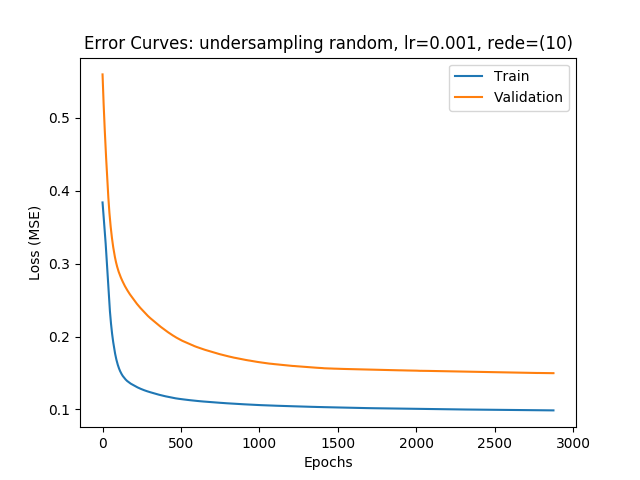

<IPython.core.display.Javascript object>


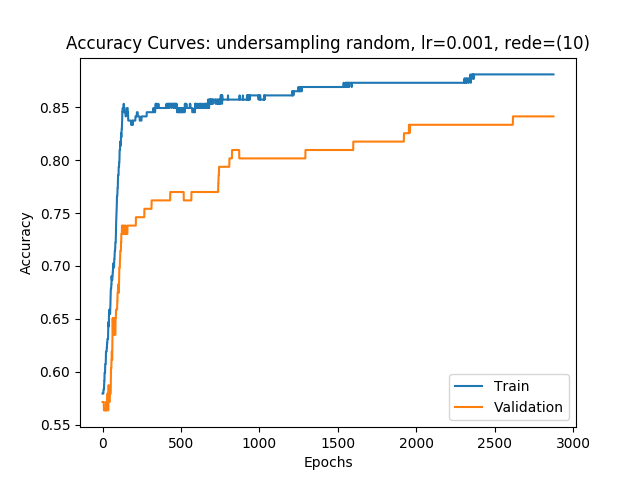

Matriz de confusão
[[1669  229]
 [  12   52]]

Train Loss:       0.0988
Validation Loss:  0.1497
Accuracy:         0.8772
MSE:              0.1228
AUROC:            0.9195


In [37]:
plot_training_error_curves(history, graficoName + "(10)")
plot_training_acc_curves(history, graficoName + "(10)")

## Fazer predições no conjunto de teste
y_pred = classifier.predict(X_test)
y_pred_class = classifier.predict_classes(X_test, verbose=0)

## Matriz de confusão
print('Matriz de confusão')
print(confusion_matrix(y_test, y_pred_class))

## Computar métricas de desempenho
losses = extract_final_losses(history)
print()
print("{metric:<18}{value:.4f}".format(metric="Train Loss:", value=losses['train_loss']))
print("{metric:<18}{value:.4f}".format(metric="Validation Loss:", value=losses['val_loss']))
print("{metric:<18}{value:.4f}".format(metric="Accuracy:", value=accuracy_score(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="MSE:", value=mean_squared_error(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="AUROC:", value=roc_auc_score(y_test, y_pred)))

## RNA 2 (20)

In [38]:
# Aqui criamos o esboço da rede.
classifier = Sequential()

classifier.add(Dense(20, activation='relu', input_dim=6)) # camada escondida
classifier.add(Dense(1, activation='relu')) # 

sgd = optimizers.SGD(lr=learnRate)
classifier.compile(optimizer=sgd,
                   loss='mean_squared_error', # metrica de erro
                   metrics=['accuracy']) # metrica de sucesso

early_stopping = EarlyStopping(monitor='val_loss', patience=20)

history = classifier.fit(X_train, y_train,
                         epochs=100000, # quantidade de epocas que a rede neural vai executar
                         verbose=1,
                         shuffle=True, # utilizado para misturar as amostras a cada epoca
                         validation_data=(X_validation, y_validation),
                         callbacks=[early_stopping])

Train on 252 samples, validate on 126 samples
Epoch 1/100000
252/252 [==============================] - 0s - loss: 0.3910 - acc: 0.5238 - val_loss: 0.4076 - val_acc: 0.5556
Epoch 2/100000
252/252 [==============================] - 0s - loss: 0.3869 - acc: 0.5317 - val_loss: 0.4047 - val_acc: 0.5556
Epoch 3/100000
252/252 [==============================] - 0s - loss: 0.3828 - acc: 0.5317 - val_loss: 0.4017 - val_acc: 0.5556
Epoch 4/100000
252/252 [==============================] - 0s - loss: 0.3785 - acc: 0.5397 - val_loss: 0.3989 - val_acc: 0.5556
Epoch 5/100000
252/252 [==============================] - 0s - loss: 0.3744 - acc: 0.5476 - val_loss: 0.3961 - val_acc: 0.5635
Epoch 6/100000
252/252 [==============================] - 0s - loss: 0.3705 - acc: 0.5556 - val_loss: 0.3933 - val_acc: 0.5556
Epoch 7/100000
252/252 [==============================] - 0s - loss: 0.3667 - acc: 0.5595 - val_loss: 0.3904 - val_acc: 0.5556
Epoch 8/100000
252/252 [==============================] - 0s - lo

252/252 [==============================] - 0s - loss: 0.2359 - acc: 0.7143 - val_loss: 0.2727 - val_acc: 0.6587
Epoch 65/100000
252/252 [==============================] - 0s - loss: 0.2344 - acc: 0.7143 - val_loss: 0.2708 - val_acc: 0.6587
Epoch 66/100000
252/252 [==============================] - 0s - loss: 0.2329 - acc: 0.7143 - val_loss: 0.2688 - val_acc: 0.6667
Epoch 67/100000
252/252 [==============================] - 0s - loss: 0.2315 - acc: 0.7143 - val_loss: 0.2669 - val_acc: 0.6667
Epoch 68/100000
252/252 [==============================] - 0s - loss: 0.2301 - acc: 0.7183 - val_loss: 0.2649 - val_acc: 0.6667
Epoch 69/100000
252/252 [==============================] - 0s - loss: 0.2287 - acc: 0.7222 - val_loss: 0.2630 - val_acc: 0.6667
Epoch 70/100000
252/252 [==============================] - 0s - loss: 0.2274 - acc: 0.7222 - val_loss: 0.2610 - val_acc: 0.6667
Epoch 71/100000
252/252 [==============================] - 0s - loss: 0.2259 - acc: 0.7222 - val_loss: 0.2591 - val_acc:

252/252 [==============================] - 0s - loss: 0.1731 - acc: 0.7937 - val_loss: 0.1915 - val_acc: 0.7778
Epoch 128/100000
252/252 [==============================] - 0s - loss: 0.1725 - acc: 0.7937 - val_loss: 0.1908 - val_acc: 0.7778
Epoch 129/100000
252/252 [==============================] - 0s - loss: 0.1719 - acc: 0.7937 - val_loss: 0.1902 - val_acc: 0.7778
Epoch 130/100000
252/252 [==============================] - ETA: 0s - loss: 0.1587 - acc: 0.843 - 0s - loss: 0.1714 - acc: 0.7937 - val_loss: 0.1896 - val_acc: 0.7778
Epoch 131/100000
252/252 [==============================] - 0s - loss: 0.1708 - acc: 0.7937 - val_loss: 0.1890 - val_acc: 0.7857
Epoch 132/100000
252/252 [==============================] - 0s - loss: 0.1702 - acc: 0.8016 - val_loss: 0.1885 - val_acc: 0.7857
Epoch 133/100000
252/252 [==============================] - 0s - loss: 0.1697 - acc: 0.8056 - val_loss: 0.1879 - val_acc: 0.7937
Epoch 134/100000
252/252 [==============================] - 0s - loss: 0.169

252/252 [==============================] - 0s - loss: 0.1402 - acc: 0.8333 - val_loss: 0.1675 - val_acc: 0.8333
Epoch 191/100000
252/252 [==============================] - 0s - loss: 0.1398 - acc: 0.8333 - val_loss: 0.1676 - val_acc: 0.8333
Epoch 192/100000
252/252 [==============================] - 0s - loss: 0.1392 - acc: 0.8294 - val_loss: 0.1676 - val_acc: 0.8333
Epoch 193/100000
252/252 [==============================] - 0s - loss: 0.1386 - acc: 0.8294 - val_loss: 0.1677 - val_acc: 0.8333
Epoch 194/100000
252/252 [==============================] - 0s - loss: 0.1381 - acc: 0.8294 - val_loss: 0.1677 - val_acc: 0.8254
Epoch 195/100000
252/252 [==============================] - 0s - loss: 0.1375 - acc: 0.8294 - val_loss: 0.1677 - val_acc: 0.8254
Epoch 196/100000
252/252 [==============================] - 0s - loss: 0.1370 - acc: 0.8294 - val_loss: 0.1677 - val_acc: 0.8254
Epoch 197/100000
252/252 [==============================] - 0s - loss: 0.1365 - acc: 0.8294 - val_loss: 0.1678 - v

252/252 [==============================] - 0s - loss: 0.1221 - acc: 0.8532 - val_loss: 0.1618 - val_acc: 0.8333
Epoch 254/100000
252/252 [==============================] - 0s - loss: 0.1220 - acc: 0.8532 - val_loss: 0.1617 - val_acc: 0.8333
Epoch 255/100000
252/252 [==============================] - 0s - loss: 0.1218 - acc: 0.8532 - val_loss: 0.1616 - val_acc: 0.8333
Epoch 256/100000
252/252 [==============================] - 0s - loss: 0.1217 - acc: 0.8532 - val_loss: 0.1615 - val_acc: 0.8333
Epoch 257/100000
252/252 [==============================] - 0s - loss: 0.1216 - acc: 0.8532 - val_loss: 0.1614 - val_acc: 0.8333
Epoch 258/100000
252/252 [==============================] - 0s - loss: 0.1215 - acc: 0.8532 - val_loss: 0.1613 - val_acc: 0.8333
Epoch 259/100000
252/252 [==============================] - 0s - loss: 0.1213 - acc: 0.8532 - val_loss: 0.1612 - val_acc: 0.8333
Epoch 260/100000
252/252 [==============================] - 0s - loss: 0.1212 - acc: 0.8532 - val_loss: 0.1611 - v

252/252 [==============================] - 0s - loss: 0.1169 - acc: 0.8611 - val_loss: 0.1566 - val_acc: 0.8333
Epoch 317/100000
252/252 [==============================] - 0s - loss: 0.1168 - acc: 0.8611 - val_loss: 0.1566 - val_acc: 0.8333
Epoch 318/100000
252/252 [==============================] - 0s - loss: 0.1168 - acc: 0.8611 - val_loss: 0.1565 - val_acc: 0.8333
Epoch 319/100000
252/252 [==============================] - 0s - loss: 0.1167 - acc: 0.8611 - val_loss: 0.1564 - val_acc: 0.8333
Epoch 320/100000
252/252 [==============================] - 0s - loss: 0.1167 - acc: 0.8611 - val_loss: 0.1564 - val_acc: 0.8333
Epoch 321/100000
252/252 [==============================] - 0s - loss: 0.1166 - acc: 0.8611 - val_loss: 0.1563 - val_acc: 0.8333
Epoch 322/100000
252/252 [==============================] - 0s - loss: 0.1166 - acc: 0.8611 - val_loss: 0.1563 - val_acc: 0.8333
Epoch 323/100000
252/252 [==============================] - 0s - loss: 0.1165 - acc: 0.8571 - val_loss: 0.1562 - v

252/252 [==============================] - 0s - loss: 0.1137 - acc: 0.8651 - val_loss: 0.1519 - val_acc: 0.8254
Epoch 380/100000
252/252 [==============================] - 0s - loss: 0.1136 - acc: 0.8651 - val_loss: 0.1518 - val_acc: 0.8254
Epoch 381/100000
252/252 [==============================] - 0s - loss: 0.1136 - acc: 0.8651 - val_loss: 0.1517 - val_acc: 0.8254
Epoch 382/100000
252/252 [==============================] - 0s - loss: 0.1135 - acc: 0.8651 - val_loss: 0.1517 - val_acc: 0.8254
Epoch 383/100000
252/252 [==============================] - 0s - loss: 0.1135 - acc: 0.8651 - val_loss: 0.1516 - val_acc: 0.8254
Epoch 384/100000
252/252 [==============================] - 0s - loss: 0.1135 - acc: 0.8651 - val_loss: 0.1516 - val_acc: 0.8254
Epoch 385/100000
252/252 [==============================] - 0s - loss: 0.1134 - acc: 0.8651 - val_loss: 0.1515 - val_acc: 0.8254
Epoch 386/100000
252/252 [==============================] - 0s - loss: 0.1134 - acc: 0.8651 - val_loss: 0.1514 - v

252/252 [==============================] - 0s - loss: 0.1114 - acc: 0.8651 - val_loss: 0.1488 - val_acc: 0.8333
Epoch 443/100000
252/252 [==============================] - 0s - loss: 0.1114 - acc: 0.8651 - val_loss: 0.1487 - val_acc: 0.8333
Epoch 444/100000
252/252 [==============================] - 0s - loss: 0.1113 - acc: 0.8651 - val_loss: 0.1487 - val_acc: 0.8333
Epoch 445/100000
252/252 [==============================] - 0s - loss: 0.1113 - acc: 0.8651 - val_loss: 0.1486 - val_acc: 0.8333
Epoch 446/100000
252/252 [==============================] - 0s - loss: 0.1113 - acc: 0.8651 - val_loss: 0.1486 - val_acc: 0.8333
Epoch 447/100000
252/252 [==============================] - 0s - loss: 0.1112 - acc: 0.8651 - val_loss: 0.1485 - val_acc: 0.8333
Epoch 448/100000
252/252 [==============================] - 0s - loss: 0.1112 - acc: 0.8651 - val_loss: 0.1485 - val_acc: 0.8333
Epoch 449/100000
252/252 [==============================] - 0s - loss: 0.1112 - acc: 0.8651 - val_loss: 0.1485 - v

252/252 [==============================] - 0s - loss: 0.1098 - acc: 0.8690 - val_loss: 0.1462 - val_acc: 0.8333
Epoch 506/100000
252/252 [==============================] - 0s - loss: 0.1098 - acc: 0.8690 - val_loss: 0.1462 - val_acc: 0.8333
Epoch 507/100000
252/252 [==============================] - 0s - loss: 0.1097 - acc: 0.8690 - val_loss: 0.1462 - val_acc: 0.8333
Epoch 508/100000
252/252 [==============================] - 0s - loss: 0.1097 - acc: 0.8690 - val_loss: 0.1462 - val_acc: 0.8333
Epoch 509/100000
252/252 [==============================] - 0s - loss: 0.1097 - acc: 0.8690 - val_loss: 0.1461 - val_acc: 0.8333
Epoch 510/100000
252/252 [==============================] - 0s - loss: 0.1097 - acc: 0.8690 - val_loss: 0.1461 - val_acc: 0.8333
Epoch 511/100000
252/252 [==============================] - 0s - loss: 0.1097 - acc: 0.8690 - val_loss: 0.1461 - val_acc: 0.8333
Epoch 512/100000
252/252 [==============================] - 0s - loss: 0.1096 - acc: 0.8690 - val_loss: 0.1460 - v

252/252 [==============================] - 0s - loss: 0.1086 - acc: 0.8690 - val_loss: 0.1443 - val_acc: 0.8413
Epoch 569/100000
252/252 [==============================] - 0s - loss: 0.1086 - acc: 0.8690 - val_loss: 0.1443 - val_acc: 0.8413
Epoch 570/100000
252/252 [==============================] - 0s - loss: 0.1086 - acc: 0.8690 - val_loss: 0.1442 - val_acc: 0.8413
Epoch 571/100000
252/252 [==============================] - 0s - loss: 0.1086 - acc: 0.8690 - val_loss: 0.1442 - val_acc: 0.8413
Epoch 572/100000
252/252 [==============================] - 0s - loss: 0.1085 - acc: 0.8690 - val_loss: 0.1442 - val_acc: 0.8413
Epoch 573/100000
252/252 [==============================] - 0s - loss: 0.1085 - acc: 0.8690 - val_loss: 0.1442 - val_acc: 0.8413
Epoch 574/100000
252/252 [==============================] - 0s - loss: 0.1085 - acc: 0.8690 - val_loss: 0.1441 - val_acc: 0.8413
Epoch 575/100000
252/252 [==============================] - 0s - loss: 0.1085 - acc: 0.8690 - val_loss: 0.1441 - v

252/252 [==============================] - 0s - loss: 0.1077 - acc: 0.8730 - val_loss: 0.1427 - val_acc: 0.8413
Epoch 632/100000
252/252 [==============================] - 0s - loss: 0.1077 - acc: 0.8730 - val_loss: 0.1427 - val_acc: 0.8413
Epoch 633/100000
252/252 [==============================] - 0s - loss: 0.1077 - acc: 0.8730 - val_loss: 0.1426 - val_acc: 0.8413
Epoch 634/100000
252/252 [==============================] - 0s - loss: 0.1076 - acc: 0.8730 - val_loss: 0.1426 - val_acc: 0.8413
Epoch 635/100000
252/252 [==============================] - 0s - loss: 0.1076 - acc: 0.8730 - val_loss: 0.1426 - val_acc: 0.8413
Epoch 636/100000
252/252 [==============================] - 0s - loss: 0.1076 - acc: 0.8730 - val_loss: 0.1425 - val_acc: 0.8413
Epoch 637/100000
252/252 [==============================] - 0s - loss: 0.1076 - acc: 0.8730 - val_loss: 0.1425 - val_acc: 0.8413
Epoch 638/100000
252/252 [==============================] - 0s - loss: 0.1076 - acc: 0.8730 - val_loss: 0.1425 - v

252/252 [==============================] - 0s - loss: 0.1069 - acc: 0.8770 - val_loss: 0.1413 - val_acc: 0.8413
Epoch 695/100000
252/252 [==============================] - 0s - loss: 0.1069 - acc: 0.8770 - val_loss: 0.1412 - val_acc: 0.8413
Epoch 696/100000
252/252 [==============================] - 0s - loss: 0.1069 - acc: 0.8770 - val_loss: 0.1412 - val_acc: 0.8413
Epoch 697/100000
252/252 [==============================] - 0s - loss: 0.1068 - acc: 0.8770 - val_loss: 0.1412 - val_acc: 0.8413
Epoch 698/100000
252/252 [==============================] - 0s - loss: 0.1068 - acc: 0.8770 - val_loss: 0.1412 - val_acc: 0.8413
Epoch 699/100000
252/252 [==============================] - 0s - loss: 0.1068 - acc: 0.8770 - val_loss: 0.1411 - val_acc: 0.8413
Epoch 700/100000
252/252 [==============================] - 0s - loss: 0.1068 - acc: 0.8770 - val_loss: 0.1411 - val_acc: 0.8413
Epoch 701/100000
252/252 [==============================] - 0s - loss: 0.1068 - acc: 0.8770 - val_loss: 0.1411 - v

252/252 [==============================] - 0s - loss: 0.1061 - acc: 0.8770 - val_loss: 0.1397 - val_acc: 0.8413
Epoch 758/100000
252/252 [==============================] - 0s - loss: 0.1061 - acc: 0.8770 - val_loss: 0.1397 - val_acc: 0.8413
Epoch 759/100000
252/252 [==============================] - 0s - loss: 0.1061 - acc: 0.8770 - val_loss: 0.1397 - val_acc: 0.8413
Epoch 760/100000
252/252 [==============================] - 0s - loss: 0.1060 - acc: 0.8770 - val_loss: 0.1397 - val_acc: 0.8413
Epoch 761/100000
252/252 [==============================] - 0s - loss: 0.1060 - acc: 0.8770 - val_loss: 0.1397 - val_acc: 0.8413
Epoch 762/100000
252/252 [==============================] - 0s - loss: 0.1060 - acc: 0.8770 - val_loss: 0.1397 - val_acc: 0.8413
Epoch 763/100000
252/252 [==============================] - 0s - loss: 0.1060 - acc: 0.8770 - val_loss: 0.1397 - val_acc: 0.8413
Epoch 764/100000
252/252 [==============================] - 0s - loss: 0.1060 - acc: 0.8770 - val_loss: 0.1396 - v

252/252 [==============================] - 0s - loss: 0.1054 - acc: 0.8770 - val_loss: 0.1386 - val_acc: 0.8413
Epoch 821/100000
252/252 [==============================] - 0s - loss: 0.1054 - acc: 0.8770 - val_loss: 0.1386 - val_acc: 0.8413
Epoch 822/100000
252/252 [==============================] - 0s - loss: 0.1054 - acc: 0.8770 - val_loss: 0.1386 - val_acc: 0.8413
Epoch 823/100000
252/252 [==============================] - 0s - loss: 0.1054 - acc: 0.8770 - val_loss: 0.1385 - val_acc: 0.8413
Epoch 824/100000
252/252 [==============================] - 0s - loss: 0.1054 - acc: 0.8770 - val_loss: 0.1385 - val_acc: 0.8413
Epoch 825/100000
252/252 [==============================] - 0s - loss: 0.1054 - acc: 0.8770 - val_loss: 0.1385 - val_acc: 0.8413
Epoch 826/100000
252/252 [==============================] - 0s - loss: 0.1054 - acc: 0.8770 - val_loss: 0.1385 - val_acc: 0.8413
Epoch 827/100000
252/252 [==============================] - 0s - loss: 0.1053 - acc: 0.8770 - val_loss: 0.1385 - v

252/252 [==============================] - 0s - loss: 0.1049 - acc: 0.8770 - val_loss: 0.1376 - val_acc: 0.8492
Epoch 884/100000
252/252 [==============================] - 0s - loss: 0.1048 - acc: 0.8770 - val_loss: 0.1376 - val_acc: 0.8492
Epoch 885/100000
252/252 [==============================] - 0s - loss: 0.1049 - acc: 0.8770 - val_loss: 0.1376 - val_acc: 0.8492
Epoch 886/100000
252/252 [==============================] - 0s - loss: 0.1048 - acc: 0.8770 - val_loss: 0.1376 - val_acc: 0.8492
Epoch 887/100000
252/252 [==============================] - 0s - loss: 0.1048 - acc: 0.8770 - val_loss: 0.1375 - val_acc: 0.8492
Epoch 888/100000
252/252 [==============================] - 0s - loss: 0.1048 - acc: 0.8770 - val_loss: 0.1375 - val_acc: 0.8492
Epoch 889/100000
252/252 [==============================] - 0s - loss: 0.1048 - acc: 0.8770 - val_loss: 0.1375 - val_acc: 0.8492
Epoch 890/100000
252/252 [==============================] - 0s - loss: 0.1048 - acc: 0.8770 - val_loss: 0.1375 - v

252/252 [==============================] - 0s - loss: 0.1044 - acc: 0.8770 - val_loss: 0.1368 - val_acc: 0.8492
Epoch 947/100000
252/252 [==============================] - 0s - loss: 0.1043 - acc: 0.8770 - val_loss: 0.1368 - val_acc: 0.8492
Epoch 948/100000
252/252 [==============================] - 0s - loss: 0.1043 - acc: 0.8770 - val_loss: 0.1368 - val_acc: 0.8492
Epoch 949/100000
252/252 [==============================] - 0s - loss: 0.1043 - acc: 0.8770 - val_loss: 0.1368 - val_acc: 0.8492
Epoch 950/100000
252/252 [==============================] - 0s - loss: 0.1043 - acc: 0.8770 - val_loss: 0.1367 - val_acc: 0.8492
Epoch 951/100000
252/252 [==============================] - 0s - loss: 0.1043 - acc: 0.8770 - val_loss: 0.1367 - val_acc: 0.8492
Epoch 952/100000
252/252 [==============================] - 0s - loss: 0.1043 - acc: 0.8770 - val_loss: 0.1367 - val_acc: 0.8492
Epoch 953/100000
252/252 [==============================] - 0s - loss: 0.1043 - acc: 0.8770 - val_loss: 0.1367 - v

252/252 [==============================] - 0s - loss: 0.1039 - acc: 0.8770 - val_loss: 0.1361 - val_acc: 0.8413
Epoch 1010/100000
252/252 [==============================] - 0s - loss: 0.1039 - acc: 0.8770 - val_loss: 0.1361 - val_acc: 0.8413
Epoch 1011/100000
252/252 [==============================] - 0s - loss: 0.1039 - acc: 0.8810 - val_loss: 0.1360 - val_acc: 0.8413
Epoch 1012/100000
252/252 [==============================] - 0s - loss: 0.1039 - acc: 0.8810 - val_loss: 0.1361 - val_acc: 0.8413
Epoch 1013/100000
252/252 [==============================] - 0s - loss: 0.1039 - acc: 0.8770 - val_loss: 0.1360 - val_acc: 0.8413
Epoch 1014/100000
252/252 [==============================] - 0s - loss: 0.1038 - acc: 0.8810 - val_loss: 0.1360 - val_acc: 0.8413
Epoch 1015/100000
252/252 [==============================] - 0s - loss: 0.1038 - acc: 0.8770 - val_loss: 0.1360 - val_acc: 0.8413
Epoch 1016/100000
252/252 [==============================] - 0s - loss: 0.1038 - acc: 0.8770 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.1034 - acc: 0.8849 - val_loss: 0.1354 - val_acc: 0.8492
Epoch 1073/100000
252/252 [==============================] - 0s - loss: 0.1034 - acc: 0.8849 - val_loss: 0.1354 - val_acc: 0.8492
Epoch 1074/100000
252/252 [==============================] - 0s - loss: 0.1034 - acc: 0.8849 - val_loss: 0.1354 - val_acc: 0.8492
Epoch 1075/100000
252/252 [==============================] - 0s - loss: 0.1034 - acc: 0.8849 - val_loss: 0.1354 - val_acc: 0.8492
Epoch 1076/100000
252/252 [==============================] - 0s - loss: 0.1034 - acc: 0.8849 - val_loss: 0.1354 - val_acc: 0.8492
Epoch 1077/100000
252/252 [==============================] - 0s - loss: 0.1034 - acc: 0.8849 - val_loss: 0.1354 - val_acc: 0.8492
Epoch 1078/100000
252/252 [==============================] - 0s - loss: 0.1034 - acc: 0.8849 - val_loss: 0.1353 - val_acc: 0.8492
Epoch 1079/100000
252/252 [==============================] - 0s - loss: 0.1034 - acc: 0.8849 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.1030 - acc: 0.8849 - val_loss: 0.1346 - val_acc: 0.8571
Epoch 1136/100000
252/252 [==============================] - 0s - loss: 0.1030 - acc: 0.8849 - val_loss: 0.1346 - val_acc: 0.8571
Epoch 1137/100000
252/252 [==============================] - 0s - loss: 0.1030 - acc: 0.8849 - val_loss: 0.1346 - val_acc: 0.8571
Epoch 1138/100000
252/252 [==============================] - 0s - loss: 0.1030 - acc: 0.8849 - val_loss: 0.1346 - val_acc: 0.8571
Epoch 1139/100000
252/252 [==============================] - 0s - loss: 0.1030 - acc: 0.8849 - val_loss: 0.1346 - val_acc: 0.8571
Epoch 1140/100000
252/252 [==============================] - 0s - loss: 0.1030 - acc: 0.8849 - val_loss: 0.1345 - val_acc: 0.8571
Epoch 1141/100000
252/252 [==============================] - 0s - loss: 0.1030 - acc: 0.8849 - val_loss: 0.1345 - val_acc: 0.8571
Epoch 1142/100000
252/252 [==============================] - 0s - loss: 0.1030 - acc: 0.8849 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.1027 - acc: 0.8810 - val_loss: 0.1339 - val_acc: 0.8571
Epoch 1199/100000
252/252 [==============================] - 0s - loss: 0.1026 - acc: 0.8810 - val_loss: 0.1339 - val_acc: 0.8571
Epoch 1200/100000
252/252 [==============================] - 0s - loss: 0.1026 - acc: 0.8810 - val_loss: 0.1339 - val_acc: 0.8571
Epoch 1201/100000
252/252 [==============================] - 0s - loss: 0.1026 - acc: 0.8810 - val_loss: 0.1339 - val_acc: 0.8571
Epoch 1202/100000
252/252 [==============================] - 0s - loss: 0.1026 - acc: 0.8810 - val_loss: 0.1339 - val_acc: 0.8571
Epoch 1203/100000
252/252 [==============================] - 0s - loss: 0.1026 - acc: 0.8810 - val_loss: 0.1339 - val_acc: 0.8571
Epoch 1204/100000
252/252 [==============================] - 0s - loss: 0.1026 - acc: 0.8810 - val_loss: 0.1339 - val_acc: 0.8571
Epoch 1205/100000
252/252 [==============================] - 0s - loss: 0.1026 - acc: 0.8810 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.1023 - acc: 0.8810 - val_loss: 0.1333 - val_acc: 0.8651
Epoch 1262/100000
252/252 [==============================] - 0s - loss: 0.1023 - acc: 0.8810 - val_loss: 0.1333 - val_acc: 0.8651
Epoch 1263/100000
252/252 [==============================] - 0s - loss: 0.1023 - acc: 0.8810 - val_loss: 0.1333 - val_acc: 0.8651
Epoch 1264/100000
252/252 [==============================] - 0s - loss: 0.1023 - acc: 0.8810 - val_loss: 0.1332 - val_acc: 0.8651
Epoch 1265/100000
252/252 [==============================] - 0s - loss: 0.1023 - acc: 0.8810 - val_loss: 0.1332 - val_acc: 0.8651
Epoch 1266/100000
252/252 [==============================] - 0s - loss: 0.1022 - acc: 0.8810 - val_loss: 0.1332 - val_acc: 0.8651
Epoch 1267/100000
252/252 [==============================] - 0s - loss: 0.1022 - acc: 0.8810 - val_loss: 0.1332 - val_acc: 0.8651
Epoch 1268/100000
252/252 [==============================] - 0s - loss: 0.1022 - acc: 0.8810 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.1019 - acc: 0.8810 - val_loss: 0.1326 - val_acc: 0.8651
Epoch 1325/100000
252/252 [==============================] - 0s - loss: 0.1019 - acc: 0.8810 - val_loss: 0.1326 - val_acc: 0.8651
Epoch 1326/100000
252/252 [==============================] - 0s - loss: 0.1019 - acc: 0.8810 - val_loss: 0.1326 - val_acc: 0.8651
Epoch 1327/100000
252/252 [==============================] - 0s - loss: 0.1019 - acc: 0.8810 - val_loss: 0.1326 - val_acc: 0.8651
Epoch 1328/100000
252/252 [==============================] - 0s - loss: 0.1019 - acc: 0.8810 - val_loss: 0.1325 - val_acc: 0.8651
Epoch 1329/100000
252/252 [==============================] - 0s - loss: 0.1019 - acc: 0.8810 - val_loss: 0.1325 - val_acc: 0.8651
Epoch 1330/100000
252/252 [==============================] - 0s - loss: 0.1019 - acc: 0.8810 - val_loss: 0.1325 - val_acc: 0.8651
Epoch 1331/100000
252/252 [==============================] - 0s - loss: 0.1019 - acc: 0.8810 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.1015 - acc: 0.8810 - val_loss: 0.1319 - val_acc: 0.8651
Epoch 1388/100000
252/252 [==============================] - 0s - loss: 0.1015 - acc: 0.8810 - val_loss: 0.1319 - val_acc: 0.8651
Epoch 1389/100000
252/252 [==============================] - 0s - loss: 0.1015 - acc: 0.8810 - val_loss: 0.1319 - val_acc: 0.8651
Epoch 1390/100000
252/252 [==============================] - 0s - loss: 0.1015 - acc: 0.8810 - val_loss: 0.1319 - val_acc: 0.8651
Epoch 1391/100000
252/252 [==============================] - 0s - loss: 0.1015 - acc: 0.8810 - val_loss: 0.1319 - val_acc: 0.8651
Epoch 1392/100000
252/252 [==============================] - 0s - loss: 0.1015 - acc: 0.8810 - val_loss: 0.1319 - val_acc: 0.8651
Epoch 1393/100000
252/252 [==============================] - 0s - loss: 0.1015 - acc: 0.8810 - val_loss: 0.1319 - val_acc: 0.8651
Epoch 1394/100000
252/252 [==============================] - 0s - loss: 0.1015 - acc: 0.8810 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.1012 - acc: 0.8810 - val_loss: 0.1313 - val_acc: 0.8651
Epoch 1451/100000
252/252 [==============================] - 0s - loss: 0.1012 - acc: 0.8810 - val_loss: 0.1313 - val_acc: 0.8651
Epoch 1452/100000
252/252 [==============================] - 0s - loss: 0.1012 - acc: 0.8810 - val_loss: 0.1313 - val_acc: 0.8651
Epoch 1453/100000
252/252 [==============================] - 0s - loss: 0.1012 - acc: 0.8810 - val_loss: 0.1313 - val_acc: 0.8651
Epoch 1454/100000
252/252 [==============================] - 0s - loss: 0.1011 - acc: 0.8810 - val_loss: 0.1313 - val_acc: 0.8651
Epoch 1455/100000
252/252 [==============================] - 0s - loss: 0.1011 - acc: 0.8810 - val_loss: 0.1313 - val_acc: 0.8651
Epoch 1456/100000
252/252 [==============================] - 0s - loss: 0.1011 - acc: 0.8810 - val_loss: 0.1313 - val_acc: 0.8651
Epoch 1457/100000
252/252 [==============================] - 0s - loss: 0.1011 - acc: 0.8810 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.1008 - acc: 0.8849 - val_loss: 0.1307 - val_acc: 0.8651
Epoch 1514/100000
252/252 [==============================] - 0s - loss: 0.1008 - acc: 0.8849 - val_loss: 0.1307 - val_acc: 0.8651
Epoch 1515/100000
252/252 [==============================] - 0s - loss: 0.1008 - acc: 0.8810 - val_loss: 0.1307 - val_acc: 0.8651
Epoch 1516/100000
252/252 [==============================] - 0s - loss: 0.1008 - acc: 0.8849 - val_loss: 0.1307 - val_acc: 0.8651
Epoch 1517/100000
252/252 [==============================] - 0s - loss: 0.1008 - acc: 0.8849 - val_loss: 0.1307 - val_acc: 0.8651
Epoch 1518/100000
252/252 [==============================] - 0s - loss: 0.1008 - acc: 0.8849 - val_loss: 0.1307 - val_acc: 0.8651
Epoch 1519/100000
252/252 [==============================] - 0s - loss: 0.1008 - acc: 0.8889 - val_loss: 0.1307 - val_acc: 0.8651
Epoch 1520/100000
252/252 [==============================] - 0s - loss: 0.1008 - acc: 0.8849 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.1005 - acc: 0.8889 - val_loss: 0.1302 - val_acc: 0.8651
Epoch 1577/100000
252/252 [==============================] - 0s - loss: 0.1005 - acc: 0.8889 - val_loss: 0.1302 - val_acc: 0.8651
Epoch 1578/100000
252/252 [==============================] - 0s - loss: 0.1005 - acc: 0.8889 - val_loss: 0.1302 - val_acc: 0.8651
Epoch 1579/100000
252/252 [==============================] - 0s - loss: 0.1005 - acc: 0.8889 - val_loss: 0.1302 - val_acc: 0.8651
Epoch 1580/100000
252/252 [==============================] - 0s - loss: 0.1005 - acc: 0.8889 - val_loss: 0.1302 - val_acc: 0.8651
Epoch 1581/100000
252/252 [==============================] - 0s - loss: 0.1005 - acc: 0.8889 - val_loss: 0.1302 - val_acc: 0.8651
Epoch 1582/100000
252/252 [==============================] - 0s - loss: 0.1005 - acc: 0.8889 - val_loss: 0.1301 - val_acc: 0.8651
Epoch 1583/100000
252/252 [==============================] - 0s - loss: 0.1005 - acc: 0.8889 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.1003 - acc: 0.8889 - val_loss: 0.1296 - val_acc: 0.8651
Epoch 1640/100000
252/252 [==============================] - 0s - loss: 0.1002 - acc: 0.8889 - val_loss: 0.1296 - val_acc: 0.8651
Epoch 1641/100000
252/252 [==============================] - 0s - loss: 0.1002 - acc: 0.8889 - val_loss: 0.1296 - val_acc: 0.8651
Epoch 1642/100000
252/252 [==============================] - 0s - loss: 0.1002 - acc: 0.8889 - val_loss: 0.1296 - val_acc: 0.8651
Epoch 1643/100000
252/252 [==============================] - 0s - loss: 0.1002 - acc: 0.8889 - val_loss: 0.1296 - val_acc: 0.8651
Epoch 1644/100000
252/252 [==============================] - 0s - loss: 0.1002 - acc: 0.8889 - val_loss: 0.1296 - val_acc: 0.8651
Epoch 1645/100000
252/252 [==============================] - 0s - loss: 0.1002 - acc: 0.8889 - val_loss: 0.1296 - val_acc: 0.8651
Epoch 1646/100000
252/252 [==============================] - 0s - loss: 0.1002 - acc: 0.8889 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0998 - acc: 0.8889 - val_loss: 0.1292 - val_acc: 0.8651
Epoch 1703/100000
252/252 [==============================] - 0s - loss: 0.0998 - acc: 0.8889 - val_loss: 0.1292 - val_acc: 0.8651
Epoch 1704/100000
252/252 [==============================] - 0s - loss: 0.0998 - acc: 0.8889 - val_loss: 0.1292 - val_acc: 0.8651
Epoch 1705/100000
252/252 [==============================] - 0s - loss: 0.0998 - acc: 0.8889 - val_loss: 0.1292 - val_acc: 0.8651
Epoch 1706/100000
252/252 [==============================] - 0s - loss: 0.0998 - acc: 0.8889 - val_loss: 0.1292 - val_acc: 0.8651
Epoch 1707/100000
252/252 [==============================] - 0s - loss: 0.0998 - acc: 0.8889 - val_loss: 0.1291 - val_acc: 0.8651
Epoch 1708/100000
252/252 [==============================] - 0s - loss: 0.0998 - acc: 0.8889 - val_loss: 0.1291 - val_acc: 0.8651
Epoch 1709/100000
252/252 [==============================] - 0s - loss: 0.0998 - acc: 0.8889 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0994 - acc: 0.8889 - val_loss: 0.1287 - val_acc: 0.8651
Epoch 1765/100000
252/252 [==============================] - 0s - loss: 0.0993 - acc: 0.8889 - val_loss: 0.1287 - val_acc: 0.8651
Epoch 1766/100000
252/252 [==============================] - 0s - loss: 0.0993 - acc: 0.8889 - val_loss: 0.1287 - val_acc: 0.8651
Epoch 1767/100000
252/252 [==============================] - 0s - loss: 0.0993 - acc: 0.8889 - val_loss: 0.1287 - val_acc: 0.8651
Epoch 1768/100000
252/252 [==============================] - 0s - loss: 0.0993 - acc: 0.8889 - val_loss: 0.1287 - val_acc: 0.8651
Epoch 1769/100000
252/252 [==============================] - 0s - loss: 0.0993 - acc: 0.8889 - val_loss: 0.1287 - val_acc: 0.8651
Epoch 1770/100000
252/252 [==============================] - 0s - loss: 0.0993 - acc: 0.8889 - val_loss: 0.1287 - val_acc: 0.8651
Epoch 1771/100000
252/252 [==============================] - 0s - loss: 0.0993 - acc: 0.8889 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0989 - acc: 0.8889 - val_loss: 0.1282 - val_acc: 0.8651
Epoch 1828/100000
252/252 [==============================] - 0s - loss: 0.0989 - acc: 0.8889 - val_loss: 0.1282 - val_acc: 0.8651
Epoch 1829/100000
252/252 [==============================] - 0s - loss: 0.0989 - acc: 0.8889 - val_loss: 0.1282 - val_acc: 0.8651
Epoch 1830/100000
252/252 [==============================] - 0s - loss: 0.0989 - acc: 0.8889 - val_loss: 0.1282 - val_acc: 0.8651
Epoch 1831/100000
252/252 [==============================] - 0s - loss: 0.0989 - acc: 0.8889 - val_loss: 0.1282 - val_acc: 0.8651
Epoch 1832/100000
252/252 [==============================] - 0s - loss: 0.0989 - acc: 0.8889 - val_loss: 0.1282 - val_acc: 0.8651
Epoch 1833/100000
252/252 [==============================] - 0s - loss: 0.0989 - acc: 0.8889 - val_loss: 0.1282 - val_acc: 0.8651
Epoch 1834/100000
252/252 [==============================] - 0s - loss: 0.0988 - acc: 0.8889 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0985 - acc: 0.8889 - val_loss: 0.1278 - val_acc: 0.8651
Epoch 1891/100000
252/252 [==============================] - 0s - loss: 0.0985 - acc: 0.8889 - val_loss: 0.1278 - val_acc: 0.8651
Epoch 1892/100000
252/252 [==============================] - 0s - loss: 0.0985 - acc: 0.8889 - val_loss: 0.1278 - val_acc: 0.8651
Epoch 1893/100000
252/252 [==============================] - 0s - loss: 0.0985 - acc: 0.8889 - val_loss: 0.1278 - val_acc: 0.8651
Epoch 1894/100000
252/252 [==============================] - 0s - loss: 0.0985 - acc: 0.8889 - val_loss: 0.1278 - val_acc: 0.8651
Epoch 1895/100000
252/252 [==============================] - 0s - loss: 0.0985 - acc: 0.8889 - val_loss: 0.1278 - val_acc: 0.8651
Epoch 1896/100000
252/252 [==============================] - 0s - loss: 0.0985 - acc: 0.8889 - val_loss: 0.1278 - val_acc: 0.8651
Epoch 1897/100000
252/252 [==============================] - 0s - loss: 0.0984 - acc: 0.8889 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0981 - acc: 0.8889 - val_loss: 0.1274 - val_acc: 0.8651
Epoch 1954/100000
252/252 [==============================] - 0s - loss: 0.0981 - acc: 0.8889 - val_loss: 0.1274 - val_acc: 0.8651
Epoch 1955/100000
252/252 [==============================] - 0s - loss: 0.0981 - acc: 0.8889 - val_loss: 0.1274 - val_acc: 0.8651
Epoch 1956/100000
252/252 [==============================] - 0s - loss: 0.0981 - acc: 0.8889 - val_loss: 0.1274 - val_acc: 0.8651
Epoch 1957/100000
252/252 [==============================] - 0s - loss: 0.0981 - acc: 0.8889 - val_loss: 0.1273 - val_acc: 0.8651
Epoch 1958/100000
252/252 [==============================] - 0s - loss: 0.0981 - acc: 0.8889 - val_loss: 0.1274 - val_acc: 0.8651
Epoch 1959/100000
252/252 [==============================] - 0s - loss: 0.0981 - acc: 0.8889 - val_loss: 0.1273 - val_acc: 0.8651
Epoch 1960/100000
252/252 [==============================] - 0s - loss: 0.0981 - acc: 0.8889 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0977 - acc: 0.8889 - val_loss: 0.1270 - val_acc: 0.8651
Epoch 2017/100000
252/252 [==============================] - 0s - loss: 0.0977 - acc: 0.8889 - val_loss: 0.1270 - val_acc: 0.8651
Epoch 2018/100000
252/252 [==============================] - 0s - loss: 0.0977 - acc: 0.8889 - val_loss: 0.1270 - val_acc: 0.8651
Epoch 2019/100000
252/252 [==============================] - 0s - loss: 0.0977 - acc: 0.8889 - val_loss: 0.1270 - val_acc: 0.8651
Epoch 2020/100000
252/252 [==============================] - 0s - loss: 0.0977 - acc: 0.8889 - val_loss: 0.1270 - val_acc: 0.8651
Epoch 2021/100000
252/252 [==============================] - 0s - loss: 0.0977 - acc: 0.8889 - val_loss: 0.1270 - val_acc: 0.8651
Epoch 2022/100000
252/252 [==============================] - 0s - loss: 0.0977 - acc: 0.8889 - val_loss: 0.1270 - val_acc: 0.8651
Epoch 2023/100000
252/252 [==============================] - 0s - loss: 0.0977 - acc: 0.8889 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0974 - acc: 0.8889 - val_loss: 0.1266 - val_acc: 0.8651
Epoch 2080/100000
252/252 [==============================] - 0s - loss: 0.0974 - acc: 0.8889 - val_loss: 0.1266 - val_acc: 0.8651
Epoch 2081/100000
252/252 [==============================] - 0s - loss: 0.0974 - acc: 0.8889 - val_loss: 0.1266 - val_acc: 0.8651
Epoch 2082/100000
252/252 [==============================] - 0s - loss: 0.0973 - acc: 0.8889 - val_loss: 0.1266 - val_acc: 0.8651
Epoch 2083/100000
252/252 [==============================] - 0s - loss: 0.0974 - acc: 0.8889 - val_loss: 0.1266 - val_acc: 0.8651
Epoch 2084/100000
252/252 [==============================] - ETA: 0s - loss: 0.0791 - acc: 0.937 - 0s - loss: 0.0973 - acc: 0.8889 - val_loss: 0.1266 - val_acc: 0.8651
Epoch 2085/100000
252/252 [==============================] - 0s - loss: 0.0973 - acc: 0.8889 - val_loss: 0.1265 - val_acc: 0.8651
Epoch 2086/100000
252/252 [==============================] - 0s - loss

252/252 [==============================] - 0s - loss: 0.0970 - acc: 0.8889 - val_loss: 0.1262 - val_acc: 0.8651
Epoch 2142/100000
252/252 [==============================] - 0s - loss: 0.0970 - acc: 0.8889 - val_loss: 0.1262 - val_acc: 0.8651
Epoch 2143/100000
252/252 [==============================] - 0s - loss: 0.0970 - acc: 0.8889 - val_loss: 0.1262 - val_acc: 0.8651
Epoch 2144/100000
252/252 [==============================] - 0s - loss: 0.0970 - acc: 0.8889 - val_loss: 0.1262 - val_acc: 0.8651
Epoch 2145/100000
252/252 [==============================] - 0s - loss: 0.0970 - acc: 0.8889 - val_loss: 0.1262 - val_acc: 0.8651
Epoch 2146/100000
252/252 [==============================] - 0s - loss: 0.0970 - acc: 0.8889 - val_loss: 0.1262 - val_acc: 0.8651
Epoch 2147/100000
252/252 [==============================] - 0s - loss: 0.0970 - acc: 0.8889 - val_loss: 0.1262 - val_acc: 0.8651
Epoch 2148/100000
252/252 [==============================] - 0s - loss: 0.0970 - acc: 0.8889 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0967 - acc: 0.8889 - val_loss: 0.1258 - val_acc: 0.8651
Epoch 2204/100000
252/252 [==============================] - 0s - loss: 0.0967 - acc: 0.8889 - val_loss: 0.1258 - val_acc: 0.8651
Epoch 2205/100000
252/252 [==============================] - 0s - loss: 0.0966 - acc: 0.8889 - val_loss: 0.1258 - val_acc: 0.8651
Epoch 2206/100000
252/252 [==============================] - 0s - loss: 0.0966 - acc: 0.8889 - val_loss: 0.1258 - val_acc: 0.8651
Epoch 2207/100000
252/252 [==============================] - 0s - loss: 0.0966 - acc: 0.8889 - val_loss: 0.1258 - val_acc: 0.8651
Epoch 2208/100000
252/252 [==============================] - 0s - loss: 0.0966 - acc: 0.8889 - val_loss: 0.1258 - val_acc: 0.8651
Epoch 2209/100000
252/252 [==============================] - 0s - loss: 0.0966 - acc: 0.8889 - val_loss: 0.1258 - val_acc: 0.8651
Epoch 2210/100000
252/252 [==============================] - 0s - loss: 0.0966 - acc: 0.8889 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0963 - acc: 0.8889 - val_loss: 0.1254 - val_acc: 0.8651
Epoch 2267/100000
252/252 [==============================] - 0s - loss: 0.0963 - acc: 0.8889 - val_loss: 0.1254 - val_acc: 0.8651
Epoch 2268/100000
252/252 [==============================] - 0s - loss: 0.0963 - acc: 0.8889 - val_loss: 0.1254 - val_acc: 0.8651
Epoch 2269/100000
252/252 [==============================] - 0s - loss: 0.0963 - acc: 0.8889 - val_loss: 0.1254 - val_acc: 0.8651
Epoch 2270/100000
252/252 [==============================] - 0s - loss: 0.0963 - acc: 0.8929 - val_loss: 0.1254 - val_acc: 0.8651
Epoch 2271/100000
252/252 [==============================] - 0s - loss: 0.0963 - acc: 0.8929 - val_loss: 0.1254 - val_acc: 0.8651
Epoch 2272/100000
252/252 [==============================] - 0s - loss: 0.0963 - acc: 0.8889 - val_loss: 0.1254 - val_acc: 0.8651
Epoch 2273/100000
252/252 [==============================] - 0s - loss: 0.0963 - acc: 0.8889 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0960 - acc: 0.8889 - val_loss: 0.1251 - val_acc: 0.8651
Epoch 2329/100000
252/252 [==============================] - 0s - loss: 0.0960 - acc: 0.8929 - val_loss: 0.1251 - val_acc: 0.8651
Epoch 2330/100000
252/252 [==============================] - 0s - loss: 0.0960 - acc: 0.8929 - val_loss: 0.1251 - val_acc: 0.8651
Epoch 2331/100000
252/252 [==============================] - 0s - loss: 0.0960 - acc: 0.8889 - val_loss: 0.1251 - val_acc: 0.8651
Epoch 2332/100000
252/252 [==============================] - 0s - loss: 0.0960 - acc: 0.8929 - val_loss: 0.1251 - val_acc: 0.8651
Epoch 2333/100000
252/252 [==============================] - 0s - loss: 0.0960 - acc: 0.8889 - val_loss: 0.1251 - val_acc: 0.8651
Epoch 2334/100000
252/252 [==============================] - 0s - loss: 0.0960 - acc: 0.8929 - val_loss: 0.1250 - val_acc: 0.8651
Epoch 2335/100000
252/252 [==============================] - 0s - loss: 0.0960 - acc: 0.8889 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0957 - acc: 0.8929 - val_loss: 0.1248 - val_acc: 0.8651
Epoch 2391/100000
252/252 [==============================] - 0s - loss: 0.0957 - acc: 0.8929 - val_loss: 0.1249 - val_acc: 0.8651
Epoch 2392/100000
252/252 [==============================] - 0s - loss: 0.0957 - acc: 0.8929 - val_loss: 0.1248 - val_acc: 0.8651
Epoch 2393/100000
252/252 [==============================] - 0s - loss: 0.0957 - acc: 0.8929 - val_loss: 0.1248 - val_acc: 0.8651
Epoch 2394/100000
252/252 [==============================] - 0s - loss: 0.0957 - acc: 0.8929 - val_loss: 0.1248 - val_acc: 0.8651
Epoch 2395/100000
252/252 [==============================] - 0s - loss: 0.0957 - acc: 0.8929 - val_loss: 0.1248 - val_acc: 0.8651
Epoch 2396/100000
252/252 [==============================] - 0s - loss: 0.0956 - acc: 0.8929 - val_loss: 0.1248 - val_acc: 0.8651
Epoch 2397/100000
252/252 [==============================] - 0s - loss: 0.0957 - acc: 0.8929 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0954 - acc: 0.8929 - val_loss: 0.1246 - val_acc: 0.8651
Epoch 2453/100000
252/252 [==============================] - 0s - loss: 0.0954 - acc: 0.8929 - val_loss: 0.1246 - val_acc: 0.8651
Epoch 2454/100000
252/252 [==============================] - 0s - loss: 0.0954 - acc: 0.8929 - val_loss: 0.1246 - val_acc: 0.8651
Epoch 2455/100000
252/252 [==============================] - 0s - loss: 0.0954 - acc: 0.8929 - val_loss: 0.1246 - val_acc: 0.8651
Epoch 2456/100000
252/252 [==============================] - 0s - loss: 0.0954 - acc: 0.8929 - val_loss: 0.1246 - val_acc: 0.8651
Epoch 2457/100000
252/252 [==============================] - 0s - loss: 0.0954 - acc: 0.8929 - val_loss: 0.1246 - val_acc: 0.8651
Epoch 2458/100000
252/252 [==============================] - 0s - loss: 0.0954 - acc: 0.8929 - val_loss: 0.1246 - val_acc: 0.8651
Epoch 2459/100000
252/252 [==============================] - 0s - loss: 0.0954 - acc: 0.8929 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0951 - acc: 0.8968 - val_loss: 0.1244 - val_acc: 0.8651
Epoch 2516/100000
252/252 [==============================] - 0s - loss: 0.0951 - acc: 0.8929 - val_loss: 0.1244 - val_acc: 0.8651
Epoch 2517/100000
252/252 [==============================] - 0s - loss: 0.0951 - acc: 0.8929 - val_loss: 0.1244 - val_acc: 0.8651
Epoch 2518/100000
252/252 [==============================] - 0s - loss: 0.0951 - acc: 0.8929 - val_loss: 0.1244 - val_acc: 0.8651
Epoch 2519/100000
252/252 [==============================] - 0s - loss: 0.0951 - acc: 0.8968 - val_loss: 0.1244 - val_acc: 0.8651
Epoch 2520/100000
252/252 [==============================] - 0s - loss: 0.0951 - acc: 0.8968 - val_loss: 0.1244 - val_acc: 0.8651
Epoch 2521/100000
252/252 [==============================] - 0s - loss: 0.0951 - acc: 0.8968 - val_loss: 0.1244 - val_acc: 0.8651
Epoch 2522/100000
252/252 [==============================] - 0s - loss: 0.0951 - acc: 0.8968 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0948 - acc: 0.9008 - val_loss: 0.1241 - val_acc: 0.8651
Epoch 2579/100000
252/252 [==============================] - 0s - loss: 0.0948 - acc: 0.9008 - val_loss: 0.1241 - val_acc: 0.8651
Epoch 2580/100000
252/252 [==============================] - 0s - loss: 0.0948 - acc: 0.9008 - val_loss: 0.1241 - val_acc: 0.8651
Epoch 2581/100000
252/252 [==============================] - 0s - loss: 0.0948 - acc: 0.9008 - val_loss: 0.1241 - val_acc: 0.8651
Epoch 2582/100000
252/252 [==============================] - 0s - loss: 0.0948 - acc: 0.9008 - val_loss: 0.1241 - val_acc: 0.8651
Epoch 2583/100000
252/252 [==============================] - 0s - loss: 0.0948 - acc: 0.9008 - val_loss: 0.1241 - val_acc: 0.8651
Epoch 2584/100000
252/252 [==============================] - 0s - loss: 0.0948 - acc: 0.9008 - val_loss: 0.1241 - val_acc: 0.8651
Epoch 2585/100000
252/252 [==============================] - 0s - loss: 0.0948 - acc: 0.9008 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0945 - acc: 0.9008 - val_loss: 0.1239 - val_acc: 0.8651
Epoch 2642/100000
252/252 [==============================] - 0s - loss: 0.0946 - acc: 0.9008 - val_loss: 0.1239 - val_acc: 0.8651
Epoch 2643/100000
252/252 [==============================] - 0s - loss: 0.0946 - acc: 0.9008 - val_loss: 0.1238 - val_acc: 0.8651
Epoch 2644/100000
252/252 [==============================] - 0s - loss: 0.0945 - acc: 0.9008 - val_loss: 0.1238 - val_acc: 0.8651
Epoch 2645/100000
252/252 [==============================] - 0s - loss: 0.0945 - acc: 0.9008 - val_loss: 0.1238 - val_acc: 0.8651
Epoch 2646/100000
252/252 [==============================] - 0s - loss: 0.0945 - acc: 0.9008 - val_loss: 0.1238 - val_acc: 0.8651
Epoch 2647/100000
252/252 [==============================] - 0s - loss: 0.0945 - acc: 0.9008 - val_loss: 0.1238 - val_acc: 0.8651
Epoch 2648/100000
252/252 [==============================] - 0s - loss: 0.0945 - acc: 0.9008 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0943 - acc: 0.9008 - val_loss: 0.1236 - val_acc: 0.8651
Epoch 2705/100000
252/252 [==============================] - 0s - loss: 0.0943 - acc: 0.9008 - val_loss: 0.1236 - val_acc: 0.8651
Epoch 2706/100000
252/252 [==============================] - 0s - loss: 0.0943 - acc: 0.9008 - val_loss: 0.1236 - val_acc: 0.8651
Epoch 2707/100000
252/252 [==============================] - 0s - loss: 0.0943 - acc: 0.9008 - val_loss: 0.1236 - val_acc: 0.8651
Epoch 2708/100000
252/252 [==============================] - 0s - loss: 0.0943 - acc: 0.9008 - val_loss: 0.1236 - val_acc: 0.8651
Epoch 2709/100000
252/252 [==============================] - 0s - loss: 0.0943 - acc: 0.9008 - val_loss: 0.1236 - val_acc: 0.8651
Epoch 2710/100000
252/252 [==============================] - 0s - loss: 0.0942 - acc: 0.9008 - val_loss: 0.1236 - val_acc: 0.8651
Epoch 2711/100000
252/252 [==============================] - 0s - loss: 0.0942 - acc: 0.9008 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0940 - acc: 0.9008 - val_loss: 0.1234 - val_acc: 0.8651
Epoch 2768/100000
252/252 [==============================] - 0s - loss: 0.0940 - acc: 0.9008 - val_loss: 0.1234 - val_acc: 0.8651
Epoch 2769/100000
252/252 [==============================] - 0s - loss: 0.0940 - acc: 0.9008 - val_loss: 0.1234 - val_acc: 0.8651
Epoch 2770/100000
252/252 [==============================] - 0s - loss: 0.0940 - acc: 0.9008 - val_loss: 0.1234 - val_acc: 0.8651
Epoch 2771/100000
252/252 [==============================] - 0s - loss: 0.0940 - acc: 0.9008 - val_loss: 0.1234 - val_acc: 0.8651
Epoch 2772/100000
252/252 [==============================] - 0s - loss: 0.0940 - acc: 0.9008 - val_loss: 0.1234 - val_acc: 0.8651
Epoch 2773/100000
252/252 [==============================] - ETA: 0s - loss: 0.0895 - acc: 0.875 - 0s - loss: 0.0940 - acc: 0.9008 - val_loss: 0.1234 - val_acc: 0.8651
Epoch 2774/100000
252/252 [==============================] - 0s - loss

252/252 [==============================] - 0s - loss: 0.0937 - acc: 0.9008 - val_loss: 0.1233 - val_acc: 0.8651
Epoch 2830/100000
252/252 [==============================] - 0s - loss: 0.0937 - acc: 0.9008 - val_loss: 0.1233 - val_acc: 0.8651
Epoch 2831/100000
252/252 [==============================] - 0s - loss: 0.0937 - acc: 0.9008 - val_loss: 0.1233 - val_acc: 0.8651
Epoch 2832/100000
252/252 [==============================] - 0s - loss: 0.0937 - acc: 0.9008 - val_loss: 0.1233 - val_acc: 0.8651
Epoch 2833/100000
252/252 [==============================] - 0s - loss: 0.0937 - acc: 0.9008 - val_loss: 0.1233 - val_acc: 0.8651
Epoch 2834/100000
252/252 [==============================] - 0s - loss: 0.0937 - acc: 0.9008 - val_loss: 0.1233 - val_acc: 0.8651
Epoch 2835/100000
252/252 [==============================] - 0s - loss: 0.0937 - acc: 0.9008 - val_loss: 0.1233 - val_acc: 0.8651
Epoch 2836/100000
252/252 [==============================] - 0s - loss: 0.0937 - acc: 0.9008 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0934 - acc: 0.9008 - val_loss: 0.1231 - val_acc: 0.8651
Epoch 2893/100000
252/252 [==============================] - 0s - loss: 0.0934 - acc: 0.9008 - val_loss: 0.1231 - val_acc: 0.8651
Epoch 2894/100000
252/252 [==============================] - 0s - loss: 0.0934 - acc: 0.9008 - val_loss: 0.1231 - val_acc: 0.8651
Epoch 2895/100000
252/252 [==============================] - 0s - loss: 0.0934 - acc: 0.9008 - val_loss: 0.1231 - val_acc: 0.8651
Epoch 2896/100000
252/252 [==============================] - 0s - loss: 0.0934 - acc: 0.9008 - val_loss: 0.1231 - val_acc: 0.8651
Epoch 2897/100000
252/252 [==============================] - 0s - loss: 0.0934 - acc: 0.9008 - val_loss: 0.1231 - val_acc: 0.8651
Epoch 2898/100000
252/252 [==============================] - 0s - loss: 0.0934 - acc: 0.9008 - val_loss: 0.1231 - val_acc: 0.8651
Epoch 2899/100000
252/252 [==============================] - 0s - loss: 0.0934 - acc: 0.9008 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0931 - acc: 0.9008 - val_loss: 0.1229 - val_acc: 0.8651
Epoch 2956/100000
252/252 [==============================] - 0s - loss: 0.0931 - acc: 0.9008 - val_loss: 0.1229 - val_acc: 0.8651
Epoch 2957/100000
252/252 [==============================] - 0s - loss: 0.0931 - acc: 0.9008 - val_loss: 0.1229 - val_acc: 0.8651
Epoch 2958/100000
252/252 [==============================] - 0s - loss: 0.0931 - acc: 0.9008 - val_loss: 0.1229 - val_acc: 0.8651
Epoch 2959/100000
252/252 [==============================] - 0s - loss: 0.0931 - acc: 0.9008 - val_loss: 0.1229 - val_acc: 0.8651
Epoch 2960/100000
252/252 [==============================] - 0s - loss: 0.0931 - acc: 0.9008 - val_loss: 0.1228 - val_acc: 0.8651
Epoch 2961/100000
252/252 [==============================] - 0s - loss: 0.0931 - acc: 0.9008 - val_loss: 0.1228 - val_acc: 0.8651
Epoch 2962/100000
252/252 [==============================] - 0s - loss: 0.0931 - acc: 0.9008 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0929 - acc: 0.9008 - val_loss: 0.1227 - val_acc: 0.8651
Epoch 3019/100000
252/252 [==============================] - 0s - loss: 0.0929 - acc: 0.9008 - val_loss: 0.1227 - val_acc: 0.8651
Epoch 3020/100000
252/252 [==============================] - 0s - loss: 0.0929 - acc: 0.9008 - val_loss: 0.1227 - val_acc: 0.8651
Epoch 3021/100000
252/252 [==============================] - 0s - loss: 0.0929 - acc: 0.9008 - val_loss: 0.1227 - val_acc: 0.8651
Epoch 3022/100000
252/252 [==============================] - 0s - loss: 0.0929 - acc: 0.9008 - val_loss: 0.1227 - val_acc: 0.8651
Epoch 3023/100000
252/252 [==============================] - 0s - loss: 0.0929 - acc: 0.9008 - val_loss: 0.1226 - val_acc: 0.8651
Epoch 3024/100000
252/252 [==============================] - 0s - loss: 0.0929 - acc: 0.9008 - val_loss: 0.1226 - val_acc: 0.8651
Epoch 3025/100000
252/252 [==============================] - 0s - loss: 0.0929 - acc: 0.9008 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0927 - acc: 0.9008 - val_loss: 0.1223 - val_acc: 0.8651
Epoch 3082/100000
252/252 [==============================] - 0s - loss: 0.0926 - acc: 0.9008 - val_loss: 0.1223 - val_acc: 0.8651
Epoch 3083/100000
252/252 [==============================] - 0s - loss: 0.0926 - acc: 0.9008 - val_loss: 0.1223 - val_acc: 0.8651
Epoch 3084/100000
252/252 [==============================] - 0s - loss: 0.0926 - acc: 0.9008 - val_loss: 0.1223 - val_acc: 0.8651
Epoch 3085/100000
252/252 [==============================] - 0s - loss: 0.0926 - acc: 0.9008 - val_loss: 0.1223 - val_acc: 0.8651
Epoch 3086/100000
252/252 [==============================] - 0s - loss: 0.0926 - acc: 0.9008 - val_loss: 0.1223 - val_acc: 0.8651
Epoch 3087/100000
252/252 [==============================] - 0s - loss: 0.0926 - acc: 0.9008 - val_loss: 0.1223 - val_acc: 0.8651
Epoch 3088/100000
252/252 [==============================] - 0s - loss: 0.0926 - acc: 0.9008 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0924 - acc: 0.9048 - val_loss: 0.1221 - val_acc: 0.8651
Epoch 3144/100000
252/252 [==============================] - 0s - loss: 0.0924 - acc: 0.9048 - val_loss: 0.1221 - val_acc: 0.8651
Epoch 3145/100000
252/252 [==============================] - 0s - loss: 0.0924 - acc: 0.9048 - val_loss: 0.1221 - val_acc: 0.8651
Epoch 3146/100000
252/252 [==============================] - 0s - loss: 0.0924 - acc: 0.9048 - val_loss: 0.1221 - val_acc: 0.8651
Epoch 3147/100000
252/252 [==============================] - 0s - loss: 0.0924 - acc: 0.9048 - val_loss: 0.1221 - val_acc: 0.8651
Epoch 3148/100000
252/252 [==============================] - 0s - loss: 0.0924 - acc: 0.9048 - val_loss: 0.1221 - val_acc: 0.8651
Epoch 3149/100000
252/252 [==============================] - 0s - loss: 0.0924 - acc: 0.9048 - val_loss: 0.1221 - val_acc: 0.8651
Epoch 3150/100000
252/252 [==============================] - 0s - loss: 0.0924 - acc: 0.9048 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0921 - acc: 0.9048 - val_loss: 0.1219 - val_acc: 0.8651
Epoch 3207/100000
252/252 [==============================] - 0s - loss: 0.0921 - acc: 0.9048 - val_loss: 0.1219 - val_acc: 0.8651
Epoch 3208/100000
252/252 [==============================] - 0s - loss: 0.0921 - acc: 0.9048 - val_loss: 0.1219 - val_acc: 0.8651
Epoch 3209/100000
252/252 [==============================] - 0s - loss: 0.0921 - acc: 0.9048 - val_loss: 0.1219 - val_acc: 0.8651
Epoch 3210/100000
252/252 [==============================] - 0s - loss: 0.0921 - acc: 0.9048 - val_loss: 0.1219 - val_acc: 0.8651
Epoch 3211/100000
252/252 [==============================] - 0s - loss: 0.0921 - acc: 0.9048 - val_loss: 0.1219 - val_acc: 0.8651
Epoch 3212/100000
252/252 [==============================] - 0s - loss: 0.0921 - acc: 0.9048 - val_loss: 0.1219 - val_acc: 0.8651
Epoch 3213/100000
252/252 [==============================] - 0s - loss: 0.0921 - acc: 0.9048 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0919 - acc: 0.9048 - val_loss: 0.1217 - val_acc: 0.8651
Epoch 3270/100000
252/252 [==============================] - 0s - loss: 0.0919 - acc: 0.9048 - val_loss: 0.1217 - val_acc: 0.8651
Epoch 3271/100000
252/252 [==============================] - 0s - loss: 0.0919 - acc: 0.9048 - val_loss: 0.1217 - val_acc: 0.8651
Epoch 3272/100000
252/252 [==============================] - 0s - loss: 0.0919 - acc: 0.9048 - val_loss: 0.1216 - val_acc: 0.8651
Epoch 3273/100000
252/252 [==============================] - 0s - loss: 0.0919 - acc: 0.9048 - val_loss: 0.1216 - val_acc: 0.8651
Epoch 3274/100000
252/252 [==============================] - 0s - loss: 0.0919 - acc: 0.9048 - val_loss: 0.1216 - val_acc: 0.8651
Epoch 3275/100000
252/252 [==============================] - 0s - loss: 0.0919 - acc: 0.9008 - val_loss: 0.1216 - val_acc: 0.8651
Epoch 3276/100000
252/252 [==============================] - 0s - loss: 0.0919 - acc: 0.9048 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0917 - acc: 0.9008 - val_loss: 0.1214 - val_acc: 0.8651
Epoch 3333/100000
252/252 [==============================] - 0s - loss: 0.0917 - acc: 0.9008 - val_loss: 0.1214 - val_acc: 0.8651
Epoch 3334/100000
252/252 [==============================] - 0s - loss: 0.0916 - acc: 0.9008 - val_loss: 0.1214 - val_acc: 0.8651
Epoch 3335/100000
252/252 [==============================] - 0s - loss: 0.0917 - acc: 0.9008 - val_loss: 0.1214 - val_acc: 0.8651
Epoch 3336/100000
252/252 [==============================] - 0s - loss: 0.0916 - acc: 0.9008 - val_loss: 0.1214 - val_acc: 0.8651
Epoch 3337/100000
252/252 [==============================] - 0s - loss: 0.0916 - acc: 0.9008 - val_loss: 0.1214 - val_acc: 0.8651
Epoch 3338/100000
252/252 [==============================] - 0s - loss: 0.0916 - acc: 0.9008 - val_loss: 0.1214 - val_acc: 0.8651
Epoch 3339/100000
252/252 [==============================] - 0s - loss: 0.0916 - acc: 0.9008 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0914 - acc: 0.9008 - val_loss: 0.1212 - val_acc: 0.8651
Epoch 3395/100000
252/252 [==============================] - 0s - loss: 0.0914 - acc: 0.9008 - val_loss: 0.1212 - val_acc: 0.8651
Epoch 3396/100000
252/252 [==============================] - 0s - loss: 0.0914 - acc: 0.9008 - val_loss: 0.1212 - val_acc: 0.8651
Epoch 3397/100000
252/252 [==============================] - 0s - loss: 0.0914 - acc: 0.9008 - val_loss: 0.1212 - val_acc: 0.8651
Epoch 3398/100000
252/252 [==============================] - 0s - loss: 0.0914 - acc: 0.9008 - val_loss: 0.1212 - val_acc: 0.8651
Epoch 3399/100000
252/252 [==============================] - 0s - loss: 0.0914 - acc: 0.9008 - val_loss: 0.1211 - val_acc: 0.8651
Epoch 3400/100000
252/252 [==============================] - 0s - loss: 0.0914 - acc: 0.9008 - val_loss: 0.1211 - val_acc: 0.8651
Epoch 3401/100000
252/252 [==============================] - 0s - loss: 0.0914 - acc: 0.9008 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0912 - acc: 0.9008 - val_loss: 0.1209 - val_acc: 0.8651
Epoch 3458/100000
252/252 [==============================] - 0s - loss: 0.0912 - acc: 0.9008 - val_loss: 0.1209 - val_acc: 0.8651
Epoch 3459/100000
252/252 [==============================] - 0s - loss: 0.0912 - acc: 0.9008 - val_loss: 0.1209 - val_acc: 0.8651
Epoch 3460/100000
252/252 [==============================] - ETA: 0s - loss: 0.0738 - acc: 0.937 - 0s - loss: 0.0912 - acc: 0.9008 - val_loss: 0.1209 - val_acc: 0.8651
Epoch 3461/100000
252/252 [==============================] - 0s - loss: 0.0912 - acc: 0.9008 - val_loss: 0.1209 - val_acc: 0.8651
Epoch 3462/100000
252/252 [==============================] - 0s - loss: 0.0912 - acc: 0.9008 - val_loss: 0.1209 - val_acc: 0.8651
Epoch 3463/100000
252/252 [==============================] - 0s - loss: 0.0912 - acc: 0.9008 - val_loss: 0.1209 - val_acc: 0.8651
Epoch 3464/100000
252/252 [==============================] - 0s - loss

252/252 [==============================] - 0s - loss: 0.0910 - acc: 0.9008 - val_loss: 0.1205 - val_acc: 0.8571
Epoch 3520/100000
252/252 [==============================] - 0s - loss: 0.0910 - acc: 0.9008 - val_loss: 0.1205 - val_acc: 0.8571
Epoch 3521/100000
252/252 [==============================] - 0s - loss: 0.0910 - acc: 0.9008 - val_loss: 0.1205 - val_acc: 0.8571
Epoch 3522/100000
252/252 [==============================] - 0s - loss: 0.0910 - acc: 0.9008 - val_loss: 0.1205 - val_acc: 0.8571
Epoch 3523/100000
252/252 [==============================] - 0s - loss: 0.0910 - acc: 0.9008 - val_loss: 0.1205 - val_acc: 0.8571
Epoch 3524/100000
252/252 [==============================] - 0s - loss: 0.0910 - acc: 0.9008 - val_loss: 0.1205 - val_acc: 0.8571
Epoch 3525/100000
252/252 [==============================] - 0s - loss: 0.0910 - acc: 0.9008 - val_loss: 0.1205 - val_acc: 0.8571
Epoch 3526/100000
252/252 [==============================] - 0s - loss: 0.0910 - acc: 0.9008 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0908 - acc: 0.9008 - val_loss: 0.1202 - val_acc: 0.8571
Epoch 3582/100000
252/252 [==============================] - 0s - loss: 0.0908 - acc: 0.9008 - val_loss: 0.1202 - val_acc: 0.8571
Epoch 3583/100000
252/252 [==============================] - 0s - loss: 0.0908 - acc: 0.9008 - val_loss: 0.1202 - val_acc: 0.8571
Epoch 3584/100000
252/252 [==============================] - 0s - loss: 0.0908 - acc: 0.9008 - val_loss: 0.1202 - val_acc: 0.8571
Epoch 3585/100000
252/252 [==============================] - 0s - loss: 0.0908 - acc: 0.9008 - val_loss: 0.1202 - val_acc: 0.8571
Epoch 3586/100000
252/252 [==============================] - 0s - loss: 0.0908 - acc: 0.9008 - val_loss: 0.1202 - val_acc: 0.8571
Epoch 3587/100000
252/252 [==============================] - 0s - loss: 0.0908 - acc: 0.9008 - val_loss: 0.1202 - val_acc: 0.8571
Epoch 3588/100000
252/252 [==============================] - 0s - loss: 0.0908 - acc: 0.9008 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0905 - acc: 0.9008 - val_loss: 0.1198 - val_acc: 0.8571
Epoch 3644/100000
252/252 [==============================] - 0s - loss: 0.0905 - acc: 0.9008 - val_loss: 0.1198 - val_acc: 0.8571
Epoch 3645/100000
252/252 [==============================] - 0s - loss: 0.0905 - acc: 0.9008 - val_loss: 0.1198 - val_acc: 0.8571
Epoch 3646/100000
252/252 [==============================] - ETA: 0s - loss: 0.0864 - acc: 0.875 - 0s - loss: 0.0905 - acc: 0.9008 - val_loss: 0.1198 - val_acc: 0.8571
Epoch 3647/100000
252/252 [==============================] - 0s - loss: 0.0905 - acc: 0.9008 - val_loss: 0.1198 - val_acc: 0.8571
Epoch 3648/100000
252/252 [==============================] - 0s - loss: 0.0905 - acc: 0.9008 - val_loss: 0.1198 - val_acc: 0.8571
Epoch 3649/100000
252/252 [==============================] - 0s - loss: 0.0905 - acc: 0.9008 - val_loss: 0.1198 - val_acc: 0.8571
Epoch 3650/100000
252/252 [==============================] - 0s - loss

252/252 [==============================] - 0s - loss: 0.0903 - acc: 0.9008 - val_loss: 0.1194 - val_acc: 0.8571
Epoch 3706/100000
252/252 [==============================] - 0s - loss: 0.0903 - acc: 0.9008 - val_loss: 0.1194 - val_acc: 0.8571
Epoch 3707/100000
252/252 [==============================] - 0s - loss: 0.0903 - acc: 0.9008 - val_loss: 0.1194 - val_acc: 0.8571
Epoch 3708/100000
252/252 [==============================] - 0s - loss: 0.0903 - acc: 0.9008 - val_loss: 0.1194 - val_acc: 0.8571
Epoch 3709/100000
252/252 [==============================] - 0s - loss: 0.0903 - acc: 0.9008 - val_loss: 0.1194 - val_acc: 0.8571
Epoch 3710/100000
252/252 [==============================] - 0s - loss: 0.0903 - acc: 0.9008 - val_loss: 0.1194 - val_acc: 0.8571
Epoch 3711/100000
252/252 [==============================] - 0s - loss: 0.0903 - acc: 0.9008 - val_loss: 0.1194 - val_acc: 0.8571
Epoch 3712/100000
252/252 [==============================] - 0s - loss: 0.0903 - acc: 0.9008 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0901 - acc: 0.9008 - val_loss: 0.1190 - val_acc: 0.8571
Epoch 3769/100000
252/252 [==============================] - 0s - loss: 0.0901 - acc: 0.8968 - val_loss: 0.1190 - val_acc: 0.8571
Epoch 3770/100000
252/252 [==============================] - 0s - loss: 0.0901 - acc: 0.9008 - val_loss: 0.1190 - val_acc: 0.8571
Epoch 3771/100000
252/252 [==============================] - 0s - loss: 0.0901 - acc: 0.8968 - val_loss: 0.1190 - val_acc: 0.8571
Epoch 3772/100000
252/252 [==============================] - 0s - loss: 0.0901 - acc: 0.8968 - val_loss: 0.1190 - val_acc: 0.8571
Epoch 3773/100000
252/252 [==============================] - 0s - loss: 0.0901 - acc: 0.8968 - val_loss: 0.1190 - val_acc: 0.8571
Epoch 3774/100000
252/252 [==============================] - 0s - loss: 0.0901 - acc: 0.8968 - val_loss: 0.1190 - val_acc: 0.8571
Epoch 3775/100000
252/252 [==============================] - 0s - loss: 0.0901 - acc: 0.9008 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0899 - acc: 0.8968 - val_loss: 0.1186 - val_acc: 0.8571
Epoch 3832/100000
252/252 [==============================] - 0s - loss: 0.0899 - acc: 0.8968 - val_loss: 0.1186 - val_acc: 0.8571
Epoch 3833/100000
252/252 [==============================] - 0s - loss: 0.0899 - acc: 0.8968 - val_loss: 0.1186 - val_acc: 0.8571
Epoch 3834/100000
252/252 [==============================] - 0s - loss: 0.0899 - acc: 0.8968 - val_loss: 0.1186 - val_acc: 0.8571
Epoch 3835/100000
252/252 [==============================] - 0s - loss: 0.0899 - acc: 0.8968 - val_loss: 0.1186 - val_acc: 0.8571
Epoch 3836/100000
252/252 [==============================] - 0s - loss: 0.0899 - acc: 0.8968 - val_loss: 0.1186 - val_acc: 0.8571
Epoch 3837/100000
252/252 [==============================] - 0s - loss: 0.0899 - acc: 0.8968 - val_loss: 0.1186 - val_acc: 0.8571
Epoch 3838/100000
252/252 [==============================] - 0s - loss: 0.0898 - acc: 0.8968 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0897 - acc: 0.8968 - val_loss: 0.1182 - val_acc: 0.8571
Epoch 3895/100000
252/252 [==============================] - 0s - loss: 0.0897 - acc: 0.8968 - val_loss: 0.1182 - val_acc: 0.8571
Epoch 3896/100000
252/252 [==============================] - 0s - loss: 0.0897 - acc: 0.8968 - val_loss: 0.1182 - val_acc: 0.8571
Epoch 3897/100000
252/252 [==============================] - 0s - loss: 0.0897 - acc: 0.8968 - val_loss: 0.1182 - val_acc: 0.8571
Epoch 3898/100000
252/252 [==============================] - 0s - loss: 0.0897 - acc: 0.8968 - val_loss: 0.1182 - val_acc: 0.8571
Epoch 3899/100000
252/252 [==============================] - 0s - loss: 0.0897 - acc: 0.8968 - val_loss: 0.1182 - val_acc: 0.8571
Epoch 3900/100000
252/252 [==============================] - 0s - loss: 0.0896 - acc: 0.8968 - val_loss: 0.1181 - val_acc: 0.8571
Epoch 3901/100000
252/252 [==============================] - 0s - loss: 0.0897 - acc: 0.8968 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0895 - acc: 0.8968 - val_loss: 0.1178 - val_acc: 0.8571
Epoch 3958/100000
252/252 [==============================] - 0s - loss: 0.0895 - acc: 0.8968 - val_loss: 0.1178 - val_acc: 0.8571
Epoch 3959/100000
252/252 [==============================] - 0s - loss: 0.0895 - acc: 0.8968 - val_loss: 0.1178 - val_acc: 0.8571
Epoch 3960/100000
252/252 [==============================] - 0s - loss: 0.0895 - acc: 0.8968 - val_loss: 0.1178 - val_acc: 0.8571
Epoch 3961/100000
252/252 [==============================] - 0s - loss: 0.0895 - acc: 0.8968 - val_loss: 0.1178 - val_acc: 0.8571
Epoch 3962/100000
252/252 [==============================] - 0s - loss: 0.0895 - acc: 0.8968 - val_loss: 0.1178 - val_acc: 0.8571
Epoch 3963/100000
252/252 [==============================] - 0s - loss: 0.0895 - acc: 0.8968 - val_loss: 0.1178 - val_acc: 0.8571
Epoch 3964/100000
252/252 [==============================] - 0s - loss: 0.0894 - acc: 0.8968 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0893 - acc: 0.8968 - val_loss: 0.1174 - val_acc: 0.8571
Epoch 4020/100000
252/252 [==============================] - 0s - loss: 0.0893 - acc: 0.8968 - val_loss: 0.1174 - val_acc: 0.8571
Epoch 4021/100000
252/252 [==============================] - 0s - loss: 0.0893 - acc: 0.8968 - val_loss: 0.1174 - val_acc: 0.8571
Epoch 4022/100000
252/252 [==============================] - 0s - loss: 0.0893 - acc: 0.8968 - val_loss: 0.1174 - val_acc: 0.8571
Epoch 4023/100000
252/252 [==============================] - 0s - loss: 0.0893 - acc: 0.8968 - val_loss: 0.1174 - val_acc: 0.8571
Epoch 4024/100000
252/252 [==============================] - 0s - loss: 0.0893 - acc: 0.8968 - val_loss: 0.1174 - val_acc: 0.8571
Epoch 4025/100000
252/252 [==============================] - 0s - loss: 0.0893 - acc: 0.8968 - val_loss: 0.1174 - val_acc: 0.8571
Epoch 4026/100000
252/252 [==============================] - 0s - loss: 0.0893 - acc: 0.8968 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0891 - acc: 0.8968 - val_loss: 0.1170 - val_acc: 0.8571
Epoch 4082/100000
252/252 [==============================] - 0s - loss: 0.0891 - acc: 0.8968 - val_loss: 0.1170 - val_acc: 0.8571
Epoch 4083/100000
252/252 [==============================] - 0s - loss: 0.0891 - acc: 0.8968 - val_loss: 0.1170 - val_acc: 0.8571
Epoch 4084/100000
252/252 [==============================] - 0s - loss: 0.0891 - acc: 0.8968 - val_loss: 0.1170 - val_acc: 0.8571
Epoch 4085/100000
252/252 [==============================] - 0s - loss: 0.0891 - acc: 0.8968 - val_loss: 0.1170 - val_acc: 0.8571
Epoch 4086/100000
252/252 [==============================] - 0s - loss: 0.0891 - acc: 0.8968 - val_loss: 0.1170 - val_acc: 0.8571
Epoch 4087/100000
252/252 [==============================] - 0s - loss: 0.0891 - acc: 0.8968 - val_loss: 0.1170 - val_acc: 0.8571
Epoch 4088/100000
252/252 [==============================] - 0s - loss: 0.0891 - acc: 0.8968 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0889 - acc: 0.8968 - val_loss: 0.1167 - val_acc: 0.8571
Epoch 4145/100000
252/252 [==============================] - 0s - loss: 0.0889 - acc: 0.8968 - val_loss: 0.1167 - val_acc: 0.8571
Epoch 4146/100000
252/252 [==============================] - 0s - loss: 0.0889 - acc: 0.8968 - val_loss: 0.1167 - val_acc: 0.8571
Epoch 4147/100000
252/252 [==============================] - 0s - loss: 0.0889 - acc: 0.8968 - val_loss: 0.1167 - val_acc: 0.8571
Epoch 4148/100000
252/252 [==============================] - 0s - loss: 0.0889 - acc: 0.8968 - val_loss: 0.1167 - val_acc: 0.8571
Epoch 4149/100000
252/252 [==============================] - 0s - loss: 0.0889 - acc: 0.8968 - val_loss: 0.1167 - val_acc: 0.8571
Epoch 4150/100000
252/252 [==============================] - 0s - loss: 0.0889 - acc: 0.8968 - val_loss: 0.1167 - val_acc: 0.8571
Epoch 4151/100000
252/252 [==============================] - ETA: 0s - loss: 0.0963 - acc: 0.843 - 0s - loss

252/252 [==============================] - 0s - loss: 0.0887 - acc: 0.8968 - val_loss: 0.1163 - val_acc: 0.8571
Epoch 4207/100000
252/252 [==============================] - 0s - loss: 0.0887 - acc: 0.8968 - val_loss: 0.1163 - val_acc: 0.8571
Epoch 4208/100000
252/252 [==============================] - 0s - loss: 0.0887 - acc: 0.8968 - val_loss: 0.1163 - val_acc: 0.8571
Epoch 4209/100000
252/252 [==============================] - 0s - loss: 0.0887 - acc: 0.8968 - val_loss: 0.1163 - val_acc: 0.8571
Epoch 4210/100000
252/252 [==============================] - 0s - loss: 0.0887 - acc: 0.8968 - val_loss: 0.1163 - val_acc: 0.8571
Epoch 4211/100000
252/252 [==============================] - 0s - loss: 0.0887 - acc: 0.8968 - val_loss: 0.1163 - val_acc: 0.8571
Epoch 4212/100000
252/252 [==============================] - 0s - loss: 0.0887 - acc: 0.8968 - val_loss: 0.1163 - val_acc: 0.8571
Epoch 4213/100000
252/252 [==============================] - 0s - loss: 0.0887 - acc: 0.8968 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0885 - acc: 0.8968 - val_loss: 0.1160 - val_acc: 0.8571
Epoch 4270/100000
252/252 [==============================] - 0s - loss: 0.0885 - acc: 0.8968 - val_loss: 0.1159 - val_acc: 0.8571
Epoch 4271/100000
252/252 [==============================] - 0s - loss: 0.0885 - acc: 0.8968 - val_loss: 0.1160 - val_acc: 0.8571
Epoch 4272/100000
252/252 [==============================] - 0s - loss: 0.0885 - acc: 0.8968 - val_loss: 0.1159 - val_acc: 0.8571
Epoch 4273/100000
252/252 [==============================] - 0s - loss: 0.0885 - acc: 0.8968 - val_loss: 0.1159 - val_acc: 0.8571
Epoch 4274/100000
252/252 [==============================] - 0s - loss: 0.0885 - acc: 0.8968 - val_loss: 0.1159 - val_acc: 0.8571
Epoch 4275/100000
252/252 [==============================] - 0s - loss: 0.0885 - acc: 0.8968 - val_loss: 0.1159 - val_acc: 0.8571
Epoch 4276/100000
252/252 [==============================] - 0s - loss: 0.0885 - acc: 0.8968 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0883 - acc: 0.8968 - val_loss: 0.1157 - val_acc: 0.8571
Epoch 4333/100000
252/252 [==============================] - 0s - loss: 0.0883 - acc: 0.8968 - val_loss: 0.1157 - val_acc: 0.8571
Epoch 4334/100000
252/252 [==============================] - 0s - loss: 0.0883 - acc: 0.8968 - val_loss: 0.1157 - val_acc: 0.8571
Epoch 4335/100000
252/252 [==============================] - 0s - loss: 0.0883 - acc: 0.8968 - val_loss: 0.1156 - val_acc: 0.8571
Epoch 4336/100000
252/252 [==============================] - 0s - loss: 0.0883 - acc: 0.8968 - val_loss: 0.1156 - val_acc: 0.8571
Epoch 4337/100000
252/252 [==============================] - 0s - loss: 0.0883 - acc: 0.8968 - val_loss: 0.1157 - val_acc: 0.8571
Epoch 4338/100000
252/252 [==============================] - 0s - loss: 0.0883 - acc: 0.8968 - val_loss: 0.1156 - val_acc: 0.8571
Epoch 4339/100000
252/252 [==============================] - 0s - loss: 0.0883 - acc: 0.8968 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0881 - acc: 0.9008 - val_loss: 0.1154 - val_acc: 0.8571
Epoch 4396/100000
252/252 [==============================] - 0s - loss: 0.0881 - acc: 0.9008 - val_loss: 0.1153 - val_acc: 0.8571
Epoch 4397/100000
252/252 [==============================] - 0s - loss: 0.0881 - acc: 0.9008 - val_loss: 0.1153 - val_acc: 0.8571
Epoch 4398/100000
252/252 [==============================] - 0s - loss: 0.0881 - acc: 0.9008 - val_loss: 0.1153 - val_acc: 0.8571
Epoch 4399/100000
252/252 [==============================] - 0s - loss: 0.0881 - acc: 0.9008 - val_loss: 0.1153 - val_acc: 0.8571
Epoch 4400/100000
252/252 [==============================] - 0s - loss: 0.0881 - acc: 0.9008 - val_loss: 0.1153 - val_acc: 0.8571
Epoch 4401/100000
252/252 [==============================] - 0s - loss: 0.0881 - acc: 0.8968 - val_loss: 0.1153 - val_acc: 0.8571
Epoch 4402/100000
252/252 [==============================] - 0s - loss: 0.0881 - acc: 0.9008 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0879 - acc: 0.9008 - val_loss: 0.1151 - val_acc: 0.8571
Epoch 4459/100000
252/252 [==============================] - 0s - loss: 0.0879 - acc: 0.9008 - val_loss: 0.1151 - val_acc: 0.8571
Epoch 4460/100000
252/252 [==============================] - 0s - loss: 0.0879 - acc: 0.9008 - val_loss: 0.1150 - val_acc: 0.8571
Epoch 4461/100000
252/252 [==============================] - 0s - loss: 0.0879 - acc: 0.9008 - val_loss: 0.1151 - val_acc: 0.8571
Epoch 4462/100000
252/252 [==============================] - 0s - loss: 0.0879 - acc: 0.9008 - val_loss: 0.1151 - val_acc: 0.8571
Epoch 4463/100000
252/252 [==============================] - 0s - loss: 0.0879 - acc: 0.9008 - val_loss: 0.1150 - val_acc: 0.8571
Epoch 4464/100000
252/252 [==============================] - 0s - loss: 0.0879 - acc: 0.9008 - val_loss: 0.1150 - val_acc: 0.8571
Epoch 4465/100000
252/252 [==============================] - 0s - loss: 0.0879 - acc: 0.9008 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0877 - acc: 0.9008 - val_loss: 0.1147 - val_acc: 0.8492
Epoch 4522/100000
252/252 [==============================] - 0s - loss: 0.0877 - acc: 0.9008 - val_loss: 0.1147 - val_acc: 0.8492
Epoch 4523/100000
252/252 [==============================] - 0s - loss: 0.0877 - acc: 0.9008 - val_loss: 0.1147 - val_acc: 0.8492
Epoch 4524/100000
252/252 [==============================] - 0s - loss: 0.0877 - acc: 0.9008 - val_loss: 0.1147 - val_acc: 0.8492
Epoch 4525/100000
252/252 [==============================] - 0s - loss: 0.0877 - acc: 0.9008 - val_loss: 0.1147 - val_acc: 0.8492
Epoch 4526/100000
252/252 [==============================] - 0s - loss: 0.0877 - acc: 0.9008 - val_loss: 0.1147 - val_acc: 0.8492
Epoch 4527/100000
252/252 [==============================] - 0s - loss: 0.0877 - acc: 0.9008 - val_loss: 0.1147 - val_acc: 0.8492
Epoch 4528/100000
252/252 [==============================] - 0s - loss: 0.0877 - acc: 0.9008 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0875 - acc: 0.9008 - val_loss: 0.1145 - val_acc: 0.8492
Epoch 4585/100000
252/252 [==============================] - 0s - loss: 0.0875 - acc: 0.9008 - val_loss: 0.1145 - val_acc: 0.8492
Epoch 4586/100000
252/252 [==============================] - 0s - loss: 0.0875 - acc: 0.9008 - val_loss: 0.1145 - val_acc: 0.8492
Epoch 4587/100000
252/252 [==============================] - 0s - loss: 0.0875 - acc: 0.9008 - val_loss: 0.1145 - val_acc: 0.8492
Epoch 4588/100000
252/252 [==============================] - 0s - loss: 0.0875 - acc: 0.9008 - val_loss: 0.1145 - val_acc: 0.8492
Epoch 4589/100000
252/252 [==============================] - 0s - loss: 0.0875 - acc: 0.9008 - val_loss: 0.1145 - val_acc: 0.8492
Epoch 4590/100000
252/252 [==============================] - 0s - loss: 0.0875 - acc: 0.9008 - val_loss: 0.1145 - val_acc: 0.8492
Epoch 4591/100000
252/252 [==============================] - 0s - loss: 0.0875 - acc: 0.9008 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0873 - acc: 0.9008 - val_loss: 0.1142 - val_acc: 0.8492
Epoch 4648/100000
252/252 [==============================] - 0s - loss: 0.0873 - acc: 0.9008 - val_loss: 0.1142 - val_acc: 0.8492
Epoch 4649/100000
252/252 [==============================] - 0s - loss: 0.0873 - acc: 0.9008 - val_loss: 0.1142 - val_acc: 0.8492
Epoch 4650/100000
252/252 [==============================] - 0s - loss: 0.0873 - acc: 0.9008 - val_loss: 0.1142 - val_acc: 0.8492
Epoch 4651/100000
252/252 [==============================] - 0s - loss: 0.0873 - acc: 0.9008 - val_loss: 0.1142 - val_acc: 0.8492
Epoch 4652/100000
252/252 [==============================] - 0s - loss: 0.0873 - acc: 0.9008 - val_loss: 0.1142 - val_acc: 0.8492
Epoch 4653/100000
252/252 [==============================] - 0s - loss: 0.0873 - acc: 0.9008 - val_loss: 0.1142 - val_acc: 0.8492
Epoch 4654/100000
252/252 [==============================] - 0s - loss: 0.0873 - acc: 0.9008 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0872 - acc: 0.9008 - val_loss: 0.1139 - val_acc: 0.8492
Epoch 4711/100000
252/252 [==============================] - 0s - loss: 0.0872 - acc: 0.9008 - val_loss: 0.1139 - val_acc: 0.8492
Epoch 4712/100000
252/252 [==============================] - 0s - loss: 0.0872 - acc: 0.9008 - val_loss: 0.1139 - val_acc: 0.8492
Epoch 4713/100000
252/252 [==============================] - 0s - loss: 0.0872 - acc: 0.9008 - val_loss: 0.1139 - val_acc: 0.8492
Epoch 4714/100000
252/252 [==============================] - 0s - loss: 0.0872 - acc: 0.9008 - val_loss: 0.1139 - val_acc: 0.8492
Epoch 4715/100000
252/252 [==============================] - 0s - loss: 0.0871 - acc: 0.9008 - val_loss: 0.1139 - val_acc: 0.8492
Epoch 4716/100000
252/252 [==============================] - 0s - loss: 0.0872 - acc: 0.9008 - val_loss: 0.1139 - val_acc: 0.8492
Epoch 4717/100000
252/252 [==============================] - 0s - loss: 0.0871 - acc: 0.9008 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0870 - acc: 0.9008 - val_loss: 0.1136 - val_acc: 0.8492
Epoch 4774/100000
252/252 [==============================] - 0s - loss: 0.0870 - acc: 0.9008 - val_loss: 0.1136 - val_acc: 0.8492
Epoch 4775/100000
252/252 [==============================] - 0s - loss: 0.0870 - acc: 0.9008 - val_loss: 0.1136 - val_acc: 0.8492
Epoch 4776/100000
252/252 [==============================] - 0s - loss: 0.0870 - acc: 0.9008 - val_loss: 0.1136 - val_acc: 0.8492
Epoch 4777/100000
252/252 [==============================] - 0s - loss: 0.0870 - acc: 0.9008 - val_loss: 0.1136 - val_acc: 0.8492
Epoch 4778/100000
252/252 [==============================] - 0s - loss: 0.0870 - acc: 0.9008 - val_loss: 0.1136 - val_acc: 0.8492
Epoch 4779/100000
252/252 [==============================] - 0s - loss: 0.0870 - acc: 0.9008 - val_loss: 0.1136 - val_acc: 0.8492
Epoch 4780/100000
252/252 [==============================] - 0s - loss: 0.0870 - acc: 0.9008 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0868 - acc: 0.9008 - val_loss: 0.1134 - val_acc: 0.8492
Epoch 4837/100000
252/252 [==============================] - 0s - loss: 0.0868 - acc: 0.9008 - val_loss: 0.1134 - val_acc: 0.8492
Epoch 4838/100000
252/252 [==============================] - 0s - loss: 0.0868 - acc: 0.9008 - val_loss: 0.1134 - val_acc: 0.8492
Epoch 4839/100000
252/252 [==============================] - 0s - loss: 0.0868 - acc: 0.9008 - val_loss: 0.1134 - val_acc: 0.8492
Epoch 4840/100000
252/252 [==============================] - 0s - loss: 0.0868 - acc: 0.9008 - val_loss: 0.1134 - val_acc: 0.8492
Epoch 4841/100000
252/252 [==============================] - 0s - loss: 0.0868 - acc: 0.9008 - val_loss: 0.1134 - val_acc: 0.8492
Epoch 4842/100000
252/252 [==============================] - 0s - loss: 0.0868 - acc: 0.9008 - val_loss: 0.1134 - val_acc: 0.8492
Epoch 4843/100000
252/252 [==============================] - 0s - loss: 0.0868 - acc: 0.9008 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0867 - acc: 0.9008 - val_loss: 0.1131 - val_acc: 0.8492
Epoch 4900/100000
252/252 [==============================] - 0s - loss: 0.0867 - acc: 0.9008 - val_loss: 0.1131 - val_acc: 0.8492
Epoch 4901/100000
252/252 [==============================] - 0s - loss: 0.0866 - acc: 0.9008 - val_loss: 0.1131 - val_acc: 0.8492
Epoch 4902/100000
252/252 [==============================] - 0s - loss: 0.0866 - acc: 0.9008 - val_loss: 0.1131 - val_acc: 0.8492
Epoch 4903/100000
252/252 [==============================] - 0s - loss: 0.0866 - acc: 0.9008 - val_loss: 0.1131 - val_acc: 0.8492
Epoch 4904/100000
252/252 [==============================] - 0s - loss: 0.0866 - acc: 0.9008 - val_loss: 0.1131 - val_acc: 0.8492
Epoch 4905/100000
252/252 [==============================] - 0s - loss: 0.0867 - acc: 0.9008 - val_loss: 0.1131 - val_acc: 0.8492
Epoch 4906/100000
252/252 [==============================] - 0s - loss: 0.0866 - acc: 0.9008 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0865 - acc: 0.9008 - val_loss: 0.1129 - val_acc: 0.8492
Epoch 4963/100000
252/252 [==============================] - 0s - loss: 0.0865 - acc: 0.9008 - val_loss: 0.1128 - val_acc: 0.8492
Epoch 4964/100000
252/252 [==============================] - 0s - loss: 0.0865 - acc: 0.9008 - val_loss: 0.1128 - val_acc: 0.8492
Epoch 4965/100000
252/252 [==============================] - 0s - loss: 0.0865 - acc: 0.9008 - val_loss: 0.1128 - val_acc: 0.8492
Epoch 4966/100000
252/252 [==============================] - 0s - loss: 0.0865 - acc: 0.9008 - val_loss: 0.1128 - val_acc: 0.8492
Epoch 4967/100000
252/252 [==============================] - 0s - loss: 0.0865 - acc: 0.9008 - val_loss: 0.1128 - val_acc: 0.8492
Epoch 4968/100000
252/252 [==============================] - 0s - loss: 0.0865 - acc: 0.9008 - val_loss: 0.1128 - val_acc: 0.8492
Epoch 4969/100000
252/252 [==============================] - 0s - loss: 0.0865 - acc: 0.9008 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0863 - acc: 0.9008 - val_loss: 0.1126 - val_acc: 0.8492
Epoch 5026/100000
252/252 [==============================] - 0s - loss: 0.0863 - acc: 0.9008 - val_loss: 0.1126 - val_acc: 0.8492
Epoch 5027/100000
252/252 [==============================] - 0s - loss: 0.0863 - acc: 0.9008 - val_loss: 0.1126 - val_acc: 0.8492
Epoch 5028/100000
252/252 [==============================] - 0s - loss: 0.0863 - acc: 0.9008 - val_loss: 0.1126 - val_acc: 0.8492
Epoch 5029/100000
252/252 [==============================] - 0s - loss: 0.0863 - acc: 0.9008 - val_loss: 0.1126 - val_acc: 0.8492
Epoch 5030/100000
252/252 [==============================] - 0s - loss: 0.0863 - acc: 0.9008 - val_loss: 0.1126 - val_acc: 0.8492
Epoch 5031/100000
252/252 [==============================] - 0s - loss: 0.0863 - acc: 0.9008 - val_loss: 0.1126 - val_acc: 0.8492
Epoch 5032/100000
252/252 [==============================] - 0s - loss: 0.0863 - acc: 0.9008 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0862 - acc: 0.9008 - val_loss: 0.1124 - val_acc: 0.8492
Epoch 5089/100000
252/252 [==============================] - 0s - loss: 0.0862 - acc: 0.9008 - val_loss: 0.1124 - val_acc: 0.8492
Epoch 5090/100000
252/252 [==============================] - 0s - loss: 0.0862 - acc: 0.9008 - val_loss: 0.1124 - val_acc: 0.8492
Epoch 5091/100000
252/252 [==============================] - 0s - loss: 0.0862 - acc: 0.9008 - val_loss: 0.1124 - val_acc: 0.8492
Epoch 5092/100000
252/252 [==============================] - 0s - loss: 0.0862 - acc: 0.9008 - val_loss: 0.1124 - val_acc: 0.8492
Epoch 5093/100000
252/252 [==============================] - 0s - loss: 0.0862 - acc: 0.9008 - val_loss: 0.1124 - val_acc: 0.8492
Epoch 5094/100000
252/252 [==============================] - 0s - loss: 0.0862 - acc: 0.9008 - val_loss: 0.1124 - val_acc: 0.8492
Epoch 5095/100000
252/252 [==============================] - 0s - loss: 0.0862 - acc: 0.9008 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0860 - acc: 0.9008 - val_loss: 0.1122 - val_acc: 0.8492
Epoch 5152/100000
252/252 [==============================] - 0s - loss: 0.0860 - acc: 0.9048 - val_loss: 0.1122 - val_acc: 0.8492
Epoch 5153/100000
252/252 [==============================] - 0s - loss: 0.0860 - acc: 0.9008 - val_loss: 0.1122 - val_acc: 0.8492
Epoch 5154/100000
252/252 [==============================] - 0s - loss: 0.0860 - acc: 0.9048 - val_loss: 0.1122 - val_acc: 0.8492
Epoch 5155/100000
252/252 [==============================] - 0s - loss: 0.0860 - acc: 0.9048 - val_loss: 0.1122 - val_acc: 0.8492
Epoch 5156/100000
252/252 [==============================] - 0s - loss: 0.0860 - acc: 0.9048 - val_loss: 0.1122 - val_acc: 0.8492
Epoch 5157/100000
252/252 [==============================] - 0s - loss: 0.0860 - acc: 0.9048 - val_loss: 0.1122 - val_acc: 0.8492
Epoch 5158/100000
252/252 [==============================] - 0s - loss: 0.0860 - acc: 0.9048 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0859 - acc: 0.9048 - val_loss: 0.1120 - val_acc: 0.8492
Epoch 5215/100000
252/252 [==============================] - 0s - loss: 0.0859 - acc: 0.9048 - val_loss: 0.1120 - val_acc: 0.8492
Epoch 5216/100000
252/252 [==============================] - 0s - loss: 0.0859 - acc: 0.9048 - val_loss: 0.1120 - val_acc: 0.8492
Epoch 5217/100000
252/252 [==============================] - 0s - loss: 0.0858 - acc: 0.9048 - val_loss: 0.1120 - val_acc: 0.8492
Epoch 5218/100000
252/252 [==============================] - 0s - loss: 0.0858 - acc: 0.9048 - val_loss: 0.1120 - val_acc: 0.8492
Epoch 5219/100000
252/252 [==============================] - 0s - loss: 0.0858 - acc: 0.9048 - val_loss: 0.1120 - val_acc: 0.8492
Epoch 5220/100000
252/252 [==============================] - 0s - loss: 0.0858 - acc: 0.9048 - val_loss: 0.1120 - val_acc: 0.8492
Epoch 5221/100000
252/252 [==============================] - 0s - loss: 0.0858 - acc: 0.9048 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0857 - acc: 0.9048 - val_loss: 0.1118 - val_acc: 0.8492
Epoch 5277/100000
252/252 [==============================] - 0s - loss: 0.0857 - acc: 0.9048 - val_loss: 0.1118 - val_acc: 0.8492
Epoch 5278/100000
252/252 [==============================] - 0s - loss: 0.0857 - acc: 0.9048 - val_loss: 0.1118 - val_acc: 0.8492
Epoch 5279/100000
252/252 [==============================] - 0s - loss: 0.0857 - acc: 0.9048 - val_loss: 0.1118 - val_acc: 0.8492
Epoch 5280/100000
252/252 [==============================] - 0s - loss: 0.0857 - acc: 0.9048 - val_loss: 0.1118 - val_acc: 0.8492
Epoch 5281/100000
252/252 [==============================] - 0s - loss: 0.0857 - acc: 0.9048 - val_loss: 0.1118 - val_acc: 0.8492
Epoch 5282/100000
252/252 [==============================] - 0s - loss: 0.0857 - acc: 0.9048 - val_loss: 0.1118 - val_acc: 0.8492
Epoch 5283/100000
252/252 [==============================] - 0s - loss: 0.0857 - acc: 0.9048 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0855 - acc: 0.9048 - val_loss: 0.1116 - val_acc: 0.8492
Epoch 5339/100000
252/252 [==============================] - 0s - loss: 0.0855 - acc: 0.9048 - val_loss: 0.1116 - val_acc: 0.8492
Epoch 5340/100000
252/252 [==============================] - 0s - loss: 0.0856 - acc: 0.9048 - val_loss: 0.1116 - val_acc: 0.8492
Epoch 5341/100000
252/252 [==============================] - 0s - loss: 0.0855 - acc: 0.9048 - val_loss: 0.1116 - val_acc: 0.8492
Epoch 5342/100000
252/252 [==============================] - 0s - loss: 0.0855 - acc: 0.9048 - val_loss: 0.1116 - val_acc: 0.8492
Epoch 5343/100000
252/252 [==============================] - 0s - loss: 0.0855 - acc: 0.9048 - val_loss: 0.1116 - val_acc: 0.8492
Epoch 5344/100000
252/252 [==============================] - 0s - loss: 0.0855 - acc: 0.9048 - val_loss: 0.1116 - val_acc: 0.8492
Epoch 5345/100000
252/252 [==============================] - 0s - loss: 0.0855 - acc: 0.9048 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0854 - acc: 0.9048 - val_loss: 0.1114 - val_acc: 0.8492
Epoch 5402/100000
252/252 [==============================] - 0s - loss: 0.0854 - acc: 0.9048 - val_loss: 0.1114 - val_acc: 0.8492
Epoch 5403/100000
252/252 [==============================] - 0s - loss: 0.0854 - acc: 0.9048 - val_loss: 0.1114 - val_acc: 0.8492
Epoch 5404/100000
252/252 [==============================] - 0s - loss: 0.0854 - acc: 0.9048 - val_loss: 0.1114 - val_acc: 0.8492
Epoch 5405/100000
252/252 [==============================] - 0s - loss: 0.0854 - acc: 0.9048 - val_loss: 0.1114 - val_acc: 0.8492
Epoch 5406/100000
252/252 [==============================] - 0s - loss: 0.0854 - acc: 0.9048 - val_loss: 0.1114 - val_acc: 0.8492
Epoch 5407/100000
252/252 [==============================] - 0s - loss: 0.0854 - acc: 0.9048 - val_loss: 0.1114 - val_acc: 0.8492
Epoch 5408/100000
252/252 [==============================] - 0s - loss: 0.0854 - acc: 0.9048 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0852 - acc: 0.9048 - val_loss: 0.1112 - val_acc: 0.8492
Epoch 5465/100000
252/252 [==============================] - 0s - loss: 0.0852 - acc: 0.9048 - val_loss: 0.1112 - val_acc: 0.8492
Epoch 5466/100000
252/252 [==============================] - 0s - loss: 0.0852 - acc: 0.9048 - val_loss: 0.1112 - val_acc: 0.8492
Epoch 5467/100000
252/252 [==============================] - 0s - loss: 0.0852 - acc: 0.9048 - val_loss: 0.1113 - val_acc: 0.8492
Epoch 5468/100000
252/252 [==============================] - 0s - loss: 0.0852 - acc: 0.9048 - val_loss: 0.1112 - val_acc: 0.8492
Epoch 5469/100000
252/252 [==============================] - 0s - loss: 0.0852 - acc: 0.9048 - val_loss: 0.1112 - val_acc: 0.8492
Epoch 5470/100000
252/252 [==============================] - 0s - loss: 0.0852 - acc: 0.9048 - val_loss: 0.1112 - val_acc: 0.8492
Epoch 5471/100000
252/252 [==============================] - 0s - loss: 0.0852 - acc: 0.9048 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0851 - acc: 0.9048 - val_loss: 0.1111 - val_acc: 0.8492
Epoch 5528/100000
252/252 [==============================] - 0s - loss: 0.0851 - acc: 0.9048 - val_loss: 0.1111 - val_acc: 0.8492
Epoch 5529/100000
252/252 [==============================] - 0s - loss: 0.0851 - acc: 0.9048 - val_loss: 0.1111 - val_acc: 0.8492
Epoch 5530/100000
252/252 [==============================] - 0s - loss: 0.0851 - acc: 0.9048 - val_loss: 0.1111 - val_acc: 0.8492
Epoch 5531/100000
252/252 [==============================] - 0s - loss: 0.0851 - acc: 0.9048 - val_loss: 0.1111 - val_acc: 0.8492
Epoch 5532/100000
252/252 [==============================] - 0s - loss: 0.0851 - acc: 0.9048 - val_loss: 0.1111 - val_acc: 0.8492
Epoch 5533/100000
252/252 [==============================] - 0s - loss: 0.0851 - acc: 0.9048 - val_loss: 0.1111 - val_acc: 0.8492
Epoch 5534/100000
252/252 [==============================] - 0s - loss: 0.0851 - acc: 0.9048 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0849 - acc: 0.9048 - val_loss: 0.1109 - val_acc: 0.8492
Epoch 5591/100000
252/252 [==============================] - 0s - loss: 0.0849 - acc: 0.9048 - val_loss: 0.1109 - val_acc: 0.8492
Epoch 5592/100000
252/252 [==============================] - 0s - loss: 0.0849 - acc: 0.9048 - val_loss: 0.1109 - val_acc: 0.8492
Epoch 5593/100000
252/252 [==============================] - 0s - loss: 0.0849 - acc: 0.9048 - val_loss: 0.1109 - val_acc: 0.8492
Epoch 5594/100000
252/252 [==============================] - 0s - loss: 0.0849 - acc: 0.9048 - val_loss: 0.1109 - val_acc: 0.8492
Epoch 5595/100000
252/252 [==============================] - 0s - loss: 0.0849 - acc: 0.9048 - val_loss: 0.1109 - val_acc: 0.8492
Epoch 5596/100000
252/252 [==============================] - 0s - loss: 0.0849 - acc: 0.9048 - val_loss: 0.1109 - val_acc: 0.8492
Epoch 5597/100000
252/252 [==============================] - 0s - loss: 0.0849 - acc: 0.9048 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0848 - acc: 0.9048 - val_loss: 0.1108 - val_acc: 0.8492
Epoch 5654/100000
252/252 [==============================] - 0s - loss: 0.0848 - acc: 0.9048 - val_loss: 0.1108 - val_acc: 0.8492
Epoch 5655/100000
252/252 [==============================] - 0s - loss: 0.0848 - acc: 0.9048 - val_loss: 0.1108 - val_acc: 0.8492
Epoch 5656/100000
252/252 [==============================] - 0s - loss: 0.0848 - acc: 0.9048 - val_loss: 0.1108 - val_acc: 0.8492
Epoch 5657/100000
252/252 [==============================] - 0s - loss: 0.0847 - acc: 0.9048 - val_loss: 0.1107 - val_acc: 0.8492
Epoch 5658/100000
252/252 [==============================] - 0s - loss: 0.0847 - acc: 0.9048 - val_loss: 0.1107 - val_acc: 0.8492
Epoch 5659/100000
252/252 [==============================] - 0s - loss: 0.0847 - acc: 0.9048 - val_loss: 0.1107 - val_acc: 0.8492
Epoch 5660/100000
252/252 [==============================] - 0s - loss: 0.0847 - acc: 0.9048 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0846 - acc: 0.9048 - val_loss: 0.1106 - val_acc: 0.8492
Epoch 5716/100000
252/252 [==============================] - 0s - loss: 0.0846 - acc: 0.9048 - val_loss: 0.1106 - val_acc: 0.8492
Epoch 5717/100000
252/252 [==============================] - 0s - loss: 0.0846 - acc: 0.9048 - val_loss: 0.1106 - val_acc: 0.8492
Epoch 5718/100000
252/252 [==============================] - 0s - loss: 0.0846 - acc: 0.9048 - val_loss: 0.1106 - val_acc: 0.8492
Epoch 5719/100000
252/252 [==============================] - 0s - loss: 0.0846 - acc: 0.9048 - val_loss: 0.1106 - val_acc: 0.8492
Epoch 5720/100000
252/252 [==============================] - 0s - loss: 0.0846 - acc: 0.9048 - val_loss: 0.1106 - val_acc: 0.8492
Epoch 5721/100000
252/252 [==============================] - 0s - loss: 0.0846 - acc: 0.9048 - val_loss: 0.1106 - val_acc: 0.8492
Epoch 5722/100000
252/252 [==============================] - 0s - loss: 0.0846 - acc: 0.9048 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0845 - acc: 0.9048 - val_loss: 0.1105 - val_acc: 0.8492
Epoch 5778/100000
252/252 [==============================] - 0s - loss: 0.0845 - acc: 0.9048 - val_loss: 0.1105 - val_acc: 0.8492
Epoch 5779/100000
252/252 [==============================] - 0s - loss: 0.0844 - acc: 0.9048 - val_loss: 0.1105 - val_acc: 0.8492
Epoch 5780/100000
252/252 [==============================] - 0s - loss: 0.0844 - acc: 0.9048 - val_loss: 0.1105 - val_acc: 0.8492
Epoch 5781/100000
252/252 [==============================] - 0s - loss: 0.0844 - acc: 0.9048 - val_loss: 0.1105 - val_acc: 0.8492
Epoch 5782/100000
252/252 [==============================] - 0s - loss: 0.0845 - acc: 0.9048 - val_loss: 0.1104 - val_acc: 0.8492
Epoch 5783/100000
252/252 [==============================] - 0s - loss: 0.0844 - acc: 0.9048 - val_loss: 0.1104 - val_acc: 0.8492
Epoch 5784/100000
252/252 [==============================] - 0s - loss: 0.0844 - acc: 0.9048 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0843 - acc: 0.9048 - val_loss: 0.1103 - val_acc: 0.8492
Epoch 5841/100000
252/252 [==============================] - 0s - loss: 0.0843 - acc: 0.9048 - val_loss: 0.1103 - val_acc: 0.8492
Epoch 5842/100000
252/252 [==============================] - 0s - loss: 0.0843 - acc: 0.9048 - val_loss: 0.1103 - val_acc: 0.8492
Epoch 5843/100000
252/252 [==============================] - 0s - loss: 0.0843 - acc: 0.9048 - val_loss: 0.1103 - val_acc: 0.8492
Epoch 5844/100000
252/252 [==============================] - 0s - loss: 0.0843 - acc: 0.9048 - val_loss: 0.1103 - val_acc: 0.8492
Epoch 5845/100000
252/252 [==============================] - 0s - loss: 0.0843 - acc: 0.9048 - val_loss: 0.1103 - val_acc: 0.8492
Epoch 5846/100000
252/252 [==============================] - 0s - loss: 0.0843 - acc: 0.9048 - val_loss: 0.1103 - val_acc: 0.8492
Epoch 5847/100000
252/252 [==============================] - 0s - loss: 0.0843 - acc: 0.9048 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0842 - acc: 0.9048 - val_loss: 0.1102 - val_acc: 0.8492
Epoch 5904/100000
252/252 [==============================] - 0s - loss: 0.0841 - acc: 0.9048 - val_loss: 0.1102 - val_acc: 0.8492
Epoch 5905/100000
252/252 [==============================] - 0s - loss: 0.0842 - acc: 0.9048 - val_loss: 0.1102 - val_acc: 0.8492
Epoch 5906/100000
252/252 [==============================] - 0s - loss: 0.0842 - acc: 0.9048 - val_loss: 0.1102 - val_acc: 0.8492
Epoch 5907/100000
252/252 [==============================] - 0s - loss: 0.0842 - acc: 0.9048 - val_loss: 0.1102 - val_acc: 0.8492
Epoch 5908/100000
252/252 [==============================] - 0s - loss: 0.0842 - acc: 0.9048 - val_loss: 0.1102 - val_acc: 0.8492
Epoch 5909/100000
252/252 [==============================] - 0s - loss: 0.0841 - acc: 0.9048 - val_loss: 0.1102 - val_acc: 0.8492
Epoch 5910/100000
252/252 [==============================] - 0s - loss: 0.0841 - acc: 0.9048 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0840 - acc: 0.9048 - val_loss: 0.1100 - val_acc: 0.8492
Epoch 5967/100000
252/252 [==============================] - 0s - loss: 0.0840 - acc: 0.9048 - val_loss: 0.1100 - val_acc: 0.8492
Epoch 5968/100000
252/252 [==============================] - 0s - loss: 0.0840 - acc: 0.9048 - val_loss: 0.1100 - val_acc: 0.8492
Epoch 5969/100000
252/252 [==============================] - 0s - loss: 0.0840 - acc: 0.9048 - val_loss: 0.1100 - val_acc: 0.8492
Epoch 5970/100000
252/252 [==============================] - 0s - loss: 0.0840 - acc: 0.9048 - val_loss: 0.1100 - val_acc: 0.8492
Epoch 5971/100000
252/252 [==============================] - 0s - loss: 0.0840 - acc: 0.9048 - val_loss: 0.1100 - val_acc: 0.8492
Epoch 5972/100000
252/252 [==============================] - 0s - loss: 0.0840 - acc: 0.9048 - val_loss: 0.1100 - val_acc: 0.8492
Epoch 5973/100000
252/252 [==============================] - 0s - loss: 0.0840 - acc: 0.9048 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0839 - acc: 0.9048 - val_loss: 0.1099 - val_acc: 0.8492
Epoch 6030/100000
252/252 [==============================] - 0s - loss: 0.0838 - acc: 0.9048 - val_loss: 0.1098 - val_acc: 0.8492
Epoch 6031/100000
252/252 [==============================] - 0s - loss: 0.0839 - acc: 0.9048 - val_loss: 0.1099 - val_acc: 0.8492
Epoch 6032/100000
252/252 [==============================] - 0s - loss: 0.0839 - acc: 0.9048 - val_loss: 0.1098 - val_acc: 0.8492
Epoch 6033/100000
252/252 [==============================] - 0s - loss: 0.0839 - acc: 0.9048 - val_loss: 0.1098 - val_acc: 0.8492
Epoch 6034/100000
252/252 [==============================] - 0s - loss: 0.0838 - acc: 0.9048 - val_loss: 0.1098 - val_acc: 0.8492
Epoch 6035/100000
252/252 [==============================] - 0s - loss: 0.0838 - acc: 0.9048 - val_loss: 0.1098 - val_acc: 0.8492
Epoch 6036/100000
252/252 [==============================] - 0s - loss: 0.0838 - acc: 0.9048 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0837 - acc: 0.9048 - val_loss: 0.1097 - val_acc: 0.8492
Epoch 6093/100000
252/252 [==============================] - 0s - loss: 0.0837 - acc: 0.9048 - val_loss: 0.1097 - val_acc: 0.8492
Epoch 6094/100000
252/252 [==============================] - 0s - loss: 0.0837 - acc: 0.9048 - val_loss: 0.1097 - val_acc: 0.8492
Epoch 6095/100000
252/252 [==============================] - 0s - loss: 0.0837 - acc: 0.9048 - val_loss: 0.1097 - val_acc: 0.8492
Epoch 6096/100000
252/252 [==============================] - 0s - loss: 0.0837 - acc: 0.9048 - val_loss: 0.1097 - val_acc: 0.8492
Epoch 6097/100000
252/252 [==============================] - 0s - loss: 0.0837 - acc: 0.9048 - val_loss: 0.1097 - val_acc: 0.8492
Epoch 6098/100000
252/252 [==============================] - 0s - loss: 0.0837 - acc: 0.9048 - val_loss: 0.1097 - val_acc: 0.8492
Epoch 6099/100000
252/252 [==============================] - 0s - loss: 0.0837 - acc: 0.9048 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0836 - acc: 0.9048 - val_loss: 0.1096 - val_acc: 0.8492
Epoch 6156/100000
252/252 [==============================] - 0s - loss: 0.0836 - acc: 0.9048 - val_loss: 0.1096 - val_acc: 0.8492
Epoch 6157/100000
252/252 [==============================] - 0s - loss: 0.0836 - acc: 0.9048 - val_loss: 0.1096 - val_acc: 0.8492
Epoch 6158/100000
252/252 [==============================] - 0s - loss: 0.0835 - acc: 0.9048 - val_loss: 0.1096 - val_acc: 0.8492
Epoch 6159/100000
252/252 [==============================] - 0s - loss: 0.0835 - acc: 0.9048 - val_loss: 0.1096 - val_acc: 0.8492
Epoch 6160/100000
252/252 [==============================] - 0s - loss: 0.0835 - acc: 0.9048 - val_loss: 0.1096 - val_acc: 0.8492
Epoch 6161/100000
252/252 [==============================] - 0s - loss: 0.0835 - acc: 0.9048 - val_loss: 0.1096 - val_acc: 0.8492
Epoch 6162/100000
252/252 [==============================] - 0s - loss: 0.0835 - acc: 0.9048 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0834 - acc: 0.9048 - val_loss: 0.1094 - val_acc: 0.8492
Epoch 6218/100000
252/252 [==============================] - 0s - loss: 0.0834 - acc: 0.9048 - val_loss: 0.1095 - val_acc: 0.8492
Epoch 6219/100000
252/252 [==============================] - 0s - loss: 0.0834 - acc: 0.9048 - val_loss: 0.1095 - val_acc: 0.8492
Epoch 6220/100000
252/252 [==============================] - 0s - loss: 0.0834 - acc: 0.9048 - val_loss: 0.1094 - val_acc: 0.8492
Epoch 6221/100000
252/252 [==============================] - 0s - loss: 0.0834 - acc: 0.9048 - val_loss: 0.1094 - val_acc: 0.8492
Epoch 6222/100000
252/252 [==============================] - 0s - loss: 0.0834 - acc: 0.9048 - val_loss: 0.1094 - val_acc: 0.8492
Epoch 6223/100000
252/252 [==============================] - ETA: 0s - loss: 0.0650 - acc: 0.937 - 0s - loss: 0.0834 - acc: 0.9048 - val_loss: 0.1094 - val_acc: 0.8492
Epoch 6224/100000
252/252 [==============================] - 0s - loss

252/252 [==============================] - 0s - loss: 0.0833 - acc: 0.9048 - val_loss: 0.1093 - val_acc: 0.8492
Epoch 6280/100000
252/252 [==============================] - 0s - loss: 0.0833 - acc: 0.9048 - val_loss: 0.1093 - val_acc: 0.8492
Epoch 6281/100000
252/252 [==============================] - 0s - loss: 0.0833 - acc: 0.9048 - val_loss: 0.1093 - val_acc: 0.8492
Epoch 6282/100000
252/252 [==============================] - 0s - loss: 0.0833 - acc: 0.9048 - val_loss: 0.1093 - val_acc: 0.8492
Epoch 6283/100000
252/252 [==============================] - 0s - loss: 0.0833 - acc: 0.9048 - val_loss: 0.1093 - val_acc: 0.8492
Epoch 6284/100000
252/252 [==============================] - 0s - loss: 0.0833 - acc: 0.9048 - val_loss: 0.1093 - val_acc: 0.8492
Epoch 6285/100000
252/252 [==============================] - 0s - loss: 0.0833 - acc: 0.9048 - val_loss: 0.1093 - val_acc: 0.8492
Epoch 6286/100000
252/252 [==============================] - 0s - loss: 0.0833 - acc: 0.9048 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0831 - acc: 0.9048 - val_loss: 0.1092 - val_acc: 0.8492
Epoch 6342/100000
252/252 [==============================] - 0s - loss: 0.0831 - acc: 0.9048 - val_loss: 0.1092 - val_acc: 0.8492
Epoch 6343/100000
252/252 [==============================] - 0s - loss: 0.0831 - acc: 0.9048 - val_loss: 0.1092 - val_acc: 0.8492
Epoch 6344/100000
252/252 [==============================] - 0s - loss: 0.0831 - acc: 0.9048 - val_loss: 0.1092 - val_acc: 0.8492
Epoch 6345/100000
252/252 [==============================] - 0s - loss: 0.0831 - acc: 0.9048 - val_loss: 0.1092 - val_acc: 0.8492
Epoch 6346/100000
252/252 [==============================] - 0s - loss: 0.0831 - acc: 0.9048 - val_loss: 0.1092 - val_acc: 0.8492
Epoch 6347/100000
252/252 [==============================] - 0s - loss: 0.0831 - acc: 0.9048 - val_loss: 0.1092 - val_acc: 0.8492
Epoch 6348/100000
252/252 [==============================] - 0s - loss: 0.0831 - acc: 0.9048 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0830 - acc: 0.9048 - val_loss: 0.1090 - val_acc: 0.8492
Epoch 6405/100000
252/252 [==============================] - 0s - loss: 0.0830 - acc: 0.9048 - val_loss: 0.1090 - val_acc: 0.8492
Epoch 6406/100000
252/252 [==============================] - 0s - loss: 0.0830 - acc: 0.9048 - val_loss: 0.1090 - val_acc: 0.8492
Epoch 6407/100000
252/252 [==============================] - 0s - loss: 0.0830 - acc: 0.9048 - val_loss: 0.1090 - val_acc: 0.8492
Epoch 6408/100000
252/252 [==============================] - 0s - loss: 0.0830 - acc: 0.9048 - val_loss: 0.1090 - val_acc: 0.8492
Epoch 6409/100000
252/252 [==============================] - 0s - loss: 0.0830 - acc: 0.9048 - val_loss: 0.1090 - val_acc: 0.8492
Epoch 6410/100000
252/252 [==============================] - 0s - loss: 0.0830 - acc: 0.9048 - val_loss: 0.1090 - val_acc: 0.8492
Epoch 6411/100000
252/252 [==============================] - 0s - loss: 0.0830 - acc: 0.9048 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0828 - acc: 0.9048 - val_loss: 0.1089 - val_acc: 0.8492
Epoch 6468/100000
252/252 [==============================] - 0s - loss: 0.0828 - acc: 0.9048 - val_loss: 0.1089 - val_acc: 0.8492
Epoch 6469/100000
252/252 [==============================] - 0s - loss: 0.0828 - acc: 0.9048 - val_loss: 0.1089 - val_acc: 0.8492
Epoch 6470/100000
252/252 [==============================] - 0s - loss: 0.0828 - acc: 0.9048 - val_loss: 0.1089 - val_acc: 0.8492
Epoch 6471/100000
252/252 [==============================] - 0s - loss: 0.0828 - acc: 0.9048 - val_loss: 0.1089 - val_acc: 0.8492
Epoch 6472/100000
252/252 [==============================] - 0s - loss: 0.0828 - acc: 0.9048 - val_loss: 0.1089 - val_acc: 0.8492
Epoch 6473/100000
252/252 [==============================] - 0s - loss: 0.0828 - acc: 0.9048 - val_loss: 0.1089 - val_acc: 0.8492
Epoch 6474/100000
252/252 [==============================] - 0s - loss: 0.0828 - acc: 0.9048 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0827 - acc: 0.9048 - val_loss: 0.1088 - val_acc: 0.8492
Epoch 6531/100000
252/252 [==============================] - 0s - loss: 0.0827 - acc: 0.9048 - val_loss: 0.1088 - val_acc: 0.8492
Epoch 6532/100000
252/252 [==============================] - 0s - loss: 0.0827 - acc: 0.9048 - val_loss: 0.1088 - val_acc: 0.8492
Epoch 6533/100000
252/252 [==============================] - 0s - loss: 0.0827 - acc: 0.9048 - val_loss: 0.1088 - val_acc: 0.8492
Epoch 6534/100000
252/252 [==============================] - 0s - loss: 0.0827 - acc: 0.9048 - val_loss: 0.1088 - val_acc: 0.8492
Epoch 6535/100000
252/252 [==============================] - 0s - loss: 0.0827 - acc: 0.9048 - val_loss: 0.1088 - val_acc: 0.8492
Epoch 6536/100000
252/252 [==============================] - 0s - loss: 0.0827 - acc: 0.9048 - val_loss: 0.1088 - val_acc: 0.8492
Epoch 6537/100000
252/252 [==============================] - 0s - loss: 0.0827 - acc: 0.9048 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0826 - acc: 0.9048 - val_loss: 0.1087 - val_acc: 0.8492
Epoch 6593/100000
252/252 [==============================] - 0s - loss: 0.0826 - acc: 0.9048 - val_loss: 0.1087 - val_acc: 0.8492
Epoch 6594/100000
252/252 [==============================] - 0s - loss: 0.0826 - acc: 0.9048 - val_loss: 0.1087 - val_acc: 0.8492
Epoch 6595/100000
252/252 [==============================] - 0s - loss: 0.0826 - acc: 0.9048 - val_loss: 0.1087 - val_acc: 0.8492
Epoch 6596/100000
252/252 [==============================] - 0s - loss: 0.0826 - acc: 0.9048 - val_loss: 0.1087 - val_acc: 0.8492
Epoch 6597/100000
252/252 [==============================] - 0s - loss: 0.0826 - acc: 0.9048 - val_loss: 0.1087 - val_acc: 0.8492
Epoch 6598/100000
252/252 [==============================] - 0s - loss: 0.0826 - acc: 0.9048 - val_loss: 0.1087 - val_acc: 0.8492
Epoch 6599/100000
252/252 [==============================] - 0s - loss: 0.0826 - acc: 0.9048 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0824 - acc: 0.9048 - val_loss: 0.1086 - val_acc: 0.8492
Epoch 6656/100000
252/252 [==============================] - 0s - loss: 0.0824 - acc: 0.9048 - val_loss: 0.1086 - val_acc: 0.8492
Epoch 6657/100000
252/252 [==============================] - 0s - loss: 0.0824 - acc: 0.9048 - val_loss: 0.1086 - val_acc: 0.8492
Epoch 6658/100000
252/252 [==============================] - 0s - loss: 0.0824 - acc: 0.9048 - val_loss: 0.1086 - val_acc: 0.8492
Epoch 6659/100000
252/252 [==============================] - 0s - loss: 0.0824 - acc: 0.9048 - val_loss: 0.1086 - val_acc: 0.8492
Epoch 6660/100000
252/252 [==============================] - 0s - loss: 0.0824 - acc: 0.9048 - val_loss: 0.1086 - val_acc: 0.8492
Epoch 6661/100000
252/252 [==============================] - 0s - loss: 0.0824 - acc: 0.9048 - val_loss: 0.1085 - val_acc: 0.8492
Epoch 6662/100000
252/252 [==============================] - 0s - loss: 0.0824 - acc: 0.9048 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0823 - acc: 0.9048 - val_loss: 0.1085 - val_acc: 0.8492
Epoch 6719/100000
252/252 [==============================] - 0s - loss: 0.0823 - acc: 0.9048 - val_loss: 0.1085 - val_acc: 0.8492
Epoch 6720/100000
252/252 [==============================] - 0s - loss: 0.0823 - acc: 0.9048 - val_loss: 0.1085 - val_acc: 0.8492
Epoch 6721/100000
252/252 [==============================] - 0s - loss: 0.0823 - acc: 0.9048 - val_loss: 0.1085 - val_acc: 0.8492
Epoch 6722/100000
252/252 [==============================] - 0s - loss: 0.0823 - acc: 0.9048 - val_loss: 0.1085 - val_acc: 0.8492
Epoch 6723/100000
252/252 [==============================] - 0s - loss: 0.0823 - acc: 0.9048 - val_loss: 0.1085 - val_acc: 0.8492
Epoch 6724/100000
252/252 [==============================] - 0s - loss: 0.0823 - acc: 0.9048 - val_loss: 0.1085 - val_acc: 0.8492
Epoch 6725/100000
252/252 [==============================] - 0s - loss: 0.0823 - acc: 0.9048 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0821 - acc: 0.9048 - val_loss: 0.1084 - val_acc: 0.8492
Epoch 6782/100000
252/252 [==============================] - 0s - loss: 0.0822 - acc: 0.9048 - val_loss: 0.1084 - val_acc: 0.8492
Epoch 6783/100000
252/252 [==============================] - 0s - loss: 0.0821 - acc: 0.9048 - val_loss: 0.1084 - val_acc: 0.8492
Epoch 6784/100000
252/252 [==============================] - 0s - loss: 0.0822 - acc: 0.9048 - val_loss: 0.1084 - val_acc: 0.8492
Epoch 6785/100000
252/252 [==============================] - 0s - loss: 0.0821 - acc: 0.9048 - val_loss: 0.1084 - val_acc: 0.8492
Epoch 6786/100000
252/252 [==============================] - 0s - loss: 0.0822 - acc: 0.9048 - val_loss: 0.1084 - val_acc: 0.8492
Epoch 6787/100000
252/252 [==============================] - 0s - loss: 0.0821 - acc: 0.9048 - val_loss: 0.1084 - val_acc: 0.8492
Epoch 6788/100000
252/252 [==============================] - 0s - loss: 0.0821 - acc: 0.9048 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0820 - acc: 0.9048 - val_loss: 0.1083 - val_acc: 0.8492
Epoch 6845/100000
252/252 [==============================] - 0s - loss: 0.0820 - acc: 0.9048 - val_loss: 0.1083 - val_acc: 0.8492
Epoch 6846/100000
252/252 [==============================] - 0s - loss: 0.0820 - acc: 0.9048 - val_loss: 0.1083 - val_acc: 0.8492
Epoch 6847/100000
252/252 [==============================] - 0s - loss: 0.0820 - acc: 0.9048 - val_loss: 0.1083 - val_acc: 0.8492
Epoch 6848/100000
252/252 [==============================] - 0s - loss: 0.0820 - acc: 0.9048 - val_loss: 0.1083 - val_acc: 0.8492
Epoch 6849/100000
252/252 [==============================] - 0s - loss: 0.0820 - acc: 0.9048 - val_loss: 0.1083 - val_acc: 0.8492
Epoch 6850/100000
252/252 [==============================] - 0s - loss: 0.0820 - acc: 0.9048 - val_loss: 0.1083 - val_acc: 0.8492
Epoch 6851/100000
252/252 [==============================] - 0s - loss: 0.0820 - acc: 0.9048 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0819 - acc: 0.9048 - val_loss: 0.1082 - val_acc: 0.8492
Epoch 6907/100000
252/252 [==============================] - 0s - loss: 0.0819 - acc: 0.9048 - val_loss: 0.1082 - val_acc: 0.8492
Epoch 6908/100000
252/252 [==============================] - 0s - loss: 0.0819 - acc: 0.9048 - val_loss: 0.1082 - val_acc: 0.8492
Epoch 6909/100000
252/252 [==============================] - 0s - loss: 0.0819 - acc: 0.9048 - val_loss: 0.1082 - val_acc: 0.8492
Epoch 6910/100000
252/252 [==============================] - 0s - loss: 0.0819 - acc: 0.9048 - val_loss: 0.1082 - val_acc: 0.8492
Epoch 6911/100000
252/252 [==============================] - 0s - loss: 0.0819 - acc: 0.9048 - val_loss: 0.1081 - val_acc: 0.8492
Epoch 6912/100000
252/252 [==============================] - 0s - loss: 0.0819 - acc: 0.9048 - val_loss: 0.1081 - val_acc: 0.8492
Epoch 6913/100000
252/252 [==============================] - 0s - loss: 0.0819 - acc: 0.9048 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0818 - acc: 0.9048 - val_loss: 0.1080 - val_acc: 0.8492
Epoch 6970/100000
252/252 [==============================] - 0s - loss: 0.0817 - acc: 0.9048 - val_loss: 0.1080 - val_acc: 0.8492
Epoch 6971/100000
252/252 [==============================] - 0s - loss: 0.0817 - acc: 0.9048 - val_loss: 0.1080 - val_acc: 0.8492
Epoch 6972/100000
252/252 [==============================] - 0s - loss: 0.0817 - acc: 0.9048 - val_loss: 0.1080 - val_acc: 0.8492
Epoch 6973/100000
252/252 [==============================] - 0s - loss: 0.0817 - acc: 0.9048 - val_loss: 0.1080 - val_acc: 0.8492
Epoch 6974/100000
252/252 [==============================] - 0s - loss: 0.0817 - acc: 0.9048 - val_loss: 0.1080 - val_acc: 0.8492
Epoch 6975/100000
252/252 [==============================] - 0s - loss: 0.0817 - acc: 0.9048 - val_loss: 0.1080 - val_acc: 0.8492
Epoch 6976/100000
252/252 [==============================] - 0s - loss: 0.0817 - acc: 0.9048 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0816 - acc: 0.9048 - val_loss: 0.1080 - val_acc: 0.8492
Epoch 7033/100000
252/252 [==============================] - 0s - loss: 0.0816 - acc: 0.9048 - val_loss: 0.1080 - val_acc: 0.8492
Epoch 7034/100000
252/252 [==============================] - 0s - loss: 0.0816 - acc: 0.9048 - val_loss: 0.1080 - val_acc: 0.8492
Epoch 7035/100000
252/252 [==============================] - 0s - loss: 0.0816 - acc: 0.9048 - val_loss: 0.1080 - val_acc: 0.8492
Epoch 7036/100000
252/252 [==============================] - 0s - loss: 0.0816 - acc: 0.9048 - val_loss: 0.1080 - val_acc: 0.8492
Epoch 7037/100000
252/252 [==============================] - 0s - loss: 0.0816 - acc: 0.9048 - val_loss: 0.1080 - val_acc: 0.8492
Epoch 7038/100000
252/252 [==============================] - 0s - loss: 0.0816 - acc: 0.9048 - val_loss: 0.1080 - val_acc: 0.8492
Epoch 7039/100000
252/252 [==============================] - 0s - loss: 0.0816 - acc: 0.9048 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0815 - acc: 0.9048 - val_loss: 0.1079 - val_acc: 0.8492
Epoch 7096/100000
252/252 [==============================] - 0s - loss: 0.0815 - acc: 0.9048 - val_loss: 0.1079 - val_acc: 0.8492
Epoch 7097/100000
252/252 [==============================] - 0s - loss: 0.0815 - acc: 0.9048 - val_loss: 0.1079 - val_acc: 0.8492
Epoch 7098/100000
252/252 [==============================] - 0s - loss: 0.0815 - acc: 0.9048 - val_loss: 0.1079 - val_acc: 0.8492
Epoch 7099/100000
252/252 [==============================] - 0s - loss: 0.0815 - acc: 0.9048 - val_loss: 0.1079 - val_acc: 0.8492
Epoch 7100/100000
252/252 [==============================] - 0s - loss: 0.0815 - acc: 0.9048 - val_loss: 0.1079 - val_acc: 0.8492
Epoch 7101/100000
252/252 [==============================] - 0s - loss: 0.0815 - acc: 0.9048 - val_loss: 0.1079 - val_acc: 0.8492
Epoch 7102/100000
252/252 [==============================] - 0s - loss: 0.0815 - acc: 0.9048 - val_loss: 0.1

In [39]:
test_loss = classifier.evaluate(X_test, y_test)
print (test_loss)

1312/1962 [===================>..........] - ETA: 0s[0.049268450006979318, 0.93577981639224328]


<IPython.core.display.Javascript object>


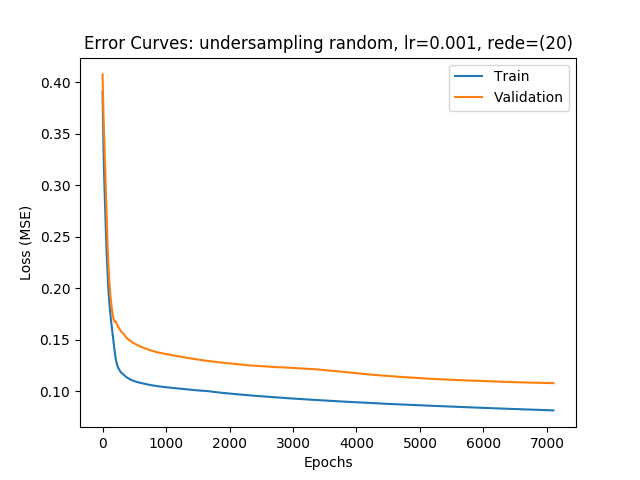

<IPython.core.display.Javascript object>


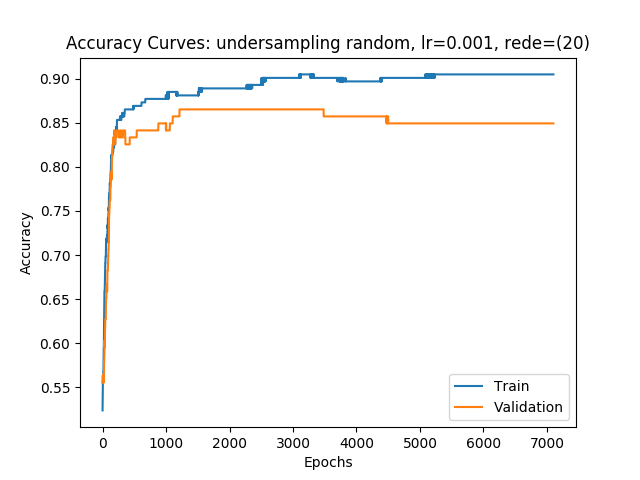

Matriz de confusão
[[1782  116]
 [   9   55]]

Train Loss:       0.0815
Validation Loss:  0.1079
Accuracy:         0.9363
MSE:              0.0637
AUROC:            0.9506


In [40]:
plot_training_error_curves(history, graficoName + "(20)")
plot_training_acc_curves(history, graficoName + "(20)")

## Fazer predições no conjunto de teste
y_pred = classifier.predict(X_test)
y_pred_class = classifier.predict_classes(X_test, verbose=0)

## Matriz de confusão
print('Matriz de confusão')
print(confusion_matrix(y_test, y_pred_class))

## Computar métricas de desempenho
losses = extract_final_losses(history)
print()
print("{metric:<18}{value:.4f}".format(metric="Train Loss:", value=losses['train_loss']))
print("{metric:<18}{value:.4f}".format(metric="Validation Loss:", value=losses['val_loss']))
print("{metric:<18}{value:.4f}".format(metric="Accuracy:", value=accuracy_score(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="MSE:", value=mean_squared_error(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="AUROC:", value=roc_auc_score(y_test, y_pred)))

## RNA 3 (10, 15)

In [41]:
# Aqui criamos o esboço da rede.
classifier = Sequential()

classifier.add(Dense(10, activation='relu', input_dim=6)) # camada escondida
classifier.add(Dense(15, activation='relu')) # camada escondida
classifier.add(Dense(1, activation='relu')) # 

sgd = optimizers.SGD(lr=learnRate)
classifier.compile(optimizer=sgd,
                   loss='mean_squared_error', # metrica de erro
                   metrics=['accuracy']) # metrica de sucesso

early_stopping = EarlyStopping(monitor='val_loss', patience=20)

history = classifier.fit(X_train, y_train,
                         epochs=100000, # quantidade de epocas que a rede neural vai executar
                         verbose=1,
                         shuffle=True, # utilizado para misturar as amostras a cada epoca
                         validation_data=(X_validation, y_validation),
                         callbacks=[early_stopping])

Train on 252 samples, validate on 126 samples
Epoch 1/100000
252/252 [==============================] - 0s - loss: 0.4339 - acc: 0.5159 - val_loss: 0.4382 - val_acc: 0.5317
Epoch 2/100000
252/252 [==============================] - 0s - loss: 0.4284 - acc: 0.5198 - val_loss: 0.4329 - val_acc: 0.5317
Epoch 3/100000
252/252 [==============================] - 0s - loss: 0.4220 - acc: 0.5238 - val_loss: 0.4275 - val_acc: 0.5317
Epoch 4/100000
252/252 [==============================] - 0s - loss: 0.4156 - acc: 0.5238 - val_loss: 0.4221 - val_acc: 0.5317
Epoch 5/100000
252/252 [==============================] - 0s - loss: 0.4089 - acc: 0.5198 - val_loss: 0.4163 - val_acc: 0.5397
Epoch 6/100000
252/252 [==============================] - 0s - loss: 0.4017 - acc: 0.5278 - val_loss: 0.4101 - val_acc: 0.5397
Epoch 7/100000
252/252 [==============================] - 0s - loss: 0.3942 - acc: 0.5278 - val_loss: 0.4027 - val_acc: 0.5397
Epoch 8/100000
252/252 [==============================] - 0s - lo

252/252 [==============================] - 0s - loss: 0.1399 - acc: 0.8373 - val_loss: 0.1907 - val_acc: 0.8016
Epoch 65/100000
252/252 [==============================] - 0s - loss: 0.1395 - acc: 0.8413 - val_loss: 0.1906 - val_acc: 0.8016
Epoch 66/100000
252/252 [==============================] - 0s - loss: 0.1392 - acc: 0.8413 - val_loss: 0.1905 - val_acc: 0.8016
Epoch 67/100000
252/252 [==============================] - 0s - loss: 0.1388 - acc: 0.8413 - val_loss: 0.1905 - val_acc: 0.8016
Epoch 68/100000
252/252 [==============================] - 0s - loss: 0.1385 - acc: 0.8413 - val_loss: 0.1904 - val_acc: 0.8016
Epoch 69/100000
252/252 [==============================] - 0s - loss: 0.1381 - acc: 0.8413 - val_loss: 0.1903 - val_acc: 0.8016
Epoch 70/100000
252/252 [==============================] - 0s - loss: 0.1378 - acc: 0.8413 - val_loss: 0.1903 - val_acc: 0.8016
Epoch 71/100000
252/252 [==============================] - 0s - loss: 0.1375 - acc: 0.8413 - val_loss: 0.1902 - val_acc:

252/252 [==============================] - 0s - loss: 0.1253 - acc: 0.8690 - val_loss: 0.1839 - val_acc: 0.8016
Epoch 128/100000
252/252 [==============================] - 0s - loss: 0.1252 - acc: 0.8690 - val_loss: 0.1837 - val_acc: 0.8016
Epoch 129/100000
252/252 [==============================] - 0s - loss: 0.1250 - acc: 0.8690 - val_loss: 0.1836 - val_acc: 0.8016
Epoch 130/100000
252/252 [==============================] - 0s - loss: 0.1248 - acc: 0.8690 - val_loss: 0.1835 - val_acc: 0.8016
Epoch 131/100000
252/252 [==============================] - 0s - loss: 0.1247 - acc: 0.8690 - val_loss: 0.1834 - val_acc: 0.8016
Epoch 132/100000
252/252 [==============================] - 0s - loss: 0.1245 - acc: 0.8690 - val_loss: 0.1832 - val_acc: 0.8016
Epoch 133/100000
252/252 [==============================] - 0s - loss: 0.1244 - acc: 0.8690 - val_loss: 0.1831 - val_acc: 0.8016
Epoch 134/100000
252/252 [==============================] - 0s - loss: 0.1243 - acc: 0.8690 - val_loss: 0.1830 - v

252/252 [==============================] - 0s - loss: 0.1181 - acc: 0.8810 - val_loss: 0.1763 - val_acc: 0.8333
Epoch 191/100000
252/252 [==============================] - 0s - loss: 0.1180 - acc: 0.8810 - val_loss: 0.1762 - val_acc: 0.8333
Epoch 192/100000
252/252 [==============================] - 0s - loss: 0.1179 - acc: 0.8810 - val_loss: 0.1761 - val_acc: 0.8333
Epoch 193/100000
252/252 [==============================] - 0s - loss: 0.1179 - acc: 0.8810 - val_loss: 0.1759 - val_acc: 0.8333
Epoch 194/100000
252/252 [==============================] - 0s - loss: 0.1177 - acc: 0.8810 - val_loss: 0.1758 - val_acc: 0.8333
Epoch 195/100000
252/252 [==============================] - 0s - loss: 0.1177 - acc: 0.8810 - val_loss: 0.1757 - val_acc: 0.8333
Epoch 196/100000
252/252 [==============================] - 0s - loss: 0.1176 - acc: 0.8810 - val_loss: 0.1756 - val_acc: 0.8333
Epoch 197/100000
252/252 [==============================] - 0s - loss: 0.1175 - acc: 0.8810 - val_loss: 0.1755 - v

252/252 [==============================] - 0s - loss: 0.1140 - acc: 0.8849 - val_loss: 0.1701 - val_acc: 0.8333
Epoch 254/100000
252/252 [==============================] - 0s - loss: 0.1139 - acc: 0.8849 - val_loss: 0.1701 - val_acc: 0.8254
Epoch 255/100000
252/252 [==============================] - 0s - loss: 0.1139 - acc: 0.8849 - val_loss: 0.1700 - val_acc: 0.8254
Epoch 256/100000
252/252 [==============================] - 0s - loss: 0.1138 - acc: 0.8849 - val_loss: 0.1699 - val_acc: 0.8254
Epoch 257/100000
252/252 [==============================] - 0s - loss: 0.1138 - acc: 0.8849 - val_loss: 0.1698 - val_acc: 0.8254
Epoch 258/100000
252/252 [==============================] - 0s - loss: 0.1138 - acc: 0.8849 - val_loss: 0.1697 - val_acc: 0.8254
Epoch 259/100000
252/252 [==============================] - 0s - loss: 0.1137 - acc: 0.8849 - val_loss: 0.1697 - val_acc: 0.8254
Epoch 260/100000
252/252 [==============================] - 0s - loss: 0.1136 - acc: 0.8849 - val_loss: 0.1696 - v

252/252 [==============================] - 0s - loss: 0.1113 - acc: 0.8849 - val_loss: 0.1656 - val_acc: 0.8254
Epoch 317/100000
252/252 [==============================] - 0s - loss: 0.1113 - acc: 0.8849 - val_loss: 0.1655 - val_acc: 0.8333
Epoch 318/100000
252/252 [==============================] - 0s - loss: 0.1113 - acc: 0.8849 - val_loss: 0.1655 - val_acc: 0.8333
Epoch 319/100000
252/252 [==============================] - 0s - loss: 0.1112 - acc: 0.8849 - val_loss: 0.1654 - val_acc: 0.8333
Epoch 320/100000
252/252 [==============================] - 0s - loss: 0.1112 - acc: 0.8849 - val_loss: 0.1653 - val_acc: 0.8333
Epoch 321/100000
252/252 [==============================] - 0s - loss: 0.1112 - acc: 0.8849 - val_loss: 0.1653 - val_acc: 0.8333
Epoch 322/100000
252/252 [==============================] - 0s - loss: 0.1111 - acc: 0.8849 - val_loss: 0.1652 - val_acc: 0.8333
Epoch 323/100000
252/252 [==============================] - 0s - loss: 0.1111 - acc: 0.8849 - val_loss: 0.1651 - v

252/252 [==============================] - 0s - loss: 0.1092 - acc: 0.8849 - val_loss: 0.1615 - val_acc: 0.8333
Epoch 380/100000
252/252 [==============================] - 0s - loss: 0.1092 - acc: 0.8889 - val_loss: 0.1615 - val_acc: 0.8333
Epoch 381/100000
252/252 [==============================] - 0s - loss: 0.1092 - acc: 0.8849 - val_loss: 0.1614 - val_acc: 0.8333
Epoch 382/100000
252/252 [==============================] - 0s - loss: 0.1091 - acc: 0.8889 - val_loss: 0.1614 - val_acc: 0.8333
Epoch 383/100000
252/252 [==============================] - 0s - loss: 0.1091 - acc: 0.8889 - val_loss: 0.1613 - val_acc: 0.8333
Epoch 384/100000
252/252 [==============================] - 0s - loss: 0.1091 - acc: 0.8849 - val_loss: 0.1613 - val_acc: 0.8333
Epoch 385/100000
252/252 [==============================] - 0s - loss: 0.1091 - acc: 0.8889 - val_loss: 0.1613 - val_acc: 0.8333
Epoch 386/100000
252/252 [==============================] - 0s - loss: 0.1090 - acc: 0.8849 - val_loss: 0.1612 - v

252/252 [==============================] - 0s - loss: 0.1077 - acc: 0.8849 - val_loss: 0.1584 - val_acc: 0.8333
Epoch 443/100000
252/252 [==============================] - 0s - loss: 0.1077 - acc: 0.8849 - val_loss: 0.1584 - val_acc: 0.8333
Epoch 444/100000
252/252 [==============================] - 0s - loss: 0.1077 - acc: 0.8849 - val_loss: 0.1583 - val_acc: 0.8333
Epoch 445/100000
252/252 [==============================] - 0s - loss: 0.1077 - acc: 0.8849 - val_loss: 0.1583 - val_acc: 0.8333
Epoch 446/100000
252/252 [==============================] - 0s - loss: 0.1077 - acc: 0.8849 - val_loss: 0.1582 - val_acc: 0.8333
Epoch 447/100000
252/252 [==============================] - 0s - loss: 0.1077 - acc: 0.8849 - val_loss: 0.1582 - val_acc: 0.8333
Epoch 448/100000
252/252 [==============================] - 0s - loss: 0.1076 - acc: 0.8849 - val_loss: 0.1582 - val_acc: 0.8333
Epoch 449/100000
252/252 [==============================] - 0s - loss: 0.1077 - acc: 0.8849 - val_loss: 0.1581 - v

252/252 [==============================] - 0s - loss: 0.1066 - acc: 0.8849 - val_loss: 0.1559 - val_acc: 0.8333
Epoch 506/100000
252/252 [==============================] - 0s - loss: 0.1066 - acc: 0.8889 - val_loss: 0.1558 - val_acc: 0.8333
Epoch 507/100000
252/252 [==============================] - 0s - loss: 0.1066 - acc: 0.8889 - val_loss: 0.1558 - val_acc: 0.8333
Epoch 508/100000
252/252 [==============================] - 0s - loss: 0.1065 - acc: 0.8889 - val_loss: 0.1557 - val_acc: 0.8333
Epoch 509/100000
252/252 [==============================] - 0s - loss: 0.1065 - acc: 0.8889 - val_loss: 0.1557 - val_acc: 0.8333
Epoch 510/100000
252/252 [==============================] - 0s - loss: 0.1065 - acc: 0.8889 - val_loss: 0.1557 - val_acc: 0.8333
Epoch 511/100000
252/252 [==============================] - 0s - loss: 0.1065 - acc: 0.8889 - val_loss: 0.1556 - val_acc: 0.8333
Epoch 512/100000
252/252 [==============================] - 0s - loss: 0.1065 - acc: 0.8889 - val_loss: 0.1556 - v

252/252 [==============================] - 0s - loss: 0.1056 - acc: 0.8889 - val_loss: 0.1540 - val_acc: 0.8333
Epoch 569/100000
252/252 [==============================] - 0s - loss: 0.1056 - acc: 0.8889 - val_loss: 0.1540 - val_acc: 0.8333
Epoch 570/100000
252/252 [==============================] - 0s - loss: 0.1056 - acc: 0.8889 - val_loss: 0.1540 - val_acc: 0.8333
Epoch 571/100000
252/252 [==============================] - 0s - loss: 0.1056 - acc: 0.8889 - val_loss: 0.1539 - val_acc: 0.8333
Epoch 572/100000
252/252 [==============================] - 0s - loss: 0.1056 - acc: 0.8889 - val_loss: 0.1539 - val_acc: 0.8333
Epoch 573/100000
252/252 [==============================] - 0s - loss: 0.1056 - acc: 0.8889 - val_loss: 0.1539 - val_acc: 0.8333
Epoch 574/100000
252/252 [==============================] - 0s - loss: 0.1055 - acc: 0.8889 - val_loss: 0.1539 - val_acc: 0.8333
Epoch 575/100000
252/252 [==============================] - 0s - loss: 0.1055 - acc: 0.8889 - val_loss: 0.1539 - v

252/252 [==============================] - 0s - loss: 0.1048 - acc: 0.8849 - val_loss: 0.1525 - val_acc: 0.8333
Epoch 632/100000
252/252 [==============================] - 0s - loss: 0.1048 - acc: 0.8810 - val_loss: 0.1524 - val_acc: 0.8333
Epoch 633/100000
252/252 [==============================] - 0s - loss: 0.1047 - acc: 0.8810 - val_loss: 0.1524 - val_acc: 0.8333
Epoch 634/100000
252/252 [==============================] - 0s - loss: 0.1048 - acc: 0.8849 - val_loss: 0.1524 - val_acc: 0.8333
Epoch 635/100000
252/252 [==============================] - 0s - loss: 0.1047 - acc: 0.8810 - val_loss: 0.1524 - val_acc: 0.8333
Epoch 636/100000
252/252 [==============================] - 0s - loss: 0.1047 - acc: 0.8849 - val_loss: 0.1524 - val_acc: 0.8333
Epoch 637/100000
252/252 [==============================] - 0s - loss: 0.1047 - acc: 0.8810 - val_loss: 0.1524 - val_acc: 0.8333
Epoch 638/100000
252/252 [==============================] - 0s - loss: 0.1047 - acc: 0.8810 - val_loss: 0.1523 - v

252/252 [==============================] - 0s - loss: 0.1040 - acc: 0.8810 - val_loss: 0.1511 - val_acc: 0.8333
Epoch 695/100000
252/252 [==============================] - 0s - loss: 0.1040 - acc: 0.8810 - val_loss: 0.1511 - val_acc: 0.8333
Epoch 696/100000
252/252 [==============================] - 0s - loss: 0.1040 - acc: 0.8810 - val_loss: 0.1511 - val_acc: 0.8333
Epoch 697/100000
252/252 [==============================] - 0s - loss: 0.1040 - acc: 0.8810 - val_loss: 0.1511 - val_acc: 0.8333
Epoch 698/100000
252/252 [==============================] - 0s - loss: 0.1040 - acc: 0.8810 - val_loss: 0.1511 - val_acc: 0.8333
Epoch 699/100000
252/252 [==============================] - 0s - loss: 0.1039 - acc: 0.8810 - val_loss: 0.1511 - val_acc: 0.8333
Epoch 700/100000
252/252 [==============================] - 0s - loss: 0.1039 - acc: 0.8810 - val_loss: 0.1510 - val_acc: 0.8333
Epoch 701/100000
252/252 [==============================] - 0s - loss: 0.1039 - acc: 0.8849 - val_loss: 0.1510 - v

252/252 [==============================] - 0s - loss: 0.1033 - acc: 0.8810 - val_loss: 0.1499 - val_acc: 0.8333
Epoch 758/100000
252/252 [==============================] - 0s - loss: 0.1033 - acc: 0.8810 - val_loss: 0.1499 - val_acc: 0.8333
Epoch 759/100000
252/252 [==============================] - 0s - loss: 0.1033 - acc: 0.8810 - val_loss: 0.1499 - val_acc: 0.8333
Epoch 760/100000
252/252 [==============================] - 0s - loss: 0.1033 - acc: 0.8810 - val_loss: 0.1499 - val_acc: 0.8333
Epoch 761/100000
252/252 [==============================] - 0s - loss: 0.1033 - acc: 0.8810 - val_loss: 0.1499 - val_acc: 0.8333
Epoch 762/100000
252/252 [==============================] - 0s - loss: 0.1033 - acc: 0.8810 - val_loss: 0.1498 - val_acc: 0.8333
Epoch 763/100000
252/252 [==============================] - 0s - loss: 0.1033 - acc: 0.8810 - val_loss: 0.1498 - val_acc: 0.8333
Epoch 764/100000
252/252 [==============================] - 0s - loss: 0.1032 - acc: 0.8810 - val_loss: 0.1498 - v

252/252 [==============================] - 0s - loss: 0.1027 - acc: 0.8810 - val_loss: 0.1487 - val_acc: 0.8333
Epoch 821/100000
252/252 [==============================] - 0s - loss: 0.1027 - acc: 0.8810 - val_loss: 0.1486 - val_acc: 0.8333
Epoch 822/100000
252/252 [==============================] - 0s - loss: 0.1027 - acc: 0.8810 - val_loss: 0.1486 - val_acc: 0.8333
Epoch 823/100000
252/252 [==============================] - 0s - loss: 0.1027 - acc: 0.8810 - val_loss: 0.1486 - val_acc: 0.8333
Epoch 824/100000
252/252 [==============================] - 0s - loss: 0.1026 - acc: 0.8810 - val_loss: 0.1486 - val_acc: 0.8333
Epoch 825/100000
252/252 [==============================] - 0s - loss: 0.1026 - acc: 0.8810 - val_loss: 0.1486 - val_acc: 0.8333
Epoch 826/100000
252/252 [==============================] - 0s - loss: 0.1026 - acc: 0.8810 - val_loss: 0.1486 - val_acc: 0.8333
Epoch 827/100000
252/252 [==============================] - 0s - loss: 0.1026 - acc: 0.8810 - val_loss: 0.1486 - v

252/252 [==============================] - 0s - loss: 0.1021 - acc: 0.8810 - val_loss: 0.1475 - val_acc: 0.8333
Epoch 884/100000
252/252 [==============================] - 0s - loss: 0.1021 - acc: 0.8810 - val_loss: 0.1474 - val_acc: 0.8333
Epoch 885/100000
252/252 [==============================] - 0s - loss: 0.1021 - acc: 0.8810 - val_loss: 0.1474 - val_acc: 0.8333
Epoch 886/100000
252/252 [==============================] - 0s - loss: 0.1021 - acc: 0.8810 - val_loss: 0.1474 - val_acc: 0.8333
Epoch 887/100000
252/252 [==============================] - 0s - loss: 0.1021 - acc: 0.8810 - val_loss: 0.1473 - val_acc: 0.8333
Epoch 888/100000
252/252 [==============================] - 0s - loss: 0.1021 - acc: 0.8810 - val_loss: 0.1473 - val_acc: 0.8333
Epoch 889/100000
252/252 [==============================] - 0s - loss: 0.1020 - acc: 0.8810 - val_loss: 0.1473 - val_acc: 0.8333
Epoch 890/100000
252/252 [==============================] - 0s - loss: 0.1021 - acc: 0.8810 - val_loss: 0.1473 - v

252/252 [==============================] - 0s - loss: 0.1016 - acc: 0.8810 - val_loss: 0.1463 - val_acc: 0.8333
Epoch 947/100000
252/252 [==============================] - 0s - loss: 0.1016 - acc: 0.8810 - val_loss: 0.1463 - val_acc: 0.8333
Epoch 948/100000
252/252 [==============================] - 0s - loss: 0.1015 - acc: 0.8810 - val_loss: 0.1463 - val_acc: 0.8333
Epoch 949/100000
252/252 [==============================] - 0s - loss: 0.1015 - acc: 0.8810 - val_loss: 0.1462 - val_acc: 0.8333
Epoch 950/100000
252/252 [==============================] - 0s - loss: 0.1015 - acc: 0.8810 - val_loss: 0.1462 - val_acc: 0.8333
Epoch 951/100000
252/252 [==============================] - 0s - loss: 0.1015 - acc: 0.8810 - val_loss: 0.1462 - val_acc: 0.8333
Epoch 952/100000
252/252 [==============================] - 0s - loss: 0.1015 - acc: 0.8810 - val_loss: 0.1462 - val_acc: 0.8333
Epoch 953/100000
252/252 [==============================] - 0s - loss: 0.1015 - acc: 0.8810 - val_loss: 0.1462 - v

252/252 [==============================] - 0s - loss: 0.1010 - acc: 0.8810 - val_loss: 0.1453 - val_acc: 0.8333
Epoch 1010/100000
252/252 [==============================] - 0s - loss: 0.1010 - acc: 0.8810 - val_loss: 0.1453 - val_acc: 0.8333
Epoch 1011/100000
252/252 [==============================] - 0s - loss: 0.1010 - acc: 0.8810 - val_loss: 0.1453 - val_acc: 0.8333
Epoch 1012/100000
252/252 [==============================] - 0s - loss: 0.1010 - acc: 0.8810 - val_loss: 0.1453 - val_acc: 0.8333
Epoch 1013/100000
252/252 [==============================] - 0s - loss: 0.1010 - acc: 0.8810 - val_loss: 0.1453 - val_acc: 0.8333
Epoch 1014/100000
252/252 [==============================] - 0s - loss: 0.1010 - acc: 0.8810 - val_loss: 0.1453 - val_acc: 0.8333
Epoch 1015/100000
252/252 [==============================] - 0s - loss: 0.1010 - acc: 0.8810 - val_loss: 0.1452 - val_acc: 0.8333
Epoch 1016/100000
252/252 [==============================] - 0s - loss: 0.1010 - acc: 0.8810 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.1005 - acc: 0.8770 - val_loss: 0.1445 - val_acc: 0.8333
Epoch 1073/100000
252/252 [==============================] - 0s - loss: 0.1005 - acc: 0.8770 - val_loss: 0.1445 - val_acc: 0.8333
Epoch 1074/100000
252/252 [==============================] - 0s - loss: 0.1005 - acc: 0.8810 - val_loss: 0.1444 - val_acc: 0.8333
Epoch 1075/100000
252/252 [==============================] - 0s - loss: 0.1005 - acc: 0.8810 - val_loss: 0.1444 - val_acc: 0.8333
Epoch 1076/100000
252/252 [==============================] - 0s - loss: 0.1005 - acc: 0.8770 - val_loss: 0.1444 - val_acc: 0.8333
Epoch 1077/100000
252/252 [==============================] - 0s - loss: 0.1005 - acc: 0.8770 - val_loss: 0.1444 - val_acc: 0.8333
Epoch 1078/100000
252/252 [==============================] - 0s - loss: 0.1005 - acc: 0.8770 - val_loss: 0.1444 - val_acc: 0.8333
Epoch 1079/100000
252/252 [==============================] - 0s - loss: 0.1005 - acc: 0.8770 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.1001 - acc: 0.8770 - val_loss: 0.1436 - val_acc: 0.8333
Epoch 1136/100000
252/252 [==============================] - 0s - loss: 0.1001 - acc: 0.8810 - val_loss: 0.1436 - val_acc: 0.8333
Epoch 1137/100000
252/252 [==============================] - 0s - loss: 0.1001 - acc: 0.8770 - val_loss: 0.1436 - val_acc: 0.8333
Epoch 1138/100000
252/252 [==============================] - 0s - loss: 0.1001 - acc: 0.8810 - val_loss: 0.1436 - val_acc: 0.8333
Epoch 1139/100000
252/252 [==============================] - 0s - loss: 0.1001 - acc: 0.8770 - val_loss: 0.1436 - val_acc: 0.8333
Epoch 1140/100000
252/252 [==============================] - 0s - loss: 0.1000 - acc: 0.8810 - val_loss: 0.1436 - val_acc: 0.8333
Epoch 1141/100000
252/252 [==============================] - 0s - loss: 0.1000 - acc: 0.8770 - val_loss: 0.1435 - val_acc: 0.8333
Epoch 1142/100000
252/252 [==============================] - 0s - loss: 0.1000 - acc: 0.8770 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0996 - acc: 0.8849 - val_loss: 0.1429 - val_acc: 0.8333
Epoch 1199/100000
252/252 [==============================] - 0s - loss: 0.0996 - acc: 0.8849 - val_loss: 0.1429 - val_acc: 0.8333
Epoch 1200/100000
252/252 [==============================] - 0s - loss: 0.0996 - acc: 0.8849 - val_loss: 0.1429 - val_acc: 0.8333
Epoch 1201/100000
252/252 [==============================] - 0s - loss: 0.0996 - acc: 0.8849 - val_loss: 0.1429 - val_acc: 0.8333
Epoch 1202/100000
252/252 [==============================] - 0s - loss: 0.0997 - acc: 0.8849 - val_loss: 0.1428 - val_acc: 0.8333
Epoch 1203/100000
252/252 [==============================] - 0s - loss: 0.0996 - acc: 0.8849 - val_loss: 0.1428 - val_acc: 0.8333
Epoch 1204/100000
252/252 [==============================] - 0s - loss: 0.0996 - acc: 0.8849 - val_loss: 0.1428 - val_acc: 0.8333
Epoch 1205/100000
252/252 [==============================] - 0s - loss: 0.0996 - acc: 0.8849 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0992 - acc: 0.8849 - val_loss: 0.1422 - val_acc: 0.8333
Epoch 1262/100000
252/252 [==============================] - 0s - loss: 0.0992 - acc: 0.8849 - val_loss: 0.1422 - val_acc: 0.8333
Epoch 1263/100000
252/252 [==============================] - 0s - loss: 0.0992 - acc: 0.8849 - val_loss: 0.1422 - val_acc: 0.8333
Epoch 1264/100000
252/252 [==============================] - 0s - loss: 0.0992 - acc: 0.8849 - val_loss: 0.1422 - val_acc: 0.8333
Epoch 1265/100000
252/252 [==============================] - 0s - loss: 0.0992 - acc: 0.8849 - val_loss: 0.1422 - val_acc: 0.8333
Epoch 1266/100000
252/252 [==============================] - 0s - loss: 0.0992 - acc: 0.8849 - val_loss: 0.1422 - val_acc: 0.8333
Epoch 1267/100000
252/252 [==============================] - 0s - loss: 0.0992 - acc: 0.8849 - val_loss: 0.1421 - val_acc: 0.8333
Epoch 1268/100000
252/252 [==============================] - 0s - loss: 0.0992 - acc: 0.8849 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0988 - acc: 0.8810 - val_loss: 0.1416 - val_acc: 0.8413
Epoch 1325/100000
252/252 [==============================] - 0s - loss: 0.0988 - acc: 0.8849 - val_loss: 0.1416 - val_acc: 0.8413
Epoch 1326/100000
252/252 [==============================] - 0s - loss: 0.0988 - acc: 0.8849 - val_loss: 0.1416 - val_acc: 0.8413
Epoch 1327/100000
252/252 [==============================] - 0s - loss: 0.0988 - acc: 0.8849 - val_loss: 0.1416 - val_acc: 0.8413
Epoch 1328/100000
252/252 [==============================] - 0s - loss: 0.0988 - acc: 0.8849 - val_loss: 0.1415 - val_acc: 0.8413
Epoch 1329/100000
252/252 [==============================] - 0s - loss: 0.0988 - acc: 0.8849 - val_loss: 0.1415 - val_acc: 0.8413
Epoch 1330/100000
252/252 [==============================] - 0s - loss: 0.0988 - acc: 0.8849 - val_loss: 0.1415 - val_acc: 0.8413
Epoch 1331/100000
252/252 [==============================] - 0s - loss: 0.0988 - acc: 0.8849 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0984 - acc: 0.8849 - val_loss: 0.1410 - val_acc: 0.8413
Epoch 1388/100000
252/252 [==============================] - 0s - loss: 0.0985 - acc: 0.8810 - val_loss: 0.1410 - val_acc: 0.8413
Epoch 1389/100000
252/252 [==============================] - 0s - loss: 0.0984 - acc: 0.8849 - val_loss: 0.1410 - val_acc: 0.8413
Epoch 1390/100000
252/252 [==============================] - 0s - loss: 0.0984 - acc: 0.8849 - val_loss: 0.1410 - val_acc: 0.8413
Epoch 1391/100000
252/252 [==============================] - 0s - loss: 0.0984 - acc: 0.8849 - val_loss: 0.1410 - val_acc: 0.8413
Epoch 1392/100000
252/252 [==============================] - 0s - loss: 0.0984 - acc: 0.8810 - val_loss: 0.1410 - val_acc: 0.8413
Epoch 1393/100000
252/252 [==============================] - 0s - loss: 0.0984 - acc: 0.8810 - val_loss: 0.1410 - val_acc: 0.8413
Epoch 1394/100000
252/252 [==============================] - 0s - loss: 0.0984 - acc: 0.8849 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0981 - acc: 0.8849 - val_loss: 0.1404 - val_acc: 0.8413
Epoch 1451/100000
252/252 [==============================] - 0s - loss: 0.0980 - acc: 0.8849 - val_loss: 0.1404 - val_acc: 0.8413
Epoch 1452/100000
252/252 [==============================] - 0s - loss: 0.0980 - acc: 0.8889 - val_loss: 0.1404 - val_acc: 0.8413
Epoch 1453/100000
252/252 [==============================] - 0s - loss: 0.0981 - acc: 0.8929 - val_loss: 0.1403 - val_acc: 0.8413
Epoch 1454/100000
252/252 [==============================] - 0s - loss: 0.0980 - acc: 0.8889 - val_loss: 0.1403 - val_acc: 0.8413
Epoch 1455/100000
252/252 [==============================] - 0s - loss: 0.0980 - acc: 0.8889 - val_loss: 0.1403 - val_acc: 0.8413
Epoch 1456/100000
252/252 [==============================] - 0s - loss: 0.0980 - acc: 0.8889 - val_loss: 0.1403 - val_acc: 0.8413
Epoch 1457/100000
252/252 [==============================] - 0s - loss: 0.0980 - acc: 0.8889 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0977 - acc: 0.8889 - val_loss: 0.1398 - val_acc: 0.8413
Epoch 1514/100000
252/252 [==============================] - 0s - loss: 0.0977 - acc: 0.8889 - val_loss: 0.1398 - val_acc: 0.8413
Epoch 1515/100000
252/252 [==============================] - 0s - loss: 0.0977 - acc: 0.8889 - val_loss: 0.1397 - val_acc: 0.8413
Epoch 1516/100000
252/252 [==============================] - 0s - loss: 0.0977 - acc: 0.8889 - val_loss: 0.1397 - val_acc: 0.8413
Epoch 1517/100000
252/252 [==============================] - 0s - loss: 0.0977 - acc: 0.8889 - val_loss: 0.1397 - val_acc: 0.8413
Epoch 1518/100000
252/252 [==============================] - 0s - loss: 0.0976 - acc: 0.8889 - val_loss: 0.1397 - val_acc: 0.8413
Epoch 1519/100000
252/252 [==============================] - 0s - loss: 0.0977 - acc: 0.8889 - val_loss: 0.1397 - val_acc: 0.8413
Epoch 1520/100000
252/252 [==============================] - 0s - loss: 0.0976 - acc: 0.8889 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0973 - acc: 0.8889 - val_loss: 0.1392 - val_acc: 0.8413
Epoch 1577/100000
252/252 [==============================] - 0s - loss: 0.0973 - acc: 0.8889 - val_loss: 0.1392 - val_acc: 0.8413
Epoch 1578/100000
252/252 [==============================] - 0s - loss: 0.0973 - acc: 0.8889 - val_loss: 0.1392 - val_acc: 0.8413
Epoch 1579/100000
252/252 [==============================] - 0s - loss: 0.0973 - acc: 0.8889 - val_loss: 0.1392 - val_acc: 0.8413
Epoch 1580/100000
252/252 [==============================] - 0s - loss: 0.0973 - acc: 0.8889 - val_loss: 0.1392 - val_acc: 0.8413
Epoch 1581/100000
252/252 [==============================] - 0s - loss: 0.0973 - acc: 0.8889 - val_loss: 0.1392 - val_acc: 0.8413
Epoch 1582/100000
252/252 [==============================] - 0s - loss: 0.0973 - acc: 0.8889 - val_loss: 0.1392 - val_acc: 0.8413
Epoch 1583/100000
252/252 [==============================] - 0s - loss: 0.0973 - acc: 0.8889 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0969 - acc: 0.8889 - val_loss: 0.1386 - val_acc: 0.8413
Epoch 1640/100000
252/252 [==============================] - 0s - loss: 0.0969 - acc: 0.8889 - val_loss: 0.1386 - val_acc: 0.8413
Epoch 1641/100000
252/252 [==============================] - 0s - loss: 0.0969 - acc: 0.8889 - val_loss: 0.1386 - val_acc: 0.8413
Epoch 1642/100000
252/252 [==============================] - 0s - loss: 0.0969 - acc: 0.8889 - val_loss: 0.1386 - val_acc: 0.8413
Epoch 1643/100000
252/252 [==============================] - 0s - loss: 0.0969 - acc: 0.8889 - val_loss: 0.1386 - val_acc: 0.8413
Epoch 1644/100000
252/252 [==============================] - 0s - loss: 0.0969 - acc: 0.8889 - val_loss: 0.1386 - val_acc: 0.8413
Epoch 1645/100000
252/252 [==============================] - 0s - loss: 0.0969 - acc: 0.8889 - val_loss: 0.1386 - val_acc: 0.8413
Epoch 1646/100000
252/252 [==============================] - 0s - loss: 0.0969 - acc: 0.8889 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0965 - acc: 0.8929 - val_loss: 0.1383 - val_acc: 0.8413
Epoch 1702/100000
252/252 [==============================] - 0s - loss: 0.0966 - acc: 0.8929 - val_loss: 0.1383 - val_acc: 0.8413
Epoch 1703/100000
252/252 [==============================] - 0s - loss: 0.0965 - acc: 0.8929 - val_loss: 0.1382 - val_acc: 0.8413
Epoch 1704/100000
252/252 [==============================] - 0s - loss: 0.0966 - acc: 0.8929 - val_loss: 0.1382 - val_acc: 0.8413
Epoch 1705/100000
252/252 [==============================] - 0s - loss: 0.0965 - acc: 0.8929 - val_loss: 0.1382 - val_acc: 0.8413
Epoch 1706/100000
252/252 [==============================] - 0s - loss: 0.0965 - acc: 0.8929 - val_loss: 0.1382 - val_acc: 0.8413
Epoch 1707/100000
252/252 [==============================] - 0s - loss: 0.0965 - acc: 0.8929 - val_loss: 0.1382 - val_acc: 0.8413
Epoch 1708/100000
252/252 [==============================] - 0s - loss: 0.0965 - acc: 0.8929 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0962 - acc: 0.8929 - val_loss: 0.1379 - val_acc: 0.8413
Epoch 1764/100000
252/252 [==============================] - 0s - loss: 0.0962 - acc: 0.8929 - val_loss: 0.1379 - val_acc: 0.8413
Epoch 1765/100000
252/252 [==============================] - 0s - loss: 0.0962 - acc: 0.8929 - val_loss: 0.1379 - val_acc: 0.8413
Epoch 1766/100000
252/252 [==============================] - 0s - loss: 0.0962 - acc: 0.8929 - val_loss: 0.1379 - val_acc: 0.8413
Epoch 1767/100000
252/252 [==============================] - 0s - loss: 0.0962 - acc: 0.8929 - val_loss: 0.1379 - val_acc: 0.8413
Epoch 1768/100000
252/252 [==============================] - 0s - loss: 0.0962 - acc: 0.8929 - val_loss: 0.1379 - val_acc: 0.8413
Epoch 1769/100000
252/252 [==============================] - 0s - loss: 0.0962 - acc: 0.8929 - val_loss: 0.1378 - val_acc: 0.8413
Epoch 1770/100000
252/252 [==============================] - 0s - loss: 0.0961 - acc: 0.8929 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0958 - acc: 0.8929 - val_loss: 0.1374 - val_acc: 0.8413
Epoch 1827/100000
252/252 [==============================] - 0s - loss: 0.0958 - acc: 0.8929 - val_loss: 0.1374 - val_acc: 0.8413
Epoch 1828/100000
252/252 [==============================] - 0s - loss: 0.0958 - acc: 0.8929 - val_loss: 0.1374 - val_acc: 0.8413
Epoch 1829/100000
252/252 [==============================] - 0s - loss: 0.0958 - acc: 0.8929 - val_loss: 0.1374 - val_acc: 0.8413
Epoch 1830/100000
252/252 [==============================] - 0s - loss: 0.0958 - acc: 0.8929 - val_loss: 0.1374 - val_acc: 0.8413
Epoch 1831/100000
252/252 [==============================] - 0s - loss: 0.0958 - acc: 0.8929 - val_loss: 0.1374 - val_acc: 0.8413
Epoch 1832/100000
252/252 [==============================] - 0s - loss: 0.0958 - acc: 0.8929 - val_loss: 0.1373 - val_acc: 0.8413
Epoch 1833/100000
252/252 [==============================] - 0s - loss: 0.0958 - acc: 0.8929 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0954 - acc: 0.8929 - val_loss: 0.1370 - val_acc: 0.8413
Epoch 1890/100000
252/252 [==============================] - 0s - loss: 0.0954 - acc: 0.8929 - val_loss: 0.1370 - val_acc: 0.8413
Epoch 1891/100000
252/252 [==============================] - 0s - loss: 0.0954 - acc: 0.8929 - val_loss: 0.1370 - val_acc: 0.8413
Epoch 1892/100000
252/252 [==============================] - 0s - loss: 0.0954 - acc: 0.8929 - val_loss: 0.1370 - val_acc: 0.8413
Epoch 1893/100000
252/252 [==============================] - 0s - loss: 0.0954 - acc: 0.8929 - val_loss: 0.1370 - val_acc: 0.8413
Epoch 1894/100000
252/252 [==============================] - 0s - loss: 0.0954 - acc: 0.8929 - val_loss: 0.1370 - val_acc: 0.8413
Epoch 1895/100000
252/252 [==============================] - 0s - loss: 0.0954 - acc: 0.8929 - val_loss: 0.1370 - val_acc: 0.8413
Epoch 1896/100000
252/252 [==============================] - 0s - loss: 0.0954 - acc: 0.8929 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0951 - acc: 0.8929 - val_loss: 0.1366 - val_acc: 0.8413
Epoch 1952/100000
252/252 [==============================] - 0s - loss: 0.0951 - acc: 0.8929 - val_loss: 0.1366 - val_acc: 0.8413
Epoch 1953/100000
252/252 [==============================] - 0s - loss: 0.0951 - acc: 0.8929 - val_loss: 0.1366 - val_acc: 0.8413
Epoch 1954/100000
252/252 [==============================] - 0s - loss: 0.0951 - acc: 0.8929 - val_loss: 0.1366 - val_acc: 0.8413
Epoch 1955/100000
252/252 [==============================] - 0s - loss: 0.0951 - acc: 0.8929 - val_loss: 0.1366 - val_acc: 0.8413
Epoch 1956/100000
252/252 [==============================] - 0s - loss: 0.0951 - acc: 0.8929 - val_loss: 0.1366 - val_acc: 0.8413
Epoch 1957/100000
252/252 [==============================] - 0s - loss: 0.0951 - acc: 0.8929 - val_loss: 0.1366 - val_acc: 0.8413
Epoch 1958/100000
252/252 [==============================] - 0s - loss: 0.0951 - acc: 0.8929 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0948 - acc: 0.8929 - val_loss: 0.1363 - val_acc: 0.8413
Epoch 2015/100000
252/252 [==============================] - 0s - loss: 0.0948 - acc: 0.8929 - val_loss: 0.1363 - val_acc: 0.8413
Epoch 2016/100000
252/252 [==============================] - 0s - loss: 0.0948 - acc: 0.8929 - val_loss: 0.1363 - val_acc: 0.8413
Epoch 2017/100000
252/252 [==============================] - 0s - loss: 0.0947 - acc: 0.8929 - val_loss: 0.1363 - val_acc: 0.8413
Epoch 2018/100000
252/252 [==============================] - 0s - loss: 0.0947 - acc: 0.8929 - val_loss: 0.1363 - val_acc: 0.8413
Epoch 2019/100000
252/252 [==============================] - 0s - loss: 0.0947 - acc: 0.8929 - val_loss: 0.1363 - val_acc: 0.8413
Epoch 2020/100000
252/252 [==============================] - 0s - loss: 0.0947 - acc: 0.8929 - val_loss: 0.1363 - val_acc: 0.8413
Epoch 2021/100000
252/252 [==============================] - 0s - loss: 0.0947 - acc: 0.8929 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0945 - acc: 0.8929 - val_loss: 0.1359 - val_acc: 0.8413
Epoch 2078/100000
252/252 [==============================] - 0s - loss: 0.0944 - acc: 0.8929 - val_loss: 0.1359 - val_acc: 0.8413
Epoch 2079/100000
252/252 [==============================] - 0s - loss: 0.0945 - acc: 0.8929 - val_loss: 0.1359 - val_acc: 0.8413
Epoch 2080/100000
252/252 [==============================] - 0s - loss: 0.0944 - acc: 0.8929 - val_loss: 0.1359 - val_acc: 0.8413
Epoch 2081/100000
252/252 [==============================] - 0s - loss: 0.0944 - acc: 0.8929 - val_loss: 0.1359 - val_acc: 0.8413
Epoch 2082/100000
252/252 [==============================] - 0s - loss: 0.0944 - acc: 0.8929 - val_loss: 0.1359 - val_acc: 0.8413
Epoch 2083/100000
252/252 [==============================] - 0s - loss: 0.0944 - acc: 0.8929 - val_loss: 0.1359 - val_acc: 0.8413
Epoch 2084/100000
252/252 [==============================] - 0s - loss: 0.0944 - acc: 0.8929 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0941 - acc: 0.8929 - val_loss: 0.1356 - val_acc: 0.8413
Epoch 2141/100000
252/252 [==============================] - 0s - loss: 0.0941 - acc: 0.8929 - val_loss: 0.1356 - val_acc: 0.8413
Epoch 2142/100000
252/252 [==============================] - 0s - loss: 0.0941 - acc: 0.8929 - val_loss: 0.1356 - val_acc: 0.8413
Epoch 2143/100000
252/252 [==============================] - 0s - loss: 0.0941 - acc: 0.8929 - val_loss: 0.1356 - val_acc: 0.8413
Epoch 2144/100000
252/252 [==============================] - 0s - loss: 0.0941 - acc: 0.8929 - val_loss: 0.1356 - val_acc: 0.8413
Epoch 2145/100000
252/252 [==============================] - 0s - loss: 0.0941 - acc: 0.8929 - val_loss: 0.1356 - val_acc: 0.8413
Epoch 2146/100000
252/252 [==============================] - 0s - loss: 0.0941 - acc: 0.8929 - val_loss: 0.1355 - val_acc: 0.8413
Epoch 2147/100000
252/252 [==============================] - 0s - loss: 0.0941 - acc: 0.8929 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0938 - acc: 0.8929 - val_loss: 0.1352 - val_acc: 0.8413
Epoch 2204/100000
252/252 [==============================] - 0s - loss: 0.0938 - acc: 0.8929 - val_loss: 0.1352 - val_acc: 0.8413
Epoch 2205/100000
252/252 [==============================] - 0s - loss: 0.0938 - acc: 0.8929 - val_loss: 0.1352 - val_acc: 0.8413
Epoch 2206/100000
252/252 [==============================] - 0s - loss: 0.0938 - acc: 0.8929 - val_loss: 0.1352 - val_acc: 0.8413
Epoch 2207/100000
252/252 [==============================] - 0s - loss: 0.0938 - acc: 0.8929 - val_loss: 0.1352 - val_acc: 0.8413
Epoch 2208/100000
252/252 [==============================] - 0s - loss: 0.0938 - acc: 0.8929 - val_loss: 0.1352 - val_acc: 0.8413
Epoch 2209/100000
252/252 [==============================] - 0s - loss: 0.0938 - acc: 0.8929 - val_loss: 0.1352 - val_acc: 0.8413
Epoch 2210/100000
252/252 [==============================] - 0s - loss: 0.0938 - acc: 0.8929 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0935 - acc: 0.8929 - val_loss: 0.1349 - val_acc: 0.8413
Epoch 2267/100000
252/252 [==============================] - 0s - loss: 0.0935 - acc: 0.8929 - val_loss: 0.1349 - val_acc: 0.8413
Epoch 2268/100000
252/252 [==============================] - 0s - loss: 0.0935 - acc: 0.8929 - val_loss: 0.1349 - val_acc: 0.8413
Epoch 2269/100000
252/252 [==============================] - 0s - loss: 0.0935 - acc: 0.8929 - val_loss: 0.1349 - val_acc: 0.8413
Epoch 2270/100000
252/252 [==============================] - 0s - loss: 0.0935 - acc: 0.8929 - val_loss: 0.1349 - val_acc: 0.8413
Epoch 2271/100000
252/252 [==============================] - 0s - loss: 0.0935 - acc: 0.8929 - val_loss: 0.1349 - val_acc: 0.8413
Epoch 2272/100000
252/252 [==============================] - 0s - loss: 0.0935 - acc: 0.8929 - val_loss: 0.1349 - val_acc: 0.8413
Epoch 2273/100000
252/252 [==============================] - 0s - loss: 0.0935 - acc: 0.8929 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0932 - acc: 0.8929 - val_loss: 0.1345 - val_acc: 0.8413
Epoch 2330/100000
252/252 [==============================] - 0s - loss: 0.0932 - acc: 0.8929 - val_loss: 0.1345 - val_acc: 0.8413
Epoch 2331/100000
252/252 [==============================] - 0s - loss: 0.0932 - acc: 0.8929 - val_loss: 0.1345 - val_acc: 0.8413
Epoch 2332/100000
252/252 [==============================] - ETA: 0s - loss: 0.1015 - acc: 0.843 - 0s - loss: 0.0932 - acc: 0.8929 - val_loss: 0.1345 - val_acc: 0.8413
Epoch 2333/100000
252/252 [==============================] - 0s - loss: 0.0932 - acc: 0.8929 - val_loss: 0.1345 - val_acc: 0.8413
Epoch 2334/100000
252/252 [==============================] - 0s - loss: 0.0932 - acc: 0.8929 - val_loss: 0.1345 - val_acc: 0.8413
Epoch 2335/100000
252/252 [==============================] - 0s - loss: 0.0932 - acc: 0.8929 - val_loss: 0.1345 - val_acc: 0.8413
Epoch 2336/100000
252/252 [==============================] - 0s - loss

252/252 [==============================] - 0s - loss: 0.0929 - acc: 0.8929 - val_loss: 0.1341 - val_acc: 0.8413
Epoch 2392/100000
252/252 [==============================] - 0s - loss: 0.0929 - acc: 0.8929 - val_loss: 0.1341 - val_acc: 0.8413
Epoch 2393/100000
252/252 [==============================] - 0s - loss: 0.0930 - acc: 0.8929 - val_loss: 0.1341 - val_acc: 0.8413
Epoch 2394/100000
252/252 [==============================] - 0s - loss: 0.0929 - acc: 0.8929 - val_loss: 0.1341 - val_acc: 0.8413
Epoch 2395/100000
252/252 [==============================] - 0s - loss: 0.0929 - acc: 0.8929 - val_loss: 0.1341 - val_acc: 0.8413
Epoch 2396/100000
252/252 [==============================] - 0s - loss: 0.0929 - acc: 0.8929 - val_loss: 0.1341 - val_acc: 0.8413
Epoch 2397/100000
252/252 [==============================] - 0s - loss: 0.0929 - acc: 0.8929 - val_loss: 0.1341 - val_acc: 0.8413
Epoch 2398/100000
252/252 [==============================] - 0s - loss: 0.0929 - acc: 0.8929 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0927 - acc: 0.8929 - val_loss: 0.1338 - val_acc: 0.8413
Epoch 2455/100000
252/252 [==============================] - 0s - loss: 0.0927 - acc: 0.8929 - val_loss: 0.1338 - val_acc: 0.8413
Epoch 2456/100000
252/252 [==============================] - 0s - loss: 0.0927 - acc: 0.8929 - val_loss: 0.1338 - val_acc: 0.8413
Epoch 2457/100000
252/252 [==============================] - 0s - loss: 0.0927 - acc: 0.8929 - val_loss: 0.1337 - val_acc: 0.8413
Epoch 2458/100000
252/252 [==============================] - 0s - loss: 0.0926 - acc: 0.8929 - val_loss: 0.1337 - val_acc: 0.8413
Epoch 2459/100000
252/252 [==============================] - 0s - loss: 0.0926 - acc: 0.8929 - val_loss: 0.1337 - val_acc: 0.8413
Epoch 2460/100000
252/252 [==============================] - 0s - loss: 0.0926 - acc: 0.8929 - val_loss: 0.1337 - val_acc: 0.8413
Epoch 2461/100000
252/252 [==============================] - 0s - loss: 0.0926 - acc: 0.8929 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0924 - acc: 0.8929 - val_loss: 0.1334 - val_acc: 0.8413
Epoch 2517/100000
252/252 [==============================] - 0s - loss: 0.0924 - acc: 0.8929 - val_loss: 0.1334 - val_acc: 0.8413
Epoch 2518/100000
252/252 [==============================] - 0s - loss: 0.0924 - acc: 0.8929 - val_loss: 0.1333 - val_acc: 0.8413
Epoch 2519/100000
252/252 [==============================] - 0s - loss: 0.0924 - acc: 0.8929 - val_loss: 0.1333 - val_acc: 0.8413
Epoch 2520/100000
252/252 [==============================] - 0s - loss: 0.0924 - acc: 0.8929 - val_loss: 0.1333 - val_acc: 0.8413
Epoch 2521/100000
252/252 [==============================] - 0s - loss: 0.0924 - acc: 0.8929 - val_loss: 0.1333 - val_acc: 0.8413
Epoch 2522/100000
252/252 [==============================] - 0s - loss: 0.0924 - acc: 0.8929 - val_loss: 0.1333 - val_acc: 0.8413
Epoch 2523/100000
252/252 [==============================] - 0s - loss: 0.0923 - acc: 0.8929 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0921 - acc: 0.8929 - val_loss: 0.1329 - val_acc: 0.8413
Epoch 2580/100000
252/252 [==============================] - 0s - loss: 0.0921 - acc: 0.8929 - val_loss: 0.1330 - val_acc: 0.8413
Epoch 2581/100000
252/252 [==============================] - 0s - loss: 0.0921 - acc: 0.8929 - val_loss: 0.1330 - val_acc: 0.8413
Epoch 2582/100000
252/252 [==============================] - 0s - loss: 0.0921 - acc: 0.8929 - val_loss: 0.1330 - val_acc: 0.8413
Epoch 2583/100000
252/252 [==============================] - 0s - loss: 0.0921 - acc: 0.8929 - val_loss: 0.1330 - val_acc: 0.8413
Epoch 2584/100000
252/252 [==============================] - 0s - loss: 0.0921 - acc: 0.8929 - val_loss: 0.1330 - val_acc: 0.8413
Epoch 2585/100000
252/252 [==============================] - 0s - loss: 0.0921 - acc: 0.8929 - val_loss: 0.1330 - val_acc: 0.8413
Epoch 2586/100000
252/252 [==============================] - 0s - loss: 0.0921 - acc: 0.8929 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0919 - acc: 0.8929 - val_loss: 0.1326 - val_acc: 0.8413
Epoch 2643/100000
252/252 [==============================] - 0s - loss: 0.0919 - acc: 0.8929 - val_loss: 0.1326 - val_acc: 0.8413
Epoch 2644/100000
252/252 [==============================] - 0s - loss: 0.0919 - acc: 0.8929 - val_loss: 0.1326 - val_acc: 0.8413
Epoch 2645/100000
252/252 [==============================] - 0s - loss: 0.0919 - acc: 0.8929 - val_loss: 0.1326 - val_acc: 0.8413
Epoch 2646/100000
252/252 [==============================] - 0s - loss: 0.0919 - acc: 0.8929 - val_loss: 0.1325 - val_acc: 0.8413
Epoch 2647/100000
252/252 [==============================] - 0s - loss: 0.0919 - acc: 0.8929 - val_loss: 0.1325 - val_acc: 0.8413
Epoch 2648/100000
252/252 [==============================] - 0s - loss: 0.0918 - acc: 0.8929 - val_loss: 0.1325 - val_acc: 0.8413
Epoch 2649/100000
252/252 [==============================] - 0s - loss: 0.0919 - acc: 0.8929 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0916 - acc: 0.8929 - val_loss: 0.1322 - val_acc: 0.8413
Epoch 2705/100000
252/252 [==============================] - 0s - loss: 0.0916 - acc: 0.8929 - val_loss: 0.1322 - val_acc: 0.8413
Epoch 2706/100000
252/252 [==============================] - 0s - loss: 0.0916 - acc: 0.8929 - val_loss: 0.1322 - val_acc: 0.8413
Epoch 2707/100000
252/252 [==============================] - 0s - loss: 0.0916 - acc: 0.8929 - val_loss: 0.1322 - val_acc: 0.8413
Epoch 2708/100000
252/252 [==============================] - 0s - loss: 0.0916 - acc: 0.8929 - val_loss: 0.1322 - val_acc: 0.8413
Epoch 2709/100000
252/252 [==============================] - 0s - loss: 0.0916 - acc: 0.8929 - val_loss: 0.1322 - val_acc: 0.8413
Epoch 2710/100000
252/252 [==============================] - 0s - loss: 0.0916 - acc: 0.8929 - val_loss: 0.1322 - val_acc: 0.8413
Epoch 2711/100000
252/252 [==============================] - 0s - loss: 0.0916 - acc: 0.8929 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0914 - acc: 0.8929 - val_loss: 0.1319 - val_acc: 0.8413
Epoch 2768/100000
252/252 [==============================] - 0s - loss: 0.0914 - acc: 0.8929 - val_loss: 0.1319 - val_acc: 0.8413
Epoch 2769/100000
252/252 [==============================] - 0s - loss: 0.0914 - acc: 0.8929 - val_loss: 0.1319 - val_acc: 0.8413
Epoch 2770/100000
252/252 [==============================] - 0s - loss: 0.0913 - acc: 0.8929 - val_loss: 0.1319 - val_acc: 0.8413
Epoch 2771/100000
252/252 [==============================] - 0s - loss: 0.0914 - acc: 0.8929 - val_loss: 0.1319 - val_acc: 0.8413
Epoch 2772/100000
252/252 [==============================] - 0s - loss: 0.0914 - acc: 0.8929 - val_loss: 0.1319 - val_acc: 0.8413
Epoch 2773/100000
252/252 [==============================] - 0s - loss: 0.0914 - acc: 0.8929 - val_loss: 0.1319 - val_acc: 0.8413
Epoch 2774/100000
252/252 [==============================] - 0s - loss: 0.0914 - acc: 0.8929 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0911 - acc: 0.8929 - val_loss: 0.1315 - val_acc: 0.8413
Epoch 2831/100000
252/252 [==============================] - 0s - loss: 0.0911 - acc: 0.8929 - val_loss: 0.1315 - val_acc: 0.8413
Epoch 2832/100000
252/252 [==============================] - 0s - loss: 0.0911 - acc: 0.8929 - val_loss: 0.1314 - val_acc: 0.8413
Epoch 2833/100000
252/252 [==============================] - 0s - loss: 0.0911 - acc: 0.8929 - val_loss: 0.1314 - val_acc: 0.8413
Epoch 2834/100000
252/252 [==============================] - 0s - loss: 0.0911 - acc: 0.8929 - val_loss: 0.1314 - val_acc: 0.8413
Epoch 2835/100000
252/252 [==============================] - 0s - loss: 0.0911 - acc: 0.8929 - val_loss: 0.1314 - val_acc: 0.8413
Epoch 2836/100000
252/252 [==============================] - 0s - loss: 0.0911 - acc: 0.8929 - val_loss: 0.1314 - val_acc: 0.8413
Epoch 2837/100000
252/252 [==============================] - 0s - loss: 0.0911 - acc: 0.8929 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0909 - acc: 0.8929 - val_loss: 0.1311 - val_acc: 0.8413
Epoch 2894/100000
252/252 [==============================] - 0s - loss: 0.0909 - acc: 0.8929 - val_loss: 0.1311 - val_acc: 0.8413
Epoch 2895/100000
252/252 [==============================] - 0s - loss: 0.0909 - acc: 0.8929 - val_loss: 0.1311 - val_acc: 0.8413
Epoch 2896/100000
252/252 [==============================] - 0s - loss: 0.0908 - acc: 0.8929 - val_loss: 0.1311 - val_acc: 0.8413
Epoch 2897/100000
252/252 [==============================] - 0s - loss: 0.0909 - acc: 0.8929 - val_loss: 0.1311 - val_acc: 0.8413
Epoch 2898/100000
252/252 [==============================] - 0s - loss: 0.0909 - acc: 0.8929 - val_loss: 0.1311 - val_acc: 0.8413
Epoch 2899/100000
252/252 [==============================] - 0s - loss: 0.0909 - acc: 0.8929 - val_loss: 0.1311 - val_acc: 0.8413
Epoch 2900/100000
252/252 [==============================] - 0s - loss: 0.0908 - acc: 0.8929 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0906 - acc: 0.8929 - val_loss: 0.1307 - val_acc: 0.8413
Epoch 2957/100000
252/252 [==============================] - 0s - loss: 0.0906 - acc: 0.8929 - val_loss: 0.1307 - val_acc: 0.8413
Epoch 2958/100000
252/252 [==============================] - 0s - loss: 0.0906 - acc: 0.8929 - val_loss: 0.1307 - val_acc: 0.8413
Epoch 2959/100000
252/252 [==============================] - 0s - loss: 0.0906 - acc: 0.8929 - val_loss: 0.1307 - val_acc: 0.8413
Epoch 2960/100000
252/252 [==============================] - 0s - loss: 0.0906 - acc: 0.8929 - val_loss: 0.1307 - val_acc: 0.8413
Epoch 2961/100000
252/252 [==============================] - 0s - loss: 0.0906 - acc: 0.8929 - val_loss: 0.1307 - val_acc: 0.8413
Epoch 2962/100000
252/252 [==============================] - 0s - loss: 0.0906 - acc: 0.8929 - val_loss: 0.1307 - val_acc: 0.8413
Epoch 2963/100000
252/252 [==============================] - 0s - loss: 0.0906 - acc: 0.8929 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0904 - acc: 0.8929 - val_loss: 0.1304 - val_acc: 0.8413
Epoch 3020/100000
252/252 [==============================] - 0s - loss: 0.0904 - acc: 0.8929 - val_loss: 0.1304 - val_acc: 0.8413
Epoch 3021/100000
252/252 [==============================] - 0s - loss: 0.0904 - acc: 0.8929 - val_loss: 0.1303 - val_acc: 0.8413
Epoch 3022/100000
252/252 [==============================] - 0s - loss: 0.0904 - acc: 0.8929 - val_loss: 0.1303 - val_acc: 0.8413
Epoch 3023/100000
252/252 [==============================] - 0s - loss: 0.0904 - acc: 0.8929 - val_loss: 0.1303 - val_acc: 0.8413
Epoch 3024/100000
252/252 [==============================] - 0s - loss: 0.0904 - acc: 0.8929 - val_loss: 0.1303 - val_acc: 0.8413
Epoch 3025/100000
252/252 [==============================] - 0s - loss: 0.0904 - acc: 0.8929 - val_loss: 0.1303 - val_acc: 0.8413
Epoch 3026/100000
252/252 [==============================] - 0s - loss: 0.0904 - acc: 0.8929 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0902 - acc: 0.8929 - val_loss: 0.1300 - val_acc: 0.8413
Epoch 3083/100000
252/252 [==============================] - 0s - loss: 0.0902 - acc: 0.8929 - val_loss: 0.1300 - val_acc: 0.8413
Epoch 3084/100000
252/252 [==============================] - 0s - loss: 0.0902 - acc: 0.8929 - val_loss: 0.1300 - val_acc: 0.8413
Epoch 3085/100000
252/252 [==============================] - 0s - loss: 0.0902 - acc: 0.8929 - val_loss: 0.1300 - val_acc: 0.8413
Epoch 3086/100000
252/252 [==============================] - 0s - loss: 0.0902 - acc: 0.8929 - val_loss: 0.1300 - val_acc: 0.8413
Epoch 3087/100000
252/252 [==============================] - 0s - loss: 0.0902 - acc: 0.8929 - val_loss: 0.1300 - val_acc: 0.8413
Epoch 3088/100000
252/252 [==============================] - 0s - loss: 0.0902 - acc: 0.8929 - val_loss: 0.1300 - val_acc: 0.8413
Epoch 3089/100000
252/252 [==============================] - 0s - loss: 0.0901 - acc: 0.8929 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0900 - acc: 0.8929 - val_loss: 0.1296 - val_acc: 0.8413
Epoch 3146/100000
252/252 [==============================] - 0s - loss: 0.0899 - acc: 0.8929 - val_loss: 0.1296 - val_acc: 0.8413
Epoch 3147/100000
252/252 [==============================] - 0s - loss: 0.0900 - acc: 0.8929 - val_loss: 0.1296 - val_acc: 0.8413
Epoch 3148/100000
252/252 [==============================] - 0s - loss: 0.0899 - acc: 0.8929 - val_loss: 0.1296 - val_acc: 0.8413
Epoch 3149/100000
252/252 [==============================] - 0s - loss: 0.0899 - acc: 0.8929 - val_loss: 0.1296 - val_acc: 0.8413
Epoch 3150/100000
252/252 [==============================] - 0s - loss: 0.0899 - acc: 0.8929 - val_loss: 0.1296 - val_acc: 0.8413
Epoch 3151/100000
252/252 [==============================] - 0s - loss: 0.0900 - acc: 0.8929 - val_loss: 0.1296 - val_acc: 0.8413
Epoch 3152/100000
252/252 [==============================] - 0s - loss: 0.0900 - acc: 0.8929 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0898 - acc: 0.8929 - val_loss: 0.1292 - val_acc: 0.8413
Epoch 3209/100000
252/252 [==============================] - 0s - loss: 0.0897 - acc: 0.8929 - val_loss: 0.1292 - val_acc: 0.8413
Epoch 3210/100000
252/252 [==============================] - 0s - loss: 0.0897 - acc: 0.8929 - val_loss: 0.1292 - val_acc: 0.8413
Epoch 3211/100000
252/252 [==============================] - 0s - loss: 0.0898 - acc: 0.8929 - val_loss: 0.1292 - val_acc: 0.8413
Epoch 3212/100000
252/252 [==============================] - 0s - loss: 0.0897 - acc: 0.8929 - val_loss: 0.1292 - val_acc: 0.8413
Epoch 3213/100000
252/252 [==============================] - 0s - loss: 0.0897 - acc: 0.8929 - val_loss: 0.1292 - val_acc: 0.8413
Epoch 3214/100000
252/252 [==============================] - 0s - loss: 0.0897 - acc: 0.8929 - val_loss: 0.1292 - val_acc: 0.8413
Epoch 3215/100000
252/252 [==============================] - 0s - loss: 0.0897 - acc: 0.8929 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0895 - acc: 0.8929 - val_loss: 0.1288 - val_acc: 0.8413
Epoch 3272/100000
252/252 [==============================] - 0s - loss: 0.0895 - acc: 0.8929 - val_loss: 0.1288 - val_acc: 0.8413
Epoch 3273/100000
252/252 [==============================] - 0s - loss: 0.0895 - acc: 0.8929 - val_loss: 0.1288 - val_acc: 0.8413
Epoch 3274/100000
252/252 [==============================] - 0s - loss: 0.0895 - acc: 0.8929 - val_loss: 0.1288 - val_acc: 0.8413
Epoch 3275/100000
252/252 [==============================] - 0s - loss: 0.0896 - acc: 0.8929 - val_loss: 0.1288 - val_acc: 0.8413
Epoch 3276/100000
252/252 [==============================] - 0s - loss: 0.0895 - acc: 0.8929 - val_loss: 0.1288 - val_acc: 0.8413
Epoch 3277/100000
252/252 [==============================] - 0s - loss: 0.0895 - acc: 0.8929 - val_loss: 0.1288 - val_acc: 0.8413
Epoch 3278/100000
252/252 [==============================] - 0s - loss: 0.0895 - acc: 0.8929 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0893 - acc: 0.8929 - val_loss: 0.1285 - val_acc: 0.8413
Epoch 3335/100000
252/252 [==============================] - 0s - loss: 0.0893 - acc: 0.8929 - val_loss: 0.1285 - val_acc: 0.8413
Epoch 3336/100000
252/252 [==============================] - 0s - loss: 0.0893 - acc: 0.8929 - val_loss: 0.1285 - val_acc: 0.8413
Epoch 3337/100000
252/252 [==============================] - 0s - loss: 0.0893 - acc: 0.8929 - val_loss: 0.1285 - val_acc: 0.8413
Epoch 3338/100000
252/252 [==============================] - 0s - loss: 0.0893 - acc: 0.8929 - val_loss: 0.1285 - val_acc: 0.8413
Epoch 3339/100000
252/252 [==============================] - 0s - loss: 0.0893 - acc: 0.8929 - val_loss: 0.1285 - val_acc: 0.8413
Epoch 3340/100000
252/252 [==============================] - 0s - loss: 0.0893 - acc: 0.8929 - val_loss: 0.1284 - val_acc: 0.8413
Epoch 3341/100000
252/252 [==============================] - 0s - loss: 0.0893 - acc: 0.8929 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0891 - acc: 0.8968 - val_loss: 0.1281 - val_acc: 0.8413
Epoch 3398/100000
252/252 [==============================] - 0s - loss: 0.0891 - acc: 0.8929 - val_loss: 0.1281 - val_acc: 0.8413
Epoch 3399/100000
252/252 [==============================] - 0s - loss: 0.0891 - acc: 0.8929 - val_loss: 0.1281 - val_acc: 0.8413
Epoch 3400/100000
252/252 [==============================] - 0s - loss: 0.0891 - acc: 0.8929 - val_loss: 0.1281 - val_acc: 0.8413
Epoch 3401/100000
252/252 [==============================] - 0s - loss: 0.0891 - acc: 0.8929 - val_loss: 0.1281 - val_acc: 0.8413
Epoch 3402/100000
252/252 [==============================] - 0s - loss: 0.0891 - acc: 0.8968 - val_loss: 0.1281 - val_acc: 0.8413
Epoch 3403/100000
252/252 [==============================] - 0s - loss: 0.0891 - acc: 0.8929 - val_loss: 0.1281 - val_acc: 0.8413
Epoch 3404/100000
252/252 [==============================] - 0s - loss: 0.0891 - acc: 0.8929 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0889 - acc: 0.8968 - val_loss: 0.1278 - val_acc: 0.8413
Epoch 3461/100000
252/252 [==============================] - 0s - loss: 0.0889 - acc: 0.8968 - val_loss: 0.1278 - val_acc: 0.8413
Epoch 3462/100000
252/252 [==============================] - 0s - loss: 0.0889 - acc: 0.8968 - val_loss: 0.1277 - val_acc: 0.8413
Epoch 3463/100000
252/252 [==============================] - 0s - loss: 0.0889 - acc: 0.8968 - val_loss: 0.1277 - val_acc: 0.8413
Epoch 3464/100000
252/252 [==============================] - 0s - loss: 0.0889 - acc: 0.8968 - val_loss: 0.1277 - val_acc: 0.8413
Epoch 3465/100000
252/252 [==============================] - 0s - loss: 0.0889 - acc: 0.8968 - val_loss: 0.1277 - val_acc: 0.8413
Epoch 3466/100000
252/252 [==============================] - 0s - loss: 0.0889 - acc: 0.8968 - val_loss: 0.1277 - val_acc: 0.8413
Epoch 3467/100000
252/252 [==============================] - 0s - loss: 0.0889 - acc: 0.8968 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0887 - acc: 0.8968 - val_loss: 0.1274 - val_acc: 0.8413
Epoch 3524/100000
252/252 [==============================] - 0s - loss: 0.0887 - acc: 0.8968 - val_loss: 0.1274 - val_acc: 0.8413
Epoch 3525/100000
252/252 [==============================] - 0s - loss: 0.0887 - acc: 0.8968 - val_loss: 0.1274 - val_acc: 0.8413
Epoch 3526/100000
252/252 [==============================] - 0s - loss: 0.0887 - acc: 0.8968 - val_loss: 0.1274 - val_acc: 0.8413
Epoch 3527/100000
252/252 [==============================] - 0s - loss: 0.0887 - acc: 0.8968 - val_loss: 0.1274 - val_acc: 0.8413
Epoch 3528/100000
252/252 [==============================] - 0s - loss: 0.0887 - acc: 0.8968 - val_loss: 0.1274 - val_acc: 0.8413
Epoch 3529/100000
252/252 [==============================] - 0s - loss: 0.0887 - acc: 0.8968 - val_loss: 0.1274 - val_acc: 0.8413
Epoch 3530/100000
252/252 [==============================] - 0s - loss: 0.0887 - acc: 0.8968 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0885 - acc: 0.8968 - val_loss: 0.1271 - val_acc: 0.8413
Epoch 3586/100000
252/252 [==============================] - 0s - loss: 0.0885 - acc: 0.8968 - val_loss: 0.1271 - val_acc: 0.8413
Epoch 3587/100000
252/252 [==============================] - 0s - loss: 0.0885 - acc: 0.8968 - val_loss: 0.1271 - val_acc: 0.8413
Epoch 3588/100000
252/252 [==============================] - 0s - loss: 0.0885 - acc: 0.8968 - val_loss: 0.1270 - val_acc: 0.8413
Epoch 3589/100000
252/252 [==============================] - 0s - loss: 0.0885 - acc: 0.8968 - val_loss: 0.1270 - val_acc: 0.8413
Epoch 3590/100000
252/252 [==============================] - 0s - loss: 0.0885 - acc: 0.8968 - val_loss: 0.1270 - val_acc: 0.8413
Epoch 3591/100000
252/252 [==============================] - 0s - loss: 0.0885 - acc: 0.8968 - val_loss: 0.1270 - val_acc: 0.8413
Epoch 3592/100000
252/252 [==============================] - 0s - loss: 0.0885 - acc: 0.8968 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0883 - acc: 0.8968 - val_loss: 0.1267 - val_acc: 0.8413
Epoch 3649/100000
252/252 [==============================] - 0s - loss: 0.0883 - acc: 0.9008 - val_loss: 0.1267 - val_acc: 0.8413
Epoch 3650/100000
252/252 [==============================] - 0s - loss: 0.0883 - acc: 0.8968 - val_loss: 0.1267 - val_acc: 0.8413
Epoch 3651/100000
252/252 [==============================] - 0s - loss: 0.0883 - acc: 0.8968 - val_loss: 0.1267 - val_acc: 0.8413
Epoch 3652/100000
252/252 [==============================] - 0s - loss: 0.0883 - acc: 0.8968 - val_loss: 0.1267 - val_acc: 0.8413
Epoch 3653/100000
252/252 [==============================] - 0s - loss: 0.0883 - acc: 0.8968 - val_loss: 0.1267 - val_acc: 0.8413
Epoch 3654/100000
252/252 [==============================] - 0s - loss: 0.0883 - acc: 0.9048 - val_loss: 0.1267 - val_acc: 0.8413
Epoch 3655/100000
252/252 [==============================] - 0s - loss: 0.0883 - acc: 0.9008 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0881 - acc: 0.9008 - val_loss: 0.1264 - val_acc: 0.8413
Epoch 3712/100000
252/252 [==============================] - 0s - loss: 0.0881 - acc: 0.9048 - val_loss: 0.1264 - val_acc: 0.8413
Epoch 3713/100000
252/252 [==============================] - 0s - loss: 0.0881 - acc: 0.9008 - val_loss: 0.1264 - val_acc: 0.8413
Epoch 3714/100000
252/252 [==============================] - 0s - loss: 0.0881 - acc: 0.9048 - val_loss: 0.1264 - val_acc: 0.8413
Epoch 3715/100000
252/252 [==============================] - 0s - loss: 0.0881 - acc: 0.8968 - val_loss: 0.1264 - val_acc: 0.8413
Epoch 3716/100000
252/252 [==============================] - 0s - loss: 0.0881 - acc: 0.9008 - val_loss: 0.1264 - val_acc: 0.8413
Epoch 3717/100000
252/252 [==============================] - 0s - loss: 0.0881 - acc: 0.9048 - val_loss: 0.1264 - val_acc: 0.8413
Epoch 3718/100000
252/252 [==============================] - 0s - loss: 0.0881 - acc: 0.8968 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0879 - acc: 0.9048 - val_loss: 0.1261 - val_acc: 0.8413
Epoch 3775/100000
252/252 [==============================] - 0s - loss: 0.0879 - acc: 0.9048 - val_loss: 0.1261 - val_acc: 0.8413
Epoch 3776/100000
252/252 [==============================] - 0s - loss: 0.0879 - acc: 0.9048 - val_loss: 0.1261 - val_acc: 0.8413
Epoch 3777/100000
252/252 [==============================] - 0s - loss: 0.0879 - acc: 0.9048 - val_loss: 0.1261 - val_acc: 0.8413
Epoch 3778/100000
252/252 [==============================] - 0s - loss: 0.0879 - acc: 0.9048 - val_loss: 0.1261 - val_acc: 0.8413
Epoch 3779/100000
252/252 [==============================] - 0s - loss: 0.0879 - acc: 0.9048 - val_loss: 0.1261 - val_acc: 0.8413
Epoch 3780/100000
252/252 [==============================] - 0s - loss: 0.0879 - acc: 0.9048 - val_loss: 0.1260 - val_acc: 0.8413
Epoch 3781/100000
252/252 [==============================] - 0s - loss: 0.0879 - acc: 0.9048 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0877 - acc: 0.9087 - val_loss: 0.1257 - val_acc: 0.8413
Epoch 3838/100000
252/252 [==============================] - 0s - loss: 0.0877 - acc: 0.9048 - val_loss: 0.1257 - val_acc: 0.8413
Epoch 3839/100000
252/252 [==============================] - 0s - loss: 0.0877 - acc: 0.9048 - val_loss: 0.1257 - val_acc: 0.8413
Epoch 3840/100000
252/252 [==============================] - 0s - loss: 0.0877 - acc: 0.9048 - val_loss: 0.1257 - val_acc: 0.8413
Epoch 3841/100000
252/252 [==============================] - 0s - loss: 0.0877 - acc: 0.9048 - val_loss: 0.1257 - val_acc: 0.8413
Epoch 3842/100000
252/252 [==============================] - 0s - loss: 0.0877 - acc: 0.9048 - val_loss: 0.1257 - val_acc: 0.8413
Epoch 3843/100000
252/252 [==============================] - 0s - loss: 0.0877 - acc: 0.9087 - val_loss: 0.1257 - val_acc: 0.8413
Epoch 3844/100000
252/252 [==============================] - 0s - loss: 0.0877 - acc: 0.9048 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0875 - acc: 0.9087 - val_loss: 0.1254 - val_acc: 0.8413
Epoch 3900/100000
252/252 [==============================] - 0s - loss: 0.0876 - acc: 0.9087 - val_loss: 0.1254 - val_acc: 0.8413
Epoch 3901/100000
252/252 [==============================] - 0s - loss: 0.0875 - acc: 0.9048 - val_loss: 0.1254 - val_acc: 0.8413
Epoch 3902/100000
252/252 [==============================] - 0s - loss: 0.0875 - acc: 0.9087 - val_loss: 0.1254 - val_acc: 0.8413
Epoch 3903/100000
252/252 [==============================] - 0s - loss: 0.0875 - acc: 0.9087 - val_loss: 0.1254 - val_acc: 0.8413
Epoch 3904/100000
252/252 [==============================] - 0s - loss: 0.0875 - acc: 0.9087 - val_loss: 0.1254 - val_acc: 0.8413
Epoch 3905/100000
252/252 [==============================] - 0s - loss: 0.0875 - acc: 0.9087 - val_loss: 0.1254 - val_acc: 0.8413
Epoch 3906/100000
252/252 [==============================] - 0s - loss: 0.0875 - acc: 0.9087 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0873 - acc: 0.9087 - val_loss: 0.1251 - val_acc: 0.8413
Epoch 3963/100000
252/252 [==============================] - 0s - loss: 0.0873 - acc: 0.9087 - val_loss: 0.1251 - val_acc: 0.8413
Epoch 3964/100000
252/252 [==============================] - 0s - loss: 0.0873 - acc: 0.9087 - val_loss: 0.1251 - val_acc: 0.8413
Epoch 3965/100000
252/252 [==============================] - 0s - loss: 0.0874 - acc: 0.9087 - val_loss: 0.1251 - val_acc: 0.8413
Epoch 3966/100000
252/252 [==============================] - 0s - loss: 0.0873 - acc: 0.9087 - val_loss: 0.1251 - val_acc: 0.8413
Epoch 3967/100000
252/252 [==============================] - 0s - loss: 0.0874 - acc: 0.9087 - val_loss: 0.1251 - val_acc: 0.8413
Epoch 3968/100000
252/252 [==============================] - 0s - loss: 0.0873 - acc: 0.9087 - val_loss: 0.1251 - val_acc: 0.8413
Epoch 3969/100000
252/252 [==============================] - 0s - loss: 0.0873 - acc: 0.9087 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0867 - acc: 0.9087 - val_loss: 0.1248 - val_acc: 0.8413
Epoch 4026/100000
252/252 [==============================] - 0s - loss: 0.0868 - acc: 0.9008 - val_loss: 0.1248 - val_acc: 0.8413
Epoch 4027/100000
252/252 [==============================] - 0s - loss: 0.0867 - acc: 0.9087 - val_loss: 0.1248 - val_acc: 0.8413
Epoch 4028/100000
252/252 [==============================] - 0s - loss: 0.0867 - acc: 0.9048 - val_loss: 0.1248 - val_acc: 0.8413
Epoch 4029/100000
252/252 [==============================] - 0s - loss: 0.0867 - acc: 0.9048 - val_loss: 0.1248 - val_acc: 0.8413
Epoch 4030/100000
252/252 [==============================] - 0s - loss: 0.0867 - acc: 0.9008 - val_loss: 0.1247 - val_acc: 0.8413
Epoch 4031/100000
252/252 [==============================] - 0s - loss: 0.0867 - acc: 0.9048 - val_loss: 0.1247 - val_acc: 0.8413
Epoch 4032/100000
252/252 [==============================] - 0s - loss: 0.0867 - acc: 0.9048 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0861 - acc: 0.9048 - val_loss: 0.1242 - val_acc: 0.8413
Epoch 4089/100000
252/252 [==============================] - 0s - loss: 0.0861 - acc: 0.9048 - val_loss: 0.1242 - val_acc: 0.8413
Epoch 4090/100000
252/252 [==============================] - 0s - loss: 0.0861 - acc: 0.9048 - val_loss: 0.1242 - val_acc: 0.8413
Epoch 4091/100000
252/252 [==============================] - 0s - loss: 0.0861 - acc: 0.9048 - val_loss: 0.1242 - val_acc: 0.8413
Epoch 4092/100000
252/252 [==============================] - 0s - loss: 0.0861 - acc: 0.9048 - val_loss: 0.1242 - val_acc: 0.8413
Epoch 4093/100000
252/252 [==============================] - 0s - loss: 0.0861 - acc: 0.9048 - val_loss: 0.1241 - val_acc: 0.8413
Epoch 4094/100000
252/252 [==============================] - 0s - loss: 0.0861 - acc: 0.9048 - val_loss: 0.1241 - val_acc: 0.8413
Epoch 4095/100000
252/252 [==============================] - 0s - loss: 0.0860 - acc: 0.9048 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0856 - acc: 0.9048 - val_loss: 0.1238 - val_acc: 0.8413
Epoch 4152/100000
252/252 [==============================] - 0s - loss: 0.0856 - acc: 0.9048 - val_loss: 0.1238 - val_acc: 0.8413
Epoch 4153/100000
252/252 [==============================] - 0s - loss: 0.0856 - acc: 0.9048 - val_loss: 0.1238 - val_acc: 0.8413
Epoch 4154/100000
252/252 [==============================] - 0s - loss: 0.0856 - acc: 0.9048 - val_loss: 0.1238 - val_acc: 0.8413
Epoch 4155/100000
252/252 [==============================] - 0s - loss: 0.0856 - acc: 0.9048 - val_loss: 0.1238 - val_acc: 0.8413
Epoch 4156/100000
252/252 [==============================] - 0s - loss: 0.0855 - acc: 0.9048 - val_loss: 0.1238 - val_acc: 0.8413
Epoch 4157/100000
252/252 [==============================] - 0s - loss: 0.0855 - acc: 0.9048 - val_loss: 0.1238 - val_acc: 0.8413
Epoch 4158/100000
252/252 [==============================] - 0s - loss: 0.0855 - acc: 0.9048 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0851 - acc: 0.9048 - val_loss: 0.1234 - val_acc: 0.8413
Epoch 4215/100000
252/252 [==============================] - 0s - loss: 0.0852 - acc: 0.9048 - val_loss: 0.1234 - val_acc: 0.8413
Epoch 4216/100000
252/252 [==============================] - 0s - loss: 0.0852 - acc: 0.9048 - val_loss: 0.1234 - val_acc: 0.8413
Epoch 4217/100000
252/252 [==============================] - 0s - loss: 0.0852 - acc: 0.9048 - val_loss: 0.1234 - val_acc: 0.8413
Epoch 4218/100000
252/252 [==============================] - 0s - loss: 0.0851 - acc: 0.9048 - val_loss: 0.1234 - val_acc: 0.8413
Epoch 4219/100000
252/252 [==============================] - 0s - loss: 0.0851 - acc: 0.9048 - val_loss: 0.1234 - val_acc: 0.8413
Epoch 4220/100000
252/252 [==============================] - 0s - loss: 0.0851 - acc: 0.9048 - val_loss: 0.1234 - val_acc: 0.8413
Epoch 4221/100000
252/252 [==============================] - 0s - loss: 0.0851 - acc: 0.9048 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0848 - acc: 0.9048 - val_loss: 0.1230 - val_acc: 0.8413
Epoch 4277/100000
252/252 [==============================] - 0s - loss: 0.0848 - acc: 0.9048 - val_loss: 0.1230 - val_acc: 0.8413
Epoch 4278/100000
252/252 [==============================] - 0s - loss: 0.0848 - acc: 0.9008 - val_loss: 0.1230 - val_acc: 0.8413
Epoch 4279/100000
252/252 [==============================] - 0s - loss: 0.0848 - acc: 0.9048 - val_loss: 0.1230 - val_acc: 0.8413
Epoch 4280/100000
252/252 [==============================] - 0s - loss: 0.0848 - acc: 0.9008 - val_loss: 0.1230 - val_acc: 0.8413
Epoch 4281/100000
252/252 [==============================] - 0s - loss: 0.0848 - acc: 0.9008 - val_loss: 0.1230 - val_acc: 0.8413
Epoch 4282/100000
252/252 [==============================] - 0s - loss: 0.0848 - acc: 0.9048 - val_loss: 0.1229 - val_acc: 0.8413
Epoch 4283/100000
252/252 [==============================] - 0s - loss: 0.0848 - acc: 0.9048 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0844 - acc: 0.9008 - val_loss: 0.1226 - val_acc: 0.8413
Epoch 4340/100000
252/252 [==============================] - 0s - loss: 0.0844 - acc: 0.9008 - val_loss: 0.1226 - val_acc: 0.8413
Epoch 4341/100000
252/252 [==============================] - 0s - loss: 0.0844 - acc: 0.9008 - val_loss: 0.1226 - val_acc: 0.8413
Epoch 4342/100000
252/252 [==============================] - 0s - loss: 0.0844 - acc: 0.9008 - val_loss: 0.1226 - val_acc: 0.8413
Epoch 4343/100000
252/252 [==============================] - 0s - loss: 0.0844 - acc: 0.9008 - val_loss: 0.1226 - val_acc: 0.8413
Epoch 4344/100000
252/252 [==============================] - 0s - loss: 0.0844 - acc: 0.9008 - val_loss: 0.1226 - val_acc: 0.8413
Epoch 4345/100000
252/252 [==============================] - 0s - loss: 0.0844 - acc: 0.9008 - val_loss: 0.1226 - val_acc: 0.8413
Epoch 4346/100000
252/252 [==============================] - 0s - loss: 0.0844 - acc: 0.9008 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0841 - acc: 0.9008 - val_loss: 0.1223 - val_acc: 0.8413
Epoch 4403/100000
252/252 [==============================] - 0s - loss: 0.0841 - acc: 0.9008 - val_loss: 0.1223 - val_acc: 0.8413
Epoch 4404/100000
252/252 [==============================] - 0s - loss: 0.0841 - acc: 0.9008 - val_loss: 0.1223 - val_acc: 0.8413
Epoch 4405/100000
252/252 [==============================] - 0s - loss: 0.0841 - acc: 0.9008 - val_loss: 0.1223 - val_acc: 0.8413
Epoch 4406/100000
252/252 [==============================] - 0s - loss: 0.0841 - acc: 0.9008 - val_loss: 0.1223 - val_acc: 0.8413
Epoch 4407/100000
252/252 [==============================] - 0s - loss: 0.0841 - acc: 0.9008 - val_loss: 0.1223 - val_acc: 0.8413
Epoch 4408/100000
252/252 [==============================] - 0s - loss: 0.0841 - acc: 0.9008 - val_loss: 0.1223 - val_acc: 0.8413
Epoch 4409/100000
252/252 [==============================] - 0s - loss: 0.0841 - acc: 0.9008 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0839 - acc: 0.9008 - val_loss: 0.1219 - val_acc: 0.8413
Epoch 4466/100000
252/252 [==============================] - 0s - loss: 0.0839 - acc: 0.9008 - val_loss: 0.1219 - val_acc: 0.8413
Epoch 4467/100000
252/252 [==============================] - 0s - loss: 0.0839 - acc: 0.9008 - val_loss: 0.1219 - val_acc: 0.8413
Epoch 4468/100000
252/252 [==============================] - 0s - loss: 0.0839 - acc: 0.9008 - val_loss: 0.1219 - val_acc: 0.8413
Epoch 4469/100000
252/252 [==============================] - 0s - loss: 0.0839 - acc: 0.9008 - val_loss: 0.1219 - val_acc: 0.8413
Epoch 4470/100000
252/252 [==============================] - 0s - loss: 0.0839 - acc: 0.9008 - val_loss: 0.1219 - val_acc: 0.8413
Epoch 4471/100000
252/252 [==============================] - 0s - loss: 0.0839 - acc: 0.9008 - val_loss: 0.1219 - val_acc: 0.8413
Epoch 4472/100000
252/252 [==============================] - 0s - loss: 0.0839 - acc: 0.9008 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0836 - acc: 0.9008 - val_loss: 0.1216 - val_acc: 0.8413
Epoch 4529/100000
252/252 [==============================] - 0s - loss: 0.0836 - acc: 0.9008 - val_loss: 0.1216 - val_acc: 0.8413
Epoch 4530/100000
252/252 [==============================] - 0s - loss: 0.0836 - acc: 0.9008 - val_loss: 0.1216 - val_acc: 0.8413
Epoch 4531/100000
252/252 [==============================] - ETA: 0s - loss: 0.1121 - acc: 0.906 - 0s - loss: 0.0837 - acc: 0.9008 - val_loss: 0.1216 - val_acc: 0.8413
Epoch 4532/100000
252/252 [==============================] - 0s - loss: 0.0836 - acc: 0.9008 - val_loss: 0.1216 - val_acc: 0.8413
Epoch 4533/100000
252/252 [==============================] - 0s - loss: 0.0836 - acc: 0.9008 - val_loss: 0.1216 - val_acc: 0.8413
Epoch 4534/100000
252/252 [==============================] - 0s - loss: 0.0836 - acc: 0.9008 - val_loss: 0.1216 - val_acc: 0.8413
Epoch 4535/100000
252/252 [==============================] - 0s - loss

252/252 [==============================] - 0s - loss: 0.0834 - acc: 0.9008 - val_loss: 0.1214 - val_acc: 0.8413
Epoch 4591/100000
252/252 [==============================] - 0s - loss: 0.0834 - acc: 0.9008 - val_loss: 0.1214 - val_acc: 0.8413
Epoch 4592/100000
252/252 [==============================] - 0s - loss: 0.0834 - acc: 0.9008 - val_loss: 0.1214 - val_acc: 0.8413
Epoch 4593/100000
252/252 [==============================] - 0s - loss: 0.0834 - acc: 0.9008 - val_loss: 0.1214 - val_acc: 0.8413
Epoch 4594/100000
252/252 [==============================] - 0s - loss: 0.0834 - acc: 0.9008 - val_loss: 0.1214 - val_acc: 0.8413
Epoch 4595/100000
252/252 [==============================] - 0s - loss: 0.0834 - acc: 0.9008 - val_loss: 0.1214 - val_acc: 0.8413
Epoch 4596/100000
252/252 [==============================] - 0s - loss: 0.0834 - acc: 0.9008 - val_loss: 0.1214 - val_acc: 0.8413
Epoch 4597/100000
252/252 [==============================] - 0s - loss: 0.0834 - acc: 0.9008 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0832 - acc: 0.9008 - val_loss: 0.1211 - val_acc: 0.8413
Epoch 4654/100000
252/252 [==============================] - 0s - loss: 0.0832 - acc: 0.9008 - val_loss: 0.1211 - val_acc: 0.8413
Epoch 4655/100000
252/252 [==============================] - 0s - loss: 0.0832 - acc: 0.9008 - val_loss: 0.1211 - val_acc: 0.8413
Epoch 4656/100000
252/252 [==============================] - 0s - loss: 0.0832 - acc: 0.9048 - val_loss: 0.1211 - val_acc: 0.8413
Epoch 4657/100000
252/252 [==============================] - 0s - loss: 0.0832 - acc: 0.9008 - val_loss: 0.1211 - val_acc: 0.8413
Epoch 4658/100000
252/252 [==============================] - 0s - loss: 0.0832 - acc: 0.9008 - val_loss: 0.1211 - val_acc: 0.8413
Epoch 4659/100000
252/252 [==============================] - 0s - loss: 0.0832 - acc: 0.9008 - val_loss: 0.1211 - val_acc: 0.8413
Epoch 4660/100000
252/252 [==============================] - 0s - loss: 0.0832 - acc: 0.9008 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0830 - acc: 0.9008 - val_loss: 0.1208 - val_acc: 0.8492
Epoch 4717/100000
252/252 [==============================] - 0s - loss: 0.0830 - acc: 0.9008 - val_loss: 0.1208 - val_acc: 0.8492
Epoch 4718/100000
252/252 [==============================] - 0s - loss: 0.0830 - acc: 0.9008 - val_loss: 0.1208 - val_acc: 0.8492
Epoch 4719/100000
252/252 [==============================] - 0s - loss: 0.0830 - acc: 0.9048 - val_loss: 0.1208 - val_acc: 0.8492
Epoch 4720/100000
252/252 [==============================] - 0s - loss: 0.0830 - acc: 0.9008 - val_loss: 0.1208 - val_acc: 0.8492
Epoch 4721/100000
252/252 [==============================] - 0s - loss: 0.0830 - acc: 0.9048 - val_loss: 0.1208 - val_acc: 0.8492
Epoch 4722/100000
252/252 [==============================] - 0s - loss: 0.0830 - acc: 0.9048 - val_loss: 0.1208 - val_acc: 0.8492
Epoch 4723/100000
252/252 [==============================] - 0s - loss: 0.0830 - acc: 0.9008 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0828 - acc: 0.9048 - val_loss: 0.1206 - val_acc: 0.8571
Epoch 4779/100000
252/252 [==============================] - 0s - loss: 0.0828 - acc: 0.9048 - val_loss: 0.1206 - val_acc: 0.8571
Epoch 4780/100000
252/252 [==============================] - 0s - loss: 0.0828 - acc: 0.9008 - val_loss: 0.1206 - val_acc: 0.8571
Epoch 4781/100000
252/252 [==============================] - 0s - loss: 0.0828 - acc: 0.9008 - val_loss: 0.1206 - val_acc: 0.8571
Epoch 4782/100000
252/252 [==============================] - 0s - loss: 0.0828 - acc: 0.9048 - val_loss: 0.1206 - val_acc: 0.8571
Epoch 4783/100000
252/252 [==============================] - 0s - loss: 0.0828 - acc: 0.9048 - val_loss: 0.1206 - val_acc: 0.8571
Epoch 4784/100000
252/252 [==============================] - 0s - loss: 0.0828 - acc: 0.9008 - val_loss: 0.1206 - val_acc: 0.8571
Epoch 4785/100000
252/252 [==============================] - 0s - loss: 0.0827 - acc: 0.9048 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0826 - acc: 0.9048 - val_loss: 0.1204 - val_acc: 0.8571
Epoch 4841/100000
252/252 [==============================] - 0s - loss: 0.0826 - acc: 0.9048 - val_loss: 0.1204 - val_acc: 0.8571
Epoch 4842/100000
252/252 [==============================] - 0s - loss: 0.0826 - acc: 0.9048 - val_loss: 0.1204 - val_acc: 0.8571
Epoch 4843/100000
252/252 [==============================] - 0s - loss: 0.0826 - acc: 0.9048 - val_loss: 0.1204 - val_acc: 0.8571
Epoch 4844/100000
252/252 [==============================] - 0s - loss: 0.0826 - acc: 0.9048 - val_loss: 0.1204 - val_acc: 0.8571
Epoch 4845/100000
252/252 [==============================] - 0s - loss: 0.0826 - acc: 0.9048 - val_loss: 0.1204 - val_acc: 0.8571
Epoch 4846/100000
252/252 [==============================] - 0s - loss: 0.0826 - acc: 0.9048 - val_loss: 0.1204 - val_acc: 0.8571
Epoch 4847/100000
252/252 [==============================] - 0s - loss: 0.0826 - acc: 0.9048 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0824 - acc: 0.9048 - val_loss: 0.1201 - val_acc: 0.8571
Epoch 4904/100000
252/252 [==============================] - 0s - loss: 0.0824 - acc: 0.9048 - val_loss: 0.1201 - val_acc: 0.8571
Epoch 4905/100000
252/252 [==============================] - 0s - loss: 0.0824 - acc: 0.9048 - val_loss: 0.1201 - val_acc: 0.8571
Epoch 4906/100000
252/252 [==============================] - 0s - loss: 0.0824 - acc: 0.9048 - val_loss: 0.1201 - val_acc: 0.8571
Epoch 4907/100000
252/252 [==============================] - 0s - loss: 0.0824 - acc: 0.9087 - val_loss: 0.1201 - val_acc: 0.8571
Epoch 4908/100000
252/252 [==============================] - 0s - loss: 0.0824 - acc: 0.9048 - val_loss: 0.1201 - val_acc: 0.8571
Epoch 4909/100000
252/252 [==============================] - 0s - loss: 0.0824 - acc: 0.9048 - val_loss: 0.1201 - val_acc: 0.8571
Epoch 4910/100000
252/252 [==============================] - 0s - loss: 0.0823 - acc: 0.9048 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0822 - acc: 0.9048 - val_loss: 0.1199 - val_acc: 0.8571
Epoch 4967/100000
252/252 [==============================] - 0s - loss: 0.0822 - acc: 0.9048 - val_loss: 0.1199 - val_acc: 0.8571
Epoch 4968/100000
252/252 [==============================] - 0s - loss: 0.0821 - acc: 0.9048 - val_loss: 0.1199 - val_acc: 0.8571
Epoch 4969/100000
252/252 [==============================] - 0s - loss: 0.0821 - acc: 0.9048 - val_loss: 0.1199 - val_acc: 0.8571
Epoch 4970/100000
252/252 [==============================] - 0s - loss: 0.0822 - acc: 0.9048 - val_loss: 0.1199 - val_acc: 0.8571
Epoch 4971/100000
252/252 [==============================] - 0s - loss: 0.0822 - acc: 0.9048 - val_loss: 0.1199 - val_acc: 0.8571
Epoch 4972/100000
252/252 [==============================] - 0s - loss: 0.0821 - acc: 0.9048 - val_loss: 0.1199 - val_acc: 0.8571
Epoch 4973/100000
252/252 [==============================] - 0s - loss: 0.0821 - acc: 0.9048 - val_loss: 0.1

In [42]:
test_loss = classifier.evaluate(X_test, y_test)
print (test_loss)

1472/1962 [=====================>........] - ETA: 0s[0.05201185193903949, 0.93781855237593348]


<IPython.core.display.Javascript object>


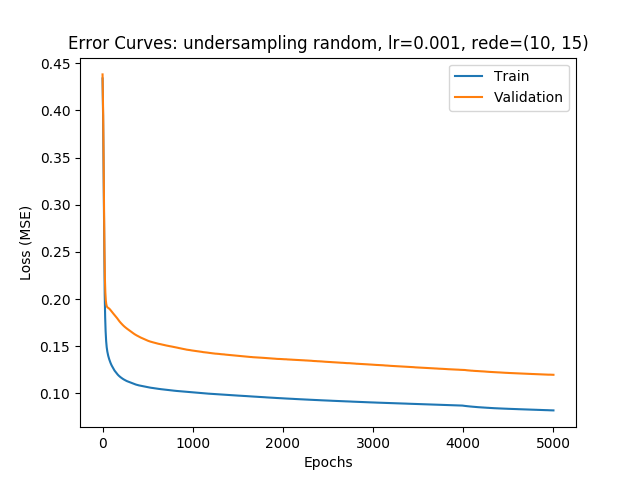

<IPython.core.display.Javascript object>


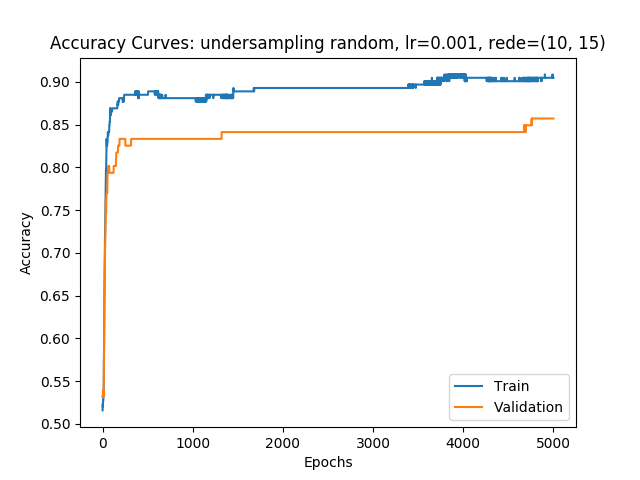

Matriz de confusão
[[1786  112]
 [   9   55]]

Train Loss:       0.0821
Validation Loss:  0.1198
Accuracy:         0.9383
MSE:              0.0617
AUROC:            0.9379


In [43]:
plot_training_error_curves(history, graficoName + "(10, 15)")
plot_training_acc_curves(history, graficoName + "(10, 15)")

## Fazer predições no conjunto de teste
y_pred = classifier.predict(X_test)
y_pred_class = classifier.predict_classes(X_test, verbose=0)

## Matriz de confusão
print('Matriz de confusão')
print(confusion_matrix(y_test, y_pred_class))

## Computar métricas de desempenho
losses = extract_final_losses(history)
print()
print("{metric:<18}{value:.4f}".format(metric="Train Loss:", value=losses['train_loss']))
print("{metric:<18}{value:.4f}".format(metric="Validation Loss:", value=losses['val_loss']))
print("{metric:<18}{value:.4f}".format(metric="Accuracy:", value=accuracy_score(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="MSE:", value=mean_squared_error(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="AUROC:", value=roc_auc_score(y_test, y_pred)))

## RNA 4 (20, 10)

In [44]:
# Aqui criamos o esboço da rede.
classifier = Sequential()

classifier.add(Dense(20, activation='relu', input_dim=6)) # camada escondida
classifier.add(Dense(10, activation='relu')) # camada escondida
classifier.add(Dense(1, activation='relu')) # 

sgd = optimizers.SGD(lr=learnRate)
classifier.compile(optimizer=sgd,
                   loss='mean_squared_error', # metrica de erro
                   metrics=['accuracy']) # metrica de sucesso

early_stopping = EarlyStopping(monitor='val_loss', patience=20)

history = classifier.fit(X_train, y_train,
                         epochs=100000, # quantidade de epocas que a rede neural vai executar
                         verbose=1,
                         shuffle=True, # utilizado para misturar as amostras a cada epoca
                         validation_data=(X_validation, y_validation),
                         callbacks=[early_stopping])

Train on 252 samples, validate on 126 samples
Epoch 1/100000
252/252 [==============================] - 0s - loss: 0.4153 - acc: 0.4444 - val_loss: 0.3758 - val_acc: 0.4683
Epoch 2/100000
252/252 [==============================] - 0s - loss: 0.4046 - acc: 0.4563 - val_loss: 0.3689 - val_acc: 0.4683
Epoch 3/100000
252/252 [==============================] - 0s - loss: 0.3940 - acc: 0.4643 - val_loss: 0.3624 - val_acc: 0.4762
Epoch 4/100000
252/252 [==============================] - 0s - loss: 0.3842 - acc: 0.4683 - val_loss: 0.3559 - val_acc: 0.4762
Epoch 5/100000
252/252 [==============================] - 0s - loss: 0.3747 - acc: 0.4683 - val_loss: 0.3497 - val_acc: 0.4921
Epoch 6/100000
252/252 [==============================] - 0s - loss: 0.3656 - acc: 0.4722 - val_loss: 0.3438 - val_acc: 0.4921
Epoch 7/100000
252/252 [==============================] - 0s - loss: 0.3568 - acc: 0.4841 - val_loss: 0.3383 - val_acc: 0.5000
Epoch 8/100000
252/252 [==============================] - 0s - lo

252/252 [==============================] - 0s - loss: 0.1848 - acc: 0.7540 - val_loss: 0.2377 - val_acc: 0.6825
Epoch 65/100000
252/252 [==============================] - 0s - loss: 0.1839 - acc: 0.7540 - val_loss: 0.2372 - val_acc: 0.6825
Epoch 66/100000
252/252 [==============================] - 0s - loss: 0.1828 - acc: 0.7540 - val_loss: 0.2366 - val_acc: 0.6825
Epoch 67/100000
252/252 [==============================] - 0s - loss: 0.1819 - acc: 0.7540 - val_loss: 0.2361 - val_acc: 0.6825
Epoch 68/100000
252/252 [==============================] - 0s - loss: 0.1810 - acc: 0.7619 - val_loss: 0.2355 - val_acc: 0.6825
Epoch 69/100000
252/252 [==============================] - 0s - loss: 0.1800 - acc: 0.7579 - val_loss: 0.2350 - val_acc: 0.6825
Epoch 70/100000
252/252 [==============================] - 0s - loss: 0.1792 - acc: 0.7619 - val_loss: 0.2345 - val_acc: 0.6825
Epoch 71/100000
252/252 [==============================] - 0s - loss: 0.1783 - acc: 0.7619 - val_loss: 0.2340 - val_acc:

252/252 [==============================] - 0s - loss: 0.1498 - acc: 0.8175 - val_loss: 0.2108 - val_acc: 0.7540
Epoch 128/100000
252/252 [==============================] - 0s - loss: 0.1495 - acc: 0.8175 - val_loss: 0.2104 - val_acc: 0.7540
Epoch 129/100000
252/252 [==============================] - 0s - loss: 0.1492 - acc: 0.8175 - val_loss: 0.2100 - val_acc: 0.7540
Epoch 130/100000
252/252 [==============================] - 0s - loss: 0.1489 - acc: 0.8175 - val_loss: 0.2096 - val_acc: 0.7540
Epoch 131/100000
252/252 [==============================] - 0s - loss: 0.1486 - acc: 0.8214 - val_loss: 0.2092 - val_acc: 0.7540
Epoch 132/100000
252/252 [==============================] - 0s - loss: 0.1483 - acc: 0.8214 - val_loss: 0.2089 - val_acc: 0.7540
Epoch 133/100000
252/252 [==============================] - 0s - loss: 0.1480 - acc: 0.8214 - val_loss: 0.2085 - val_acc: 0.7540
Epoch 134/100000
252/252 [==============================] - 0s - loss: 0.1477 - acc: 0.8214 - val_loss: 0.2081 - v

252/252 [==============================] - 0s - loss: 0.1348 - acc: 0.8254 - val_loss: 0.1888 - val_acc: 0.7619
Epoch 191/100000
252/252 [==============================] - 0s - loss: 0.1346 - acc: 0.8294 - val_loss: 0.1885 - val_acc: 0.7619
Epoch 192/100000
252/252 [==============================] - 0s - loss: 0.1344 - acc: 0.8294 - val_loss: 0.1882 - val_acc: 0.7619
Epoch 193/100000
252/252 [==============================] - 0s - loss: 0.1342 - acc: 0.8294 - val_loss: 0.1879 - val_acc: 0.7619
Epoch 194/100000
252/252 [==============================] - 0s - loss: 0.1341 - acc: 0.8294 - val_loss: 0.1876 - val_acc: 0.7619
Epoch 195/100000
252/252 [==============================] - 0s - loss: 0.1338 - acc: 0.8294 - val_loss: 0.1873 - val_acc: 0.7619
Epoch 196/100000
252/252 [==============================] - 0s - loss: 0.1336 - acc: 0.8294 - val_loss: 0.1870 - val_acc: 0.7619
Epoch 197/100000
252/252 [==============================] - 0s - loss: 0.1335 - acc: 0.8294 - val_loss: 0.1867 - v

252/252 [==============================] - 0s - loss: 0.1249 - acc: 0.8373 - val_loss: 0.1716 - val_acc: 0.7857
Epoch 254/100000
252/252 [==============================] - 0s - loss: 0.1248 - acc: 0.8373 - val_loss: 0.1714 - val_acc: 0.7857
Epoch 255/100000
252/252 [==============================] - 0s - loss: 0.1247 - acc: 0.8373 - val_loss: 0.1711 - val_acc: 0.7857
Epoch 256/100000
252/252 [==============================] - 0s - loss: 0.1245 - acc: 0.8373 - val_loss: 0.1709 - val_acc: 0.7857
Epoch 257/100000
252/252 [==============================] - 0s - loss: 0.1244 - acc: 0.8373 - val_loss: 0.1706 - val_acc: 0.7857
Epoch 258/100000
252/252 [==============================] - 0s - loss: 0.1242 - acc: 0.8373 - val_loss: 0.1703 - val_acc: 0.7857
Epoch 259/100000
252/252 [==============================] - 0s - loss: 0.1242 - acc: 0.8373 - val_loss: 0.1701 - val_acc: 0.7857
Epoch 260/100000
252/252 [==============================] - 0s - loss: 0.1240 - acc: 0.8373 - val_loss: 0.1698 - v

252/252 [==============================] - 0s - loss: 0.1175 - acc: 0.8413 - val_loss: 0.1572 - val_acc: 0.8095
Epoch 317/100000
252/252 [==============================] - 0s - loss: 0.1174 - acc: 0.8413 - val_loss: 0.1570 - val_acc: 0.8095
Epoch 318/100000
252/252 [==============================] - 0s - loss: 0.1173 - acc: 0.8413 - val_loss: 0.1568 - val_acc: 0.8095
Epoch 319/100000
252/252 [==============================] - 0s - loss: 0.1172 - acc: 0.8413 - val_loss: 0.1566 - val_acc: 0.8095
Epoch 320/100000
252/252 [==============================] - 0s - loss: 0.1171 - acc: 0.8413 - val_loss: 0.1564 - val_acc: 0.8095
Epoch 321/100000
252/252 [==============================] - 0s - loss: 0.1170 - acc: 0.8413 - val_loss: 0.1562 - val_acc: 0.8095
Epoch 322/100000
252/252 [==============================] - 0s - loss: 0.1169 - acc: 0.8413 - val_loss: 0.1560 - val_acc: 0.8095
Epoch 323/100000
252/252 [==============================] - 0s - loss: 0.1168 - acc: 0.8413 - val_loss: 0.1558 - v

252/252 [==============================] - 0s - loss: 0.1116 - acc: 0.8492 - val_loss: 0.1457 - val_acc: 0.8254
Epoch 380/100000
252/252 [==============================] - 0s - loss: 0.1115 - acc: 0.8492 - val_loss: 0.1455 - val_acc: 0.8254
Epoch 381/100000
252/252 [==============================] - 0s - loss: 0.1114 - acc: 0.8492 - val_loss: 0.1454 - val_acc: 0.8254
Epoch 382/100000
252/252 [==============================] - 0s - loss: 0.1114 - acc: 0.8532 - val_loss: 0.1452 - val_acc: 0.8254
Epoch 383/100000
252/252 [==============================] - 0s - loss: 0.1112 - acc: 0.8492 - val_loss: 0.1451 - val_acc: 0.8254
Epoch 384/100000
252/252 [==============================] - 0s - loss: 0.1112 - acc: 0.8492 - val_loss: 0.1449 - val_acc: 0.8254
Epoch 385/100000
252/252 [==============================] - 0s - loss: 0.1111 - acc: 0.8532 - val_loss: 0.1448 - val_acc: 0.8254
Epoch 386/100000
252/252 [==============================] - 0s - loss: 0.1110 - acc: 0.8532 - val_loss: 0.1446 - v

252/252 [==============================] - 0s - loss: 0.1070 - acc: 0.8492 - val_loss: 0.1372 - val_acc: 0.8333
Epoch 443/100000
252/252 [==============================] - 0s - loss: 0.1069 - acc: 0.8492 - val_loss: 0.1371 - val_acc: 0.8333
Epoch 444/100000
252/252 [==============================] - 0s - loss: 0.1069 - acc: 0.8492 - val_loss: 0.1370 - val_acc: 0.8333
Epoch 445/100000
252/252 [==============================] - 0s - loss: 0.1068 - acc: 0.8492 - val_loss: 0.1368 - val_acc: 0.8333
Epoch 446/100000
252/252 [==============================] - 0s - loss: 0.1068 - acc: 0.8492 - val_loss: 0.1367 - val_acc: 0.8333
Epoch 447/100000
252/252 [==============================] - 0s - loss: 0.1067 - acc: 0.8492 - val_loss: 0.1366 - val_acc: 0.8333
Epoch 448/100000
252/252 [==============================] - 0s - loss: 0.1066 - acc: 0.8492 - val_loss: 0.1364 - val_acc: 0.8333
Epoch 449/100000
252/252 [==============================] - 0s - loss: 0.1066 - acc: 0.8492 - val_loss: 0.1363 - v

252/252 [==============================] - 0s - loss: 0.1034 - acc: 0.8532 - val_loss: 0.1305 - val_acc: 0.8413
Epoch 506/100000
252/252 [==============================] - 0s - loss: 0.1033 - acc: 0.8532 - val_loss: 0.1304 - val_acc: 0.8413
Epoch 507/100000
252/252 [==============================] - 0s - loss: 0.1033 - acc: 0.8532 - val_loss: 0.1303 - val_acc: 0.8413
Epoch 508/100000
252/252 [==============================] - 0s - loss: 0.1032 - acc: 0.8532 - val_loss: 0.1302 - val_acc: 0.8492
Epoch 509/100000
252/252 [==============================] - 0s - loss: 0.1032 - acc: 0.8532 - val_loss: 0.1301 - val_acc: 0.8492
Epoch 510/100000
252/252 [==============================] - 0s - loss: 0.1031 - acc: 0.8532 - val_loss: 0.1300 - val_acc: 0.8492
Epoch 511/100000
252/252 [==============================] - 0s - loss: 0.1030 - acc: 0.8532 - val_loss: 0.1299 - val_acc: 0.8492
Epoch 512/100000
252/252 [==============================] - 0s - loss: 0.1030 - acc: 0.8532 - val_loss: 0.1298 - v

252/252 [==============================] - 0s - loss: 0.1003 - acc: 0.8730 - val_loss: 0.1250 - val_acc: 0.8571
Epoch 569/100000
252/252 [==============================] - 0s - loss: 0.1003 - acc: 0.8690 - val_loss: 0.1250 - val_acc: 0.8571
Epoch 570/100000
252/252 [==============================] - 0s - loss: 0.1002 - acc: 0.8730 - val_loss: 0.1249 - val_acc: 0.8571
Epoch 571/100000
252/252 [==============================] - 0s - loss: 0.1002 - acc: 0.8690 - val_loss: 0.1248 - val_acc: 0.8651
Epoch 572/100000
252/252 [==============================] - 0s - loss: 0.1002 - acc: 0.8651 - val_loss: 0.1247 - val_acc: 0.8651
Epoch 573/100000
252/252 [==============================] - 0s - loss: 0.1001 - acc: 0.8690 - val_loss: 0.1247 - val_acc: 0.8651
Epoch 574/100000
252/252 [==============================] - 0s - loss: 0.1001 - acc: 0.8690 - val_loss: 0.1246 - val_acc: 0.8651
Epoch 575/100000
252/252 [==============================] - 0s - loss: 0.1000 - acc: 0.8690 - val_loss: 0.1245 - v

252/252 [==============================] - 0s - loss: 0.0977 - acc: 0.8770 - val_loss: 0.1204 - val_acc: 0.8651
Epoch 632/100000
252/252 [==============================] - 0s - loss: 0.0976 - acc: 0.8770 - val_loss: 0.1203 - val_acc: 0.8651
Epoch 633/100000
252/252 [==============================] - 0s - loss: 0.0976 - acc: 0.8770 - val_loss: 0.1203 - val_acc: 0.8651
Epoch 634/100000
252/252 [==============================] - 0s - loss: 0.0976 - acc: 0.8770 - val_loss: 0.1202 - val_acc: 0.8651
Epoch 635/100000
252/252 [==============================] - 0s - loss: 0.0975 - acc: 0.8770 - val_loss: 0.1201 - val_acc: 0.8651
Epoch 636/100000
252/252 [==============================] - 0s - loss: 0.0974 - acc: 0.8770 - val_loss: 0.1200 - val_acc: 0.8730
Epoch 637/100000
252/252 [==============================] - 0s - loss: 0.0974 - acc: 0.8770 - val_loss: 0.1200 - val_acc: 0.8730
Epoch 638/100000
252/252 [==============================] - 0s - loss: 0.0974 - acc: 0.8770 - val_loss: 0.1199 - v

252/252 [==============================] - 0s - loss: 0.0952 - acc: 0.8770 - val_loss: 0.1164 - val_acc: 0.8810
Epoch 695/100000
252/252 [==============================] - 0s - loss: 0.0952 - acc: 0.8770 - val_loss: 0.1164 - val_acc: 0.8810
Epoch 696/100000
252/252 [==============================] - 0s - loss: 0.0952 - acc: 0.8770 - val_loss: 0.1163 - val_acc: 0.8810
Epoch 697/100000
252/252 [==============================] - 0s - loss: 0.0951 - acc: 0.8770 - val_loss: 0.1163 - val_acc: 0.8810
Epoch 698/100000
252/252 [==============================] - 0s - loss: 0.0951 - acc: 0.8770 - val_loss: 0.1162 - val_acc: 0.8810
Epoch 699/100000
252/252 [==============================] - 0s - loss: 0.0950 - acc: 0.8770 - val_loss: 0.1162 - val_acc: 0.8810
Epoch 700/100000
252/252 [==============================] - 0s - loss: 0.0950 - acc: 0.8770 - val_loss: 0.1161 - val_acc: 0.8810
Epoch 701/100000
252/252 [==============================] - 0s - loss: 0.0950 - acc: 0.8770 - val_loss: 0.1160 - v

252/252 [==============================] - 0s - loss: 0.0931 - acc: 0.8810 - val_loss: 0.1129 - val_acc: 0.8810
Epoch 758/100000
252/252 [==============================] - 0s - loss: 0.0930 - acc: 0.8810 - val_loss: 0.1128 - val_acc: 0.8810
Epoch 759/100000
252/252 [==============================] - 0s - loss: 0.0930 - acc: 0.8810 - val_loss: 0.1128 - val_acc: 0.8810
Epoch 760/100000
252/252 [==============================] - 0s - loss: 0.0930 - acc: 0.8810 - val_loss: 0.1127 - val_acc: 0.8810
Epoch 761/100000
252/252 [==============================] - 0s - loss: 0.0930 - acc: 0.8810 - val_loss: 0.1127 - val_acc: 0.8810
Epoch 762/100000
252/252 [==============================] - 0s - loss: 0.0929 - acc: 0.8810 - val_loss: 0.1126 - val_acc: 0.8810
Epoch 763/100000
252/252 [==============================] - 0s - loss: 0.0929 - acc: 0.8810 - val_loss: 0.1126 - val_acc: 0.8810
Epoch 764/100000
252/252 [==============================] - 0s - loss: 0.0929 - acc: 0.8810 - val_loss: 0.1125 - v

252/252 [==============================] - 0s - loss: 0.0912 - acc: 0.8810 - val_loss: 0.1100 - val_acc: 0.8889
Epoch 821/100000
252/252 [==============================] - 0s - loss: 0.0912 - acc: 0.8810 - val_loss: 0.1099 - val_acc: 0.8889
Epoch 822/100000
252/252 [==============================] - 0s - loss: 0.0911 - acc: 0.8810 - val_loss: 0.1099 - val_acc: 0.8889
Epoch 823/100000
252/252 [==============================] - 0s - loss: 0.0911 - acc: 0.8810 - val_loss: 0.1098 - val_acc: 0.8889
Epoch 824/100000
252/252 [==============================] - 0s - loss: 0.0910 - acc: 0.8810 - val_loss: 0.1098 - val_acc: 0.8889
Epoch 825/100000
252/252 [==============================] - 0s - loss: 0.0910 - acc: 0.8810 - val_loss: 0.1098 - val_acc: 0.8889
Epoch 826/100000
252/252 [==============================] - 0s - loss: 0.0910 - acc: 0.8810 - val_loss: 0.1097 - val_acc: 0.8889
Epoch 827/100000
252/252 [==============================] - 0s - loss: 0.0910 - acc: 0.8810 - val_loss: 0.1097 - v

252/252 [==============================] - 0s - loss: 0.0895 - acc: 0.8849 - val_loss: 0.1076 - val_acc: 0.8889
Epoch 884/100000
252/252 [==============================] - 0s - loss: 0.0895 - acc: 0.8849 - val_loss: 0.1075 - val_acc: 0.8889
Epoch 885/100000
252/252 [==============================] - 0s - loss: 0.0895 - acc: 0.8849 - val_loss: 0.1075 - val_acc: 0.8889
Epoch 886/100000
252/252 [==============================] - 0s - loss: 0.0894 - acc: 0.8849 - val_loss: 0.1075 - val_acc: 0.8889
Epoch 887/100000
252/252 [==============================] - 0s - loss: 0.0894 - acc: 0.8849 - val_loss: 0.1074 - val_acc: 0.8889
Epoch 888/100000
252/252 [==============================] - 0s - loss: 0.0894 - acc: 0.8849 - val_loss: 0.1074 - val_acc: 0.8889
Epoch 889/100000
252/252 [==============================] - 0s - loss: 0.0894 - acc: 0.8849 - val_loss: 0.1074 - val_acc: 0.8889
Epoch 890/100000
252/252 [==============================] - 0s - loss: 0.0893 - acc: 0.8849 - val_loss: 0.1073 - v

252/252 [==============================] - 0s - loss: 0.0880 - acc: 0.8968 - val_loss: 0.1055 - val_acc: 0.8889
Epoch 947/100000
252/252 [==============================] - 0s - loss: 0.0879 - acc: 0.8968 - val_loss: 0.1054 - val_acc: 0.8889
Epoch 948/100000
252/252 [==============================] - 0s - loss: 0.0879 - acc: 0.8968 - val_loss: 0.1054 - val_acc: 0.8889
Epoch 949/100000
252/252 [==============================] - 0s - loss: 0.0879 - acc: 0.8968 - val_loss: 0.1054 - val_acc: 0.8889
Epoch 950/100000
252/252 [==============================] - 0s - loss: 0.0879 - acc: 0.8968 - val_loss: 0.1053 - val_acc: 0.8889
Epoch 951/100000
252/252 [==============================] - 0s - loss: 0.0879 - acc: 0.8968 - val_loss: 0.1053 - val_acc: 0.8889
Epoch 952/100000
252/252 [==============================] - 0s - loss: 0.0879 - acc: 0.8968 - val_loss: 0.1053 - val_acc: 0.8889
Epoch 953/100000
252/252 [==============================] - 0s - loss: 0.0878 - acc: 0.8968 - val_loss: 0.1053 - v

252/252 [==============================] - 0s - loss: 0.0866 - acc: 0.8968 - val_loss: 0.1036 - val_acc: 0.8889
Epoch 1010/100000
252/252 [==============================] - 0s - loss: 0.0866 - acc: 0.8968 - val_loss: 0.1035 - val_acc: 0.8889
Epoch 1011/100000
252/252 [==============================] - 0s - loss: 0.0865 - acc: 0.8968 - val_loss: 0.1035 - val_acc: 0.8889
Epoch 1012/100000
252/252 [==============================] - 0s - loss: 0.0865 - acc: 0.8968 - val_loss: 0.1035 - val_acc: 0.8889
Epoch 1013/100000
252/252 [==============================] - 0s - loss: 0.0865 - acc: 0.8968 - val_loss: 0.1034 - val_acc: 0.8889
Epoch 1014/100000
252/252 [==============================] - 0s - loss: 0.0865 - acc: 0.8968 - val_loss: 0.1034 - val_acc: 0.8889
Epoch 1015/100000
252/252 [==============================] - 0s - loss: 0.0865 - acc: 0.8968 - val_loss: 0.1034 - val_acc: 0.8889
Epoch 1016/100000
252/252 [==============================] - 0s - loss: 0.0864 - acc: 0.8968 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0853 - acc: 0.8929 - val_loss: 0.1020 - val_acc: 0.8889
Epoch 1073/100000
252/252 [==============================] - 0s - loss: 0.0853 - acc: 0.8968 - val_loss: 0.1019 - val_acc: 0.8889
Epoch 1074/100000
252/252 [==============================] - 0s - loss: 0.0852 - acc: 0.8929 - val_loss: 0.1019 - val_acc: 0.8889
Epoch 1075/100000
252/252 [==============================] - 0s - loss: 0.0852 - acc: 0.8968 - val_loss: 0.1019 - val_acc: 0.8889
Epoch 1076/100000
252/252 [==============================] - 0s - loss: 0.0852 - acc: 0.8968 - val_loss: 0.1018 - val_acc: 0.8889
Epoch 1077/100000
252/252 [==============================] - 0s - loss: 0.0852 - acc: 0.8929 - val_loss: 0.1018 - val_acc: 0.8889
Epoch 1078/100000
252/252 [==============================] - 0s - loss: 0.0851 - acc: 0.8929 - val_loss: 0.1018 - val_acc: 0.8889
Epoch 1079/100000
252/252 [==============================] - 0s - loss: 0.0851 - acc: 0.8968 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0841 - acc: 0.8968 - val_loss: 0.1006 - val_acc: 0.8889
Epoch 1136/100000
252/252 [==============================] - 0s - loss: 0.0840 - acc: 0.8968 - val_loss: 0.1006 - val_acc: 0.8889
Epoch 1137/100000
252/252 [==============================] - 0s - loss: 0.0840 - acc: 0.8968 - val_loss: 0.1006 - val_acc: 0.8889
Epoch 1138/100000
252/252 [==============================] - 0s - loss: 0.0840 - acc: 0.8968 - val_loss: 0.1005 - val_acc: 0.8889
Epoch 1139/100000
252/252 [==============================] - 0s - loss: 0.0840 - acc: 0.8968 - val_loss: 0.1005 - val_acc: 0.8889
Epoch 1140/100000
252/252 [==============================] - 0s - loss: 0.0840 - acc: 0.8968 - val_loss: 0.1005 - val_acc: 0.8889
Epoch 1141/100000
252/252 [==============================] - 0s - loss: 0.0840 - acc: 0.8968 - val_loss: 0.1005 - val_acc: 0.8889
Epoch 1142/100000
252/252 [==============================] - 0s - loss: 0.0839 - acc: 0.8968 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0830 - acc: 0.8968 - val_loss: 0.0995 - val_acc: 0.8889
Epoch 1199/100000
252/252 [==============================] - 0s - loss: 0.0829 - acc: 0.8968 - val_loss: 0.0995 - val_acc: 0.8889
Epoch 1200/100000
252/252 [==============================] - 0s - loss: 0.0829 - acc: 0.9008 - val_loss: 0.0995 - val_acc: 0.8889
Epoch 1201/100000
252/252 [==============================] - 0s - loss: 0.0829 - acc: 0.8968 - val_loss: 0.0995 - val_acc: 0.8889
Epoch 1202/100000
252/252 [==============================] - 0s - loss: 0.0829 - acc: 0.9008 - val_loss: 0.0995 - val_acc: 0.8889
Epoch 1203/100000
252/252 [==============================] - 0s - loss: 0.0829 - acc: 0.8968 - val_loss: 0.0994 - val_acc: 0.8889
Epoch 1204/100000
252/252 [==============================] - 0s - loss: 0.0828 - acc: 0.8968 - val_loss: 0.0994 - val_acc: 0.8889
Epoch 1205/100000
252/252 [==============================] - 0s - loss: 0.0828 - acc: 0.9008 - val_loss: 0.0

252/252 [==============================] - 0s - loss: 0.0819 - acc: 0.9008 - val_loss: 0.0988 - val_acc: 0.8889
Epoch 1262/100000
252/252 [==============================] - 0s - loss: 0.0819 - acc: 0.9008 - val_loss: 0.0988 - val_acc: 0.8889
Epoch 1263/100000
252/252 [==============================] - 0s - loss: 0.0819 - acc: 0.9008 - val_loss: 0.0988 - val_acc: 0.8889
Epoch 1264/100000
252/252 [==============================] - 0s - loss: 0.0819 - acc: 0.9008 - val_loss: 0.0988 - val_acc: 0.8889
Epoch 1265/100000
252/252 [==============================] - 0s - loss: 0.0819 - acc: 0.9008 - val_loss: 0.0988 - val_acc: 0.8889
Epoch 1266/100000
252/252 [==============================] - 0s - loss: 0.0818 - acc: 0.9008 - val_loss: 0.0988 - val_acc: 0.8889
Epoch 1267/100000
252/252 [==============================] - 0s - loss: 0.0818 - acc: 0.9008 - val_loss: 0.0988 - val_acc: 0.8889
Epoch 1268/100000
252/252 [==============================] - 0s - loss: 0.0818 - acc: 0.9008 - val_loss: 0.0

252/252 [==============================] - 0s - loss: 0.0811 - acc: 0.9008 - val_loss: 0.0981 - val_acc: 0.8889
Epoch 1324/100000
252/252 [==============================] - 0s - loss: 0.0810 - acc: 0.9008 - val_loss: 0.0981 - val_acc: 0.8889
Epoch 1325/100000
252/252 [==============================] - 0s - loss: 0.0810 - acc: 0.9008 - val_loss: 0.0981 - val_acc: 0.8889
Epoch 1326/100000
252/252 [==============================] - 0s - loss: 0.0810 - acc: 0.9008 - val_loss: 0.0981 - val_acc: 0.8889
Epoch 1327/100000
252/252 [==============================] - 0s - loss: 0.0810 - acc: 0.9008 - val_loss: 0.0981 - val_acc: 0.8889
Epoch 1328/100000
252/252 [==============================] - 0s - loss: 0.0810 - acc: 0.9008 - val_loss: 0.0981 - val_acc: 0.8889
Epoch 1329/100000
252/252 [==============================] - 0s - loss: 0.0810 - acc: 0.9008 - val_loss: 0.0980 - val_acc: 0.8889
Epoch 1330/100000
252/252 [==============================] - 0s - loss: 0.0809 - acc: 0.9008 - val_loss: 0.0

252/252 [==============================] - 0s - loss: 0.0802 - acc: 0.9008 - val_loss: 0.0974 - val_acc: 0.8889
Epoch 1387/100000
252/252 [==============================] - 0s - loss: 0.0801 - acc: 0.9008 - val_loss: 0.0974 - val_acc: 0.8889
Epoch 1388/100000
252/252 [==============================] - 0s - loss: 0.0801 - acc: 0.9008 - val_loss: 0.0973 - val_acc: 0.8889
Epoch 1389/100000
252/252 [==============================] - 0s - loss: 0.0802 - acc: 0.9008 - val_loss: 0.0973 - val_acc: 0.8889
Epoch 1390/100000
252/252 [==============================] - 0s - loss: 0.0801 - acc: 0.9008 - val_loss: 0.0973 - val_acc: 0.8889
Epoch 1391/100000
252/252 [==============================] - 0s - loss: 0.0801 - acc: 0.9008 - val_loss: 0.0973 - val_acc: 0.8889
Epoch 1392/100000
252/252 [==============================] - 0s - loss: 0.0801 - acc: 0.9008 - val_loss: 0.0973 - val_acc: 0.8889
Epoch 1393/100000
252/252 [==============================] - 0s - loss: 0.0801 - acc: 0.9008 - val_loss: 0.0

252/252 [==============================] - 0s - loss: 0.0794 - acc: 0.9008 - val_loss: 0.0967 - val_acc: 0.8889
Epoch 1449/100000
252/252 [==============================] - 0s - loss: 0.0794 - acc: 0.9008 - val_loss: 0.0966 - val_acc: 0.8889
Epoch 1450/100000
252/252 [==============================] - 0s - loss: 0.0793 - acc: 0.9008 - val_loss: 0.0966 - val_acc: 0.8889
Epoch 1451/100000
252/252 [==============================] - 0s - loss: 0.0793 - acc: 0.9008 - val_loss: 0.0966 - val_acc: 0.8889
Epoch 1452/100000
252/252 [==============================] - 0s - loss: 0.0793 - acc: 0.9008 - val_loss: 0.0966 - val_acc: 0.8889
Epoch 1453/100000
252/252 [==============================] - 0s - loss: 0.0793 - acc: 0.9008 - val_loss: 0.0966 - val_acc: 0.8889
Epoch 1454/100000
252/252 [==============================] - 0s - loss: 0.0793 - acc: 0.9008 - val_loss: 0.0966 - val_acc: 0.8889
Epoch 1455/100000
252/252 [==============================] - 0s - loss: 0.0793 - acc: 0.9008 - val_loss: 0.0

252/252 [==============================] - 0s - loss: 0.0786 - acc: 0.9008 - val_loss: 0.0961 - val_acc: 0.8889
Epoch 1512/100000
252/252 [==============================] - 0s - loss: 0.0786 - acc: 0.9008 - val_loss: 0.0961 - val_acc: 0.8889
Epoch 1513/100000
252/252 [==============================] - 0s - loss: 0.0786 - acc: 0.9008 - val_loss: 0.0961 - val_acc: 0.8889
Epoch 1514/100000
252/252 [==============================] - 0s - loss: 0.0786 - acc: 0.9008 - val_loss: 0.0961 - val_acc: 0.8889
Epoch 1515/100000
252/252 [==============================] - 0s - loss: 0.0786 - acc: 0.9008 - val_loss: 0.0960 - val_acc: 0.8889
Epoch 1516/100000
252/252 [==============================] - 0s - loss: 0.0785 - acc: 0.9008 - val_loss: 0.0960 - val_acc: 0.8889
Epoch 1517/100000
252/252 [==============================] - 0s - loss: 0.0786 - acc: 0.9008 - val_loss: 0.0960 - val_acc: 0.8889
Epoch 1518/100000
252/252 [==============================] - 0s - loss: 0.0785 - acc: 0.9008 - val_loss: 0.0

252/252 [==============================] - 0s - loss: 0.0778 - acc: 0.9048 - val_loss: 0.0956 - val_acc: 0.8889
Epoch 1575/100000
252/252 [==============================] - 0s - loss: 0.0778 - acc: 0.9048 - val_loss: 0.0956 - val_acc: 0.8889
Epoch 1576/100000
252/252 [==============================] - 0s - loss: 0.0778 - acc: 0.9048 - val_loss: 0.0956 - val_acc: 0.8889
Epoch 1577/100000
252/252 [==============================] - 0s - loss: 0.0778 - acc: 0.9048 - val_loss: 0.0956 - val_acc: 0.8889
Epoch 1578/100000
252/252 [==============================] - 0s - loss: 0.0778 - acc: 0.9048 - val_loss: 0.0955 - val_acc: 0.8889
Epoch 1579/100000
252/252 [==============================] - 0s - loss: 0.0778 - acc: 0.9048 - val_loss: 0.0955 - val_acc: 0.8889
Epoch 1580/100000
252/252 [==============================] - 0s - loss: 0.0777 - acc: 0.9048 - val_loss: 0.0955 - val_acc: 0.8889
Epoch 1581/100000
252/252 [==============================] - 0s - loss: 0.0777 - acc: 0.9048 - val_loss: 0.0

252/252 [==============================] - 0s - loss: 0.0771 - acc: 0.9048 - val_loss: 0.0950 - val_acc: 0.8889
Epoch 1638/100000
252/252 [==============================] - 0s - loss: 0.0771 - acc: 0.9048 - val_loss: 0.0949 - val_acc: 0.8889
Epoch 1639/100000
252/252 [==============================] - 0s - loss: 0.0771 - acc: 0.9048 - val_loss: 0.0949 - val_acc: 0.8889
Epoch 1640/100000
252/252 [==============================] - 0s - loss: 0.0771 - acc: 0.9048 - val_loss: 0.0949 - val_acc: 0.8889
Epoch 1641/100000
252/252 [==============================] - 0s - loss: 0.0771 - acc: 0.9048 - val_loss: 0.0949 - val_acc: 0.8889
Epoch 1642/100000
252/252 [==============================] - 0s - loss: 0.0770 - acc: 0.9048 - val_loss: 0.0949 - val_acc: 0.8889
Epoch 1643/100000
252/252 [==============================] - 0s - loss: 0.0770 - acc: 0.9048 - val_loss: 0.0949 - val_acc: 0.8889
Epoch 1644/100000
252/252 [==============================] - 0s - loss: 0.0770 - acc: 0.9048 - val_loss: 0.0

252/252 [==============================] - 0s - loss: 0.0764 - acc: 0.9048 - val_loss: 0.0944 - val_acc: 0.8889
Epoch 1701/100000
252/252 [==============================] - 0s - loss: 0.0764 - acc: 0.9048 - val_loss: 0.0944 - val_acc: 0.8889
Epoch 1702/100000
252/252 [==============================] - 0s - loss: 0.0764 - acc: 0.9048 - val_loss: 0.0944 - val_acc: 0.8889
Epoch 1703/100000
252/252 [==============================] - 0s - loss: 0.0764 - acc: 0.9048 - val_loss: 0.0944 - val_acc: 0.8889
Epoch 1704/100000
252/252 [==============================] - 0s - loss: 0.0763 - acc: 0.9048 - val_loss: 0.0944 - val_acc: 0.8889
Epoch 1705/100000
252/252 [==============================] - 0s - loss: 0.0763 - acc: 0.9048 - val_loss: 0.0944 - val_acc: 0.8889
Epoch 1706/100000
252/252 [==============================] - 0s - loss: 0.0763 - acc: 0.9048 - val_loss: 0.0944 - val_acc: 0.8889
Epoch 1707/100000
252/252 [==============================] - 0s - loss: 0.0763 - acc: 0.9048 - val_loss: 0.0

252/252 [==============================] - 0s - loss: 0.0757 - acc: 0.9048 - val_loss: 0.0939 - val_acc: 0.8889
Epoch 1764/100000
252/252 [==============================] - 0s - loss: 0.0757 - acc: 0.9048 - val_loss: 0.0938 - val_acc: 0.8889
Epoch 1765/100000
252/252 [==============================] - 0s - loss: 0.0757 - acc: 0.9048 - val_loss: 0.0938 - val_acc: 0.8889
Epoch 1766/100000
252/252 [==============================] - 0s - loss: 0.0757 - acc: 0.9048 - val_loss: 0.0938 - val_acc: 0.8889
Epoch 1767/100000
252/252 [==============================] - 0s - loss: 0.0757 - acc: 0.9048 - val_loss: 0.0938 - val_acc: 0.8889
Epoch 1768/100000
252/252 [==============================] - 0s - loss: 0.0757 - acc: 0.9048 - val_loss: 0.0938 - val_acc: 0.8889
Epoch 1769/100000
252/252 [==============================] - 0s - loss: 0.0757 - acc: 0.9048 - val_loss: 0.0938 - val_acc: 0.8889
Epoch 1770/100000
252/252 [==============================] - 0s - loss: 0.0757 - acc: 0.9048 - val_loss: 0.0

252/252 [==============================] - 0s - loss: 0.0751 - acc: 0.9048 - val_loss: 0.0933 - val_acc: 0.8889
Epoch 1827/100000
252/252 [==============================] - 0s - loss: 0.0751 - acc: 0.9048 - val_loss: 0.0933 - val_acc: 0.8889
Epoch 1828/100000
252/252 [==============================] - 0s - loss: 0.0751 - acc: 0.9048 - val_loss: 0.0933 - val_acc: 0.8889
Epoch 1829/100000
252/252 [==============================] - 0s - loss: 0.0751 - acc: 0.9048 - val_loss: 0.0933 - val_acc: 0.8889
Epoch 1830/100000
252/252 [==============================] - 0s - loss: 0.0751 - acc: 0.9048 - val_loss: 0.0933 - val_acc: 0.8889
Epoch 1831/100000
252/252 [==============================] - 0s - loss: 0.0751 - acc: 0.9048 - val_loss: 0.0933 - val_acc: 0.8889
Epoch 1832/100000
252/252 [==============================] - 0s - loss: 0.0751 - acc: 0.9048 - val_loss: 0.0933 - val_acc: 0.8889
Epoch 1833/100000
252/252 [==============================] - 0s - loss: 0.0751 - acc: 0.9048 - val_loss: 0.0

252/252 [==============================] - 0s - loss: 0.0745 - acc: 0.9048 - val_loss: 0.0928 - val_acc: 0.8889
Epoch 1890/100000
252/252 [==============================] - 0s - loss: 0.0745 - acc: 0.9048 - val_loss: 0.0928 - val_acc: 0.8889
Epoch 1891/100000
252/252 [==============================] - 0s - loss: 0.0745 - acc: 0.9087 - val_loss: 0.0928 - val_acc: 0.8889
Epoch 1892/100000
252/252 [==============================] - 0s - loss: 0.0745 - acc: 0.9087 - val_loss: 0.0928 - val_acc: 0.8889
Epoch 1893/100000
252/252 [==============================] - 0s - loss: 0.0745 - acc: 0.9087 - val_loss: 0.0927 - val_acc: 0.8889
Epoch 1894/100000
252/252 [==============================] - 0s - loss: 0.0745 - acc: 0.9087 - val_loss: 0.0927 - val_acc: 0.8889
Epoch 1895/100000
252/252 [==============================] - 0s - loss: 0.0745 - acc: 0.9048 - val_loss: 0.0927 - val_acc: 0.8889
Epoch 1896/100000
252/252 [==============================] - 0s - loss: 0.0745 - acc: 0.9048 - val_loss: 0.0

252/252 [==============================] - 0s - loss: 0.0740 - acc: 0.9087 - val_loss: 0.0923 - val_acc: 0.8889
Epoch 1953/100000
252/252 [==============================] - 0s - loss: 0.0740 - acc: 0.9087 - val_loss: 0.0923 - val_acc: 0.8889
Epoch 1954/100000
252/252 [==============================] - 0s - loss: 0.0740 - acc: 0.9087 - val_loss: 0.0923 - val_acc: 0.8889
Epoch 1955/100000
252/252 [==============================] - 0s - loss: 0.0739 - acc: 0.9087 - val_loss: 0.0923 - val_acc: 0.8889
Epoch 1956/100000
252/252 [==============================] - 0s - loss: 0.0740 - acc: 0.9087 - val_loss: 0.0923 - val_acc: 0.8889
Epoch 1957/100000
252/252 [==============================] - 0s - loss: 0.0739 - acc: 0.9087 - val_loss: 0.0922 - val_acc: 0.8889
Epoch 1958/100000
252/252 [==============================] - 0s - loss: 0.0739 - acc: 0.9087 - val_loss: 0.0922 - val_acc: 0.8889
Epoch 1959/100000
252/252 [==============================] - 0s - loss: 0.0739 - acc: 0.9087 - val_loss: 0.0

252/252 [==============================] - 0s - loss: 0.0734 - acc: 0.9087 - val_loss: 0.0918 - val_acc: 0.8968
Epoch 2016/100000
252/252 [==============================] - 0s - loss: 0.0734 - acc: 0.9087 - val_loss: 0.0918 - val_acc: 0.8968
Epoch 2017/100000
252/252 [==============================] - 0s - loss: 0.0734 - acc: 0.9087 - val_loss: 0.0918 - val_acc: 0.8968
Epoch 2018/100000
252/252 [==============================] - 0s - loss: 0.0734 - acc: 0.9087 - val_loss: 0.0918 - val_acc: 0.8968
Epoch 2019/100000
252/252 [==============================] - 0s - loss: 0.0734 - acc: 0.9087 - val_loss: 0.0918 - val_acc: 0.8968
Epoch 2020/100000
252/252 [==============================] - 0s - loss: 0.0734 - acc: 0.9087 - val_loss: 0.0918 - val_acc: 0.8968
Epoch 2021/100000
252/252 [==============================] - 0s - loss: 0.0734 - acc: 0.9087 - val_loss: 0.0918 - val_acc: 0.8968
Epoch 2022/100000
252/252 [==============================] - 0s - loss: 0.0734 - acc: 0.9087 - val_loss: 0.0

252/252 [==============================] - 0s - loss: 0.0729 - acc: 0.9087 - val_loss: 0.0913 - val_acc: 0.8968
Epoch 2079/100000
252/252 [==============================] - 0s - loss: 0.0729 - acc: 0.9087 - val_loss: 0.0913 - val_acc: 0.8968
Epoch 2080/100000
252/252 [==============================] - 0s - loss: 0.0729 - acc: 0.9087 - val_loss: 0.0913 - val_acc: 0.8968
Epoch 2081/100000
252/252 [==============================] - 0s - loss: 0.0729 - acc: 0.9087 - val_loss: 0.0913 - val_acc: 0.8968
Epoch 2082/100000
252/252 [==============================] - 0s - loss: 0.0729 - acc: 0.9087 - val_loss: 0.0913 - val_acc: 0.8968
Epoch 2083/100000
252/252 [==============================] - 0s - loss: 0.0729 - acc: 0.9087 - val_loss: 0.0913 - val_acc: 0.8968
Epoch 2084/100000
252/252 [==============================] - 0s - loss: 0.0729 - acc: 0.9087 - val_loss: 0.0913 - val_acc: 0.8968
Epoch 2085/100000
252/252 [==============================] - 0s - loss: 0.0729 - acc: 0.9087 - val_loss: 0.0

252/252 [==============================] - 0s - loss: 0.0724 - acc: 0.9127 - val_loss: 0.0909 - val_acc: 0.8968
Epoch 2142/100000
252/252 [==============================] - 0s - loss: 0.0724 - acc: 0.9127 - val_loss: 0.0909 - val_acc: 0.8968
Epoch 2143/100000
252/252 [==============================] - 0s - loss: 0.0724 - acc: 0.9127 - val_loss: 0.0909 - val_acc: 0.8968
Epoch 2144/100000
252/252 [==============================] - 0s - loss: 0.0724 - acc: 0.9127 - val_loss: 0.0909 - val_acc: 0.8968
Epoch 2145/100000
252/252 [==============================] - 0s - loss: 0.0724 - acc: 0.9127 - val_loss: 0.0909 - val_acc: 0.8968
Epoch 2146/100000
252/252 [==============================] - 0s - loss: 0.0723 - acc: 0.9127 - val_loss: 0.0909 - val_acc: 0.8968
Epoch 2147/100000
252/252 [==============================] - 0s - loss: 0.0723 - acc: 0.9127 - val_loss: 0.0909 - val_acc: 0.8968
Epoch 2148/100000
252/252 [==============================] - 0s - loss: 0.0723 - acc: 0.9127 - val_loss: 0.0

252/252 [==============================] - 0s - loss: 0.0719 - acc: 0.9127 - val_loss: 0.0905 - val_acc: 0.8968
Epoch 2205/100000
252/252 [==============================] - 0s - loss: 0.0719 - acc: 0.9127 - val_loss: 0.0905 - val_acc: 0.8968
Epoch 2206/100000
252/252 [==============================] - 0s - loss: 0.0719 - acc: 0.9127 - val_loss: 0.0905 - val_acc: 0.8968
Epoch 2207/100000
252/252 [==============================] - 0s - loss: 0.0718 - acc: 0.9127 - val_loss: 0.0905 - val_acc: 0.8968
Epoch 2208/100000
252/252 [==============================] - 0s - loss: 0.0718 - acc: 0.9127 - val_loss: 0.0905 - val_acc: 0.8968
Epoch 2209/100000
252/252 [==============================] - 0s - loss: 0.0718 - acc: 0.9127 - val_loss: 0.0905 - val_acc: 0.8968
Epoch 2210/100000
252/252 [==============================] - 0s - loss: 0.0718 - acc: 0.9127 - val_loss: 0.0905 - val_acc: 0.8968
Epoch 2211/100000
252/252 [==============================] - 0s - loss: 0.0718 - acc: 0.9127 - val_loss: 0.0

252/252 [==============================] - 0s - loss: 0.0714 - acc: 0.9167 - val_loss: 0.0901 - val_acc: 0.8968
Epoch 2268/100000
252/252 [==============================] - 0s - loss: 0.0714 - acc: 0.9127 - val_loss: 0.0901 - val_acc: 0.8968
Epoch 2269/100000
252/252 [==============================] - 0s - loss: 0.0714 - acc: 0.9167 - val_loss: 0.0901 - val_acc: 0.8968
Epoch 2270/100000
252/252 [==============================] - 0s - loss: 0.0714 - acc: 0.9127 - val_loss: 0.0901 - val_acc: 0.8968
Epoch 2271/100000
252/252 [==============================] - 0s - loss: 0.0714 - acc: 0.9127 - val_loss: 0.0901 - val_acc: 0.8968
Epoch 2272/100000
252/252 [==============================] - 0s - loss: 0.0714 - acc: 0.9167 - val_loss: 0.0901 - val_acc: 0.8968
Epoch 2273/100000
252/252 [==============================] - 0s - loss: 0.0714 - acc: 0.9127 - val_loss: 0.0901 - val_acc: 0.8968
Epoch 2274/100000
252/252 [==============================] - 0s - loss: 0.0714 - acc: 0.9167 - val_loss: 0.0

252/252 [==============================] - 0s - loss: 0.0709 - acc: 0.9167 - val_loss: 0.0898 - val_acc: 0.8968
Epoch 2331/100000
252/252 [==============================] - 0s - loss: 0.0709 - acc: 0.9167 - val_loss: 0.0897 - val_acc: 0.8968
Epoch 2332/100000
252/252 [==============================] - 0s - loss: 0.0709 - acc: 0.9167 - val_loss: 0.0897 - val_acc: 0.8968
Epoch 2333/100000
252/252 [==============================] - 0s - loss: 0.0709 - acc: 0.9167 - val_loss: 0.0897 - val_acc: 0.8968
Epoch 2334/100000
252/252 [==============================] - 0s - loss: 0.0709 - acc: 0.9167 - val_loss: 0.0897 - val_acc: 0.8968
Epoch 2335/100000
252/252 [==============================] - 0s - loss: 0.0709 - acc: 0.9167 - val_loss: 0.0897 - val_acc: 0.8968
Epoch 2336/100000
252/252 [==============================] - 0s - loss: 0.0709 - acc: 0.9167 - val_loss: 0.0897 - val_acc: 0.8968
Epoch 2337/100000
252/252 [==============================] - 0s - loss: 0.0709 - acc: 0.9167 - val_loss: 0.0

252/252 [==============================] - 0s - loss: 0.0705 - acc: 0.9167 - val_loss: 0.0894 - val_acc: 0.8968
Epoch 2394/100000
252/252 [==============================] - 0s - loss: 0.0705 - acc: 0.9167 - val_loss: 0.0894 - val_acc: 0.8968
Epoch 2395/100000
252/252 [==============================] - 0s - loss: 0.0705 - acc: 0.9167 - val_loss: 0.0894 - val_acc: 0.8968
Epoch 2396/100000
252/252 [==============================] - 0s - loss: 0.0705 - acc: 0.9167 - val_loss: 0.0894 - val_acc: 0.8968
Epoch 2397/100000
252/252 [==============================] - 0s - loss: 0.0705 - acc: 0.9167 - val_loss: 0.0894 - val_acc: 0.8968
Epoch 2398/100000
252/252 [==============================] - 0s - loss: 0.0705 - acc: 0.9206 - val_loss: 0.0894 - val_acc: 0.8968
Epoch 2399/100000
252/252 [==============================] - 0s - loss: 0.0704 - acc: 0.9167 - val_loss: 0.0894 - val_acc: 0.8968
Epoch 2400/100000
252/252 [==============================] - 0s - loss: 0.0704 - acc: 0.9167 - val_loss: 0.0

252/252 [==============================] - 0s - loss: 0.0701 - acc: 0.9246 - val_loss: 0.0891 - val_acc: 0.8968
Epoch 2457/100000
252/252 [==============================] - 0s - loss: 0.0701 - acc: 0.9246 - val_loss: 0.0891 - val_acc: 0.8968
Epoch 2458/100000
252/252 [==============================] - 0s - loss: 0.0701 - acc: 0.9246 - val_loss: 0.0891 - val_acc: 0.8968
Epoch 2459/100000
252/252 [==============================] - 0s - loss: 0.0701 - acc: 0.9246 - val_loss: 0.0890 - val_acc: 0.8968
Epoch 2460/100000
252/252 [==============================] - 0s - loss: 0.0700 - acc: 0.9246 - val_loss: 0.0890 - val_acc: 0.8968
Epoch 2461/100000
252/252 [==============================] - 0s - loss: 0.0700 - acc: 0.9246 - val_loss: 0.0890 - val_acc: 0.8968
Epoch 2462/100000
252/252 [==============================] - 0s - loss: 0.0701 - acc: 0.9246 - val_loss: 0.0890 - val_acc: 0.8968
Epoch 2463/100000
252/252 [==============================] - 0s - loss: 0.0700 - acc: 0.9246 - val_loss: 0.0

252/252 [==============================] - 0s - loss: 0.0696 - acc: 0.9246 - val_loss: 0.0887 - val_acc: 0.8968
Epoch 2520/100000
252/252 [==============================] - 0s - loss: 0.0696 - acc: 0.9246 - val_loss: 0.0887 - val_acc: 0.8968
Epoch 2521/100000
252/252 [==============================] - 0s - loss: 0.0696 - acc: 0.9246 - val_loss: 0.0887 - val_acc: 0.8968
Epoch 2522/100000
252/252 [==============================] - 0s - loss: 0.0696 - acc: 0.9286 - val_loss: 0.0887 - val_acc: 0.8968
Epoch 2523/100000
252/252 [==============================] - 0s - loss: 0.0696 - acc: 0.9286 - val_loss: 0.0887 - val_acc: 0.8968
Epoch 2524/100000
252/252 [==============================] - 0s - loss: 0.0696 - acc: 0.9246 - val_loss: 0.0887 - val_acc: 0.8968
Epoch 2525/100000
252/252 [==============================] - 0s - loss: 0.0696 - acc: 0.9246 - val_loss: 0.0887 - val_acc: 0.8968
Epoch 2526/100000
252/252 [==============================] - 0s - loss: 0.0696 - acc: 0.9246 - val_loss: 0.0

252/252 [==============================] - 0s - loss: 0.0693 - acc: 0.9286 - val_loss: 0.0883 - val_acc: 0.8968
Epoch 2582/100000
252/252 [==============================] - 0s - loss: 0.0693 - acc: 0.9246 - val_loss: 0.0883 - val_acc: 0.8968
Epoch 2583/100000
252/252 [==============================] - 0s - loss: 0.0693 - acc: 0.9246 - val_loss: 0.0883 - val_acc: 0.8968
Epoch 2584/100000
252/252 [==============================] - 0s - loss: 0.0692 - acc: 0.9246 - val_loss: 0.0883 - val_acc: 0.8968
Epoch 2585/100000
252/252 [==============================] - 0s - loss: 0.0692 - acc: 0.9286 - val_loss: 0.0883 - val_acc: 0.8968
Epoch 2586/100000
252/252 [==============================] - 0s - loss: 0.0692 - acc: 0.9286 - val_loss: 0.0883 - val_acc: 0.8968
Epoch 2587/100000
252/252 [==============================] - 0s - loss: 0.0693 - acc: 0.9246 - val_loss: 0.0883 - val_acc: 0.8968
Epoch 2588/100000
252/252 [==============================] - 0s - loss: 0.0692 - acc: 0.9246 - val_loss: 0.0

252/252 [==============================] - ETA: 0s - loss: 0.0794 - acc: 0.906 - 0s - loss: 0.0689 - acc: 0.9286 - val_loss: 0.0880 - val_acc: 0.8968
Epoch 2644/100000
252/252 [==============================] - 0s - loss: 0.0689 - acc: 0.9286 - val_loss: 0.0880 - val_acc: 0.8968
Epoch 2645/100000
252/252 [==============================] - 0s - loss: 0.0689 - acc: 0.9286 - val_loss: 0.0880 - val_acc: 0.8968
Epoch 2646/100000
252/252 [==============================] - 0s - loss: 0.0689 - acc: 0.9286 - val_loss: 0.0880 - val_acc: 0.8968
Epoch 2647/100000
252/252 [==============================] - 0s - loss: 0.0689 - acc: 0.9286 - val_loss: 0.0879 - val_acc: 0.8968
Epoch 2648/100000
252/252 [==============================] - 0s - loss: 0.0688 - acc: 0.9286 - val_loss: 0.0879 - val_acc: 0.8968
Epoch 2649/100000
252/252 [==============================] - 0s - loss: 0.0688 - acc: 0.9286 - val_loss: 0.0879 - val_acc: 0.8968
Epoch 2650/100000
252/252 [==============================] - 0s - loss

252/252 [==============================] - 0s - loss: 0.0685 - acc: 0.9286 - val_loss: 0.0876 - val_acc: 0.8968
Epoch 2706/100000
252/252 [==============================] - 0s - loss: 0.0685 - acc: 0.9286 - val_loss: 0.0876 - val_acc: 0.8968
Epoch 2707/100000
252/252 [==============================] - 0s - loss: 0.0685 - acc: 0.9286 - val_loss: 0.0876 - val_acc: 0.8968
Epoch 2708/100000
252/252 [==============================] - 0s - loss: 0.0685 - acc: 0.9286 - val_loss: 0.0876 - val_acc: 0.8968
Epoch 2709/100000
252/252 [==============================] - 0s - loss: 0.0685 - acc: 0.9286 - val_loss: 0.0876 - val_acc: 0.8968
Epoch 2710/100000
252/252 [==============================] - 0s - loss: 0.0685 - acc: 0.9286 - val_loss: 0.0876 - val_acc: 0.8968
Epoch 2711/100000
252/252 [==============================] - 0s - loss: 0.0685 - acc: 0.9286 - val_loss: 0.0876 - val_acc: 0.8968
Epoch 2712/100000
252/252 [==============================] - 0s - loss: 0.0685 - acc: 0.9286 - val_loss: 0.0

252/252 [==============================] - 0s - loss: 0.0681 - acc: 0.9286 - val_loss: 0.0873 - val_acc: 0.8968
Epoch 2769/100000
252/252 [==============================] - 0s - loss: 0.0681 - acc: 0.9286 - val_loss: 0.0873 - val_acc: 0.8968
Epoch 2770/100000
252/252 [==============================] - 0s - loss: 0.0681 - acc: 0.9286 - val_loss: 0.0873 - val_acc: 0.8968
Epoch 2771/100000
252/252 [==============================] - 0s - loss: 0.0681 - acc: 0.9286 - val_loss: 0.0873 - val_acc: 0.8968
Epoch 2772/100000
252/252 [==============================] - 0s - loss: 0.0681 - acc: 0.9286 - val_loss: 0.0873 - val_acc: 0.8968
Epoch 2773/100000
252/252 [==============================] - 0s - loss: 0.0681 - acc: 0.9286 - val_loss: 0.0873 - val_acc: 0.8968
Epoch 2774/100000
252/252 [==============================] - 0s - loss: 0.0681 - acc: 0.9286 - val_loss: 0.0873 - val_acc: 0.8968
Epoch 2775/100000
252/252 [==============================] - 0s - loss: 0.0681 - acc: 0.9286 - val_loss: 0.0

252/252 [==============================] - 0s - loss: 0.0678 - acc: 0.9286 - val_loss: 0.0870 - val_acc: 0.8968
Epoch 2832/100000
252/252 [==============================] - 0s - loss: 0.0678 - acc: 0.9286 - val_loss: 0.0870 - val_acc: 0.8968
Epoch 2833/100000
252/252 [==============================] - 0s - loss: 0.0678 - acc: 0.9286 - val_loss: 0.0870 - val_acc: 0.8968
Epoch 2834/100000
252/252 [==============================] - 0s - loss: 0.0677 - acc: 0.9286 - val_loss: 0.0870 - val_acc: 0.8968
Epoch 2835/100000
252/252 [==============================] - 0s - loss: 0.0678 - acc: 0.9286 - val_loss: 0.0870 - val_acc: 0.8968
Epoch 2836/100000
252/252 [==============================] - 0s - loss: 0.0678 - acc: 0.9286 - val_loss: 0.0870 - val_acc: 0.8968
Epoch 2837/100000
252/252 [==============================] - 0s - loss: 0.0677 - acc: 0.9286 - val_loss: 0.0870 - val_acc: 0.8968
Epoch 2838/100000
252/252 [==============================] - 0s - loss: 0.0677 - acc: 0.9286 - val_loss: 0.0

252/252 [==============================] - ETA: 0s - loss: 0.0964 - acc: 0.937 - 0s - loss: 0.0674 - acc: 0.9286 - val_loss: 0.0868 - val_acc: 0.8968
Epoch 2894/100000
252/252 [==============================] - 0s - loss: 0.0674 - acc: 0.9286 - val_loss: 0.0868 - val_acc: 0.8968
Epoch 2895/100000
252/252 [==============================] - 0s - loss: 0.0674 - acc: 0.9286 - val_loss: 0.0868 - val_acc: 0.8968
Epoch 2896/100000
252/252 [==============================] - 0s - loss: 0.0674 - acc: 0.9286 - val_loss: 0.0868 - val_acc: 0.8968
Epoch 2897/100000
252/252 [==============================] - 0s - loss: 0.0674 - acc: 0.9286 - val_loss: 0.0868 - val_acc: 0.8968
Epoch 2898/100000
252/252 [==============================] - 0s - loss: 0.0674 - acc: 0.9286 - val_loss: 0.0868 - val_acc: 0.8968
Epoch 2899/100000
252/252 [==============================] - 0s - loss: 0.0674 - acc: 0.9286 - val_loss: 0.0868 - val_acc: 0.8968
Epoch 2900/100000
252/252 [==============================] - 0s - loss

252/252 [==============================] - 0s - loss: 0.0671 - acc: 0.9286 - val_loss: 0.0866 - val_acc: 0.8968
Epoch 2956/100000
252/252 [==============================] - 0s - loss: 0.0671 - acc: 0.9286 - val_loss: 0.0866 - val_acc: 0.8968
Epoch 2957/100000
252/252 [==============================] - 0s - loss: 0.0671 - acc: 0.9286 - val_loss: 0.0866 - val_acc: 0.8968
Epoch 2958/100000
252/252 [==============================] - 0s - loss: 0.0670 - acc: 0.9286 - val_loss: 0.0866 - val_acc: 0.8968
Epoch 2959/100000
252/252 [==============================] - 0s - loss: 0.0670 - acc: 0.9286 - val_loss: 0.0866 - val_acc: 0.8968
Epoch 2960/100000
252/252 [==============================] - 0s - loss: 0.0670 - acc: 0.9286 - val_loss: 0.0866 - val_acc: 0.8968
Epoch 2961/100000
252/252 [==============================] - 0s - loss: 0.0670 - acc: 0.9286 - val_loss: 0.0866 - val_acc: 0.8968
Epoch 2962/100000
252/252 [==============================] - 0s - loss: 0.0670 - acc: 0.9286 - val_loss: 0.0

252/252 [==============================] - 0s - loss: 0.0667 - acc: 0.9286 - val_loss: 0.0864 - val_acc: 0.8968
Epoch 3019/100000
252/252 [==============================] - 0s - loss: 0.0667 - acc: 0.9286 - val_loss: 0.0864 - val_acc: 0.8968
Epoch 3020/100000
252/252 [==============================] - 0s - loss: 0.0667 - acc: 0.9286 - val_loss: 0.0864 - val_acc: 0.8968
Epoch 3021/100000
252/252 [==============================] - 0s - loss: 0.0667 - acc: 0.9286 - val_loss: 0.0864 - val_acc: 0.8968
Epoch 3022/100000
252/252 [==============================] - 0s - loss: 0.0667 - acc: 0.9286 - val_loss: 0.0864 - val_acc: 0.8968
Epoch 3023/100000
252/252 [==============================] - 0s - loss: 0.0667 - acc: 0.9286 - val_loss: 0.0864 - val_acc: 0.8968
Epoch 3024/100000
252/252 [==============================] - 0s - loss: 0.0667 - acc: 0.9286 - val_loss: 0.0864 - val_acc: 0.8968
Epoch 3025/100000
252/252 [==============================] - 0s - loss: 0.0667 - acc: 0.9286 - val_loss: 0.0

252/252 [==============================] - 0s - loss: 0.0664 - acc: 0.9286 - val_loss: 0.0862 - val_acc: 0.8968
Epoch 3081/100000
252/252 [==============================] - 0s - loss: 0.0664 - acc: 0.9286 - val_loss: 0.0862 - val_acc: 0.8968
Epoch 3082/100000
252/252 [==============================] - 0s - loss: 0.0664 - acc: 0.9286 - val_loss: 0.0862 - val_acc: 0.8968
Epoch 3083/100000
252/252 [==============================] - 0s - loss: 0.0664 - acc: 0.9286 - val_loss: 0.0862 - val_acc: 0.8968
Epoch 3084/100000
252/252 [==============================] - 0s - loss: 0.0664 - acc: 0.9286 - val_loss: 0.0862 - val_acc: 0.8968
Epoch 3085/100000
252/252 [==============================] - 0s - loss: 0.0664 - acc: 0.9286 - val_loss: 0.0862 - val_acc: 0.8968
Epoch 3086/100000
252/252 [==============================] - 0s - loss: 0.0664 - acc: 0.9286 - val_loss: 0.0862 - val_acc: 0.8968
Epoch 3087/100000
252/252 [==============================] - 0s - loss: 0.0664 - acc: 0.9286 - val_loss: 0.0

252/252 [==============================] - 0s - loss: 0.0661 - acc: 0.9286 - val_loss: 0.0860 - val_acc: 0.8968
Epoch 3144/100000
252/252 [==============================] - 0s - loss: 0.0661 - acc: 0.9286 - val_loss: 0.0860 - val_acc: 0.8968
Epoch 3145/100000
252/252 [==============================] - 0s - loss: 0.0661 - acc: 0.9286 - val_loss: 0.0860 - val_acc: 0.8968
Epoch 3146/100000
252/252 [==============================] - 0s - loss: 0.0661 - acc: 0.9286 - val_loss: 0.0860 - val_acc: 0.8968
Epoch 3147/100000
252/252 [==============================] - 0s - loss: 0.0661 - acc: 0.9286 - val_loss: 0.0860 - val_acc: 0.8968
Epoch 3148/100000
252/252 [==============================] - 0s - loss: 0.0660 - acc: 0.9286 - val_loss: 0.0860 - val_acc: 0.8968
Epoch 3149/100000
252/252 [==============================] - 0s - loss: 0.0661 - acc: 0.9286 - val_loss: 0.0860 - val_acc: 0.8968
Epoch 3150/100000
252/252 [==============================] - 0s - loss: 0.0661 - acc: 0.9286 - val_loss: 0.0

252/252 [==============================] - 0s - loss: 0.0657 - acc: 0.9286 - val_loss: 0.0859 - val_acc: 0.8968
Epoch 3206/100000
252/252 [==============================] - 0s - loss: 0.0657 - acc: 0.9286 - val_loss: 0.0859 - val_acc: 0.8968
Epoch 3207/100000
252/252 [==============================] - 0s - loss: 0.0657 - acc: 0.9286 - val_loss: 0.0859 - val_acc: 0.8968
Epoch 3208/100000
252/252 [==============================] - 0s - loss: 0.0657 - acc: 0.9286 - val_loss: 0.0859 - val_acc: 0.8968
Epoch 3209/100000
252/252 [==============================] - 0s - loss: 0.0657 - acc: 0.9286 - val_loss: 0.0859 - val_acc: 0.8968
Epoch 3210/100000
252/252 [==============================] - 0s - loss: 0.0657 - acc: 0.9286 - val_loss: 0.0859 - val_acc: 0.8968
Epoch 3211/100000
252/252 [==============================] - 0s - loss: 0.0657 - acc: 0.9286 - val_loss: 0.0859 - val_acc: 0.8968
Epoch 3212/100000
252/252 [==============================] - 0s - loss: 0.0657 - acc: 0.9286 - val_loss: 0.0

252/252 [==============================] - 0s - loss: 0.0654 - acc: 0.9325 - val_loss: 0.0858 - val_acc: 0.8968
Epoch 3269/100000
252/252 [==============================] - 0s - loss: 0.0654 - acc: 0.9286 - val_loss: 0.0858 - val_acc: 0.8968
Epoch 3270/100000
252/252 [==============================] - 0s - loss: 0.0654 - acc: 0.9286 - val_loss: 0.0858 - val_acc: 0.8968
Epoch 3271/100000
252/252 [==============================] - 0s - loss: 0.0654 - acc: 0.9286 - val_loss: 0.0858 - val_acc: 0.8968
Epoch 3272/100000
252/252 [==============================] - 0s - loss: 0.0654 - acc: 0.9286 - val_loss: 0.0858 - val_acc: 0.8968
Epoch 3273/100000
252/252 [==============================] - 0s - loss: 0.0654 - acc: 0.9286 - val_loss: 0.0858 - val_acc: 0.8968
Epoch 3274/100000
252/252 [==============================] - 0s - loss: 0.0654 - acc: 0.9286 - val_loss: 0.0858 - val_acc: 0.8968
Epoch 3275/100000
252/252 [==============================] - 0s - loss: 0.0653 - acc: 0.9286 - val_loss: 0.0

252/252 [==============================] - 0s - loss: 0.0651 - acc: 0.9325 - val_loss: 0.0857 - val_acc: 0.8968
Epoch 3332/100000
252/252 [==============================] - 0s - loss: 0.0651 - acc: 0.9325 - val_loss: 0.0857 - val_acc: 0.8968
Epoch 3333/100000
252/252 [==============================] - 0s - loss: 0.0650 - acc: 0.9325 - val_loss: 0.0857 - val_acc: 0.8968
Epoch 3334/100000
252/252 [==============================] - 0s - loss: 0.0651 - acc: 0.9325 - val_loss: 0.0857 - val_acc: 0.8968
Epoch 3335/100000
252/252 [==============================] - 0s - loss: 0.0650 - acc: 0.9325 - val_loss: 0.0857 - val_acc: 0.8968
Epoch 3336/100000
252/252 [==============================] - 0s - loss: 0.0651 - acc: 0.9325 - val_loss: 0.0857 - val_acc: 0.8968
Epoch 3337/100000
252/252 [==============================] - 0s - loss: 0.0650 - acc: 0.9286 - val_loss: 0.0857 - val_acc: 0.8968
Epoch 3338/100000
252/252 [==============================] - 0s - loss: 0.0650 - acc: 0.9286 - val_loss: 0.0

252/252 [==============================] - 0s - loss: 0.0648 - acc: 0.9325 - val_loss: 0.0855 - val_acc: 0.8968
Epoch 3395/100000
252/252 [==============================] - 0s - loss: 0.0647 - acc: 0.9325 - val_loss: 0.0855 - val_acc: 0.8968
Epoch 3396/100000
252/252 [==============================] - 0s - loss: 0.0647 - acc: 0.9325 - val_loss: 0.0855 - val_acc: 0.8968
Epoch 3397/100000
252/252 [==============================] - 0s - loss: 0.0647 - acc: 0.9325 - val_loss: 0.0855 - val_acc: 0.8968
Epoch 3398/100000
252/252 [==============================] - 0s - loss: 0.0647 - acc: 0.9325 - val_loss: 0.0855 - val_acc: 0.8968
Epoch 3399/100000
252/252 [==============================] - 0s - loss: 0.0647 - acc: 0.9325 - val_loss: 0.0855 - val_acc: 0.8968
Epoch 3400/100000
252/252 [==============================] - 0s - loss: 0.0647 - acc: 0.9325 - val_loss: 0.0855 - val_acc: 0.8968
Epoch 3401/100000
252/252 [==============================] - 0s - loss: 0.0647 - acc: 0.9325 - val_loss: 0.0

252/252 [==============================] - 0s - loss: 0.0645 - acc: 0.9325 - val_loss: 0.0855 - val_acc: 0.8968
Epoch 3458/100000
252/252 [==============================] - 0s - loss: 0.0644 - acc: 0.9325 - val_loss: 0.0855 - val_acc: 0.8968
Epoch 3459/100000
252/252 [==============================] - 0s - loss: 0.0644 - acc: 0.9325 - val_loss: 0.0855 - val_acc: 0.8968
Epoch 3460/100000
252/252 [==============================] - 0s - loss: 0.0644 - acc: 0.9325 - val_loss: 0.0855 - val_acc: 0.8968
Epoch 3461/100000
252/252 [==============================] - 0s - loss: 0.0644 - acc: 0.9325 - val_loss: 0.0855 - val_acc: 0.8968
Epoch 3462/100000
252/252 [==============================] - 0s - loss: 0.0644 - acc: 0.9325 - val_loss: 0.0855 - val_acc: 0.8968
Epoch 3463/100000
252/252 [==============================] - 0s - loss: 0.0644 - acc: 0.9325 - val_loss: 0.0855 - val_acc: 0.8968
Epoch 3464/100000
252/252 [==============================] - 0s - loss: 0.0644 - acc: 0.9325 - val_loss: 0.0

252/252 [==============================] - 0s - loss: 0.0641 - acc: 0.9325 - val_loss: 0.0854 - val_acc: 0.8968
Epoch 3521/100000
252/252 [==============================] - 0s - loss: 0.0642 - acc: 0.9325 - val_loss: 0.0854 - val_acc: 0.8968
Epoch 3522/100000
252/252 [==============================] - 0s - loss: 0.0642 - acc: 0.9325 - val_loss: 0.0854 - val_acc: 0.8968
Epoch 3523/100000
252/252 [==============================] - 0s - loss: 0.0641 - acc: 0.9325 - val_loss: 0.0854 - val_acc: 0.8968
Epoch 3524/100000
252/252 [==============================] - 0s - loss: 0.0641 - acc: 0.9325 - val_loss: 0.0854 - val_acc: 0.8968
Epoch 3525/100000
252/252 [==============================] - 0s - loss: 0.0641 - acc: 0.9325 - val_loss: 0.0854 - val_acc: 0.8968
Epoch 3526/100000
252/252 [==============================] - 0s - loss: 0.0641 - acc: 0.9325 - val_loss: 0.0854 - val_acc: 0.8968
Epoch 3527/100000
252/252 [==============================] - 0s - loss: 0.0641 - acc: 0.9325 - val_loss: 0.0

In [45]:
test_loss = classifier.evaluate(X_test, y_test)
print (test_loss)

1408/1962 [====================>.........] - ETA: 0s[0.080024987914875736, 0.90519877681916883]


<IPython.core.display.Javascript object>


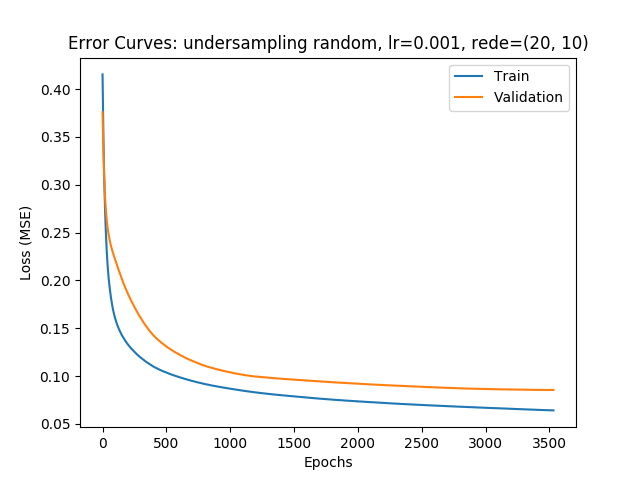

<IPython.core.display.Javascript object>


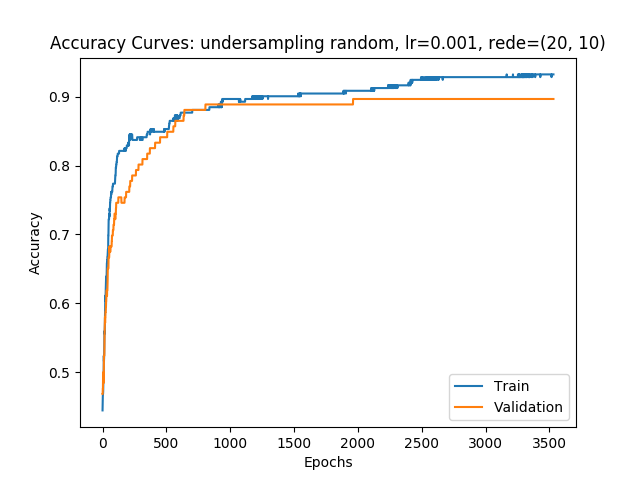

Matriz de confusão
[[1719  179]
 [   7   57]]

Train Loss:       0.0642
Validation Loss:  0.0854
Accuracy:         0.9052
MSE:              0.0948
AUROC:            0.9542


In [46]:
plot_training_error_curves(history, graficoName + "(20, 10)")
plot_training_acc_curves(history, graficoName + "(20, 10)")

## Fazer predições no conjunto de teste
y_pred = classifier.predict(X_test)
y_pred_class = classifier.predict_classes(X_test, verbose=0)

## Matriz de confusão
print('Matriz de confusão')
print(confusion_matrix(y_test, y_pred_class))

## Computar métricas de desempenho
losses = extract_final_losses(history)
print()
print("{metric:<18}{value:.4f}".format(metric="Train Loss:", value=losses['train_loss']))
print("{metric:<18}{value:.4f}".format(metric="Validation Loss:", value=losses['val_loss']))
print("{metric:<18}{value:.4f}".format(metric="Accuracy:", value=accuracy_score(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="MSE:", value=mean_squared_error(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="AUROC:", value=roc_auc_score(y_test, y_pred)))

## RNA 5 (2)

In [91]:
# Aqui criamos o esboço da rede.
classifier = Sequential()

classifier.add(Dense(2, activation='relu', input_dim=6)) # camada escondida
classifier.add(Dense(1, activation='relu')) # 

adam = optimizers.Adam(lr=learnRate)
classifier.compile(optimizer=adam,
                   loss='mean_squared_error', # metrica de erro
                   metrics=['accuracy']) # metrica de sucesso

history = classifier.fit(X_train, y_train,
                         epochs=2000, # quantidade de epocas que a rede neural vai executar
                         verbose=1,
                         shuffle=True, # utilizado para misturar as amostras a cada epoca
                         validation_data=(X_validation, y_validation))

Train on 252 samples, validate on 126 samples
Epoch 1/2000
252/252 [==============================] - 0s - loss: 0.4012 - acc: 0.4921 - val_loss: 0.3508 - val_acc: 0.4921
Epoch 2/2000
252/252 [==============================] - 0s - loss: 0.3089 - acc: 0.5119 - val_loss: 0.2538 - val_acc: 0.6111
Epoch 3/2000
252/252 [==============================] - 0s - loss: 0.2271 - acc: 0.6865 - val_loss: 0.1899 - val_acc: 0.7540
Epoch 4/2000
252/252 [==============================] - 0s - loss: 0.1743 - acc: 0.7817 - val_loss: 0.1556 - val_acc: 0.8016
Epoch 5/2000
252/252 [==============================] - 0s - loss: 0.1423 - acc: 0.8175 - val_loss: 0.1446 - val_acc: 0.8095
Epoch 6/2000
252/252 [==============================] - 0s - loss: 0.1309 - acc: 0.8452 - val_loss: 0.1519 - val_acc: 0.8413
Epoch 7/2000
252/252 [==============================] - 0s - loss: 0.1219 - acc: 0.8651 - val_loss: 0.1506 - val_acc: 0.8730
Epoch 8/2000
252/252 [==============================] - 0s - loss: 0.1192 - acc

252/252 [==============================] - 0s - loss: 0.0938 - acc: 0.9048 - val_loss: 0.1473 - val_acc: 0.8651
Epoch 130/2000
252/252 [==============================] - 0s - loss: 0.0933 - acc: 0.9048 - val_loss: 0.1464 - val_acc: 0.8651
Epoch 131/2000
252/252 [==============================] - 0s - loss: 0.0931 - acc: 0.8968 - val_loss: 0.1455 - val_acc: 0.8571
Epoch 132/2000
252/252 [==============================] - 0s - loss: 0.0925 - acc: 0.8968 - val_loss: 0.1436 - val_acc: 0.8571
Epoch 133/2000
252/252 [==============================] - 0s - loss: 0.0930 - acc: 0.8929 - val_loss: 0.1420 - val_acc: 0.8571
Epoch 134/2000
252/252 [==============================] - 0s - loss: 0.0916 - acc: 0.8968 - val_loss: 0.1402 - val_acc: 0.8651
Epoch 135/2000
252/252 [==============================] - 0s - loss: 0.0913 - acc: 0.8968 - val_loss: 0.1355 - val_acc: 0.8651
Epoch 136/2000
252/252 [==============================] - 0s - loss: 0.0909 - acc: 0.8929 - val_loss: 0.1384 - val_acc: 0.8571

252/252 [==============================] - 0s - loss: 0.0793 - acc: 0.9008 - val_loss: 0.1155 - val_acc: 0.8651
Epoch 258/2000
252/252 [==============================] - 0s - loss: 0.0794 - acc: 0.9008 - val_loss: 0.1188 - val_acc: 0.8571
Epoch 259/2000
252/252 [==============================] - 0s - loss: 0.0786 - acc: 0.9008 - val_loss: 0.1170 - val_acc: 0.8571
Epoch 260/2000
252/252 [==============================] - 0s - loss: 0.0800 - acc: 0.9008 - val_loss: 0.1145 - val_acc: 0.8651
Epoch 261/2000
252/252 [==============================] - 0s - loss: 0.0791 - acc: 0.9048 - val_loss: 0.1192 - val_acc: 0.8651
Epoch 262/2000
252/252 [==============================] - 0s - loss: 0.0791 - acc: 0.9008 - val_loss: 0.1174 - val_acc: 0.8571
Epoch 263/2000
252/252 [==============================] - 0s - loss: 0.0796 - acc: 0.9008 - val_loss: 0.1168 - val_acc: 0.8651
Epoch 264/2000
252/252 [==============================] - 0s - loss: 0.0789 - acc: 0.9008 - val_loss: 0.1191 - val_acc: 0.8651

252/252 [==============================] - 0s - loss: 0.0789 - acc: 0.9048 - val_loss: 0.1179 - val_acc: 0.8651
Epoch 386/2000
252/252 [==============================] - 0s - loss: 0.0792 - acc: 0.9048 - val_loss: 0.1175 - val_acc: 0.8571
Epoch 387/2000
252/252 [==============================] - 0s - loss: 0.0789 - acc: 0.9008 - val_loss: 0.1196 - val_acc: 0.8571
Epoch 388/2000
252/252 [==============================] - 0s - loss: 0.0796 - acc: 0.9008 - val_loss: 0.1159 - val_acc: 0.8651
Epoch 389/2000
252/252 [==============================] - 0s - loss: 0.0790 - acc: 0.9008 - val_loss: 0.1183 - val_acc: 0.8571
Epoch 390/2000
252/252 [==============================] - 0s - loss: 0.0793 - acc: 0.9008 - val_loss: 0.1208 - val_acc: 0.8651
Epoch 391/2000
252/252 [==============================] - 0s - loss: 0.0789 - acc: 0.9048 - val_loss: 0.1178 - val_acc: 0.8571
Epoch 392/2000
252/252 [==============================] - 0s - loss: 0.0789 - acc: 0.9048 - val_loss: 0.1163 - val_acc: 0.8571

252/252 [==============================] - 0s - loss: 0.0795 - acc: 0.9048 - val_loss: 0.1188 - val_acc: 0.8651
Epoch 514/2000
252/252 [==============================] - 0s - loss: 0.0787 - acc: 0.9008 - val_loss: 0.1179 - val_acc: 0.8571
Epoch 515/2000
252/252 [==============================] - 0s - loss: 0.0800 - acc: 0.9008 - val_loss: 0.1196 - val_acc: 0.8571
Epoch 516/2000
252/252 [==============================] - 0s - loss: 0.0794 - acc: 0.9008 - val_loss: 0.1184 - val_acc: 0.8651
Epoch 517/2000
252/252 [==============================] - 0s - loss: 0.0795 - acc: 0.9048 - val_loss: 0.1158 - val_acc: 0.8651
Epoch 518/2000
252/252 [==============================] - 0s - loss: 0.0795 - acc: 0.9008 - val_loss: 0.1196 - val_acc: 0.8571
Epoch 519/2000
252/252 [==============================] - 0s - loss: 0.0791 - acc: 0.9048 - val_loss: 0.1202 - val_acc: 0.8651
Epoch 520/2000
252/252 [==============================] - 0s - loss: 0.0789 - acc: 0.9048 - val_loss: 0.1168 - val_acc: 0.8571

252/252 [==============================] - 0s - loss: 0.0794 - acc: 0.9008 - val_loss: 0.1171 - val_acc: 0.8651
Epoch 642/2000
252/252 [==============================] - 0s - loss: 0.0796 - acc: 0.9008 - val_loss: 0.1182 - val_acc: 0.8571
Epoch 643/2000
252/252 [==============================] - 0s - loss: 0.0791 - acc: 0.9048 - val_loss: 0.1168 - val_acc: 0.8571
Epoch 644/2000
252/252 [==============================] - 0s - loss: 0.0789 - acc: 0.9048 - val_loss: 0.1175 - val_acc: 0.8651
Epoch 645/2000
252/252 [==============================] - 0s - loss: 0.0792 - acc: 0.9008 - val_loss: 0.1195 - val_acc: 0.8651
Epoch 646/2000
252/252 [==============================] - 0s - loss: 0.0793 - acc: 0.9048 - val_loss: 0.1184 - val_acc: 0.8571
Epoch 647/2000
252/252 [==============================] - 0s - loss: 0.0795 - acc: 0.9008 - val_loss: 0.1164 - val_acc: 0.8651
Epoch 648/2000
252/252 [==============================] - 0s - loss: 0.0788 - acc: 0.9008 - val_loss: 0.1176 - val_acc: 0.8651

252/252 [==============================] - 0s - loss: 0.0791 - acc: 0.9008 - val_loss: 0.1175 - val_acc: 0.8651
Epoch 770/2000
252/252 [==============================] - 0s - loss: 0.0789 - acc: 0.9008 - val_loss: 0.1174 - val_acc: 0.8651
Epoch 771/2000
252/252 [==============================] - 0s - loss: 0.0791 - acc: 0.9008 - val_loss: 0.1202 - val_acc: 0.8571
Epoch 772/2000
252/252 [==============================] - 0s - loss: 0.0791 - acc: 0.9008 - val_loss: 0.1183 - val_acc: 0.8651
Epoch 773/2000
252/252 [==============================] - ETA: 0s - loss: 0.0962 - acc: 0.875 - 0s - loss: 0.0787 - acc: 0.9048 - val_loss: 0.1170 - val_acc: 0.8571
Epoch 774/2000
252/252 [==============================] - 0s - loss: 0.0791 - acc: 0.9048 - val_loss: 0.1166 - val_acc: 0.8571
Epoch 775/2000
252/252 [==============================] - 0s - loss: 0.0793 - acc: 0.9008 - val_loss: 0.1206 - val_acc: 0.8651
Epoch 776/2000
252/252 [==============================] - 0s - loss: 0.0796 - acc: 0.900

252/252 [==============================] - 0s - loss: 0.0790 - acc: 0.9048 - val_loss: 0.1178 - val_acc: 0.8651
Epoch 898/2000
252/252 [==============================] - 0s - loss: 0.0794 - acc: 0.9008 - val_loss: 0.1201 - val_acc: 0.8651
Epoch 899/2000
252/252 [==============================] - 0s - loss: 0.0786 - acc: 0.9048 - val_loss: 0.1159 - val_acc: 0.8571
Epoch 900/2000
252/252 [==============================] - 0s - loss: 0.0794 - acc: 0.9048 - val_loss: 0.1160 - val_acc: 0.8571
Epoch 901/2000
252/252 [==============================] - 0s - loss: 0.0788 - acc: 0.9008 - val_loss: 0.1184 - val_acc: 0.8651
Epoch 902/2000
252/252 [==============================] - 0s - loss: 0.0789 - acc: 0.9008 - val_loss: 0.1208 - val_acc: 0.8651
Epoch 903/2000
252/252 [==============================] - 0s - loss: 0.0794 - acc: 0.9048 - val_loss: 0.1159 - val_acc: 0.8651
Epoch 904/2000
252/252 [==============================] - 0s - loss: 0.0794 - acc: 0.9048 - val_loss: 0.1185 - val_acc: 0.8651

252/252 [==============================] - 0s - loss: 0.0797 - acc: 0.9008 - val_loss: 0.1182 - val_acc: 0.8571
Epoch 1026/2000
252/252 [==============================] - 0s - loss: 0.0793 - acc: 0.9048 - val_loss: 0.1149 - val_acc: 0.8651
Epoch 1027/2000
252/252 [==============================] - 0s - loss: 0.0791 - acc: 0.9008 - val_loss: 0.1181 - val_acc: 0.8651
Epoch 1028/2000
252/252 [==============================] - 0s - loss: 0.0790 - acc: 0.9048 - val_loss: 0.1171 - val_acc: 0.8651
Epoch 1029/2000
252/252 [==============================] - 0s - loss: 0.0792 - acc: 0.9048 - val_loss: 0.1173 - val_acc: 0.8571
Epoch 1030/2000
252/252 [==============================] - 0s - loss: 0.0786 - acc: 0.9008 - val_loss: 0.1172 - val_acc: 0.8651
Epoch 1031/2000
252/252 [==============================] - 0s - loss: 0.0794 - acc: 0.9008 - val_loss: 0.1209 - val_acc: 0.8571
Epoch 1032/2000
252/252 [==============================] - 0s - loss: 0.0790 - acc: 0.9008 - val_loss: 0.1166 - val_acc:

252/252 [==============================] - 0s - loss: 0.0792 - acc: 0.9048 - val_loss: 0.1156 - val_acc: 0.8571
Epoch 1154/2000
252/252 [==============================] - 0s - loss: 0.0793 - acc: 0.9048 - val_loss: 0.1184 - val_acc: 0.8571
Epoch 1155/2000
252/252 [==============================] - 0s - loss: 0.0788 - acc: 0.9008 - val_loss: 0.1188 - val_acc: 0.8651
Epoch 1156/2000
252/252 [==============================] - 0s - loss: 0.0792 - acc: 0.9048 - val_loss: 0.1156 - val_acc: 0.8571
Epoch 1157/2000
252/252 [==============================] - 0s - loss: 0.0789 - acc: 0.9048 - val_loss: 0.1181 - val_acc: 0.8651
Epoch 1158/2000
252/252 [==============================] - 0s - loss: 0.0787 - acc: 0.9048 - val_loss: 0.1167 - val_acc: 0.8651
Epoch 1159/2000
252/252 [==============================] - 0s - loss: 0.0791 - acc: 0.9048 - val_loss: 0.1186 - val_acc: 0.8651
Epoch 1160/2000
252/252 [==============================] - 0s - loss: 0.0792 - acc: 0.9048 - val_loss: 0.1155 - val_acc:

252/252 [==============================] - 0s - loss: 0.0793 - acc: 0.9008 - val_loss: 0.1181 - val_acc: 0.8571
Epoch 1280/2000
252/252 [==============================] - ETA: 0s - loss: 0.0682 - acc: 0.906 - 0s - loss: 0.0788 - acc: 0.9008 - val_loss: 0.1203 - val_acc: 0.8651
Epoch 1281/2000
252/252 [==============================] - 0s - loss: 0.0788 - acc: 0.9048 - val_loss: 0.1178 - val_acc: 0.8651
Epoch 1282/2000
252/252 [==============================] - 0s - loss: 0.0790 - acc: 0.9008 - val_loss: 0.1175 - val_acc: 0.8651
Epoch 1283/2000
252/252 [==============================] - 0s - loss: 0.0789 - acc: 0.9008 - val_loss: 0.1169 - val_acc: 0.8651
Epoch 1284/2000
252/252 [==============================] - 0s - loss: 0.0789 - acc: 0.9048 - val_loss: 0.1176 - val_acc: 0.8651
Epoch 1285/2000
252/252 [==============================] - 0s - loss: 0.0788 - acc: 0.9048 - val_loss: 0.1175 - val_acc: 0.8651
Epoch 1286/2000
252/252 [==============================] - 0s - loss: 0.0788 - acc

252/252 [==============================] - 0s - loss: 0.0798 - acc: 0.9048 - val_loss: 0.1180 - val_acc: 0.8651
Epoch 1407/2000
252/252 [==============================] - 0s - loss: 0.0791 - acc: 0.9048 - val_loss: 0.1162 - val_acc: 0.8651
Epoch 1408/2000
252/252 [==============================] - 0s - loss: 0.0792 - acc: 0.9008 - val_loss: 0.1198 - val_acc: 0.8651
Epoch 1409/2000
252/252 [==============================] - 0s - loss: 0.0790 - acc: 0.9008 - val_loss: 0.1179 - val_acc: 0.8651
Epoch 1410/2000
252/252 [==============================] - 0s - loss: 0.0788 - acc: 0.9048 - val_loss: 0.1173 - val_acc: 0.8651
Epoch 1411/2000
252/252 [==============================] - 0s - loss: 0.0788 - acc: 0.9048 - val_loss: 0.1171 - val_acc: 0.8651
Epoch 1412/2000
252/252 [==============================] - 0s - loss: 0.0790 - acc: 0.9048 - val_loss: 0.1160 - val_acc: 0.8651
Epoch 1413/2000
252/252 [==============================] - 0s - loss: 0.0788 - acc: 0.9048 - val_loss: 0.1180 - val_acc:

252/252 [==============================] - 0s - loss: 0.0788 - acc: 0.9048 - val_loss: 0.1187 - val_acc: 0.8571
Epoch 1535/2000
252/252 [==============================] - 0s - loss: 0.0794 - acc: 0.9048 - val_loss: 0.1164 - val_acc: 0.8651
Epoch 1536/2000
252/252 [==============================] - 0s - loss: 0.0797 - acc: 0.9008 - val_loss: 0.1182 - val_acc: 0.8651
Epoch 1537/2000
252/252 [==============================] - 0s - loss: 0.0795 - acc: 0.9048 - val_loss: 0.1194 - val_acc: 0.8651
Epoch 1538/2000
252/252 [==============================] - 0s - loss: 0.0795 - acc: 0.9008 - val_loss: 0.1160 - val_acc: 0.8651
Epoch 1539/2000
252/252 [==============================] - 0s - loss: 0.0787 - acc: 0.9008 - val_loss: 0.1178 - val_acc: 0.8571
Epoch 1540/2000
252/252 [==============================] - 0s - loss: 0.0805 - acc: 0.9048 - val_loss: 0.1193 - val_acc: 0.8571
Epoch 1541/2000
252/252 [==============================] - 0s - loss: 0.0800 - acc: 0.9008 - val_loss: 0.1151 - val_acc:

252/252 [==============================] - 0s - loss: 0.0791 - acc: 0.9048 - val_loss: 0.1174 - val_acc: 0.8651
Epoch 1663/2000
252/252 [==============================] - 0s - loss: 0.0795 - acc: 0.9008 - val_loss: 0.1183 - val_acc: 0.8571
Epoch 1664/2000
252/252 [==============================] - 0s - loss: 0.0792 - acc: 0.9048 - val_loss: 0.1186 - val_acc: 0.8571
Epoch 1665/2000
252/252 [==============================] - 0s - loss: 0.0792 - acc: 0.9048 - val_loss: 0.1147 - val_acc: 0.8651
Epoch 1666/2000
252/252 [==============================] - 0s - loss: 0.0789 - acc: 0.9048 - val_loss: 0.1179 - val_acc: 0.8651
Epoch 1667/2000
252/252 [==============================] - 0s - loss: 0.0803 - acc: 0.9008 - val_loss: 0.1208 - val_acc: 0.8571
Epoch 1668/2000
252/252 [==============================] - 0s - loss: 0.0792 - acc: 0.9008 - val_loss: 0.1174 - val_acc: 0.8651
Epoch 1669/2000
252/252 [==============================] - 0s - loss: 0.0790 - acc: 0.9048 - val_loss: 0.1183 - val_acc:

252/252 [==============================] - 0s - loss: 0.0788 - acc: 0.9048 - val_loss: 0.1164 - val_acc: 0.8651
Epoch 1790/2000
252/252 [==============================] - 0s - loss: 0.0789 - acc: 0.9048 - val_loss: 0.1147 - val_acc: 0.8651
Epoch 1791/2000
252/252 [==============================] - 0s - loss: 0.0795 - acc: 0.9048 - val_loss: 0.1160 - val_acc: 0.8571
Epoch 1792/2000
252/252 [==============================] - 0s - loss: 0.0786 - acc: 0.9048 - val_loss: 0.1193 - val_acc: 0.8651
Epoch 1793/2000
252/252 [==============================] - 0s - loss: 0.0787 - acc: 0.9048 - val_loss: 0.1178 - val_acc: 0.8651
Epoch 1794/2000
252/252 [==============================] - 0s - loss: 0.0792 - acc: 0.9008 - val_loss: 0.1185 - val_acc: 0.8651
Epoch 1795/2000
252/252 [==============================] - 0s - loss: 0.0793 - acc: 0.9008 - val_loss: 0.1161 - val_acc: 0.8651
Epoch 1796/2000
252/252 [==============================] - 0s - loss: 0.0790 - acc: 0.9048 - val_loss: 0.1168 - val_acc:

252/252 [==============================] - 0s - loss: 0.0799 - acc: 0.9008 - val_loss: 0.1204 - val_acc: 0.8651
Epoch 1918/2000
252/252 [==============================] - 0s - loss: 0.0788 - acc: 0.9048 - val_loss: 0.1188 - val_acc: 0.8651
Epoch 1919/2000
252/252 [==============================] - 0s - loss: 0.0787 - acc: 0.9048 - val_loss: 0.1153 - val_acc: 0.8651
Epoch 1920/2000
252/252 [==============================] - 0s - loss: 0.0791 - acc: 0.9048 - val_loss: 0.1161 - val_acc: 0.8651
Epoch 1921/2000
252/252 [==============================] - 0s - loss: 0.0790 - acc: 0.9048 - val_loss: 0.1188 - val_acc: 0.8571
Epoch 1922/2000
252/252 [==============================] - 0s - loss: 0.0787 - acc: 0.9048 - val_loss: 0.1165 - val_acc: 0.8651
Epoch 1923/2000
252/252 [==============================] - 0s - loss: 0.0787 - acc: 0.9008 - val_loss: 0.1183 - val_acc: 0.8571
Epoch 1924/2000
252/252 [==============================] - 0s - loss: 0.0793 - acc: 0.9008 - val_loss: 0.1176 - val_acc:

In [92]:
test_loss = classifier.evaluate(X_test, y_test)
print (test_loss)

  32/1962 [..............................] - ETA: 0s[0.06902084823519325, 0.87512742087746254]


/home/opcinove/.virtualenvs/python3.6env/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


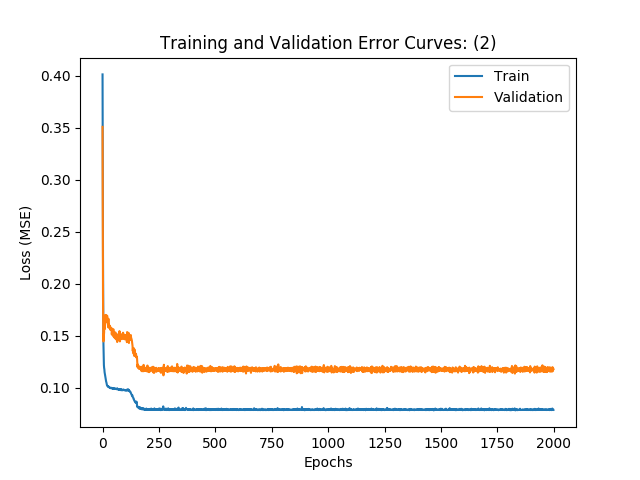

<IPython.core.display.Javascript object>


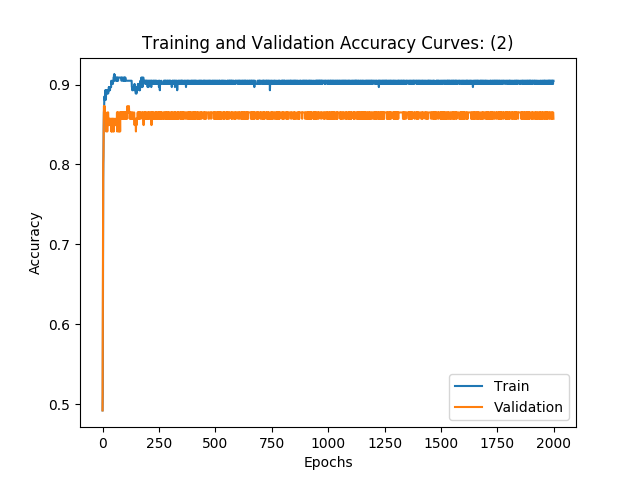

Matriz de confusão
[[1660  238]
 [   6   58]]

Train Loss:       0.0808
Validation Loss:  0.1121
Accuracy:         0.8756
MSE:              0.1244
AUROC:            0.9348


In [93]:
plot_training_error_curves(history, "(2)")
plot_training_acc_curves(history, "(2)")

## Fazer predições no conjunto de teste
y_pred = classifier.predict(X_test)
y_pred_class = classifier.predict_classes(X_test, verbose=0)

## Matriz de confusão
print('Matriz de confusão')
print(confusion_matrix(y_test, y_pred_class))

## Computar métricas de desempenho
losses = extract_final_losses(history)
print()
print("{metric:<18}{value:.4f}".format(metric="Train Loss:", value=losses['train_loss']))
print("{metric:<18}{value:.4f}".format(metric="Validation Loss:", value=losses['val_loss']))
print("{metric:<18}{value:.4f}".format(metric="Accuracy:", value=accuracy_score(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="MSE:", value=mean_squared_error(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="AUROC:", value=roc_auc_score(y_test, y_pred)))

## RNA 6 (4)

In [94]:
# Aq## RNA 5 (2)ui criamos o esboço da rede.
classifier = Sequential()

classifier.add(Dense(4, activation='relu', input_dim=6)) # camada escondida
classifier.add(Dense(1, activation='relu')) # 

adam = optimizers.Adam(lr=learnRate)
classifier.compile(optimizer=adam,
                   loss='mean_squared_error', # metrica de erro
                   metrics=['accuracy']) # metrica de sucesso

history = classifier.fit(X_train, y_train,
                         epochs=2000, # quantidade de epocas que a rede neural vai executar
                         verbose=1,
                         shuffle=True, # utilizado para misturar as amostras a cada epoca
                         validation_data=(X_validation, y_validation))

Train on 252 samples, validate on 126 samples
Epoch 1/2000
252/252 [==============================] - 0s - loss: 0.5802 - acc: 0.3611 - val_loss: 0.5293 - val_acc: 0.4048
Epoch 2/2000
252/252 [==============================] - 0s - loss: 0.5169 - acc: 0.4802 - val_loss: 0.5031 - val_acc: 0.5000
Epoch 3/2000
252/252 [==============================] - 0s - loss: 0.5015 - acc: 0.5000 - val_loss: 0.4988 - val_acc: 0.5000
Epoch 4/2000
252/252 [==============================] - 0s - loss: 0.5001 - acc: 0.5000 - val_loss: 0.4990 - val_acc: 0.5000
Epoch 5/2000
252/252 [==============================] - 0s - loss: 0.4999 - acc: 0.5000 - val_loss: 0.4997 - val_acc: 0.5000
Epoch 6/2000
252/252 [==============================] - 0s - loss: 0.4997 - acc: 0.5000 - val_loss: 0.5000 - val_acc: 0.5000
Epoch 7/2000
252/252 [==============================] - 0s - loss: 0.4996 - acc: 0.5000 - val_loss: 0.5002 - val_acc: 0.5000
Epoch 8/2000
252/252 [==============================] - 0s - loss: 0.4994 - acc

252/252 [==============================] - 0s - loss: 0.0732 - acc: 0.9127 - val_loss: 0.1131 - val_acc: 0.8651
Epoch 130/2000
252/252 [==============================] - 0s - loss: 0.0733 - acc: 0.9127 - val_loss: 0.1140 - val_acc: 0.8651
Epoch 131/2000
252/252 [==============================] - 0s - loss: 0.0724 - acc: 0.9127 - val_loss: 0.1138 - val_acc: 0.8571
Epoch 132/2000
252/252 [==============================] - 0s - loss: 0.0732 - acc: 0.9127 - val_loss: 0.1149 - val_acc: 0.8571
Epoch 133/2000
252/252 [==============================] - 0s - loss: 0.0727 - acc: 0.9087 - val_loss: 0.1160 - val_acc: 0.8571
Epoch 134/2000
252/252 [==============================] - 0s - loss: 0.0726 - acc: 0.9127 - val_loss: 0.1132 - val_acc: 0.8571
Epoch 135/2000
252/252 [==============================] - 0s - loss: 0.0729 - acc: 0.9087 - val_loss: 0.1136 - val_acc: 0.8571
Epoch 136/2000
252/252 [==============================] - 0s - loss: 0.0722 - acc: 0.9087 - val_loss: 0.1151 - val_acc: 0.8571

252/252 [==============================] - 0s - loss: 0.0688 - acc: 0.9246 - val_loss: 0.1272 - val_acc: 0.8651
Epoch 258/2000
252/252 [==============================] - 0s - loss: 0.0688 - acc: 0.9325 - val_loss: 0.1265 - val_acc: 0.8651
Epoch 259/2000
252/252 [==============================] - 0s - loss: 0.0692 - acc: 0.9286 - val_loss: 0.1314 - val_acc: 0.8651
Epoch 260/2000
252/252 [==============================] - 0s - loss: 0.0685 - acc: 0.9286 - val_loss: 0.1268 - val_acc: 0.8651
Epoch 261/2000
252/252 [==============================] - 0s - loss: 0.0689 - acc: 0.9286 - val_loss: 0.1291 - val_acc: 0.8651
Epoch 262/2000
252/252 [==============================] - 0s - loss: 0.0689 - acc: 0.9325 - val_loss: 0.1275 - val_acc: 0.8571
Epoch 263/2000
252/252 [==============================] - 0s - loss: 0.0693 - acc: 0.9286 - val_loss: 0.1283 - val_acc: 0.8651
Epoch 264/2000
252/252 [==============================] - 0s - loss: 0.0689 - acc: 0.9325 - val_loss: 0.1297 - val_acc: 0.8651

252/252 [==============================] - 0s - loss: 0.0668 - acc: 0.9325 - val_loss: 0.1299 - val_acc: 0.8651
Epoch 386/2000
252/252 [==============================] - 0s - loss: 0.0676 - acc: 0.9325 - val_loss: 0.1282 - val_acc: 0.8571
Epoch 387/2000
252/252 [==============================] - 0s - loss: 0.0675 - acc: 0.9286 - val_loss: 0.1288 - val_acc: 0.8651
Epoch 388/2000
252/252 [==============================] - 0s - loss: 0.0681 - acc: 0.9325 - val_loss: 0.1280 - val_acc: 0.8651
Epoch 389/2000
252/252 [==============================] - 0s - loss: 0.0674 - acc: 0.9286 - val_loss: 0.1308 - val_acc: 0.8571
Epoch 390/2000
252/252 [==============================] - 0s - loss: 0.0674 - acc: 0.9286 - val_loss: 0.1268 - val_acc: 0.8651
Epoch 391/2000
252/252 [==============================] - 0s - loss: 0.0681 - acc: 0.9325 - val_loss: 0.1271 - val_acc: 0.8651
Epoch 392/2000
252/252 [==============================] - 0s - loss: 0.0694 - acc: 0.9325 - val_loss: 0.1331 - val_acc: 0.8492

252/252 [==============================] - 0s - loss: 0.0665 - acc: 0.9286 - val_loss: 0.1272 - val_acc: 0.8571
Epoch 514/2000
252/252 [==============================] - 0s - loss: 0.0678 - acc: 0.9246 - val_loss: 0.1283 - val_acc: 0.8492
Epoch 515/2000
252/252 [==============================] - 0s - loss: 0.0704 - acc: 0.9246 - val_loss: 0.1311 - val_acc: 0.8651
Epoch 516/2000
252/252 [==============================] - 0s - loss: 0.0712 - acc: 0.9246 - val_loss: 0.1237 - val_acc: 0.8730
Epoch 517/2000
252/252 [==============================] - 0s - loss: 0.0678 - acc: 0.9325 - val_loss: 0.1278 - val_acc: 0.8571
Epoch 518/2000
252/252 [==============================] - 0s - loss: 0.0669 - acc: 0.9286 - val_loss: 0.1293 - val_acc: 0.8730
Epoch 519/2000
252/252 [==============================] - 0s - loss: 0.0666 - acc: 0.9286 - val_loss: 0.1238 - val_acc: 0.8571
Epoch 520/2000
252/252 [==============================] - 0s - loss: 0.0677 - acc: 0.9246 - val_loss: 0.1273 - val_acc: 0.8571

252/252 [==============================] - 0s - loss: 0.0658 - acc: 0.9286 - val_loss: 0.1275 - val_acc: 0.8651
Epoch 642/2000
252/252 [==============================] - 0s - loss: 0.0662 - acc: 0.9286 - val_loss: 0.1286 - val_acc: 0.8651
Epoch 643/2000
252/252 [==============================] - 0s - loss: 0.0661 - acc: 0.9286 - val_loss: 0.1287 - val_acc: 0.8651
Epoch 644/2000
252/252 [==============================] - 0s - loss: 0.0663 - acc: 0.9286 - val_loss: 0.1256 - val_acc: 0.8651
Epoch 645/2000
252/252 [==============================] - 0s - loss: 0.0661 - acc: 0.9286 - val_loss: 0.1286 - val_acc: 0.8571
Epoch 646/2000
252/252 [==============================] - 0s - loss: 0.0669 - acc: 0.9286 - val_loss: 0.1293 - val_acc: 0.8571
Epoch 647/2000
252/252 [==============================] - 0s - loss: 0.0667 - acc: 0.9286 - val_loss: 0.1269 - val_acc: 0.8651
Epoch 648/2000
252/252 [==============================] - 0s - loss: 0.0659 - acc: 0.9286 - val_loss: 0.1260 - val_acc: 0.8571

252/252 [==============================] - 0s - loss: 0.0662 - acc: 0.9365 - val_loss: 0.1243 - val_acc: 0.8571
Epoch 770/2000
252/252 [==============================] - 0s - loss: 0.0662 - acc: 0.9325 - val_loss: 0.1292 - val_acc: 0.8651
Epoch 771/2000
252/252 [==============================] - 0s - loss: 0.0663 - acc: 0.9286 - val_loss: 0.1307 - val_acc: 0.8651
Epoch 772/2000
252/252 [==============================] - 0s - loss: 0.0661 - acc: 0.9325 - val_loss: 0.1269 - val_acc: 0.8651
Epoch 773/2000
252/252 [==============================] - 0s - loss: 0.0663 - acc: 0.9286 - val_loss: 0.1279 - val_acc: 0.8651
Epoch 774/2000
252/252 [==============================] - 0s - loss: 0.0659 - acc: 0.9286 - val_loss: 0.1315 - val_acc: 0.8651
Epoch 775/2000
252/252 [==============================] - 0s - loss: 0.0668 - acc: 0.9286 - val_loss: 0.1280 - val_acc: 0.8651
Epoch 776/2000
252/252 [==============================] - 0s - loss: 0.0674 - acc: 0.9325 - val_loss: 0.1246 - val_acc: 0.8571

252/252 [==============================] - 0s - loss: 0.0670 - acc: 0.9286 - val_loss: 0.1293 - val_acc: 0.8571
Epoch 898/2000
252/252 [==============================] - 0s - loss: 0.0685 - acc: 0.9286 - val_loss: 0.1268 - val_acc: 0.8571
Epoch 899/2000
252/252 [==============================] - 0s - loss: 0.0678 - acc: 0.9286 - val_loss: 0.1287 - val_acc: 0.8651
Epoch 900/2000
252/252 [==============================] - 0s - loss: 0.0674 - acc: 0.9286 - val_loss: 0.1288 - val_acc: 0.8651
Epoch 901/2000
252/252 [==============================] - 0s - loss: 0.0661 - acc: 0.9286 - val_loss: 0.1260 - val_acc: 0.8651
Epoch 902/2000
252/252 [==============================] - 0s - loss: 0.0674 - acc: 0.9286 - val_loss: 0.1284 - val_acc: 0.8571
Epoch 903/2000
252/252 [==============================] - 0s - loss: 0.0676 - acc: 0.9286 - val_loss: 0.1322 - val_acc: 0.8571
Epoch 904/2000
252/252 [==============================] - 0s - loss: 0.0662 - acc: 0.9286 - val_loss: 0.1267 - val_acc: 0.8651

252/252 [==============================] - 0s - loss: 0.0658 - acc: 0.9286 - val_loss: 0.1278 - val_acc: 0.8651
Epoch 1026/2000
252/252 [==============================] - 0s - loss: 0.0658 - acc: 0.9325 - val_loss: 0.1284 - val_acc: 0.8651
Epoch 1027/2000
252/252 [==============================] - 0s - loss: 0.0660 - acc: 0.9325 - val_loss: 0.1289 - val_acc: 0.8571
Epoch 1028/2000
252/252 [==============================] - 0s - loss: 0.0661 - acc: 0.9286 - val_loss: 0.1294 - val_acc: 0.8651
Epoch 1029/2000
252/252 [==============================] - 0s - loss: 0.0660 - acc: 0.9325 - val_loss: 0.1288 - val_acc: 0.8651
Epoch 1030/2000
252/252 [==============================] - 0s - loss: 0.0660 - acc: 0.9325 - val_loss: 0.1271 - val_acc: 0.8651
Epoch 1031/2000
252/252 [==============================] - 0s - loss: 0.0661 - acc: 0.9325 - val_loss: 0.1296 - val_acc: 0.8651
Epoch 1032/2000
252/252 [==============================] - 0s - loss: 0.0665 - acc: 0.9286 - val_loss: 0.1269 - val_acc:

252/252 [==============================] - 0s - loss: 0.0658 - acc: 0.9286 - val_loss: 0.1263 - val_acc: 0.8571
Epoch 1154/2000
252/252 [==============================] - 0s - loss: 0.0670 - acc: 0.9325 - val_loss: 0.1309 - val_acc: 0.8651
Epoch 1155/2000
252/252 [==============================] - 0s - loss: 0.0671 - acc: 0.9325 - val_loss: 0.1297 - val_acc: 0.8571
Epoch 1156/2000
252/252 [==============================] - 0s - loss: 0.0680 - acc: 0.9286 - val_loss: 0.1304 - val_acc: 0.8651
Epoch 1157/2000
252/252 [==============================] - 0s - loss: 0.0680 - acc: 0.9246 - val_loss: 0.1275 - val_acc: 0.8492
Epoch 1158/2000
252/252 [==============================] - 0s - loss: 0.0668 - acc: 0.9286 - val_loss: 0.1304 - val_acc: 0.8651
Epoch 1159/2000
252/252 [==============================] - 0s - loss: 0.0667 - acc: 0.9286 - val_loss: 0.1260 - val_acc: 0.8651
Epoch 1160/2000
252/252 [==============================] - 0s - loss: 0.0666 - acc: 0.9325 - val_loss: 0.1292 - val_acc:

252/252 [==============================] - 0s - loss: 0.0667 - acc: 0.9286 - val_loss: 0.1295 - val_acc: 0.8651
Epoch 1281/2000
252/252 [==============================] - 0s - loss: 0.0672 - acc: 0.9286 - val_loss: 0.1271 - val_acc: 0.8571
Epoch 1282/2000
252/252 [==============================] - 0s - loss: 0.0680 - acc: 0.9286 - val_loss: 0.1275 - val_acc: 0.8651
Epoch 1283/2000
252/252 [==============================] - 0s - loss: 0.0672 - acc: 0.9286 - val_loss: 0.1282 - val_acc: 0.8651
Epoch 1284/2000
252/252 [==============================] - 0s - loss: 0.0669 - acc: 0.9286 - val_loss: 0.1276 - val_acc: 0.8651
Epoch 1285/2000
252/252 [==============================] - 0s - loss: 0.0664 - acc: 0.9286 - val_loss: 0.1281 - val_acc: 0.8651
Epoch 1286/2000
252/252 [==============================] - 0s - loss: 0.0667 - acc: 0.9365 - val_loss: 0.1278 - val_acc: 0.8651
Epoch 1287/2000
252/252 [==============================] - 0s - loss: 0.0665 - acc: 0.9286 - val_loss: 0.1295 - val_acc:

252/252 [==============================] - 0s - loss: 0.0662 - acc: 0.9325 - val_loss: 0.1301 - val_acc: 0.8651
Epoch 1408/2000
252/252 [==============================] - 0s - loss: 0.0659 - acc: 0.9286 - val_loss: 0.1284 - val_acc: 0.8651
Epoch 1409/2000
252/252 [==============================] - 0s - loss: 0.0660 - acc: 0.9325 - val_loss: 0.1278 - val_acc: 0.8651
Epoch 1410/2000
252/252 [==============================] - 0s - loss: 0.0664 - acc: 0.9365 - val_loss: 0.1281 - val_acc: 0.8651
Epoch 1411/2000
252/252 [==============================] - 0s - loss: 0.0658 - acc: 0.9286 - val_loss: 0.1303 - val_acc: 0.8651
Epoch 1412/2000
252/252 [==============================] - 0s - loss: 0.0664 - acc: 0.9286 - val_loss: 0.1273 - val_acc: 0.8651
Epoch 1413/2000
252/252 [==============================] - 0s - loss: 0.0666 - acc: 0.9286 - val_loss: 0.1285 - val_acc: 0.8651
Epoch 1414/2000
252/252 [==============================] - 0s - loss: 0.0664 - acc: 0.9286 - val_loss: 0.1311 - val_acc:

252/252 [==============================] - 0s - loss: 0.0660 - acc: 0.9286 - val_loss: 0.1273 - val_acc: 0.8651
Epoch 1536/2000
252/252 [==============================] - 0s - loss: 0.0660 - acc: 0.9365 - val_loss: 0.1285 - val_acc: 0.8651
Epoch 1537/2000
252/252 [==============================] - 0s - loss: 0.0667 - acc: 0.9325 - val_loss: 0.1285 - val_acc: 0.8651
Epoch 1538/2000
252/252 [==============================] - 0s - loss: 0.0667 - acc: 0.9286 - val_loss: 0.1318 - val_acc: 0.8730
Epoch 1539/2000
252/252 [==============================] - 0s - loss: 0.0674 - acc: 0.9286 - val_loss: 0.1256 - val_acc: 0.8651
Epoch 1540/2000
252/252 [==============================] - 0s - loss: 0.0679 - acc: 0.9286 - val_loss: 0.1307 - val_acc: 0.8651
Epoch 1541/2000
252/252 [==============================] - 0s - loss: 0.0671 - acc: 0.9286 - val_loss: 0.1271 - val_acc: 0.8492
Epoch 1542/2000
252/252 [==============================] - 0s - loss: 0.0660 - acc: 0.9325 - val_loss: 0.1279 - val_acc:

252/252 [==============================] - 0s - loss: 0.0659 - acc: 0.9325 - val_loss: 0.1268 - val_acc: 0.8651
Epoch 1664/2000
252/252 [==============================] - 0s - loss: 0.0659 - acc: 0.9286 - val_loss: 0.1300 - val_acc: 0.8651
Epoch 1665/2000
252/252 [==============================] - 0s - loss: 0.0663 - acc: 0.9325 - val_loss: 0.1298 - val_acc: 0.8651
Epoch 1666/2000
252/252 [==============================] - 0s - loss: 0.0657 - acc: 0.9325 - val_loss: 0.1277 - val_acc: 0.8651
Epoch 1667/2000
252/252 [==============================] - 0s - loss: 0.0667 - acc: 0.9286 - val_loss: 0.1304 - val_acc: 0.8651
Epoch 1668/2000
252/252 [==============================] - 0s - loss: 0.0663 - acc: 0.9325 - val_loss: 0.1274 - val_acc: 0.8571
Epoch 1669/2000
252/252 [==============================] - 0s - loss: 0.0658 - acc: 0.9325 - val_loss: 0.1271 - val_acc: 0.8651
Epoch 1670/2000
252/252 [==============================] - 0s - loss: 0.0662 - acc: 0.9325 - val_loss: 0.1293 - val_acc:

252/252 [==============================] - 0s - loss: 0.0681 - acc: 0.9246 - val_loss: 0.1344 - val_acc: 0.8730
Epoch 1792/2000
252/252 [==============================] - 0s - loss: 0.0672 - acc: 0.9286 - val_loss: 0.1271 - val_acc: 0.8571
Epoch 1793/2000
252/252 [==============================] - 0s - loss: 0.0698 - acc: 0.9286 - val_loss: 0.1294 - val_acc: 0.8651
Epoch 1794/2000
252/252 [==============================] - 0s - loss: 0.0666 - acc: 0.9286 - val_loss: 0.1286 - val_acc: 0.8651
Epoch 1795/2000
252/252 [==============================] - 0s - loss: 0.0682 - acc: 0.9286 - val_loss: 0.1296 - val_acc: 0.8651
Epoch 1796/2000
252/252 [==============================] - 0s - loss: 0.0675 - acc: 0.9286 - val_loss: 0.1264 - val_acc: 0.8571
Epoch 1797/2000
252/252 [==============================] - 0s - loss: 0.0675 - acc: 0.9286 - val_loss: 0.1320 - val_acc: 0.8651
Epoch 1798/2000
252/252 [==============================] - 0s - loss: 0.0664 - acc: 0.9286 - val_loss: 0.1289 - val_acc:

252/252 [==============================] - 0s - loss: 0.0662 - acc: 0.9325 - val_loss: 0.1295 - val_acc: 0.8651
Epoch 1920/2000
252/252 [==============================] - 0s - loss: 0.0666 - acc: 0.9286 - val_loss: 0.1294 - val_acc: 0.8651
Epoch 1921/2000
252/252 [==============================] - 0s - loss: 0.0662 - acc: 0.9325 - val_loss: 0.1282 - val_acc: 0.8651
Epoch 1922/2000
252/252 [==============================] - 0s - loss: 0.0661 - acc: 0.9286 - val_loss: 0.1306 - val_acc: 0.8651
Epoch 1923/2000
252/252 [==============================] - 0s - loss: 0.0665 - acc: 0.9286 - val_loss: 0.1279 - val_acc: 0.8651
Epoch 1924/2000
252/252 [==============================] - 0s - loss: 0.0661 - acc: 0.9286 - val_loss: 0.1319 - val_acc: 0.8651
Epoch 1925/2000
252/252 [==============================] - 0s - loss: 0.0664 - acc: 0.9286 - val_loss: 0.1261 - val_acc: 0.8571
Epoch 1926/2000
252/252 [==============================] - 0s - loss: 0.0664 - acc: 0.9325 - val_loss: 0.1285 - val_acc:

In [95]:
test_loss = classifier.evaluate(X_test, y_test)
print (test_loss)

1962/1962 [==============================] - 0s     
[0.073499742242204791, 0.89908256868582137]


/home/opcinove/.virtualenvs/python3.6env/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


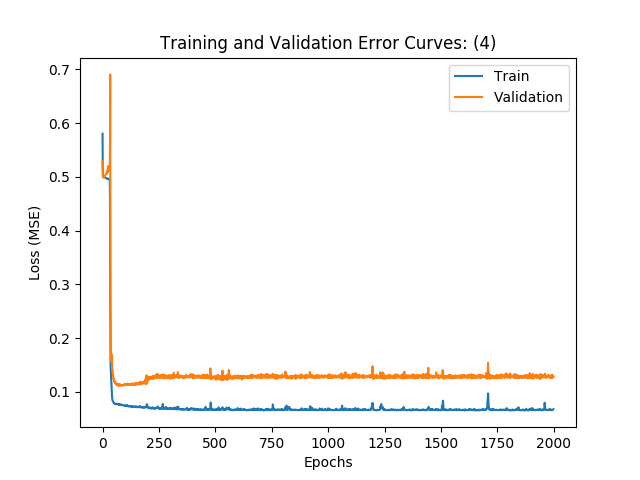

<IPython.core.display.Javascript object>


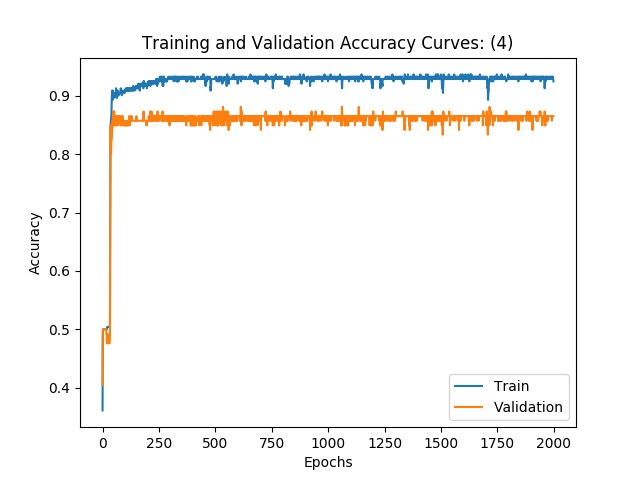

Matriz de confusão
[[1709  189]
 [   8   56]]

Train Loss:       0.0770
Validation Loss:  0.1116
Accuracy:         0.8996
MSE:              0.1004
AUROC:            0.9144


In [96]:
plot_training_error_curves(history, "(4)")
plot_training_acc_curves(history, "(4)")

## Fazer predições no conjunto de teste
y_pred = classifier.predict(X_test)
y_pred_class = classifier.predict_classes(X_test, verbose=0)

## Matriz de confusão
print('Matriz de confusão')
print(confusion_matrix(y_test, y_pred_class))

## Computar métricas de desempenho
losses = extract_final_losses(history)
print()
print("{metric:<18}{value:.4f}".format(metric="Train Loss:", value=losses['train_loss']))
print("{metric:<18}{value:.4f}".format(metric="Validation Loss:", value=losses['val_loss']))
print("{metric:<18}{value:.4f}".format(metric="Accuracy:", value=accuracy_score(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="MSE:", value=mean_squared_error(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="AUROC:", value=roc_auc_score(y_test, y_pred)))